In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk
import joblib
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,cross_validate
import timeit


In [2]:
random_seed = 108
test_size = 0.2

In [3]:

score_df = pd.DataFrame.from_dict(
    {'model': [],
 'test_accuracy':[],
 'outcome':[],
    'fit_time':[],
    'score_time':[],
    'test_precision':[],
    'test_recall':[],
    'test_f1':[],
    'test_roc_auc':[]}
)


test_df = pd.DataFrame.from_dict(
    {'model': [],
    'accuracy':[],
     'precision':[],
     'recall':[],
     'f1_score':[],
     'auc':[],
     'outcome':[]})


scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
          'f1': 'f1',
          'roc_auc': 'roc_auc'}

In [4]:
orig_data = pd.read_csv('MASTER STEMI database 2010 - 2019.csv')

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

In [6]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
def evaluate_model(model,X,y):
    yhat = model.predict(X)
    yhat_proba = model.predict_proba(X)
    result_dict = {}
    result_dict['accuracy'] = [accuracy_score(y,yhat)]
    result_dict['precision'] = [precision_score(y,yhat)]
    result_dict['recall'] = [recall_score(y,yhat)]
    result_dict['f1_score'] = [f1_score(y,yhat)]
    result_dict['auc'] = [roc_auc_score(y,yhat_proba[:,1])]
    
    df = pd.DataFrame.from_dict(result_dict)
    return df

In [7]:
cols = [
    'Age',
    'Sex (0 = Male, 1=Female)',
    'Height',
    'Weight',
    'BMI',
    'Hypertension', 
    'Hypercholesterolaemia',
    'Smoking History( 2= current, 1 = ex smoke, 0 = never)', 
    'Diabetes',
    'Family History',
    'Previous stent',
    'Coded Cuplrit Vessel (RCA = 1, LCx = 2, LAD = 3)',
    'TIMI flow pre', 
    'TIMI Flow post',
    'Rentrop Simplified',
    'Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)',
    'No. of stent',
    'Length of stent',
    'CTO in remote vessel',
    'Pre-Hospital Arrest',
    'GP IIb/IIIa inhibitor', 
    'Inotrope during case', 
    'Starting HR',
    'Starting SBP',
    'Arrhythmia during case', 
    'IABP/ECMO',
    'Time from onset to angio (Hrs)',
    'LVEF FINAL',
    "lvef_abnormal"
]

orig_data['LVEF FINAL'] = orig_data['LVEF FINAL'].replace([-55,-99],np.NaN)

orig_data["lvef_abnormal"] = [np.NaN if np.isnan(x) else 1 if x < 40 else 0 for x in orig_data['LVEF FINAL']]

predictors = ['Outcome']

df = orig_data[cols + predictors]

In [9]:
df = df.replace([-55,-99],np.NaN)

for c in df.columns:
    df[c] = df[c].replace('', np.NaN)
    df[c] = df[c].replace('-', np.NaN)
    df[c] = df[c].replace('[a-zA-Z]+', np.NaN).astype(float)
    
df["Height"] = df["Height"].replace(0,np.NaN)
df["Age"] = df["Age"].where(df.Age.between(16, 105)) # remove ages less than 16 and greater than 105

df['Time from onset to angio (Hrs)'] = df['Time from onset to angio (Hrs)'].where(df['Time from onset to angio (Hrs)'] >= 0) 

In [10]:
df.isna().sum().sort_values()

Rentrop Simplified                                                   0
Pre-Hospital Arrest                                                  0
CTO in remote vessel                                                 0
No. of stent                                                         0
Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)      0
TIMI Flow post                                                       0
TIMI flow pre                                                        0
Coded Cuplrit Vessel (RCA = 1, LCx = 2, LAD = 3)                     0
Outcome                                                              0
Sex (0 = Male, 1=Female)                                             0
Arrhythmia during case                                               3
Inotrope during case                                                 3
Age                                                                  6
Starting HR                                                         12
Previo

In [11]:
df["log_length_stent"] = np.log(df['Length of stent'])
df["log_onset_to_angio"] = np.log(df['Time from onset to angio (Hrs)'])
df.drop(['Length of stent','Time from onset to angio (Hrs)'],axis = 1,inplace=True)

In [12]:
df_subset_index = {}
for p in predictors:
    df_subset_index[p] = df.index[df[p].notna()].tolist()

In [13]:
float_col = [
    'Age',
    'Height',
    'Weight',
    'BMI',
    #'Length of stent',
    'log_length_stent',
    'Starting HR',
    'Starting SBP',
    #'Time from onset to angio (Hrs)',
    'log_onset_to_angio',
    'No. of stent',
    'LVEF FINAL',
]
categorical_col = [c for c in df.columns if c not in float_col + predictors]

In [14]:
df_dummy =  pd.get_dummies(
        df,
        columns = categorical_col, 
        dummy_na=False,
        drop_first=True)

In [15]:
df_dummy.columns
df_dummy_cat_cols = [x for x in df_dummy.columns if x not in float_col + predictors]

In [16]:
from sklearn.model_selection import train_test_split

train,test = {},{}
for p in predictors:
    train[p],test[p]= train_test_split(df_subset_index[p], test_size=test_size, random_state=random_seed)


In [17]:
    y_train = df_dummy.loc[train[p],p]
    X_train = df_dummy.iloc[train[p]].drop(predictors, axis=1)

In [21]:
pd.DataFrame(columns=X_train.columns).to_csv("app/dataframe_template.csv").loc[0,'age']

In [20]:
k = pd.DataFrame(columns=X_train.columns)
k.loc[0,'Age'] = 10

In [21]:
k

Age Height Weight  BMI No. of stent Starting HR Starting SBP LVEF FINAL  \
0  10    NaN    NaN  NaN          NaN         NaN          NaN        NaN   

  log_length_stent log_onset_to_angio  ...  \
0              NaN                NaN  ...   

  Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)_2.0  \
0                                                NaN                    

  Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)_3.0  \
0                                                NaN                    

  Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)_4.0  \
0                                                NaN                    

  CTO in remote vessel_1.0 Pre-Hospital Arrest_1.0 GP IIb/IIIa inhibitor_1.0  \
0                      NaN                     NaN                       NaN   

  Inotrope during case_1.0 Arrhythmia during case_1.0 IABP/ECMO_1.0  \
0                      NaN                        NaN           NaN   

  lvef_abnormal_1.0  
0               NaN  

[1 rows x 37 columns]

In [22]:
X_train.columns

Index(['Age', 'Height', 'Weight', 'BMI', 'No. of stent', 'Starting HR',
       'Starting SBP', 'LVEF FINAL', 'log_length_stent', 'log_onset_to_angio',
       'Sex (0 = Male, 1=Female)_1.0', 'Hypertension_1.0',
       'Hypercholesterolaemia_1.0',
       'Smoking History( 2= current, 1 = ex smoke, 0 = never)_1.0',
       'Smoking History( 2= current, 1 = ex smoke, 0 = never)_2.0',
       'Diabetes_1.0', 'Family History_1.0', 'Previous stent_1.0',
       'Coded Cuplrit Vessel (RCA = 1, LCx = 2, LAD = 3)_2.0',
       'Coded Cuplrit Vessel (RCA = 1, LCx = 2, LAD = 3)_3.0',
       'TIMI flow pre_1.0', 'TIMI flow pre_2.0', 'TIMI flow pre_3.0',
       'TIMI Flow post_1.0', 'TIMI Flow post_2.0', 'TIMI Flow post_3.0',
       'Rentrop Simplified_1.0',
       'Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)_2.0',
       'Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)_3.0',
       'Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)_4.0',
       'CTO in 

# Exploration

In [23]:
df.groupby(predictors).size().unstack(fill_value=0)

ValueError: index must be a MultiIndex to unstack, <class 'pandas.core.indexes.base.Index'> was passed

In [18]:
for p in predictors:
    print(df[p].value_counts(normalize=True))

Outcome
0.0    0.863661
1.0    0.136339
Name: proportion, dtype: float64


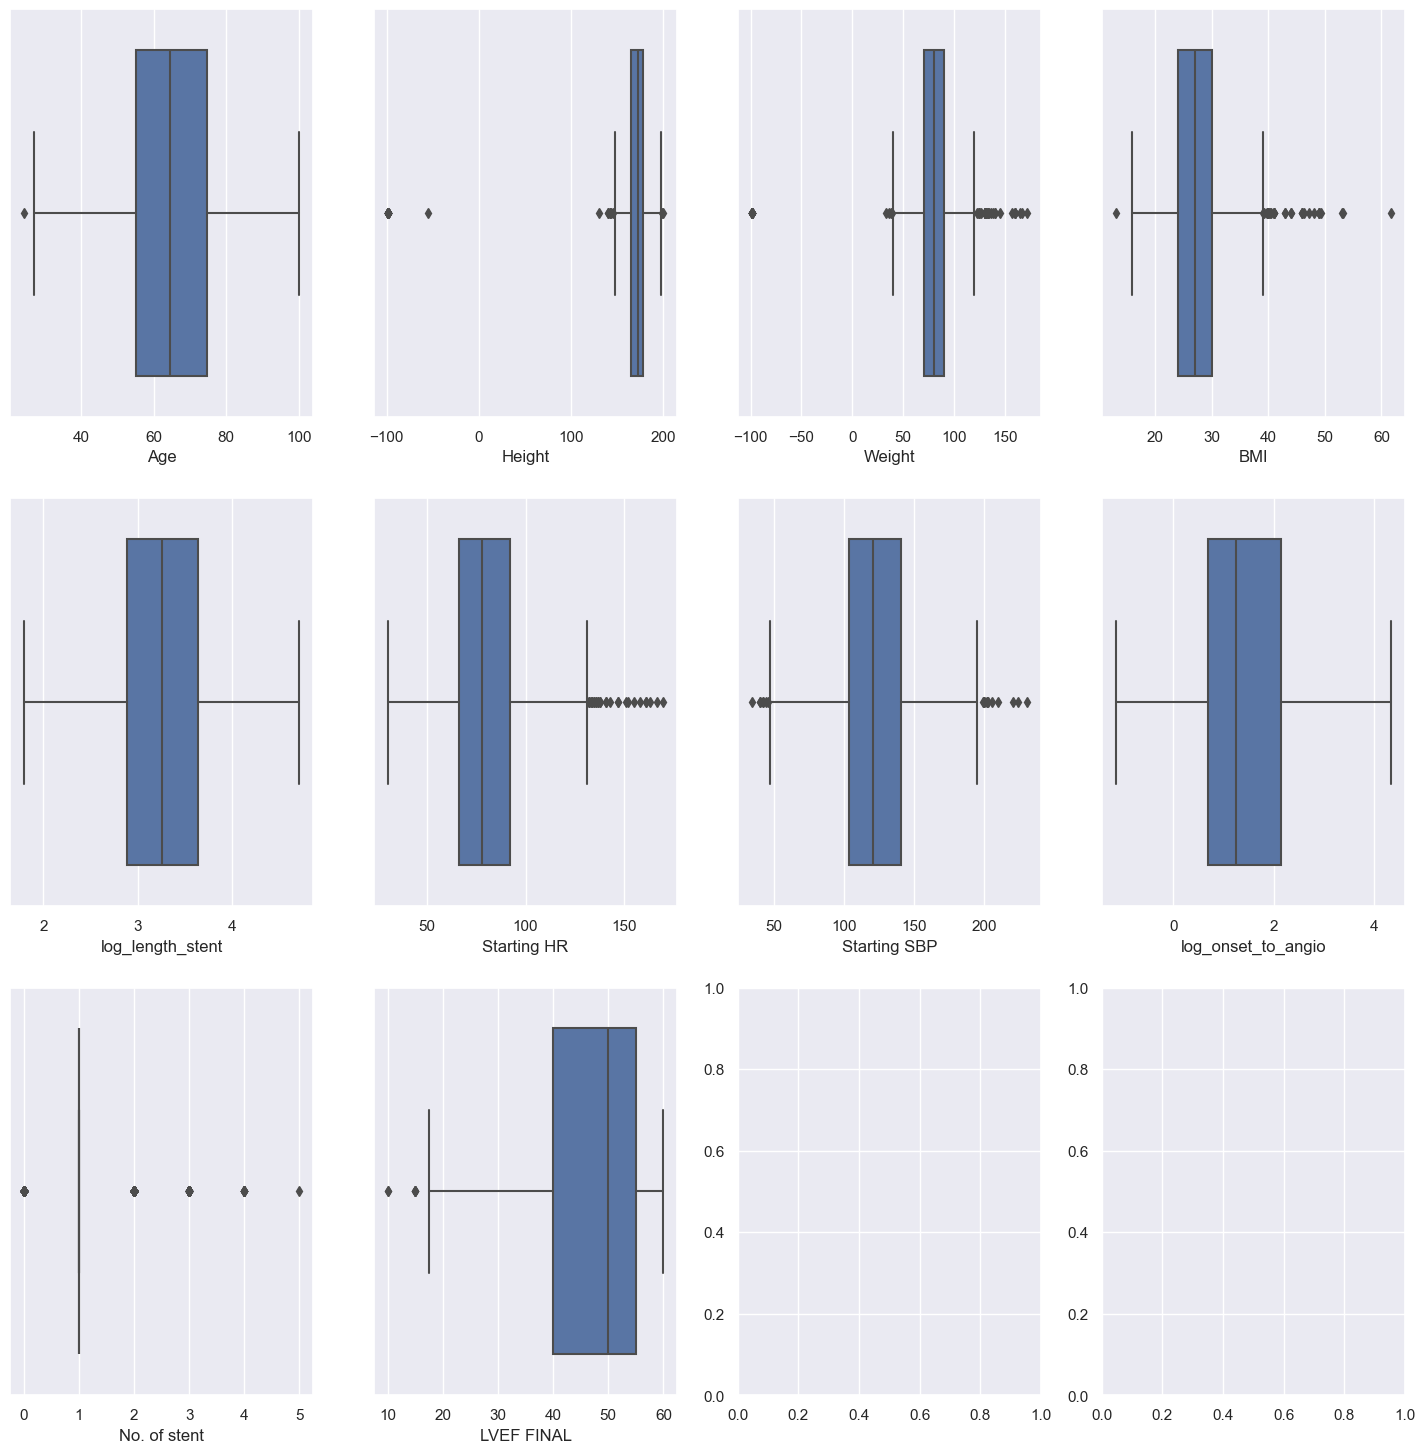

In [25]:
fig, axes = plt.subplots(3, 4, figsize=(18, 18))
i = 0
for c in float_col:
    sns.boxplot(ax=axes[int(i/4), i%4], data=df, x=c)
    i+=1

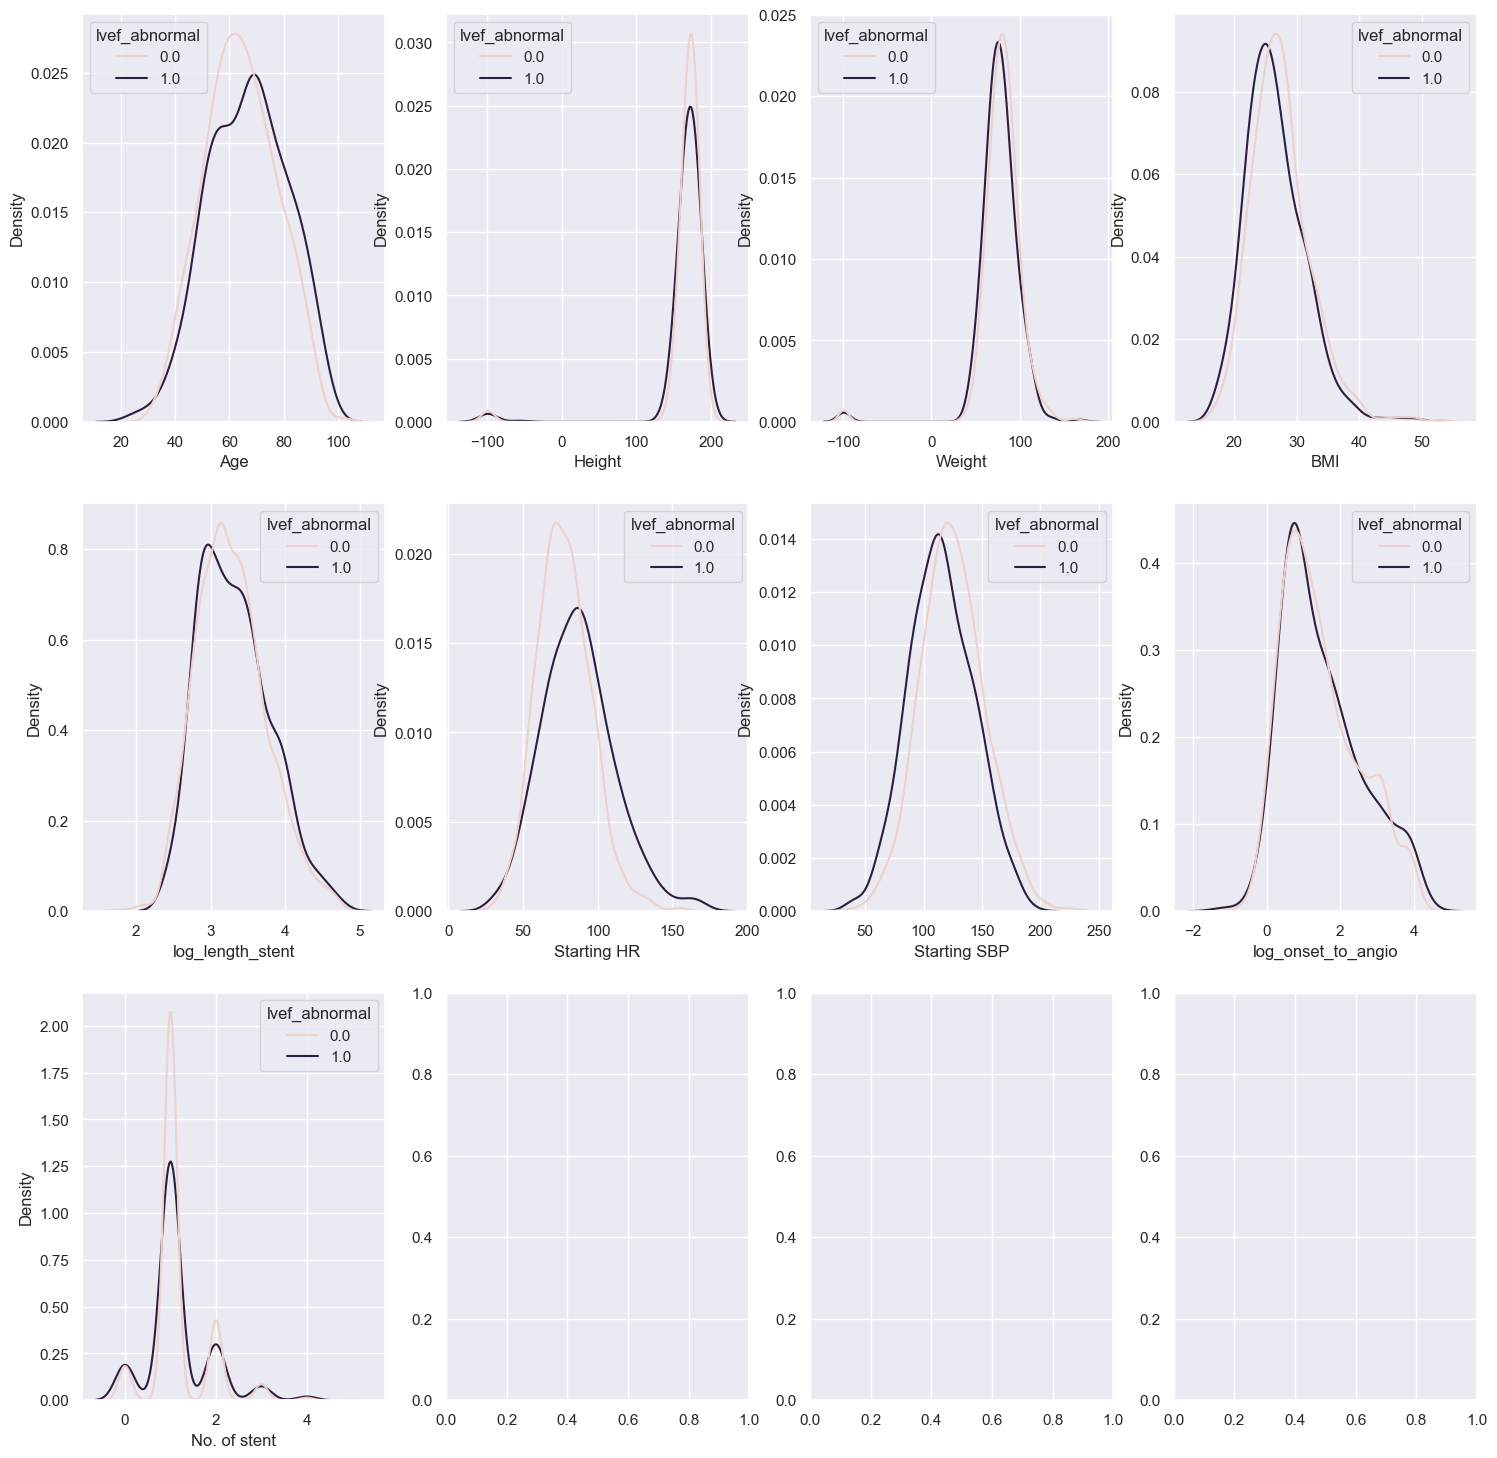

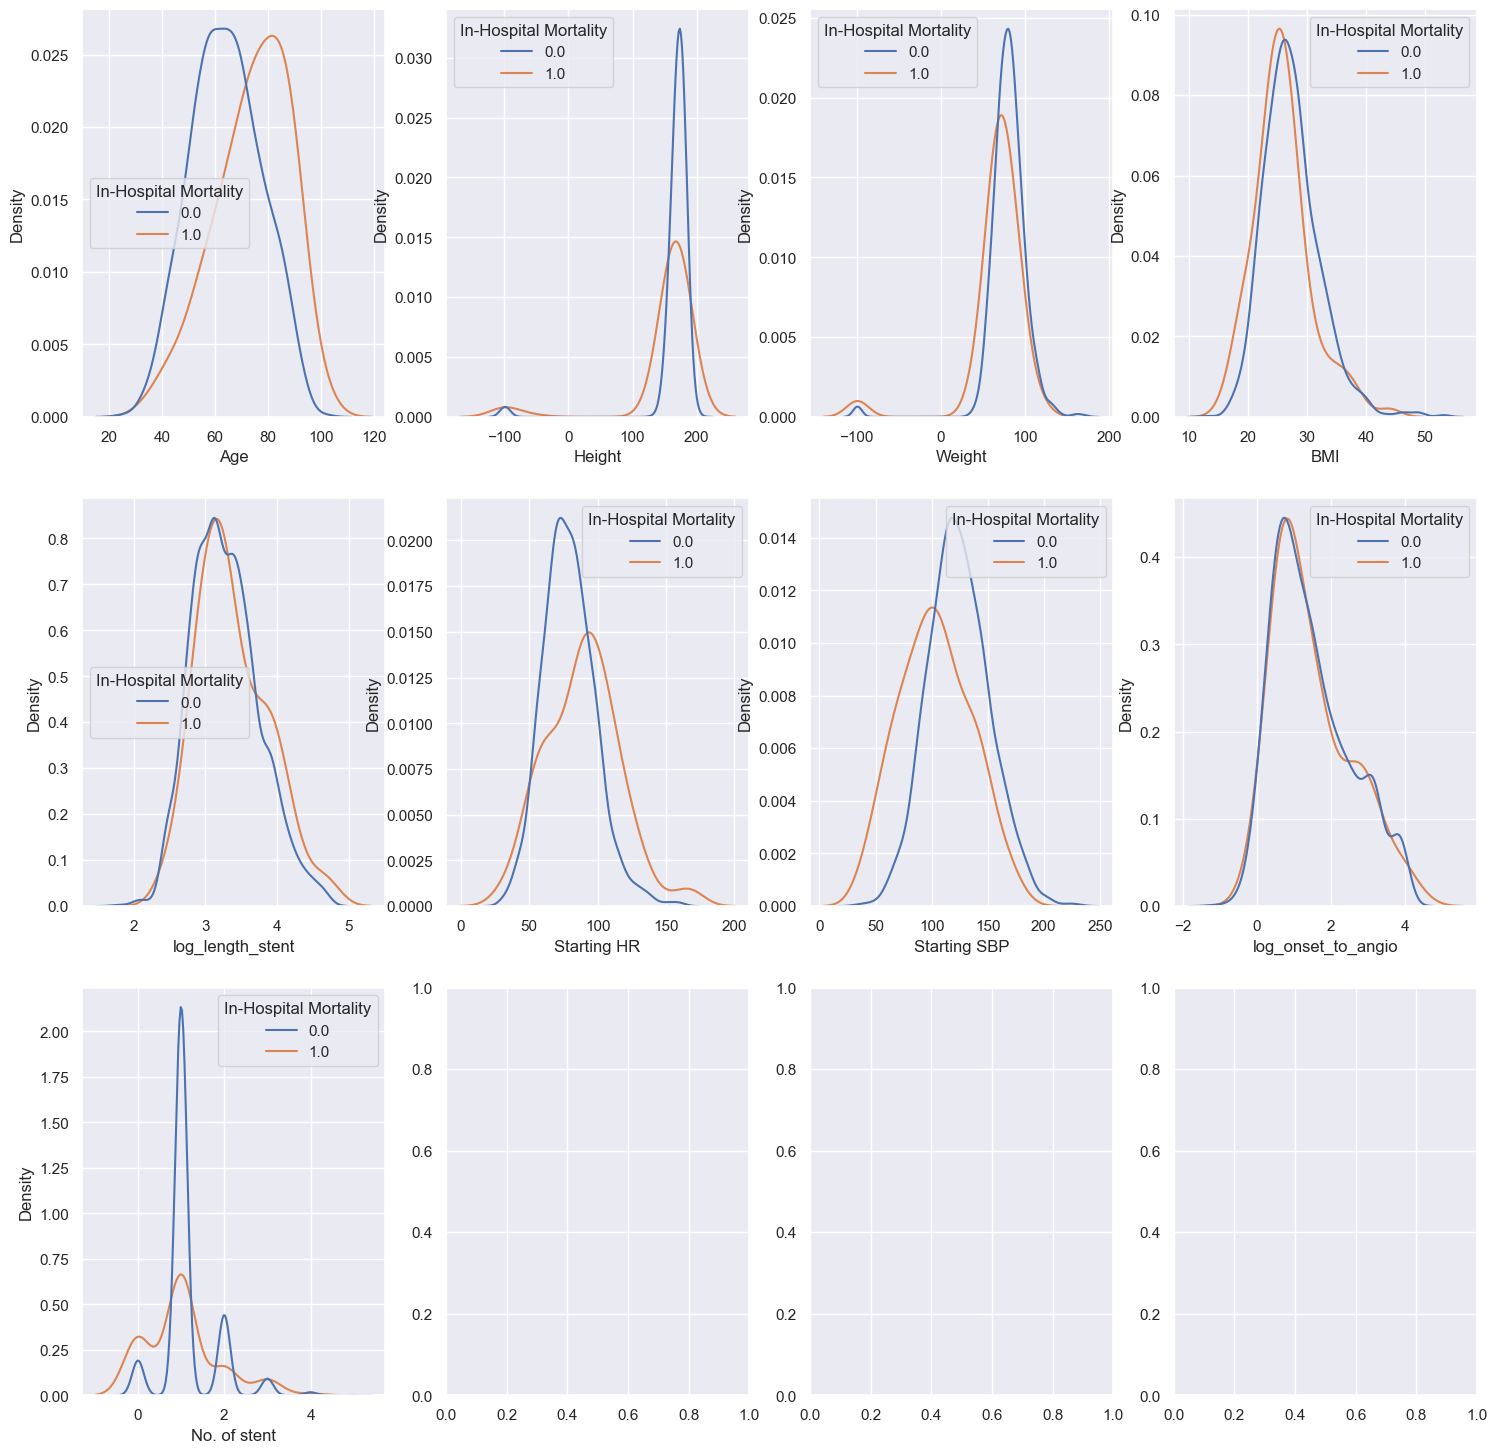

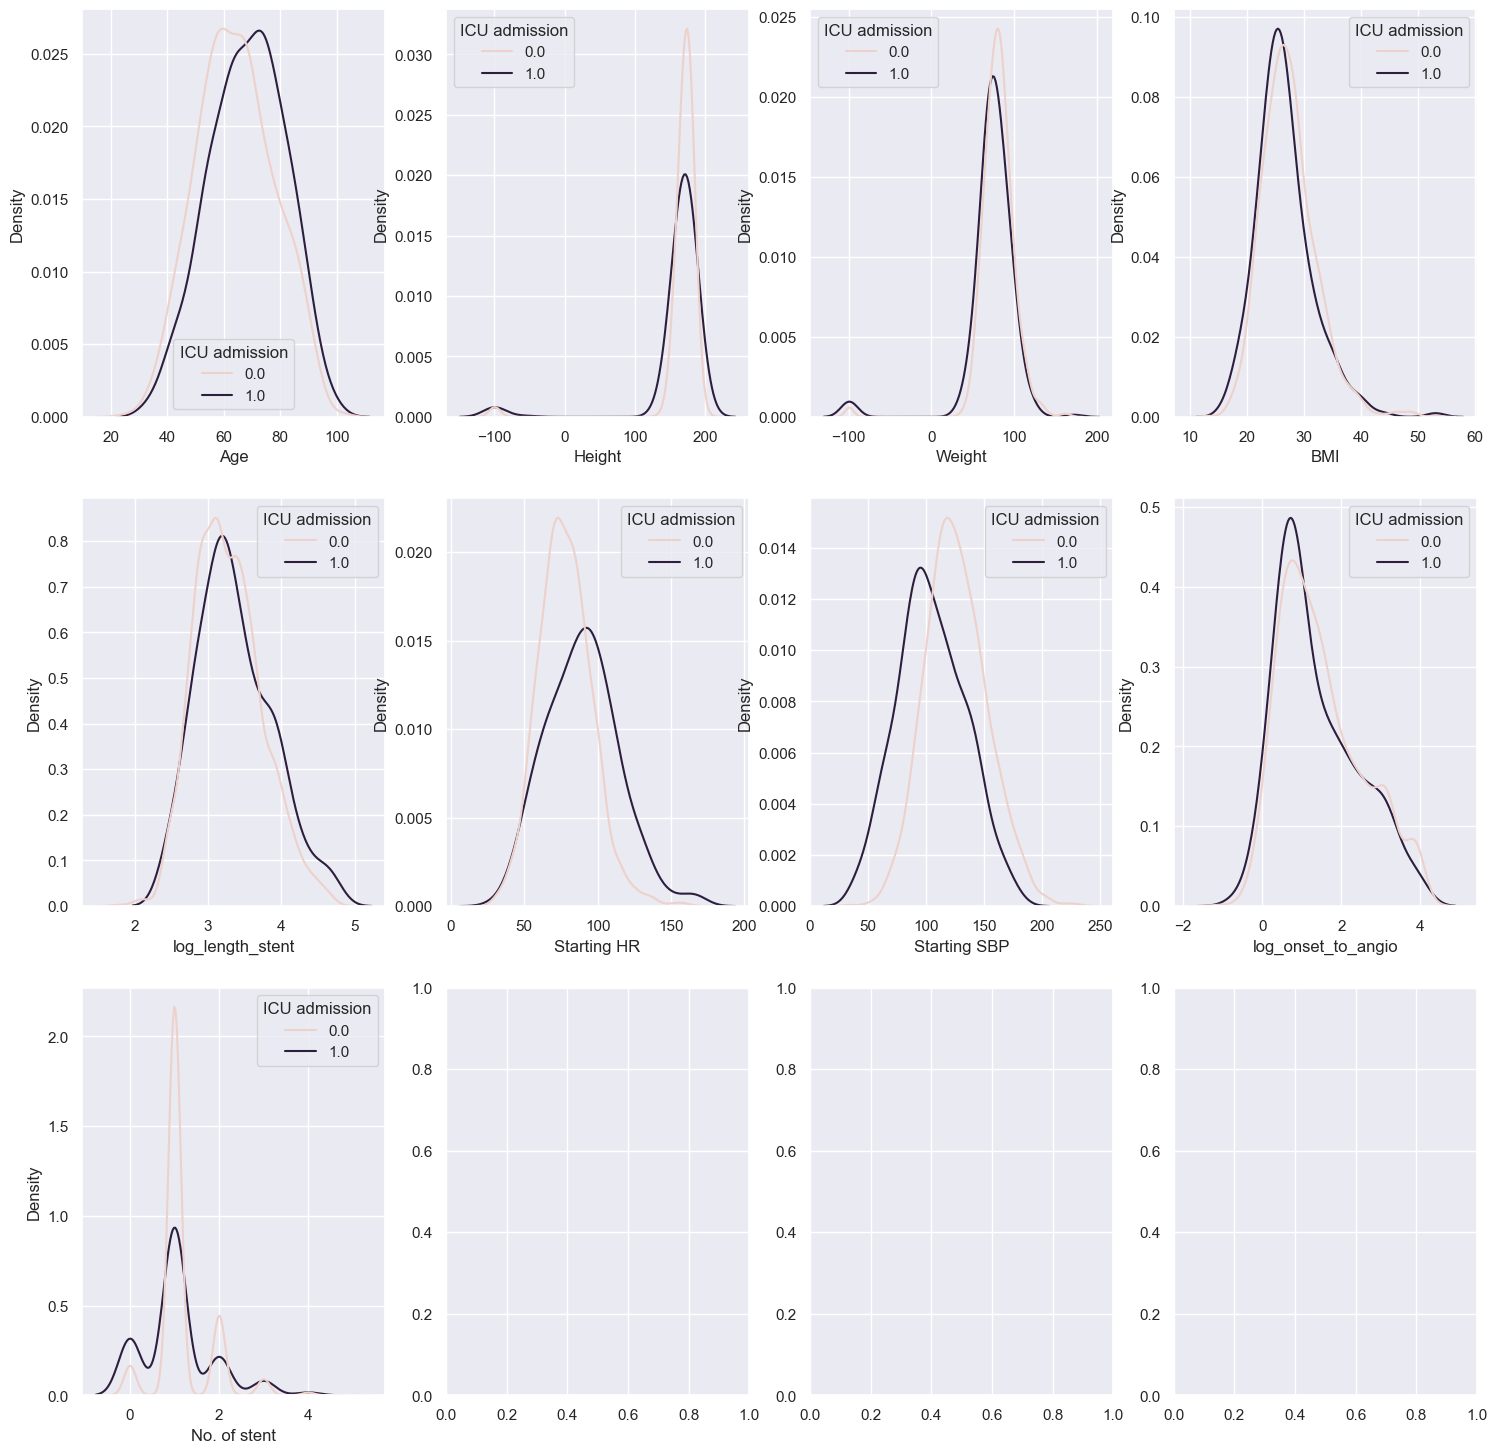

In [19]:
for p in predictors:
    fig, axes = plt.subplots(3, 4, figsize=(18, 18))
    i = 0
    for c in float_col:
        sns.kdeplot(ax=axes[int(i/4), i%4], data=df, x=c,hue=p,common_norm=False)
        i+=1

Possible significant features for `lvef_abnormal`
- length of stent
- starting HR
- starting SBP

Possible significant features for `In Hospital Mortality`
- Age
- starting HR
- starting SBP

Possible significant features for `ICU Admission`
- starting HR
- starting SBP

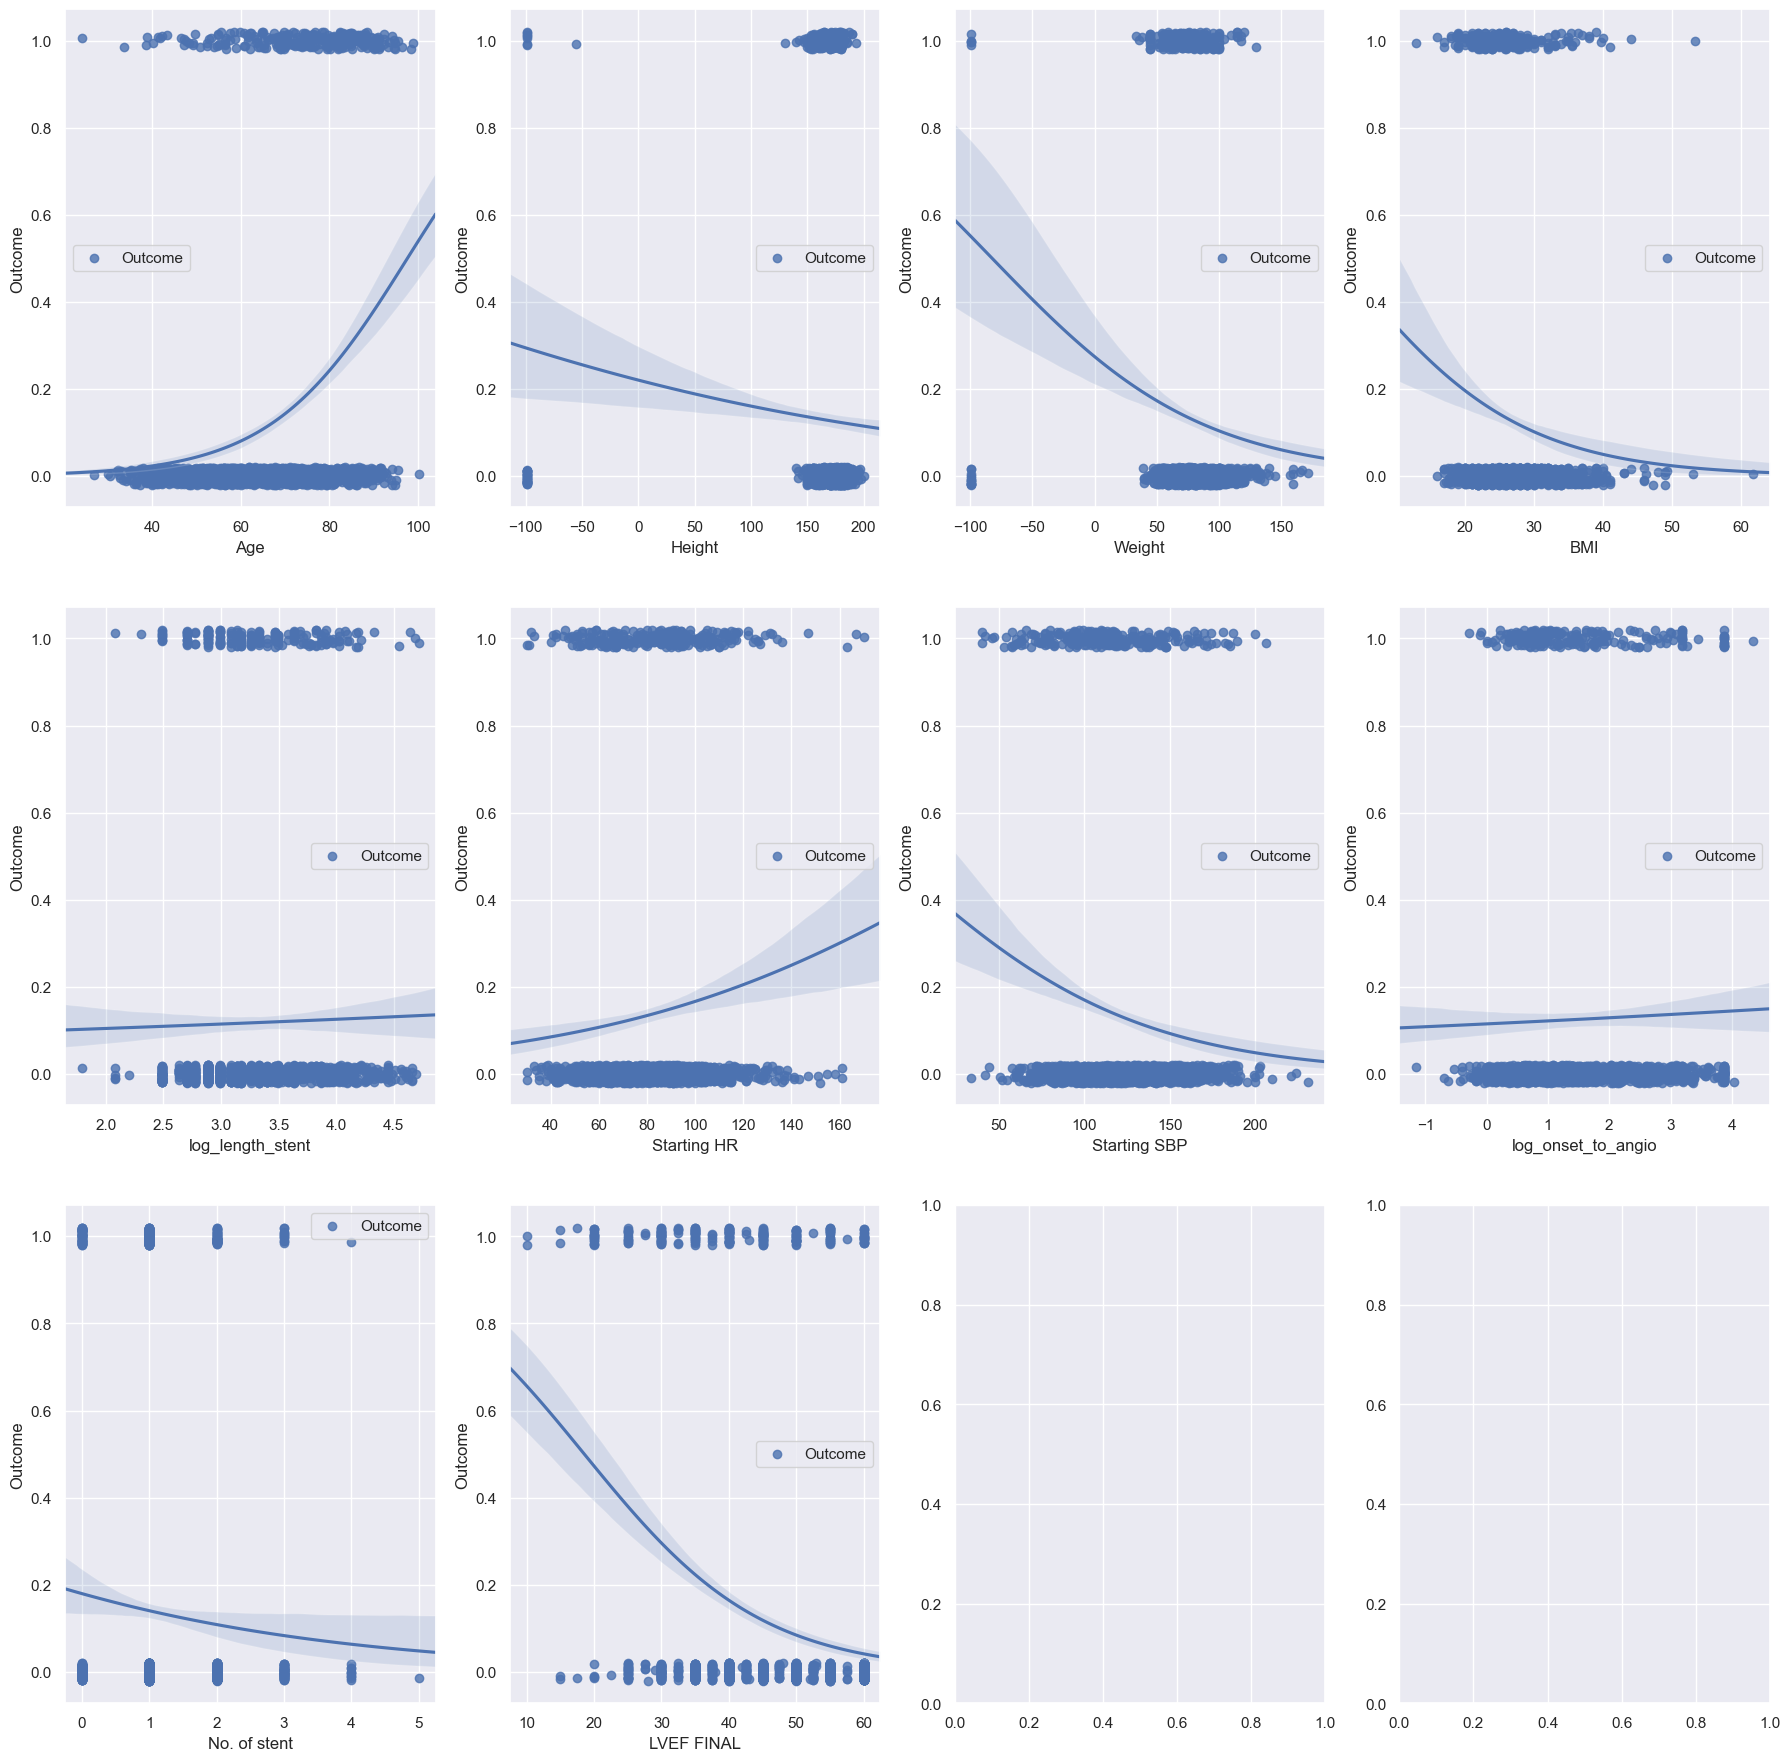

In [19]:
fig, axes = plt.subplots(3, 4, figsize=(22, 22))
i = 0
for c in float_col:
    for p in predictors:
        ax = sns.regplot(x=c, y=p, data=df,y_jitter=.02, 
                   logistic=True, truncate=False,ax=axes[int(i/4), i%4],label=p)
        ax.legend()
    i+=1

AttributeError: 'numpy.float64' object has no attribute 'startswith'

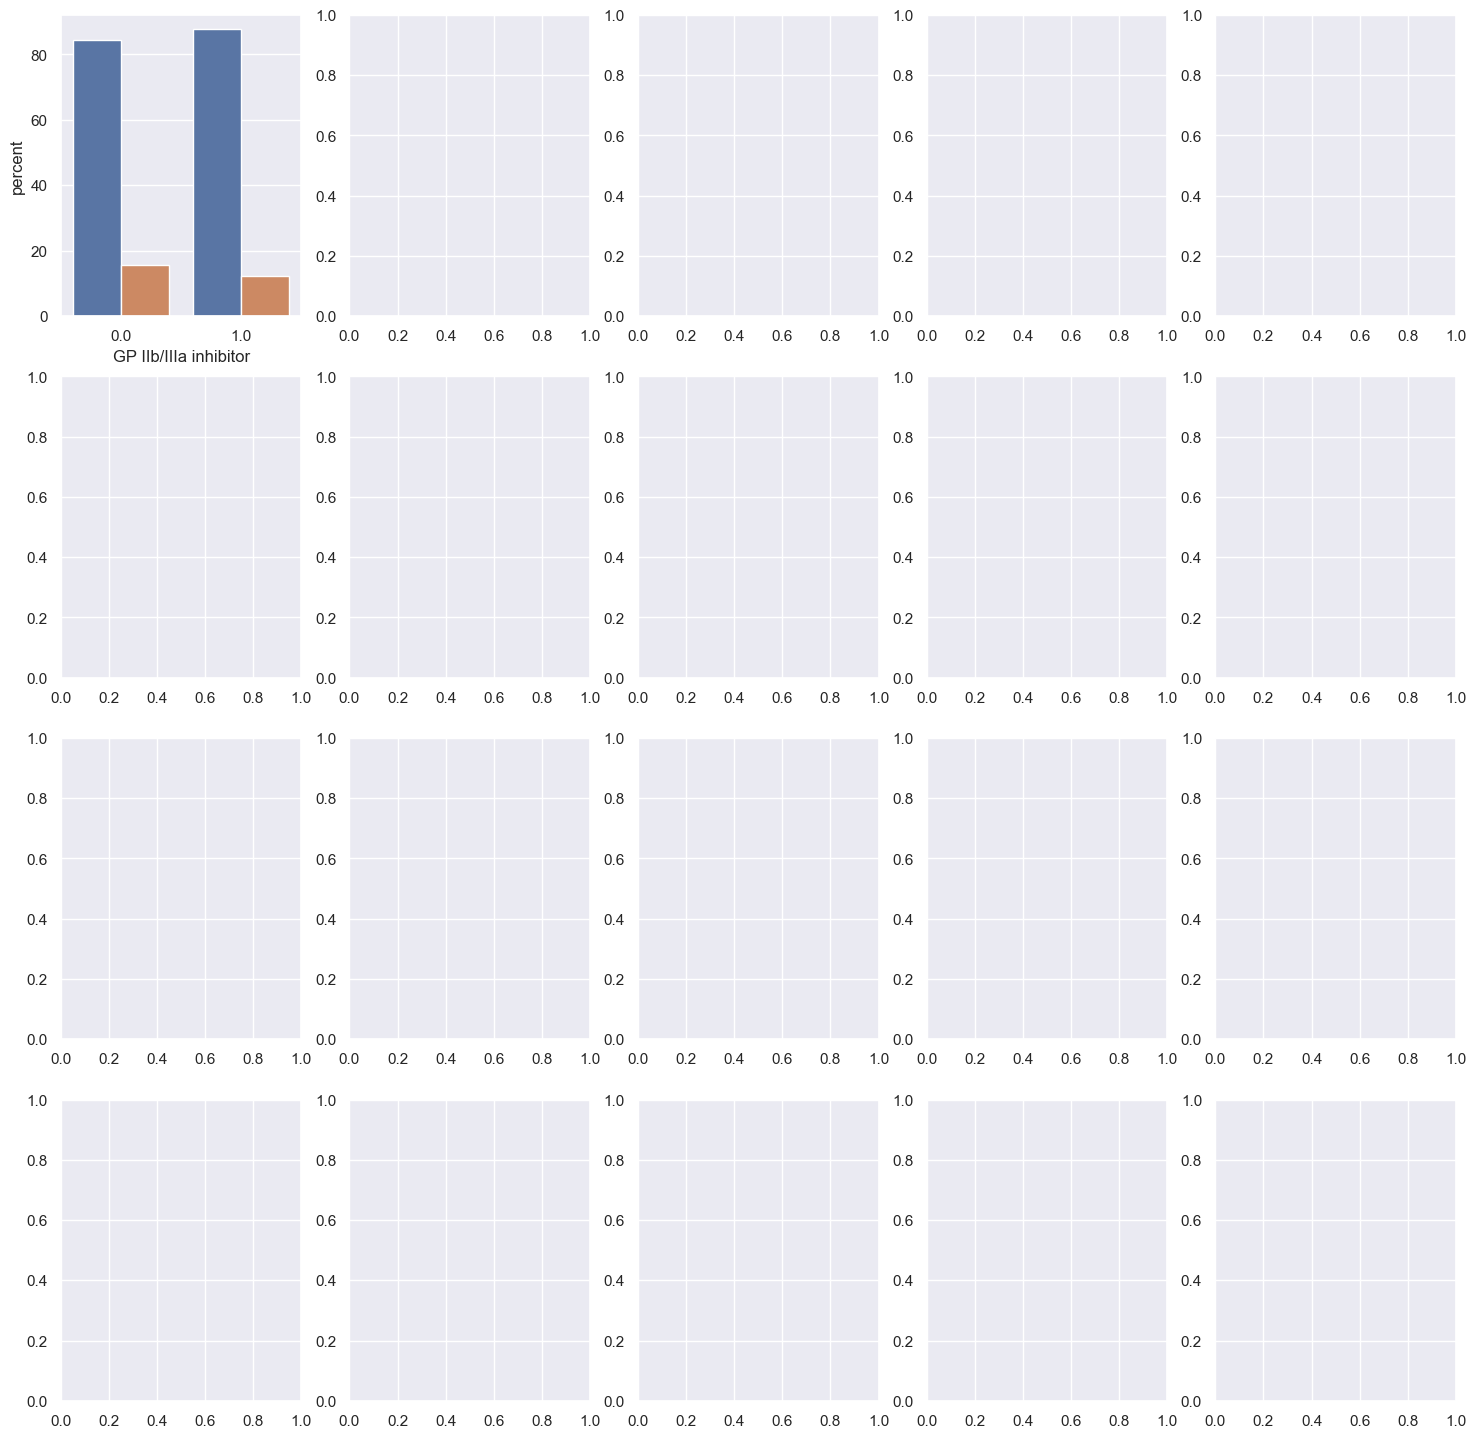

In [22]:
for pred in predictors:

    fig, axes = plt.subplots(4, 5, figsize=(18, 18))
    i = 0
    for c in categorical_col:
        x,y = c, pred
        df1 = df.groupby(x)[y].value_counts(normalize=True)
        df1 = df1.mul(100)
        df1 = df1.rename('percent').reset_index()

        g = sns.barplot(x=x,y='percent',hue=y,data=df1,ax=axes[int(i/5), i%5])
        g.set_ylim(0,100)

        for p in g.patches:
            txt = str(p.get_height().round(2)) + '%'
            txt_x = p.get_x() 
            txt_y = p.get_height()
            g.text(txt_x,txt_y,txt)
        i+=1


Possible significant features for `lvef_abnormal`
- Coded Culprit Vessel
- TIMI Flow post
- Coded Treatment
- Number of stent
- CTO in remote vessel
- Pre-hospital Arrest
- Inotrope during case
- Arrythmia during case
- IABP/ECMO

Possible significant features for `In-hospital Mortality` and `ICU Admission`
- Female
- Smoking History
- Diabetes
- Family History
- Coded Culprit Vessel
- TIMI Flow Pre
- TIMI Flow post
- Rentrop Simplified
- Number of stent
- CTO in remote vessel
- Pre-hospital Arrest
- Inotrope during case
- Arrythmia during case
- IABP/ECMO

Possible significant features for `lvef_abnormal`
- Female
- Smoking History
- Diabetes
- Family History
- Coded Culprit Vessel
- TIMI Flow Pre
- TIMI Flow post
- Rentrop Simplified
- Number of stent
- CTO in remote vessel
- Pre-hospital Arrest
- Inotrope during case
- Arrythmia during case
- IABP/ECMO


### train test split

In [24]:
scoring_method = 'roc_auc'
cv_result_filename = "result/outcome_1year.csv"
test_result_filename = "result/test_result_1year.csv"

# Model Building

In [25]:
def train_model(X,y,y_name,model,model_name,
                impute=True,
                scale=True,
                oversample=False,
                feature_select=None,
                categorical_features=None,
               score_method='accuracy'):
    pipeline_steps = []
    
    if impute:
        pipeline_steps.append( ('imputer',SimpleImputer(missing_values=np.nan, strategy='median')))
        
    if scale:
        pipeline_steps.append(  ('scaler',StandardScaler()))
    
    if oversample:
        cat_col_index = [i for i, x in enumerate(X.columns) if x in df_dummy_cat_cols]
        pipeline_steps.append(("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)))
        model_name += '_oversample'
            
    if feature_select is not None:
         pipeline_steps.append(("feature_select",feature_select))
        
    
    pipeline_steps.append(  ('model',model))
    
    pipe = Pipeline(steps = pipeline_steps)
    
    cv_result = cross_validate(pipe, X, y, cv=5,scoring=scoring)
    
    results = [{k : v.mean() for k, v in cv_result.items()}]
    

    df_cv_result = pd.DataFrame(results, index=[model_name])
    df_cv_result["outcome"] = y_name
    df_cv_result["model"] = model_name

    
    pipe.fit(X,y)
    joblib.dump(pipe,"model/" + model_name + "_" + y_name +".pickle")
    
    
    return pipe,df_cv_result

In [26]:
def plot_coef(model,model_name,columns):
    
    if "feature_select" in model.named_steps:
        feature_select = model.named_steps["feature_select"].support_
        columns = columns[feature_select]
        
    coefs = model.named_steps["model"].coef_
    coef_df = pd.DataFrame(data = {'variable' : columns,
                          'value' : coefs[0],
                           'mag':   coefs[0]    })

    coef_df = coef_df.sort_values('mag', ascending=False)
    plt.figure(figsize=(18, 18))
    ax = sns.barplot(
        data=coef_df, x="variable", y="mag")
    ax.set_title("Coefficient for " + p)
    plt.setp(ax.get_xticklabels(), rotation=90)

    plt.savefig("figure/" + model_name + "_" +p+".png",bbox_inches="tight")
    return ax

## Baseline model
No feature selection

In [29]:
#score_df = pd.read_csv("result/outcome.csv",index_col=0)
score_df = pd.read_csv(cv_result_filename,index_col=0)
test_df = pd.read_csv(test_result_filename,index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'result/outcome_1year.csv'

In [27]:
y_train = df_dummy.loc[train[p],p]

In [30]:
 df_dummy.iloc[train[p]].drop(predictors, axis=1).head()
    

Age  Height  Weight        BMI  No. of stent  Starting HR  \
267   76.364134   162.0    80.0  30.483158           1.0        109.0   
1631  47.550992   167.0    65.0  23.000000           1.0         57.0   
434   84.854209   178.0   130.0  41.000000           1.0         67.0   
1401  58.151951   170.0    70.0  24.000000           1.0         67.0   
928   57.092402   183.0   130.0  39.000000           1.0         74.0   

      Starting SBP  LVEF FINAL  log_length_stent  log_onset_to_angio  ...  \
267          114.0        25.0          3.332205            1.098612  ...   
1631         191.0        30.0          2.890372                 NaN  ...   
434          126.0        42.5          3.496508            3.044522  ...   
1401         103.0        55.0          3.091042            1.410987  ...   
928          157.0        35.0          3.332205            0.847298  ...   

      Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)_2.0  \
267                                               False                     
1631                                              False                     
434                                               False                     
1401                                              False                     
928                                               False                     

      Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)_3.0  \
267                                               False                     
1631                                              False                     
434                                               False                     
1401                                              False                     
928                                               False                     

      Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)_4.0  \
267                                               False                     
1631                                              False                     
434                                               False                     
1401                                              False                     
928                                               False                     

      CTO in remote vessel_1.0  Pre-Hospital Arrest_1.0  \
267                      False                    False   
1631                     False                    False   
434                      False                    False   
1401                     False                    False   
928                       True                    False   

      GP IIb/IIIa inhibitor_1.0  Inotrope during case_1.0  \
267                       False                     False   
1631                       True                     False   
434                       False                     False   
1401                       True                     False   
928                        True                     False   

      Arrhythmia during case_1.0  IABP/ECMO_1.0  lvef_abnormal_1.0  
267                        False          False               True  
1631                       False          False               True  
434                        False          False              False  
1401                       False          False              False  
928                        False          False               True  

[5 rows x 37 columns]

In [30]:
model_name = 'lr_baseline'
for p in predictors:
    y_train = df_dummy.loc[train[p],p]
    X_train = df_dummy.iloc[train[p]].drop(predictors, axis=1)
    
    model = LogisticRegression(penalty = None,max_iter = 10000)
    pipe,df_cv_result = train_model(X_train,y_train,p,model,model_name,score_method=scoring_method)
     
    score_df = pd.concat([score_df,df_cv_result],ignore_index=True)


In [31]:
for p in predictors:
    y_test = df_dummy.loc[train[p],p]
    X_test = df_dummy.iloc[train[p]].drop(predictors, axis=1)
    test_result_df = evaluate_model(pipe,X_test,y_test)
    test_result_df["outcome"] = p
    test_result_df["model"] = model_name
    
    test_df = pd.concat([test_df,test_result_df],ignore_index=True)

In [32]:
X_train.columns

Index(['Age', 'Height', 'Weight', 'BMI', 'No. of stent', 'Starting HR',
       'Starting SBP', 'LVEF FINAL', 'log_length_stent', 'log_onset_to_angio',
       'Sex (0 = Male, 1=Female)_1.0', 'Hypertension_1.0',
       'Hypercholesterolaemia_1.0',
       'Smoking History( 2= current, 1 = ex smoke, 0 = never)_1.0',
       'Smoking History( 2= current, 1 = ex smoke, 0 = never)_2.0',
       'Diabetes_1.0', 'Family History_1.0', 'Previous stent_1.0',
       'Coded Cuplrit Vessel (RCA = 1, LCx = 2, LAD = 3)_2.0',
       'Coded Cuplrit Vessel (RCA = 1, LCx = 2, LAD = 3)_3.0',
       'TIMI flow pre_1.0', 'TIMI flow pre_2.0', 'TIMI flow pre_3.0',
       'TIMI Flow post_1.0', 'TIMI Flow post_2.0', 'TIMI Flow post_3.0',
       'Rentrop Simplified_1.0',
       'Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)_2.0',
       'Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)_3.0',
       'Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)_4.0',
       'CTO in 

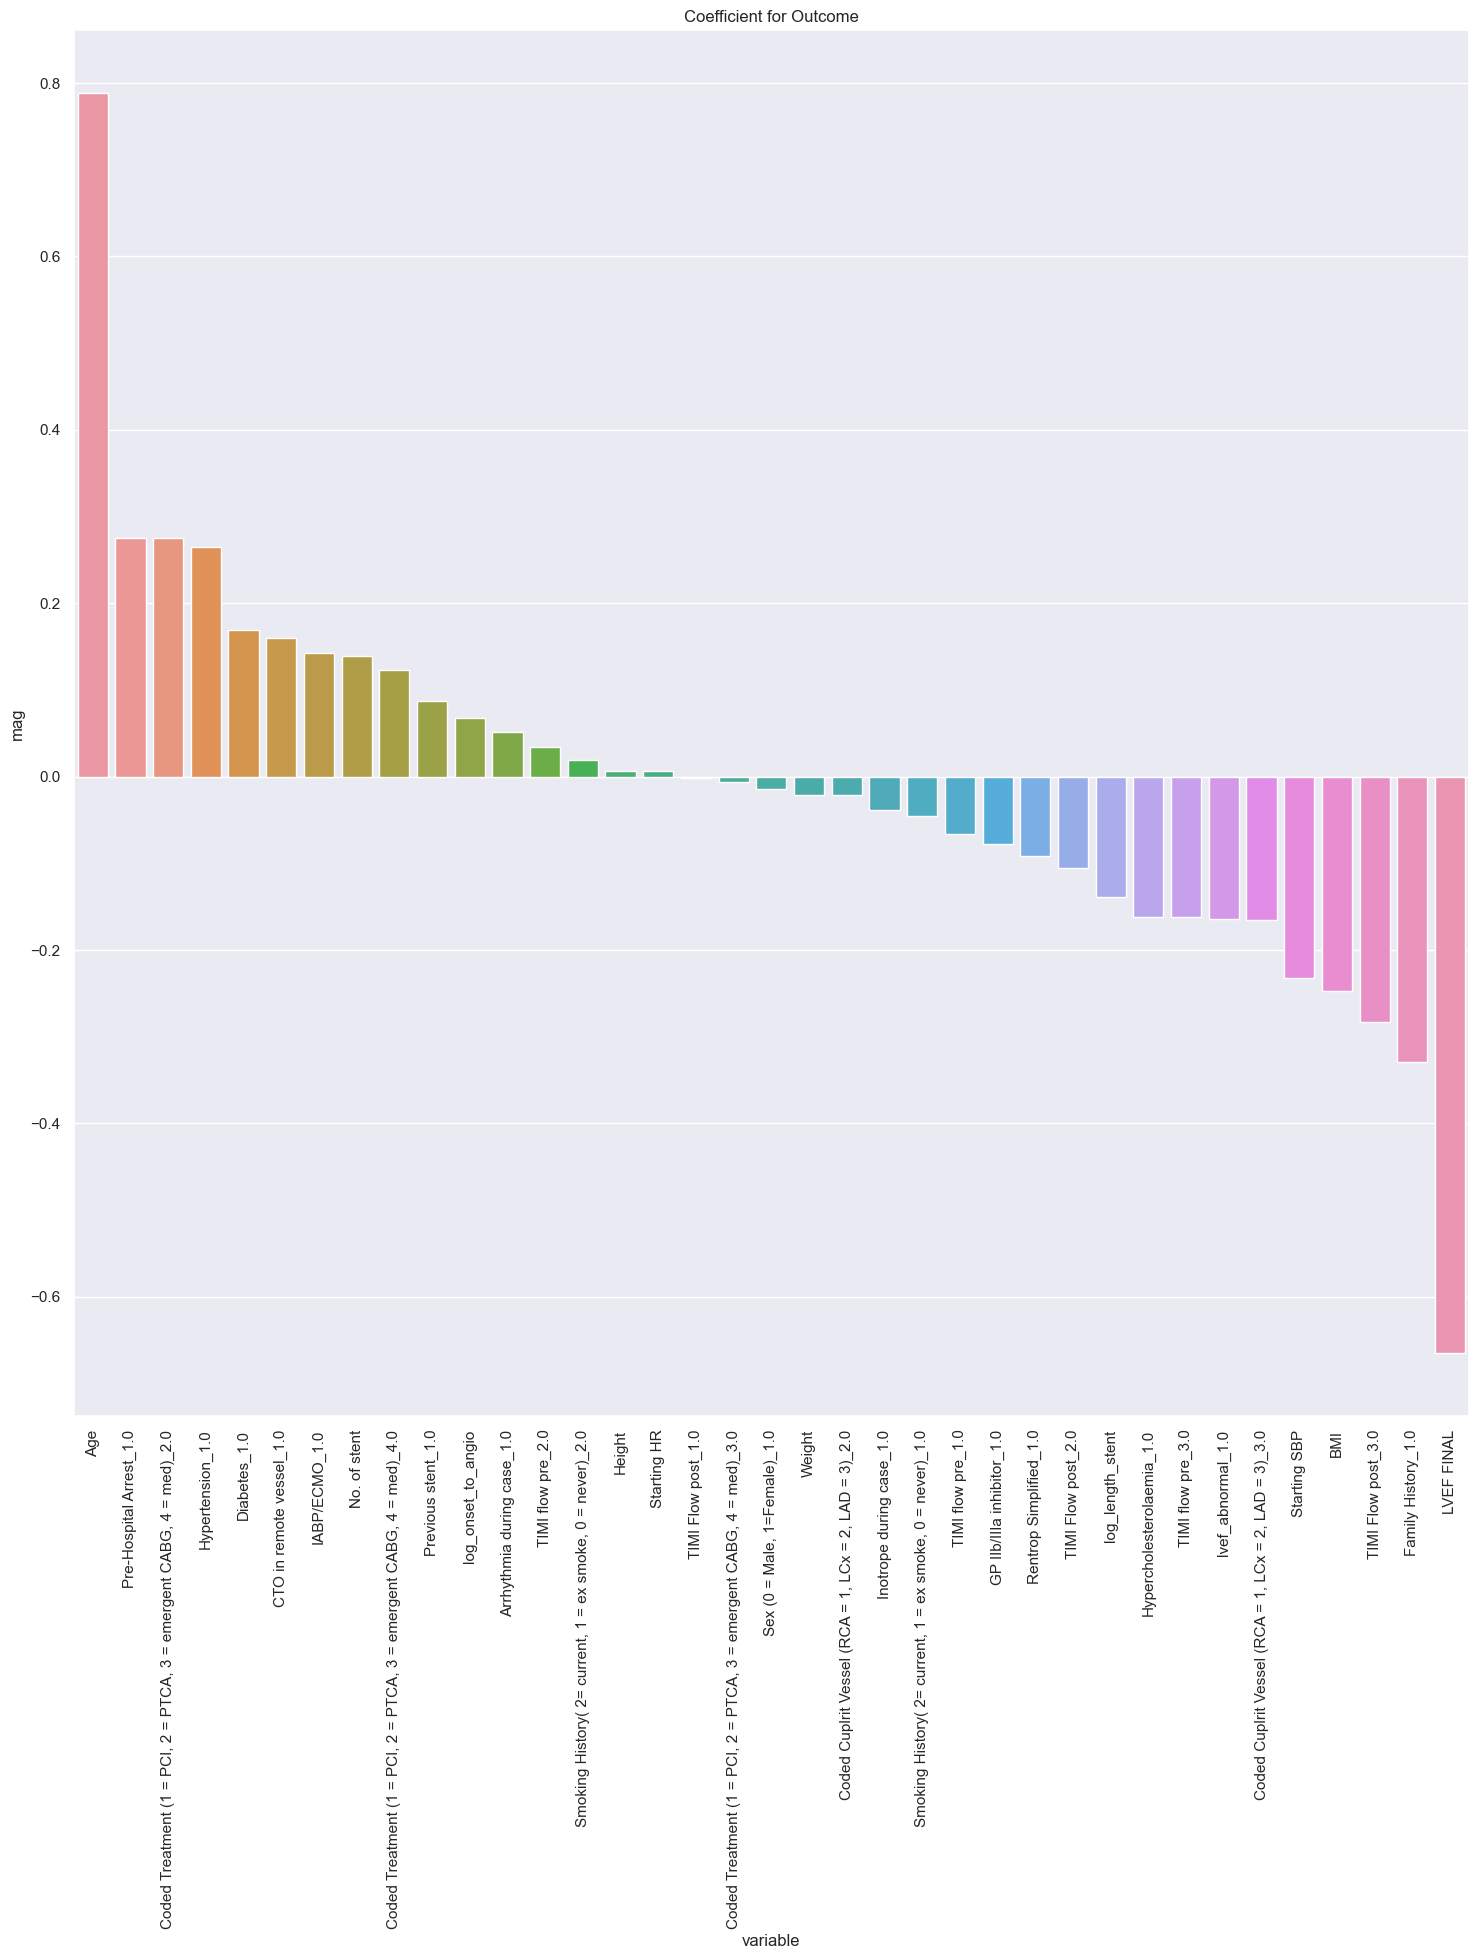

In [35]:
for p in predictors:
    pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
    ax = plot_coef(pipe,model_name,X_train.columns)

In [34]:
score_df.to_csv(cv_result_filename)
test_df.to_csv(test_result_filename)

## l1 regression

In [37]:

pre_train_model = LogisticRegression(random_state=random_seed,max_iter = 5000,penalty = 'l1',n_jobs=1,solver = 'saga')
param_grid = {
    "logistic__C": np.logspace(1e-5,1e1,num=50)
}

for p in predictors:
    for use_oversample in [False,True]:
        y_train = df_dummy.loc[train[p],p]
        X_train = df_dummy.iloc[train[p]].drop(predictors, axis=1)
        model_name = 'l1_baseline'    
        cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]
        if use_oversample:
            pre_train_pipeline = [
                    ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
                    ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
                    ("scaler", StandardScaler()), 
                    ("logistic", pre_train_model)
                ]
            model_name += "_oversample"
        else:
             pre_train_pipeline = [
                ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
                ("scaler", StandardScaler()), 
                ("logistic", pre_train_model)
            ]

        pipeline = Pipeline(steps=pre_train_pipeline)

        grid = GridSearchCV(pipeline,
                        param_grid = param_grid,cv=10,scoring=scoring_method)


        grid.fit(X_train, y_train)
        joblib.dump(grid.best_estimator_,"model/" + model_name + "_"+p+".pickle")



## Logistic regression with feature selection

In [38]:
score_df = pd.read_csv(cv_result_filename,index_col=0)
test_df = pd.read_csv(test_result_filename,index_col=0)

In [39]:
n_features = [5,10,15,20,25,30]

In [40]:
for n in n_features:
    model_name = "logistic_feature_selection"
    model_name += str(n)
    for p in predictors:
        y_train = df_dummy.loc[train[p],p]
        X_train = df_dummy.iloc[train[p]].drop(predictors, axis=1)

        model = LogisticRegression(penalty = None,max_iter = 10000)
        feature_select_model =  SequentialFeatureSelector(LogisticRegression(max_iter = 1000,penalty = None),
                                       n_features_to_select=n,scoring=scoring_method)
        pipe,df_cv_result = train_model(
                                X_train,
                                y_train,
                                p,
                                model,
                                model_name,
                                feature_select=feature_select_model,
                                score_method=scoring_method,
                                oversample=True)


        score_df = pd.concat([score_df,df_cv_result],ignore_index=True)

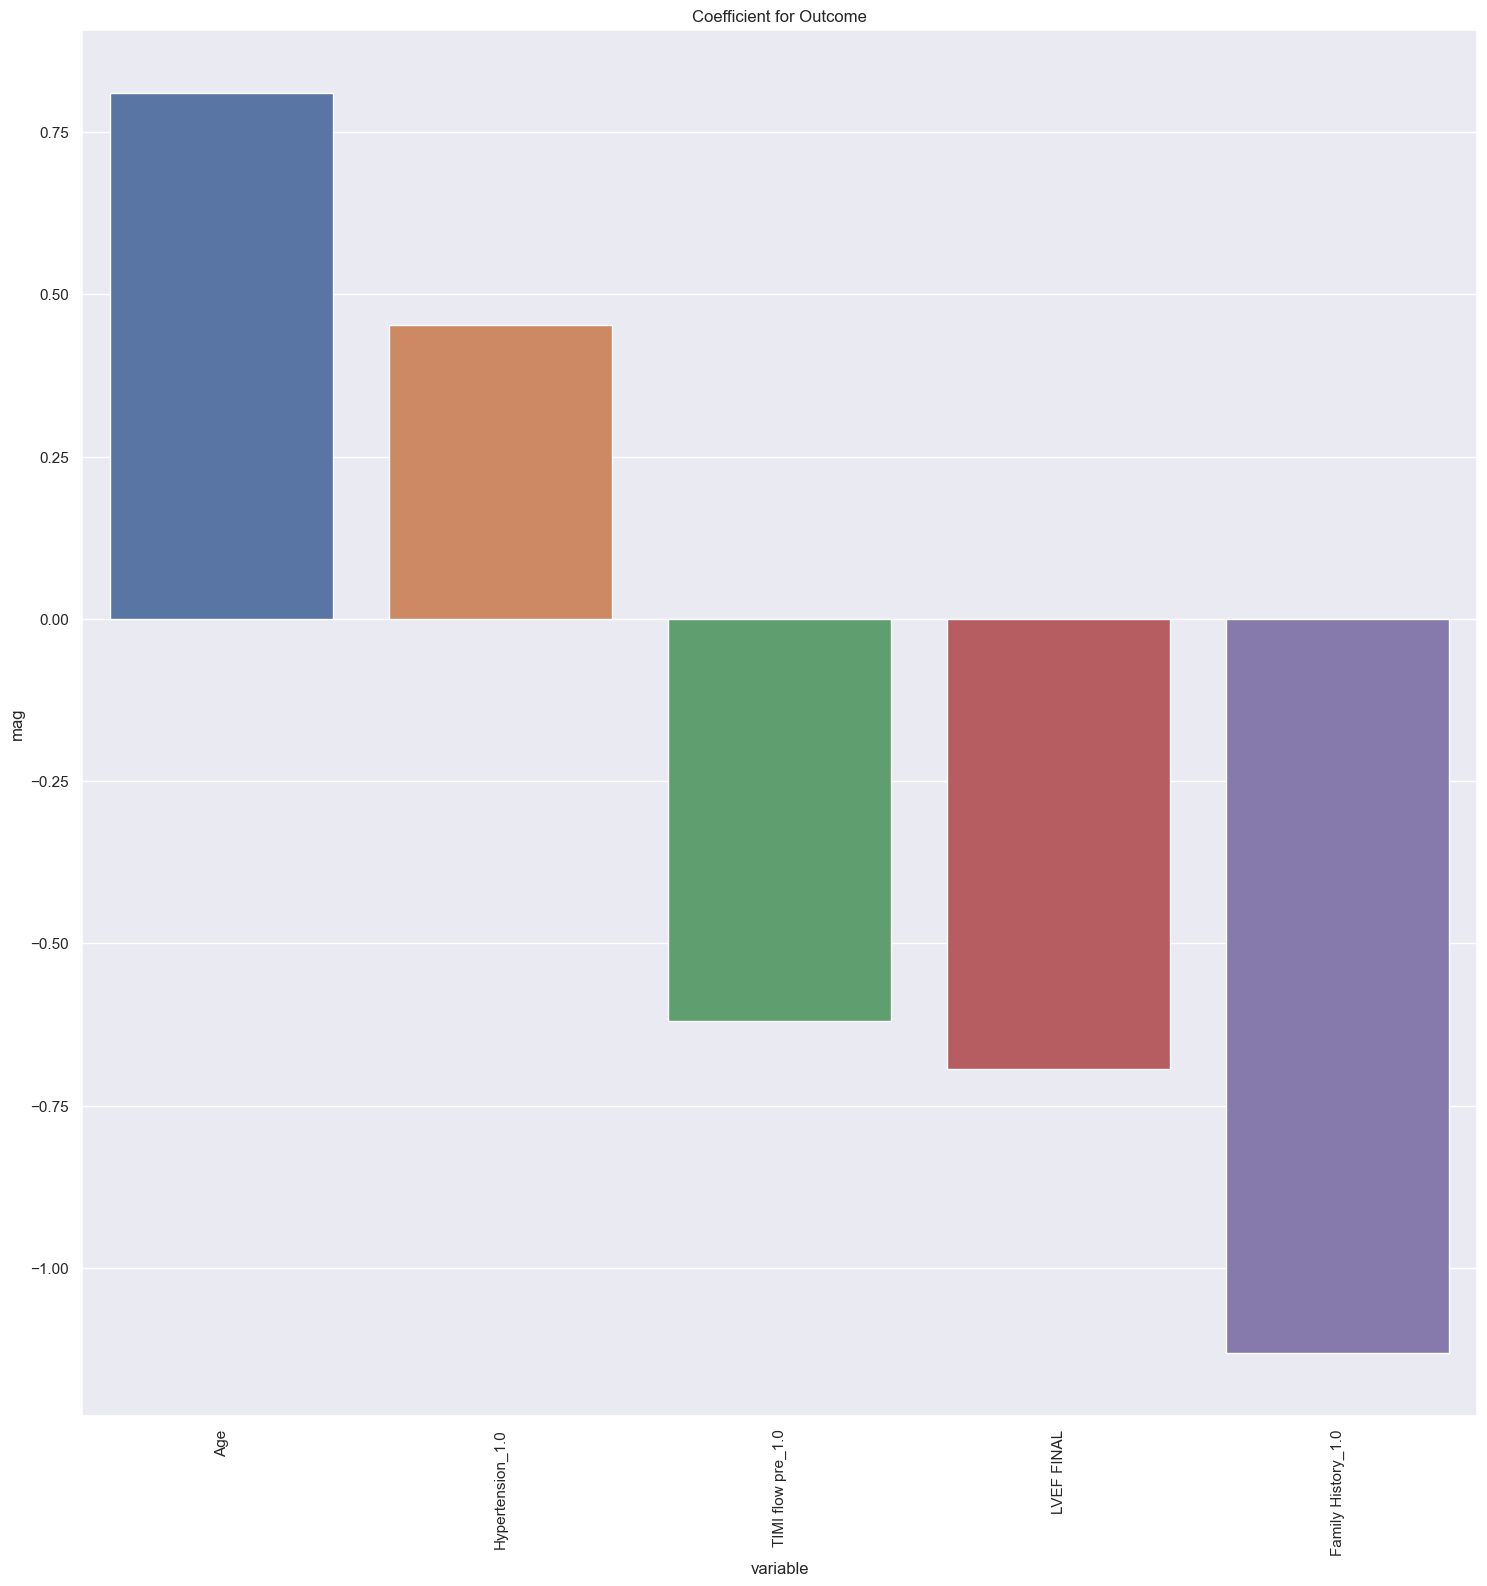

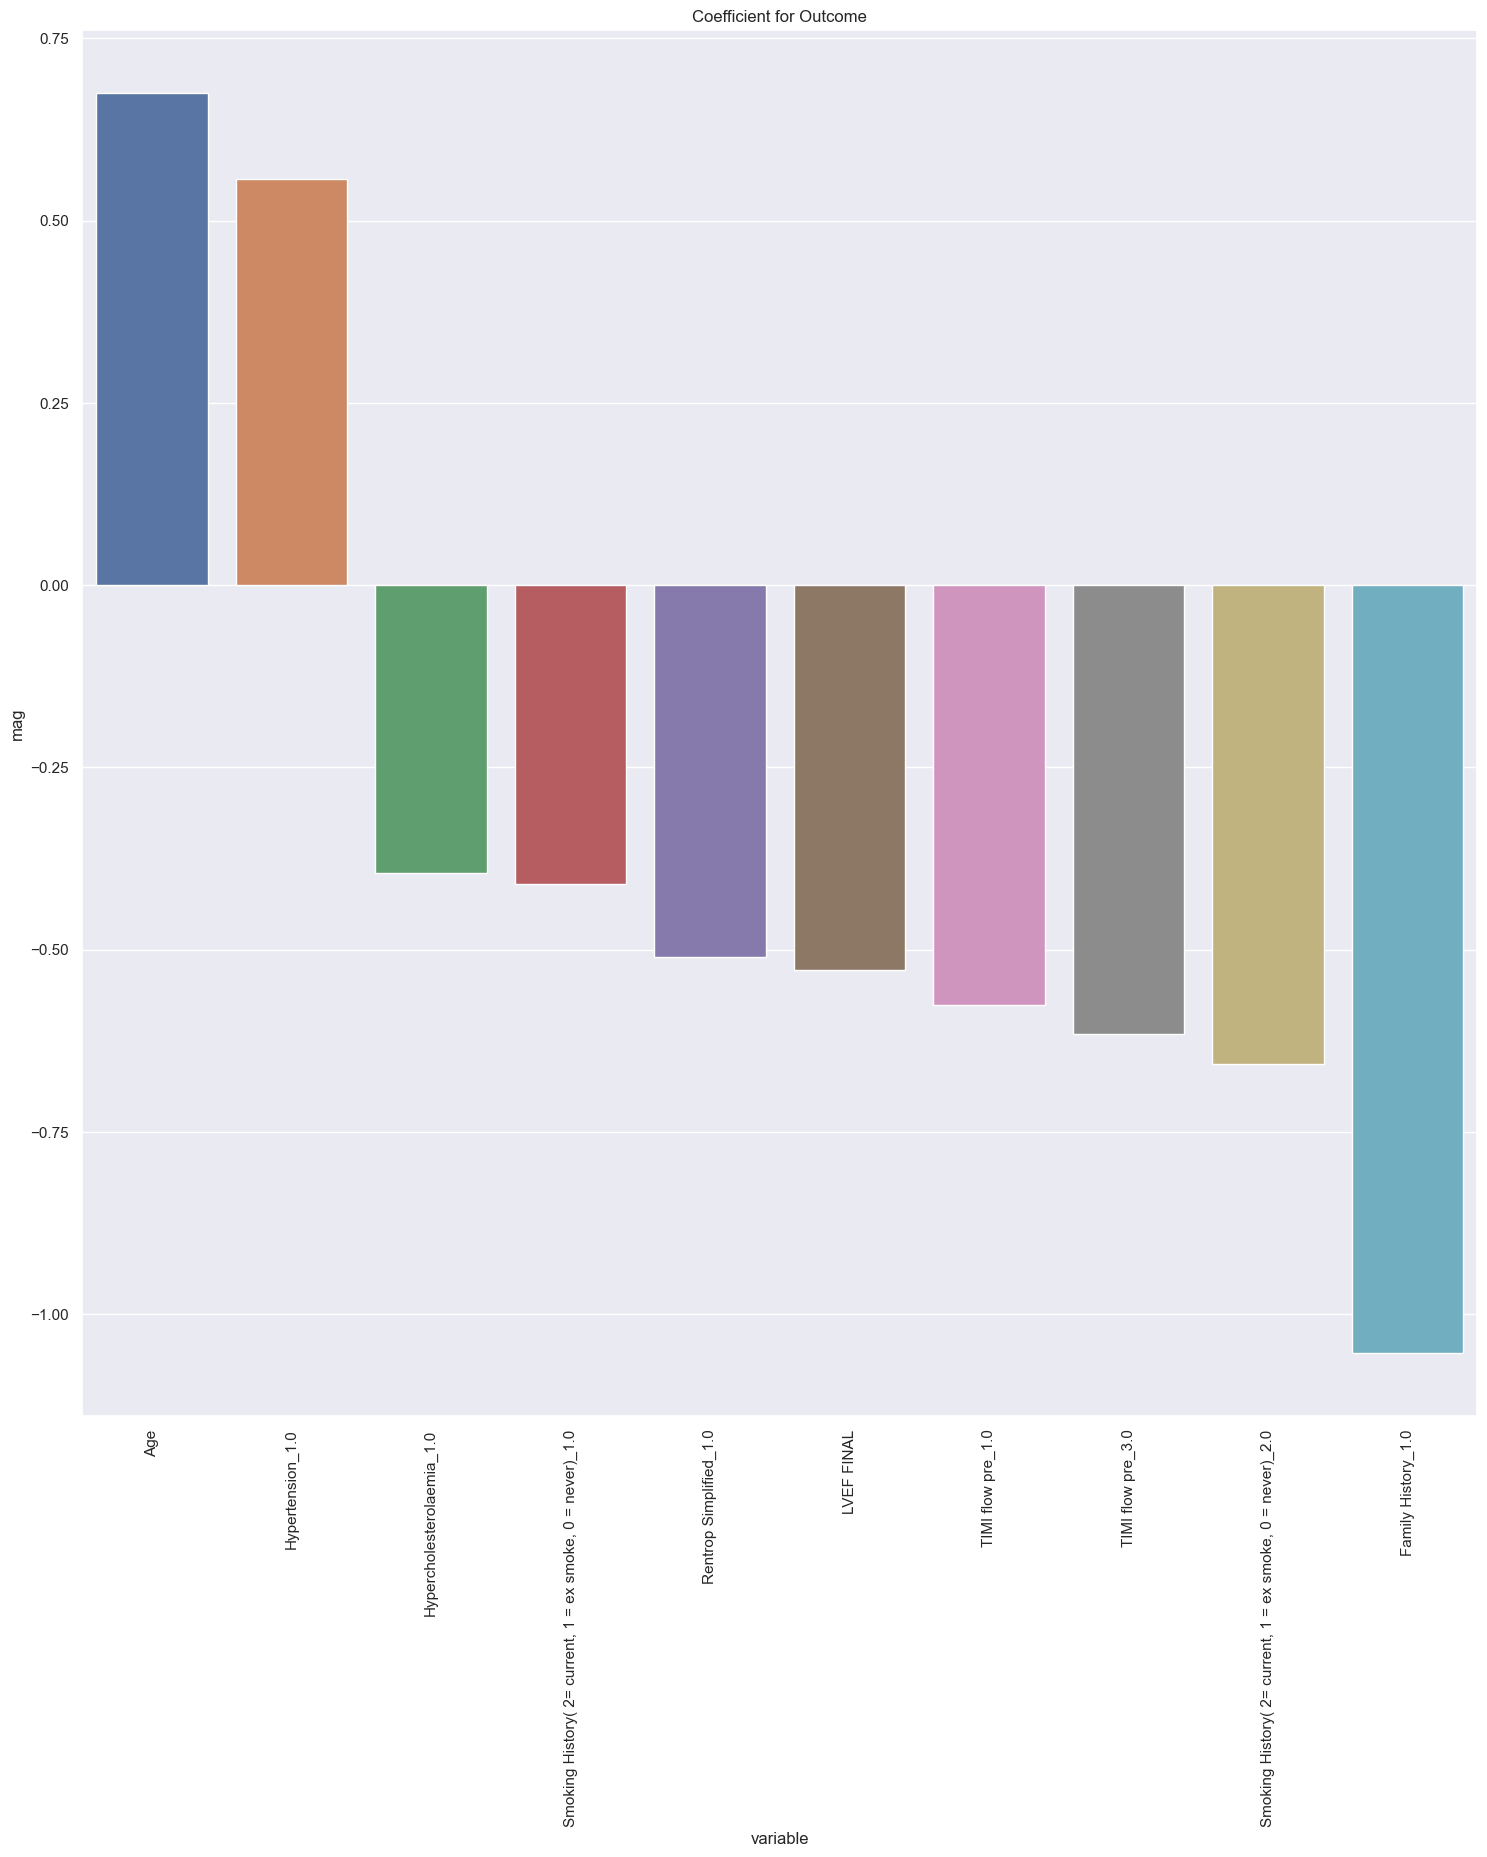

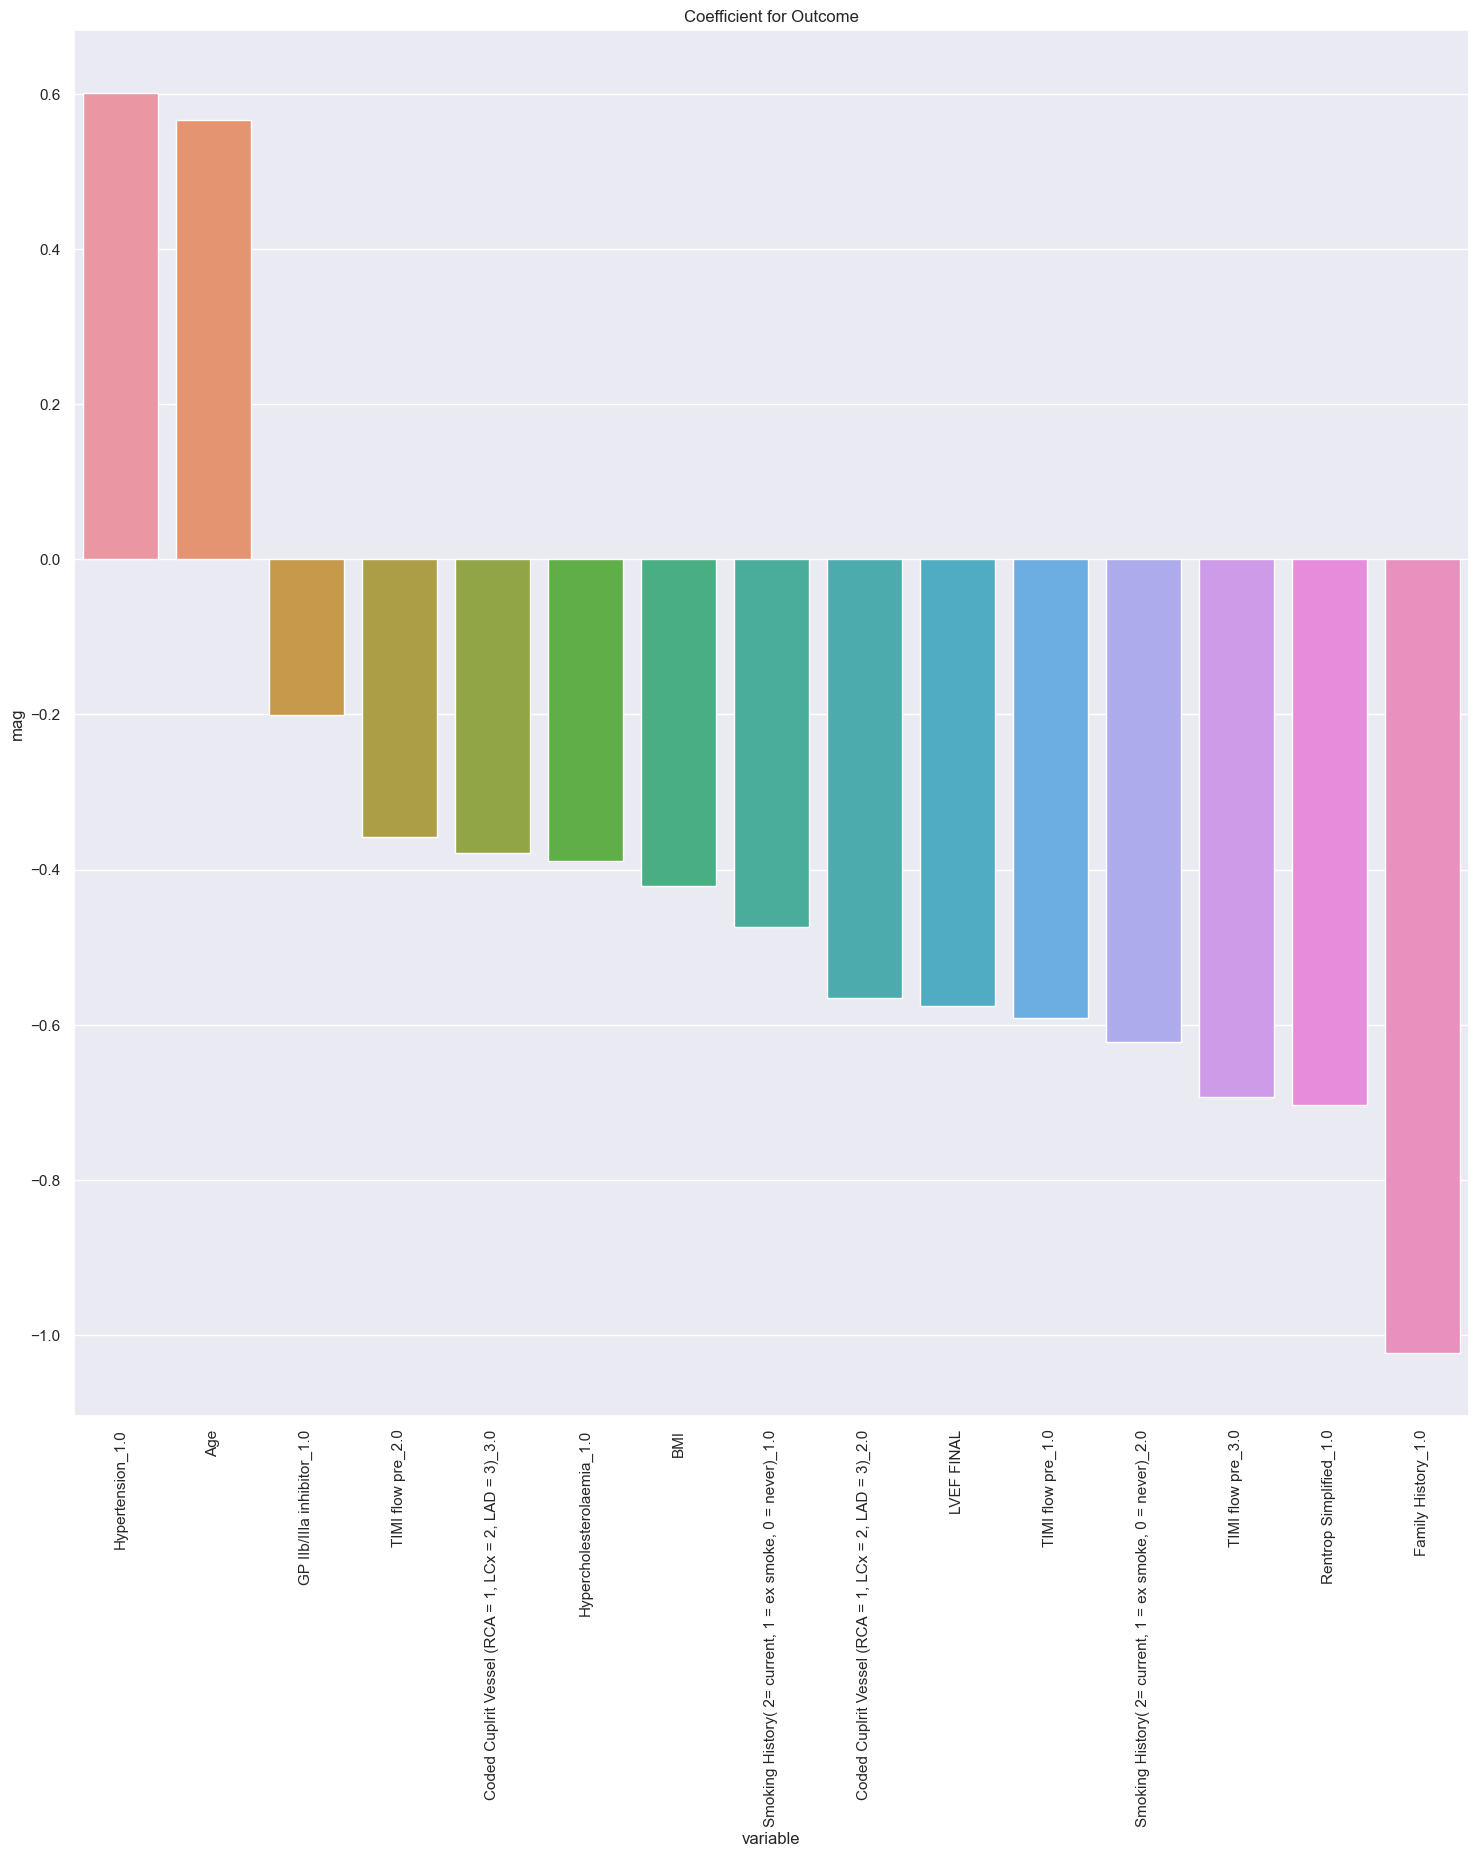

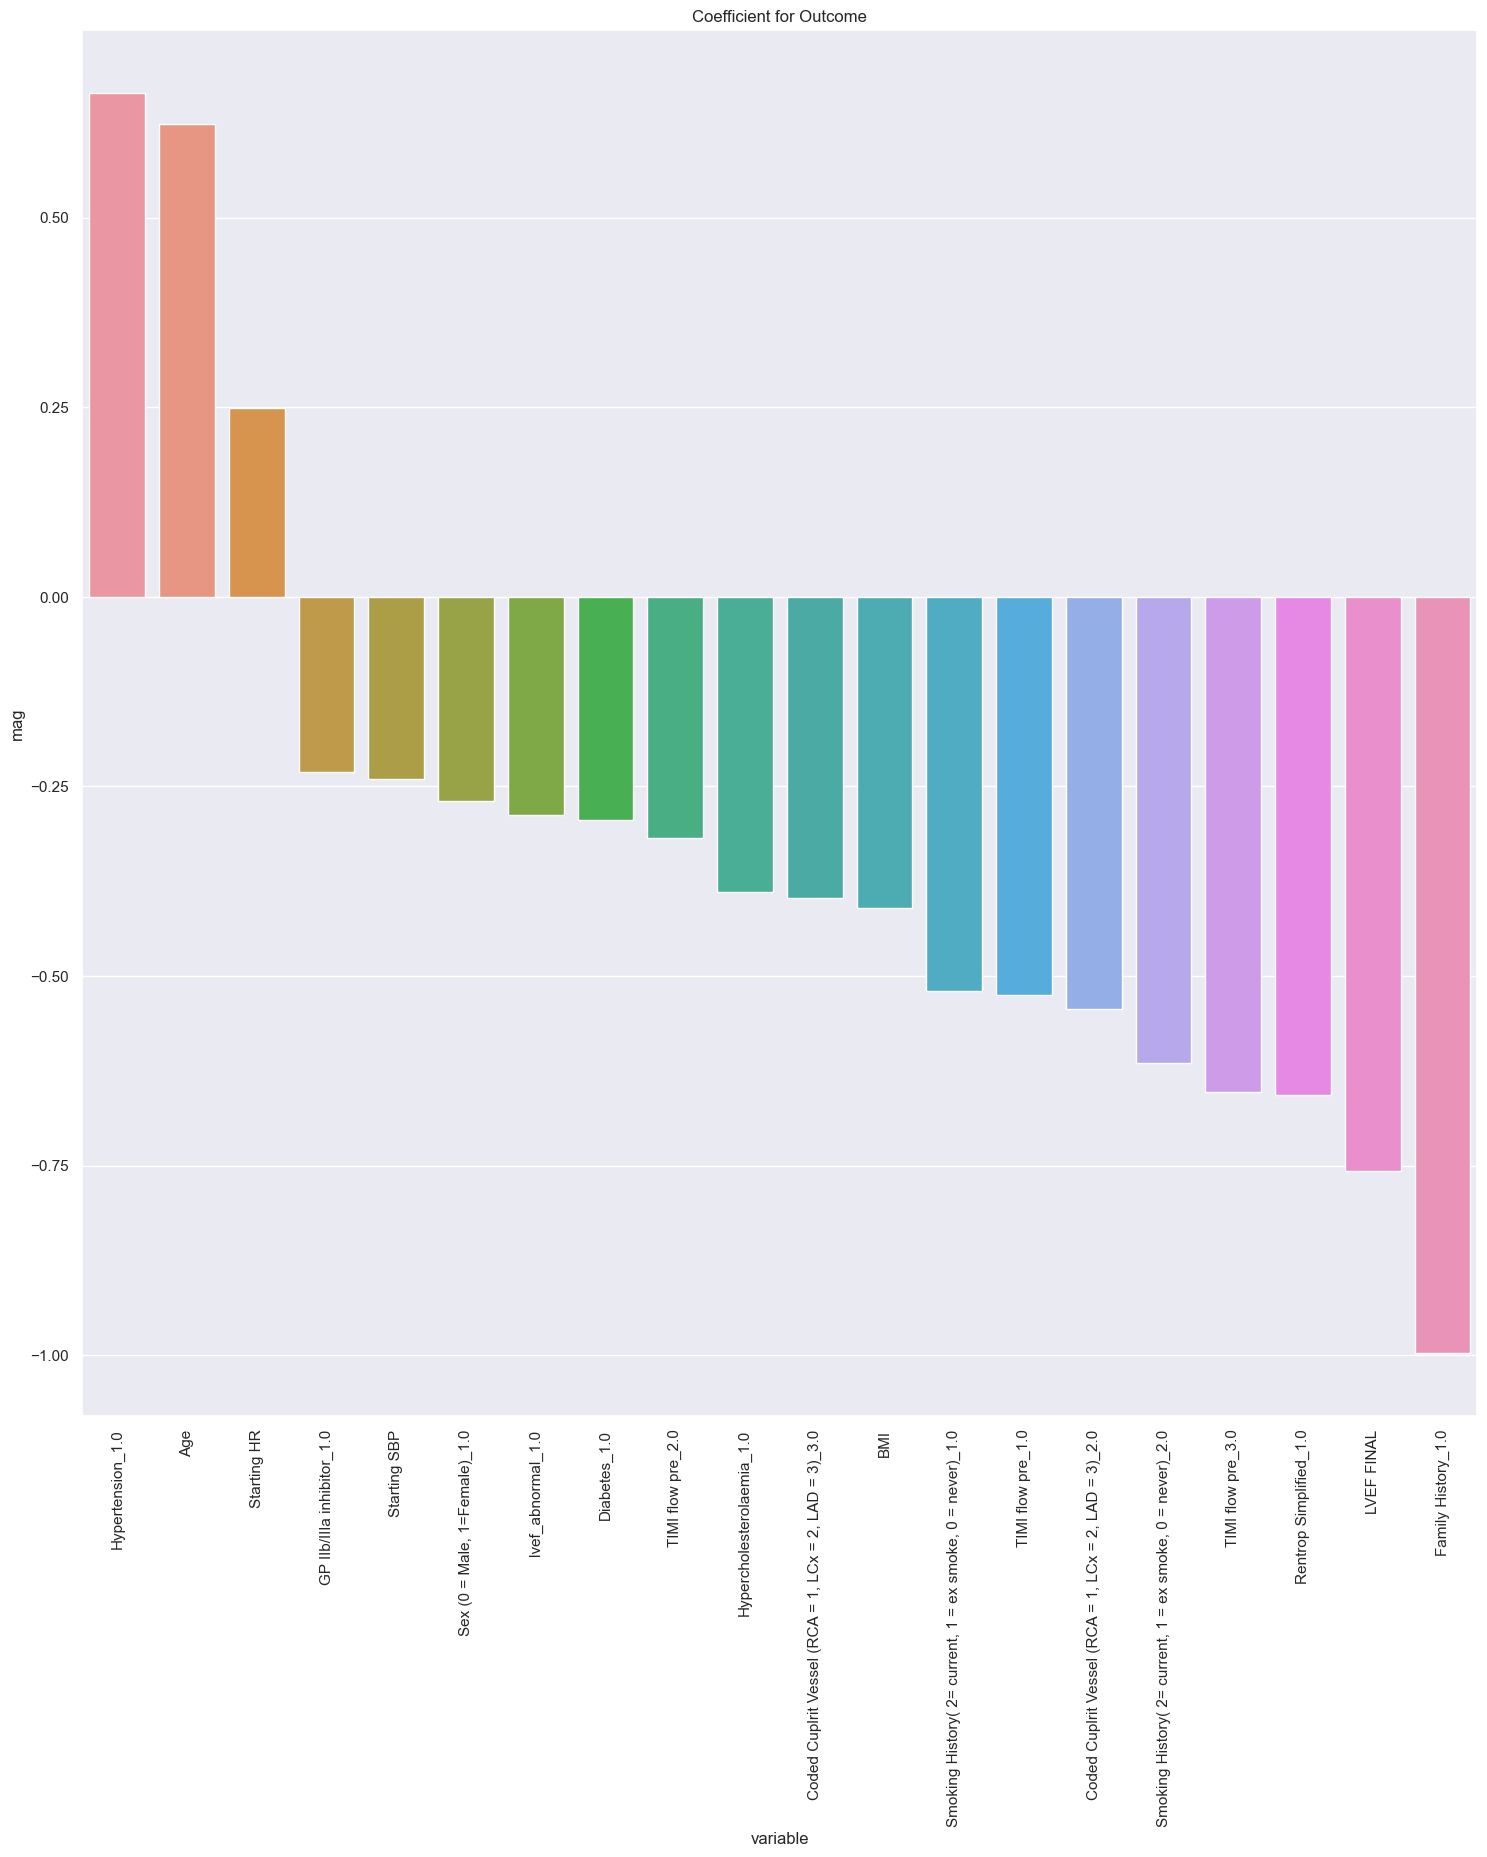

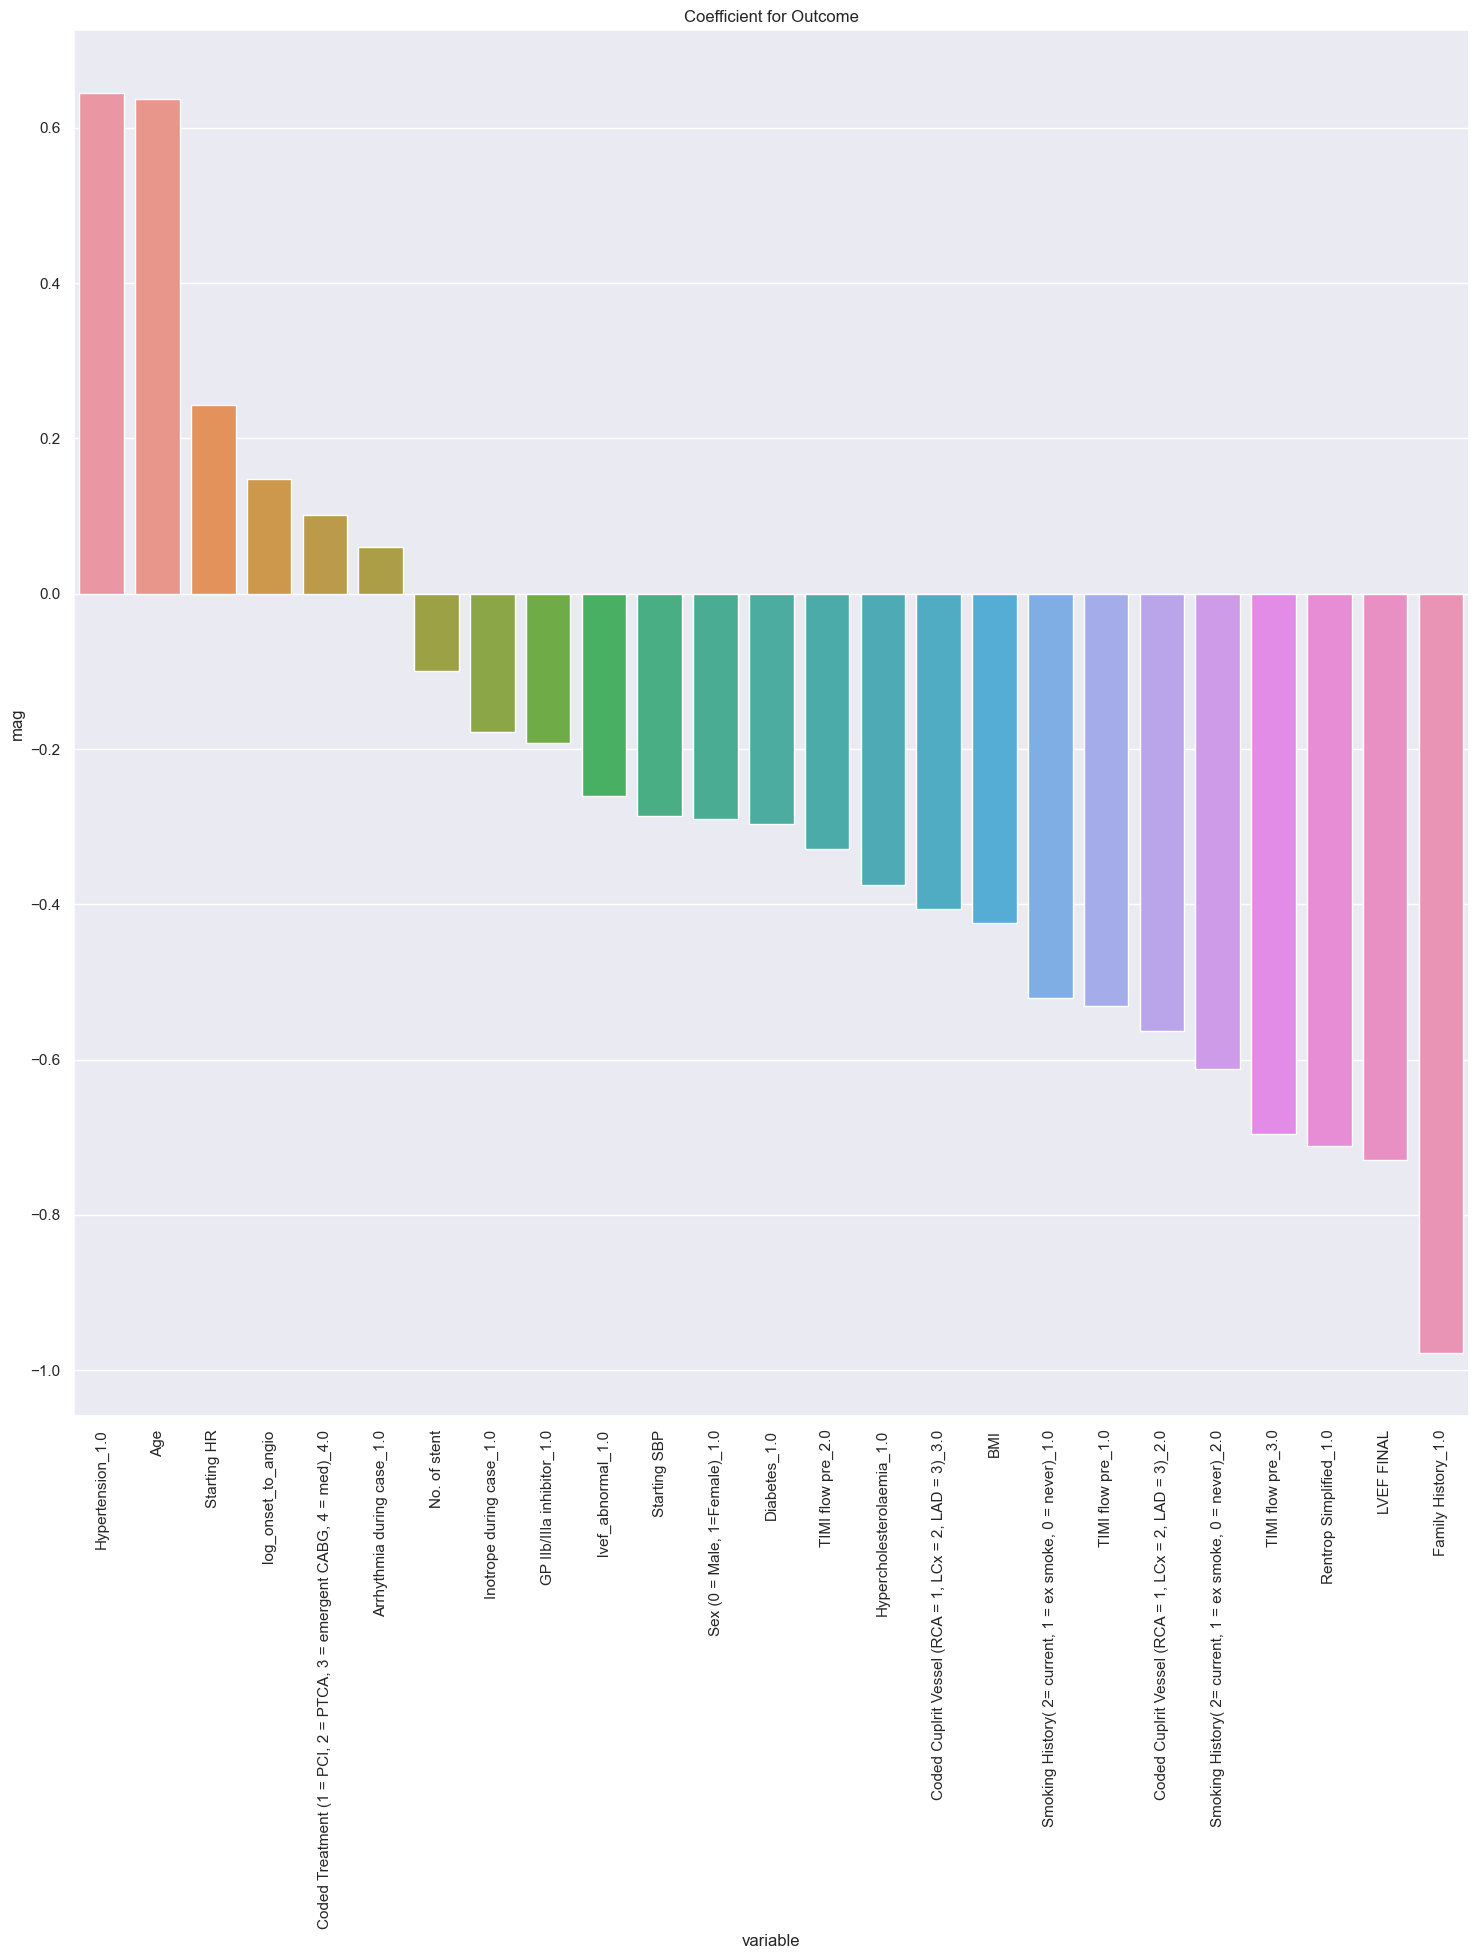

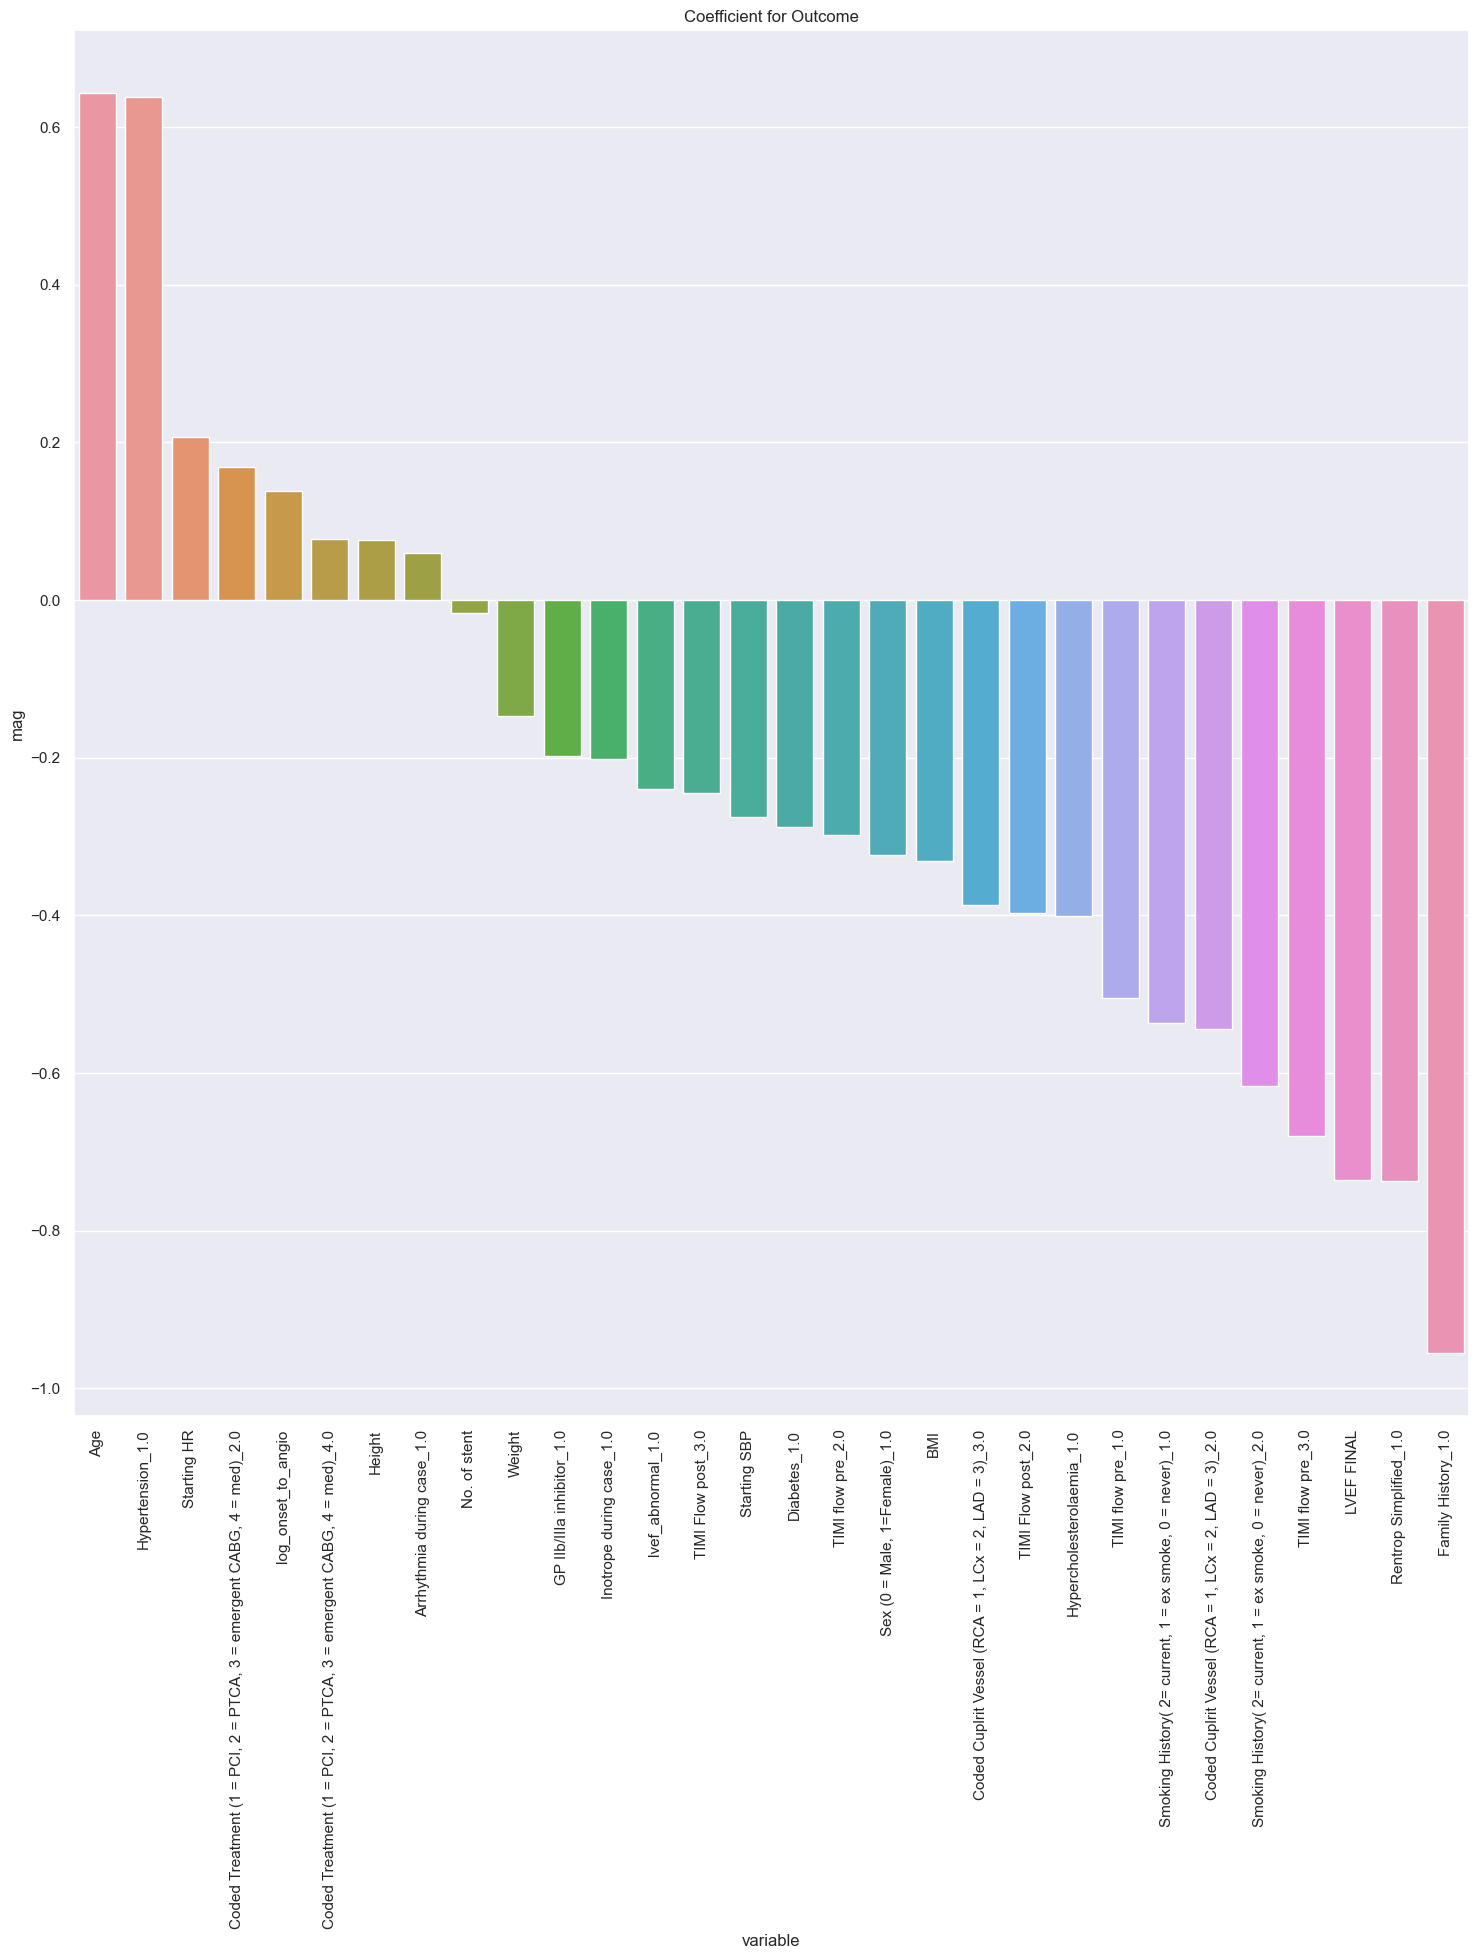

In [41]:
for n in n_features:
    model_name = "logistic_feature_selection"
    model_name += str(n)
    model_name+= '_oversample'
    for p in predictors:
        pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
        ax = plot_coef(pipe,model_name,X_train.columns)

In [42]:
for n in n_features:
    model_name = "logistic_feature_selection"
    model_name += str(n)
    model_name+= '_oversample'
    for p in predictors:
        y_test = df_dummy.loc[test[p],p]
        X_test = df_dummy.iloc[test[p]].drop(predictors, axis=1)
        pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
        test_result_df = evaluate_model(pipe,X_test,y_test)
        test_result_df["outcome"] = p
        test_result_df["model"] = model_name

        test_df = pd.concat([test_df,test_result_df],ignore_index=True)

In [43]:
score_df.to_csv(cv_result_filename )
test_df.to_csv(test_result_filename)

## L2 logistic regression

In [44]:
score_df = pd.read_csv(cv_result_filename ,index_col=0)
test_df = pd.read_csv(test_result_filename,index_col=0)

In [45]:
model_type = 'l1'
use_oversample = True

In [48]:
for model_type in ['l1','l2','elasticnet']:
    for n in n_features:
        for use_oversample in [False,True]:

            for p in predictors:
                print(model_type + " " + str(use_oversample) + " " + p + " " + str(n))
                start_time = timeit.default_timer()

                if model_type == 'l1':
                    pre_train_model = LogisticRegression(random_state=random_seed,max_iter = 5000,penalty = 'l1',n_jobs=1,solver = 'saga')
                    model_name = "l1_feature_selection_1year" + str(n)
                    param_grid = {
                        "logistic__C": np.logspace(1e-3,1,num=10)
                    }
                elif model_type == 'l2':
                    pre_train_model = LogisticRegression(random_state=random_seed,max_iter = 1000,penalty = 'l2',n_jobs=1,solver = 'lbfgs')
                    model_name = "l2_feature_selection_1year" + str(n)
                    param_grid = {
                        "logistic__C": np.logspace(1e-3,1,num=10)
                    }
                elif model_type == 'elasticnet':
                    pre_train_model = LogisticRegression(random_state=random_seed,max_iter = 5000,penalty='elasticnet',solver='saga') 
                    model_name = "elasticnet_feature_selection_1year" + str(n)

                    param_grid = {
                        "logistic__C": np.linspace(1e-3,1,num=15),
                        "logistic__l1_ratio": np.linspace(1e-1,1,num=5)
                    }

                y_train = df_dummy.loc[train[p],p]
                X_train = df_dummy.iloc[train[p]].drop(predictors, axis=1)

                cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]

                if use_oversample:
                    pre_train_pipeline = [
                        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
                        ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
                        ("scaler", StandardScaler()), 
                        ("logistic", pre_train_model)
                    ]
                    model_name += "_oversample"
                else:
                     pre_train_pipeline = [
                        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
                        ("scaler", StandardScaler()), 
                        ("logistic", pre_train_model)
                    ]

                pipeline = Pipeline(steps=pre_train_pipeline)

                grid = GridSearchCV(pipeline,
                                param_grid = param_grid,cv=5,scoring=scoring_method)


                grid.fit(X_train, y_train)

                if model_type == 'l1':
                    model = LogisticRegression(max_iter = 1000,penalty = 'l1',C = grid.best_params_["logistic__C"],solver = 'saga')
                    feature_select_model =  SequentialFeatureSelector(LogisticRegression(max_iter = 1000,penalty = 'l1',
                                                                  C = grid.best_params_["logistic__C"],solver = 'saga'), 
                                               n_features_to_select=n,scoring=scoring_method)
                elif model_type == 'l2':
                    model = LogisticRegression(max_iter = 1000,penalty = 'l2',C = grid.best_params_["logistic__C"])
                    feature_select_model =   SequentialFeatureSelector(LogisticRegression(max_iter = 1000,penalty = 'l2',
                                                                  C = grid.best_params_["logistic__C"]), 
                                               n_features_to_select=n,scoring=scoring_method)
                elif model_type == 'elasticnet':
                    model = LogisticRegression(random_state=random_seed,
                                               max_iter = 5000,
                                               penalty='elasticnet',
                                               solver='saga', 
                                               C = grid.best_params_["logistic__C"],
                                              l1_ratio=grid.best_params_["logistic__l1_ratio"])
                    feature_select_model = SequentialFeatureSelector(
                         LogisticRegression(
                             random_state=random_seed,
                             max_iter = 5000,
                             penalty='elasticnet',
                             solver='saga',
                             C = grid.best_params_["logistic__C"],
                            l1_ratio=grid.best_params_["logistic__l1_ratio"]), 
                         n_features_to_select=n,scoring=scoring_method)



                pipe,df_cv_result = train_model(
                                        X_train,
                                        y_train,
                                        p,
                                        model,
                                        model_name,
                                        feature_select=feature_select_model,
                                        score_method=scoring_method,
                                        oversample=use_oversample
                                    )


                score_df = pd.concat([score_df,df_cv_result],ignore_index=True)
                elapsed = timeit.default_timer() - start_time
                print("time taken: ",elapsed)

l1 False Outcome 5
time taken:  26.635093300021254
l1 True Outcome 5
time taken:  58.50734580005519
l1 False Outcome 10
time taken:  51.684705700026825
l1 True Outcome 10
time taken:  105.28497530007735
l1 False Outcome 15
time taken:  83.4017187000718
l1 True Outcome 15
time taken:  160.20652680005878
l1 False Outcome 20
time taken:  118.51095529994927
l1 True Outcome 20
time taken:  213.69153579999693
l1 False Outcome 25
time taken:  161.41573809995316
l1 True Outcome 25
time taken:  293.70195650006644
l1 False Outcome 30
time taken:  207.66466920007952
l1 True Outcome 30
time taken:  356.2231314999517
l2 False Outcome 5
time taken:  18.27896220004186
l2 True Outcome 5
time taken:  54.27730469999369
l2 False Outcome 10
time taken:  49.43704820005223
l2 True Outcome 10
time taken:  72.93398019997403
l2 False Outcome 15
time taken:  50.35538910003379
l2 True Outcome 15
time taken:  78.45149779994972
l2 False Outcome 20
time taken:  61.46352210000623
l2 True Outcome 20
time taken:  93.7

C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


time taken:  209.77384689997416
elasticnet False Outcome 10
time taken:  66.40245119994506
elasticnet True Outcome 10


C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

time taken:  281.22904200002085
elasticnet False Outcome 15
time taken:  89.95701399992686
elasticnet True Outcome 15


C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

time taken:  323.7364197000861
elasticnet False Outcome 20
time taken:  120.65824529994279
elasticnet True Outcome 20


C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

time taken:  359.90359559992794
elasticnet False Outcome 25
time taken:  143.20318199996836
elasticnet True Outcome 25


C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

time taken:  387.6731264999835
elasticnet False Outcome 30
time taken:  165.0131985999178
elasticnet True Outcome 30


C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

time taken:  391.38866479997523


In [49]:
score_df

model  test_accuracy  outcome  \
0                                   lr_baseline_1year       0.864430  Outcome   
1        logistic_feature_selection_1year5_oversample       0.714765  Outcome   
2       logistic_feature_selection_1year10_oversample       0.739597  Outcome   
3       logistic_feature_selection_1year15_oversample       0.759732  Outcome   
4       logistic_feature_selection_1year20_oversample       0.762416  Outcome   
5       logistic_feature_selection_1year25_oversample       0.769128  Outcome   
6       logistic_feature_selection_1year30_oversample       0.767114  Outcome   
7                         l1_feature_selection_1year5       0.865772  Outcome   
8   l1_feature_selection_1year5_oversample_oversample       0.715436  Outcome   
9                        l1_feature_selection_1year10       0.871141  Outcome   
10  l1_feature_selection_1year10_oversample_oversa...       0.739597  Outcome   
11                       l1_feature_selection_1year15       0.871812  Outcome   
12  l1_feature_selection_1year15_oversample_oversa...       0.759732  Outcome   
13                       l1_feature_selection_1year20       0.871812  Outcome   
14  l1_feature_selection_1year20_oversample_oversa...       0.764430  Outcome   
15                       l1_feature_selection_1year25       0.869128  Outcome   
16  l1_feature_selection_1year25_oversample_oversa...       0.767114  Outcome   
17                       l1_feature_selection_1year30       0.869128  Outcome   
18  l1_feature_selection_1year30_oversample_oversa...       0.769128  Outcome   
19                        l2_feature_selection_1year5       0.865101  Outcome   
20  l2_feature_selection_1year5_oversample_oversample       0.714765  Outcome   
21                       l2_feature_selection_1year10       0.869799  Outcome   
22  l2_feature_selection_1year10_oversample_oversa...       0.740268  Outcome   
23                       l2_feature_selection_1year15       0.872483  Outcome   
24  l2_feature_selection_1year15_oversample_oversa...       0.759732  Outcome   
25                       l2_feature_selection_1year20       0.870470  Outcome   
26  l2_feature_selection_1year20_oversample_oversa...       0.764430  Outcome   
27                       l2_feature_selection_1year25       0.871812  Outcome   
28  l2_feature_selection_1year25_oversample_oversa...       0.769128  Outcome   
29                       l2_feature_selection_1year30       0.867785  Outcome   
30  l2_feature_selection_1year30_oversample_oversa...       0.769128  Outcome   
31                elasticnet_feature_selection_1year5       0.871141  Outcome   
32  elasticnet_feature_selection_1year5_oversample...       0.724832  Outcome   
33               elasticnet_feature_selection_1year10       0.870470  Outcome   
34  elasticnet_feature_selection_1year10_oversampl...       0.746980  Outcome   
35               elasticnet_feature_selection_1year15       0.871812  Outcome   
36  elasticnet_feature_selection_1year15_oversampl...       0.756376  Outcome   
37               elasticnet_feature_selection_1year20       0.871812  Outcome   
38  elasticnet_feature_selection_1year20_oversampl...       0.755705  Outcome   
39               elasticnet_feature_selection_1year25       0.871141  Outcome   
40  elasticnet_feature_selection_1year25_oversampl...       0.756376  Outcome   
41               elasticnet_feature_selection_1year30       0.872483  Outcome   
42  elasticnet_feature_selection_1year30_oversampl...       0.756376  Outcome   

     fit_time  score_time  test_precision  test_recall   test_f1  test_roc_auc  
0    0.021798    0.010602        0.498016     0.212439  0.293611      0.807722  
1    3.762672    0.008953        0.269876     0.634024  0.377585      0.744483  
2    7.700252    0.009369        0.274770     0.565000  0.368390      0.741127  
3   11.019139    0.009043        0.280459     0.500122  0.357846      0.741193  
4   13.246704    0.008944        0.281699     0.490732  0.355187      0.742233

C:\Users\harri\AppData\Local\Temp\ipykernel_33788\3185216317.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 18))


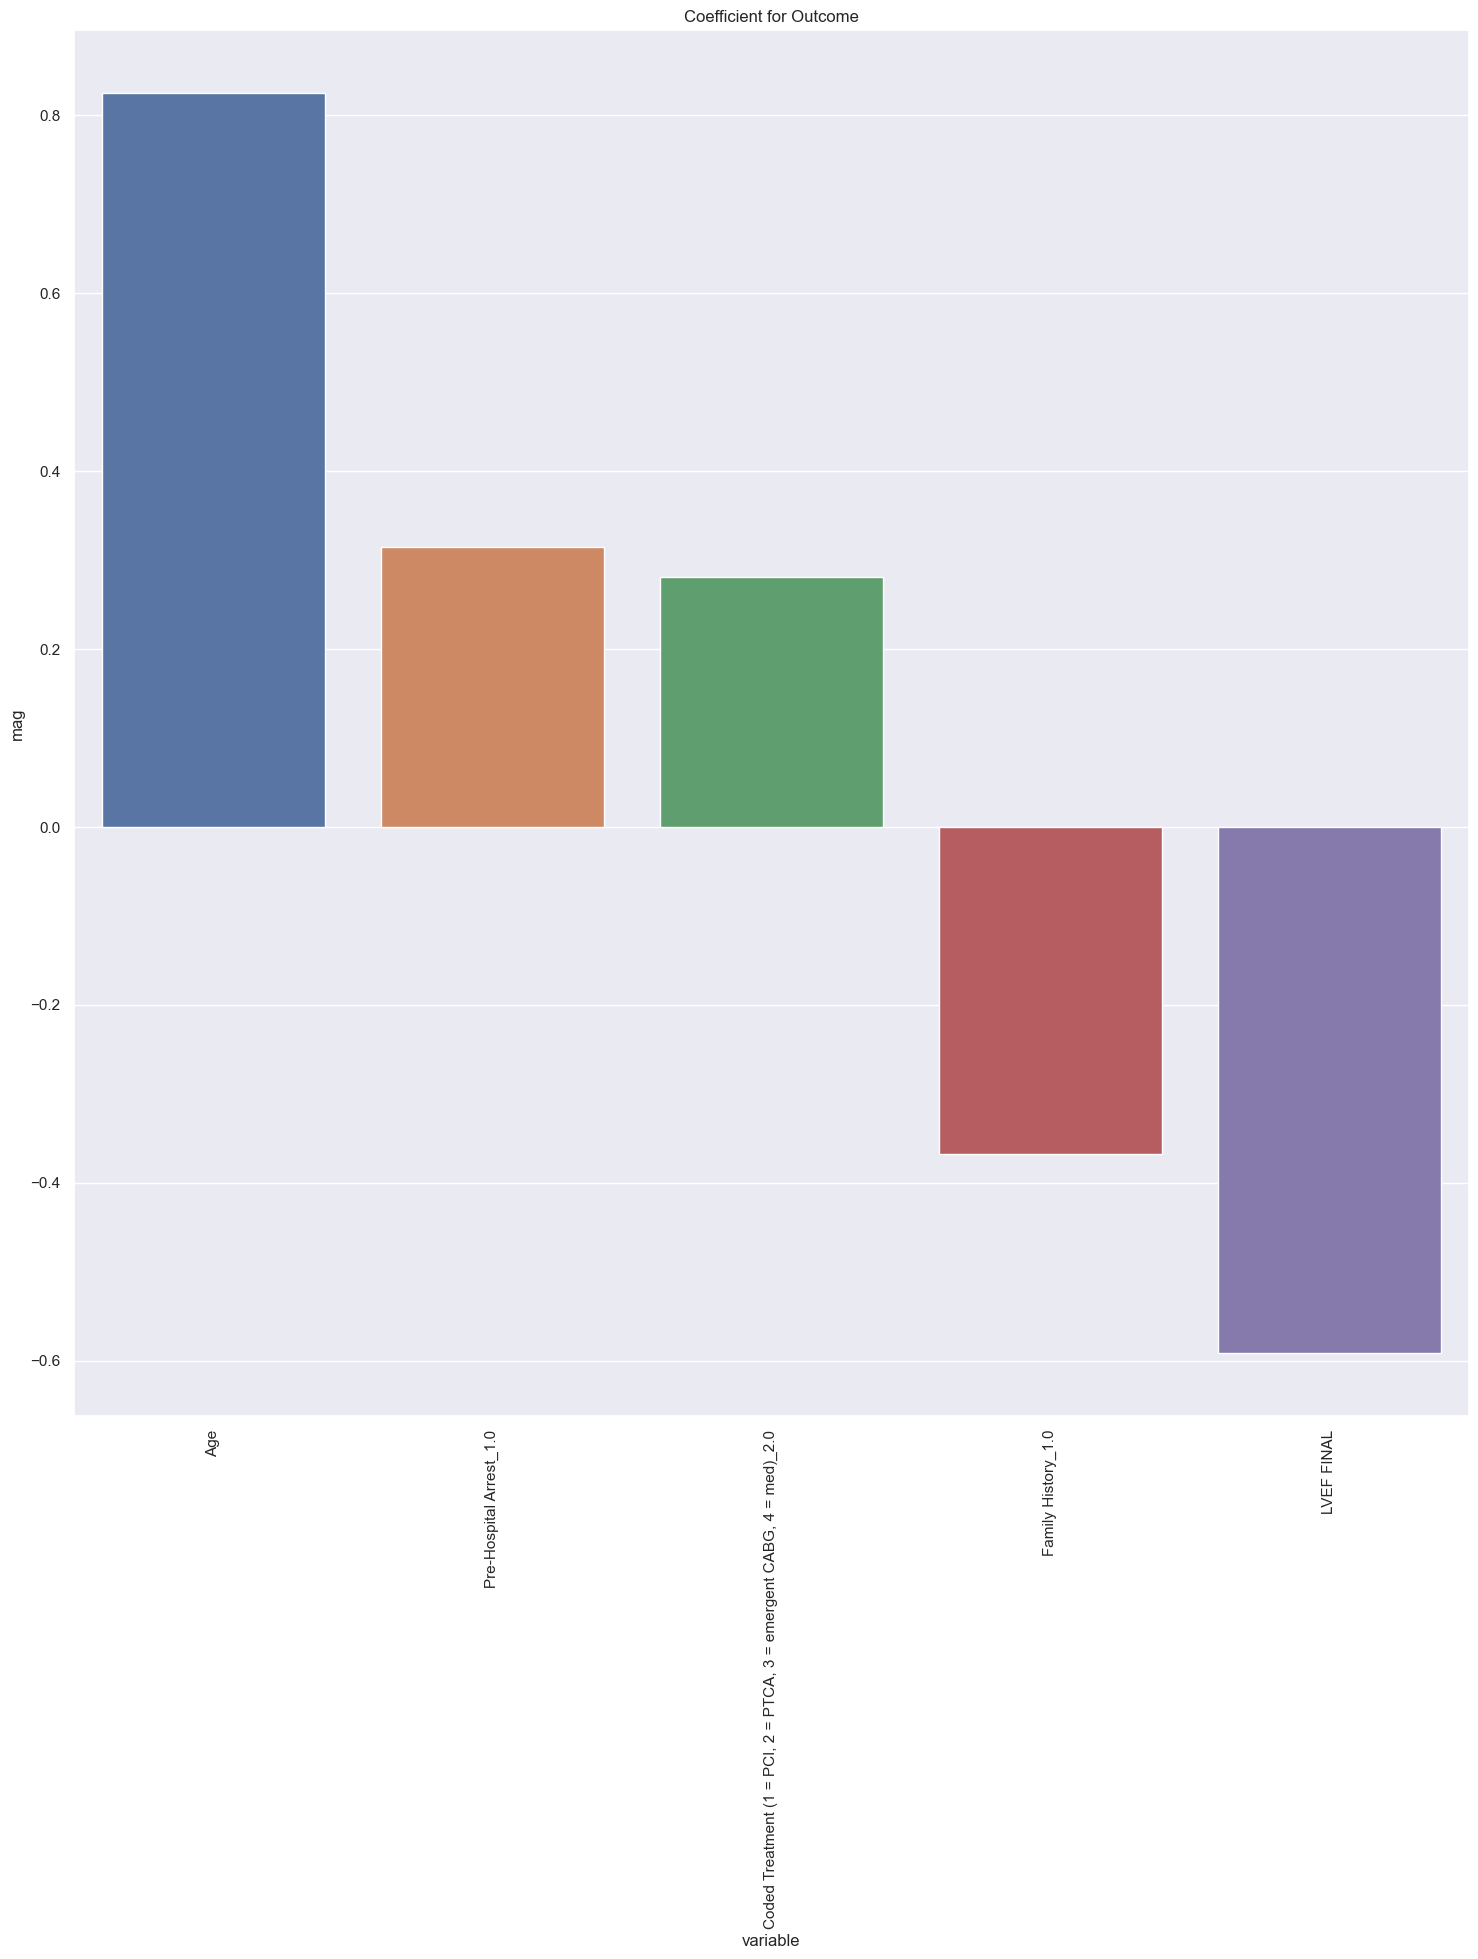

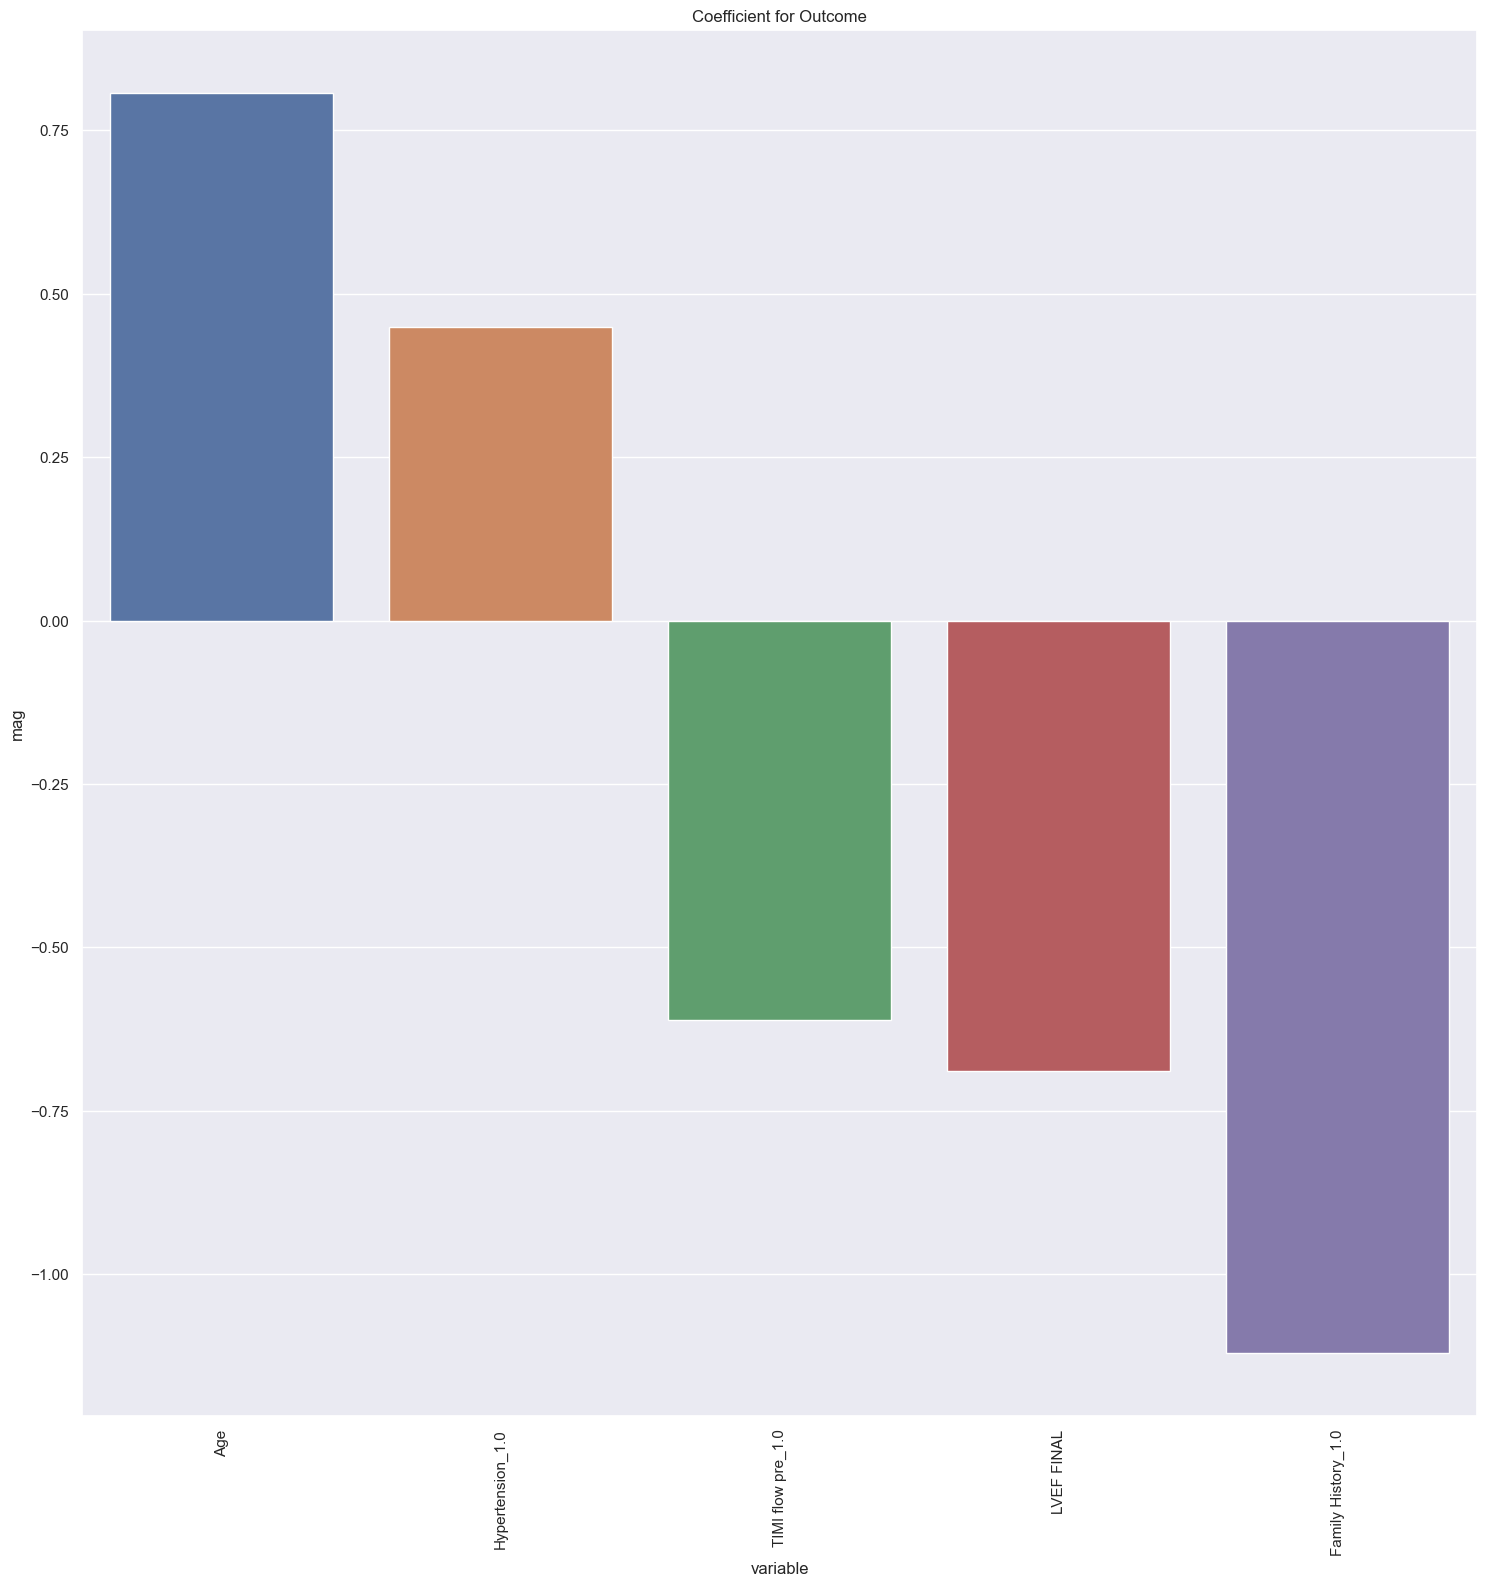

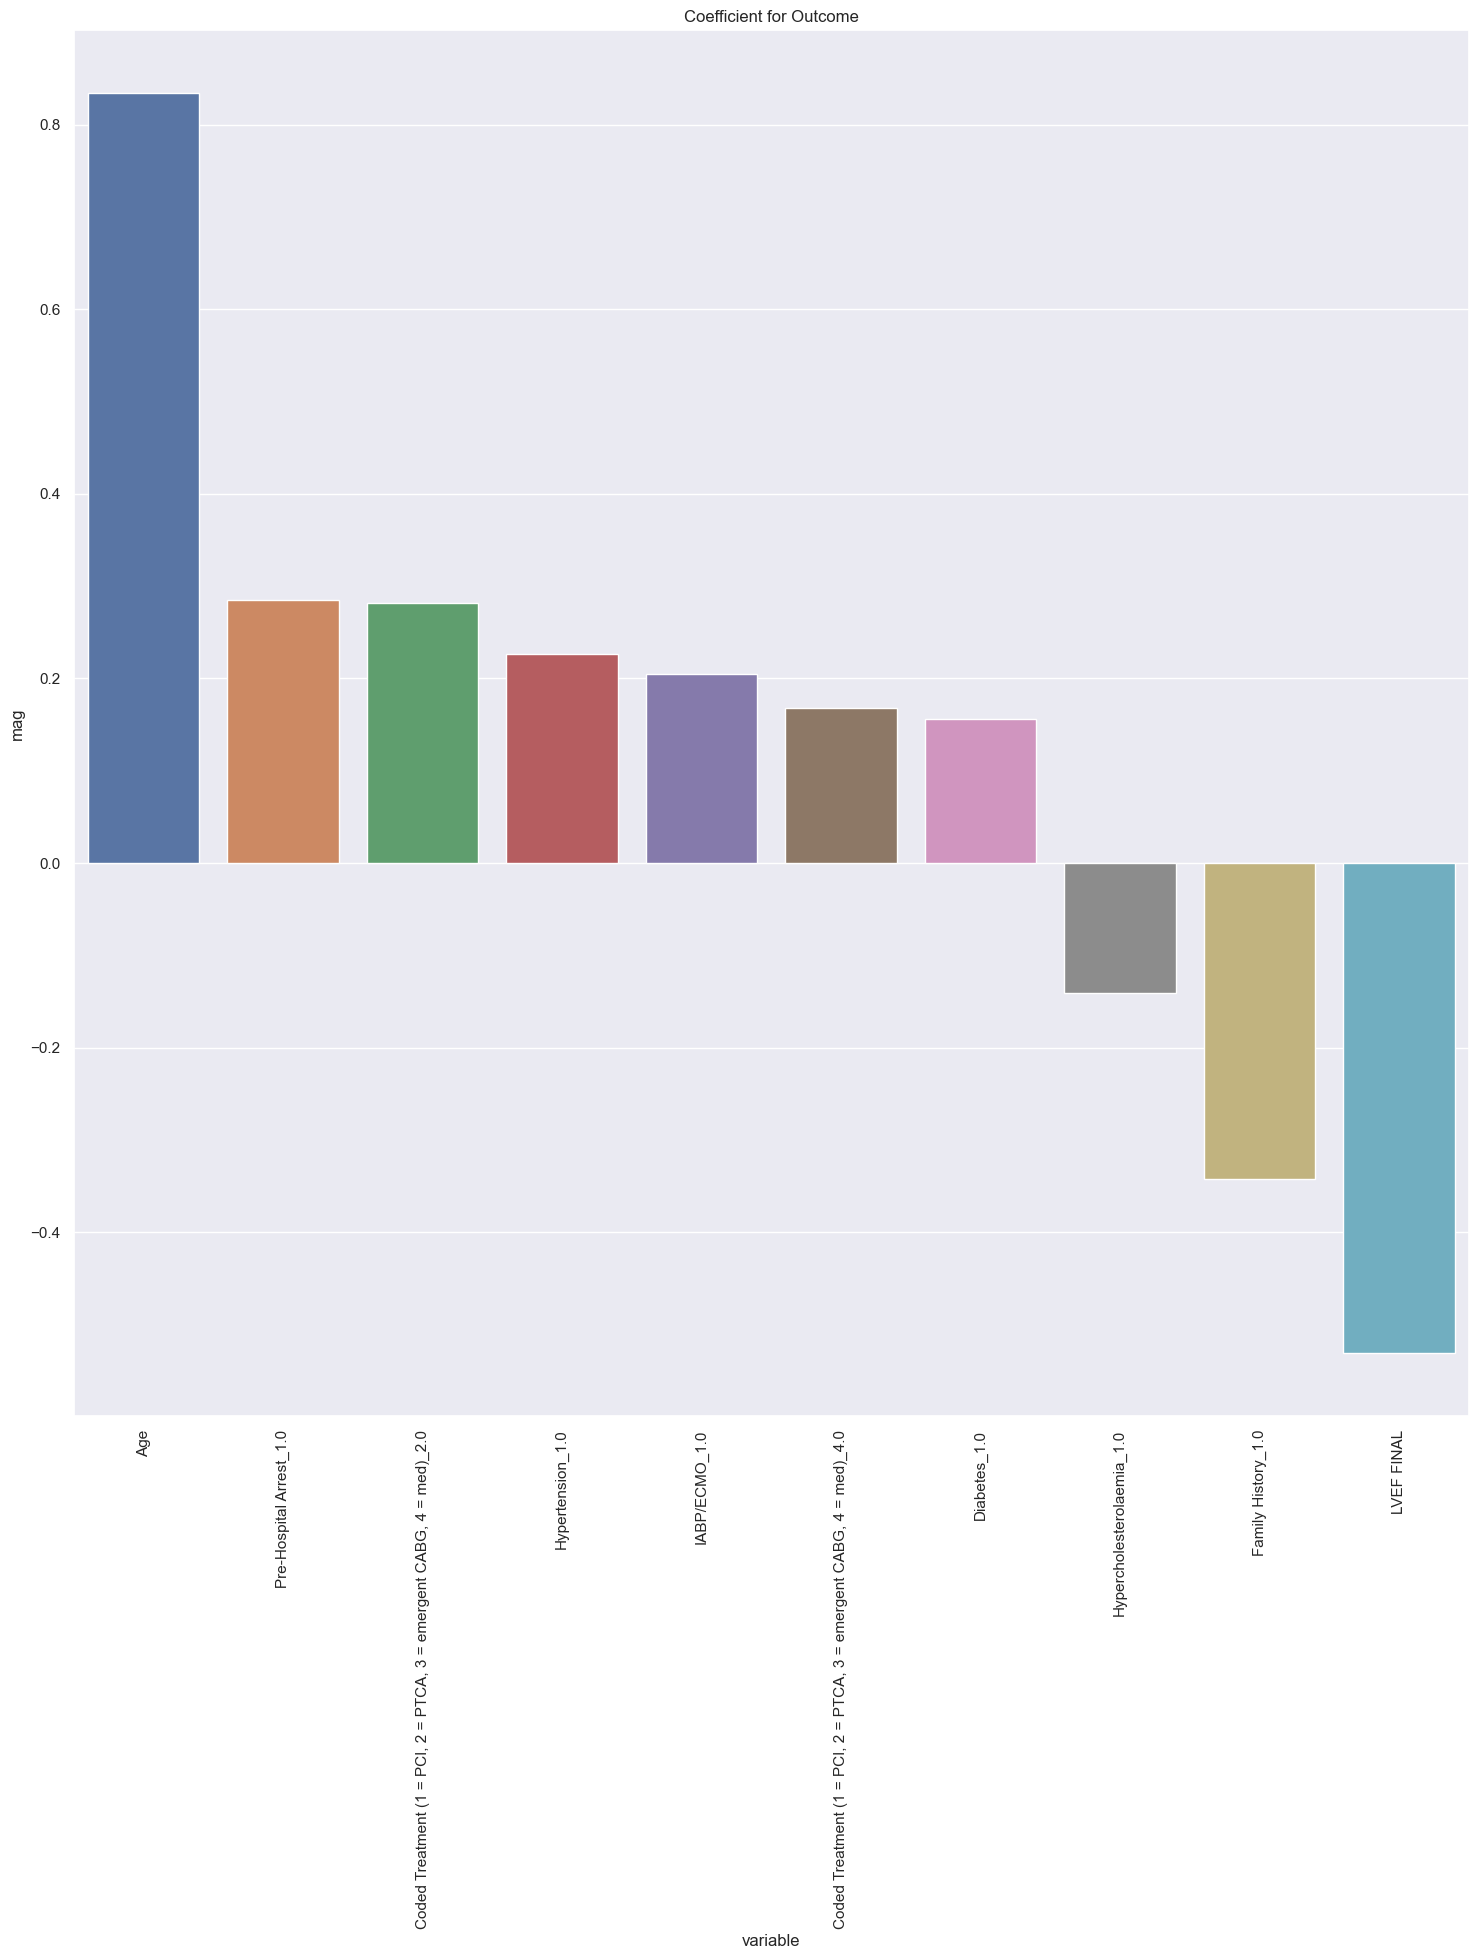

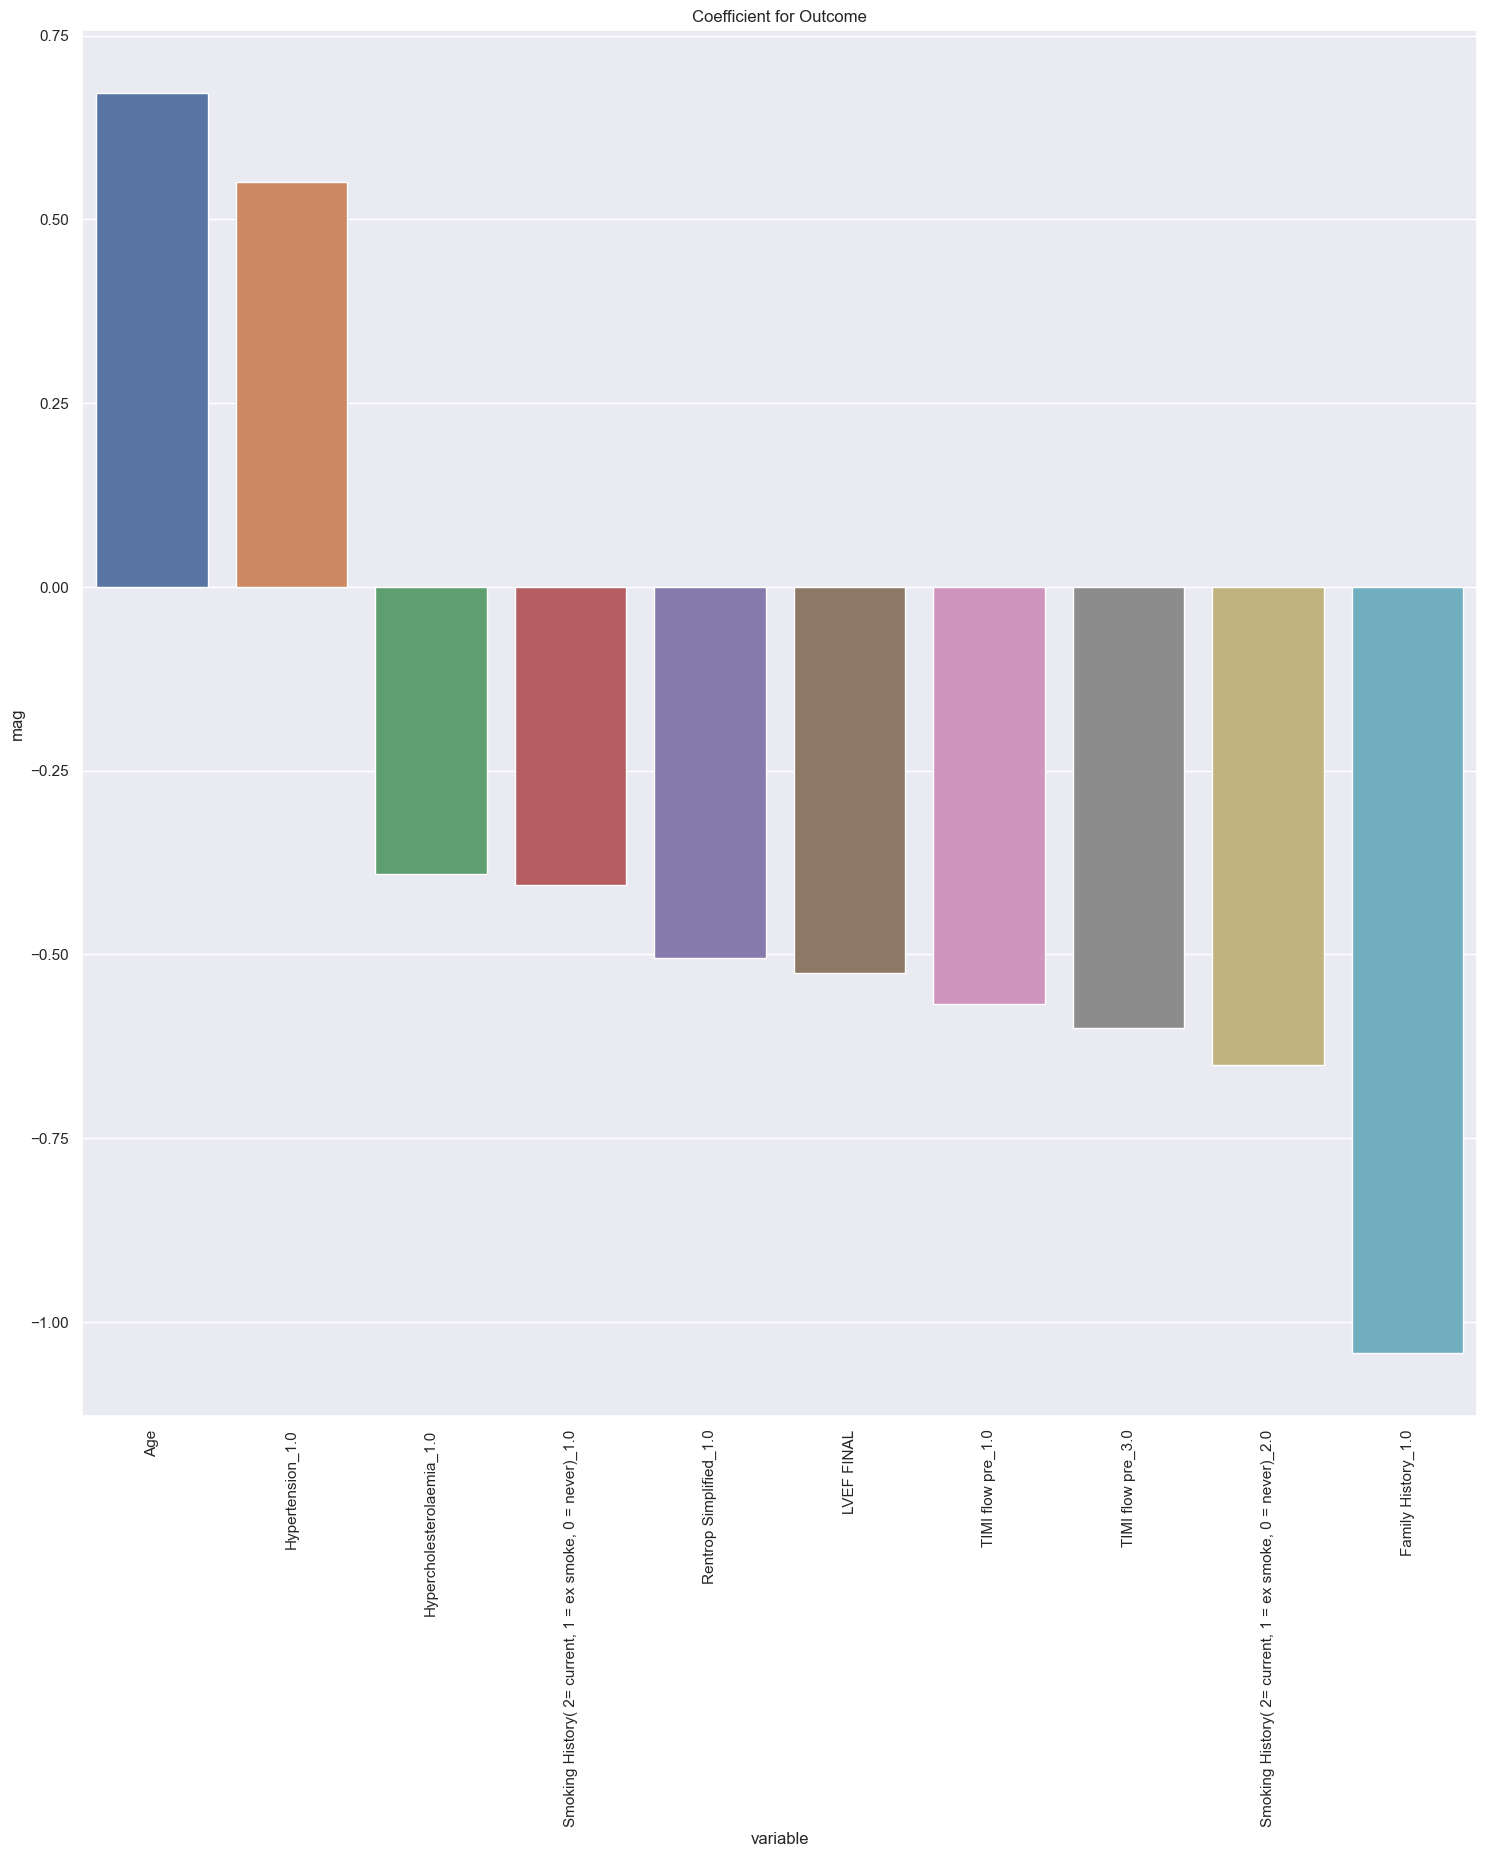

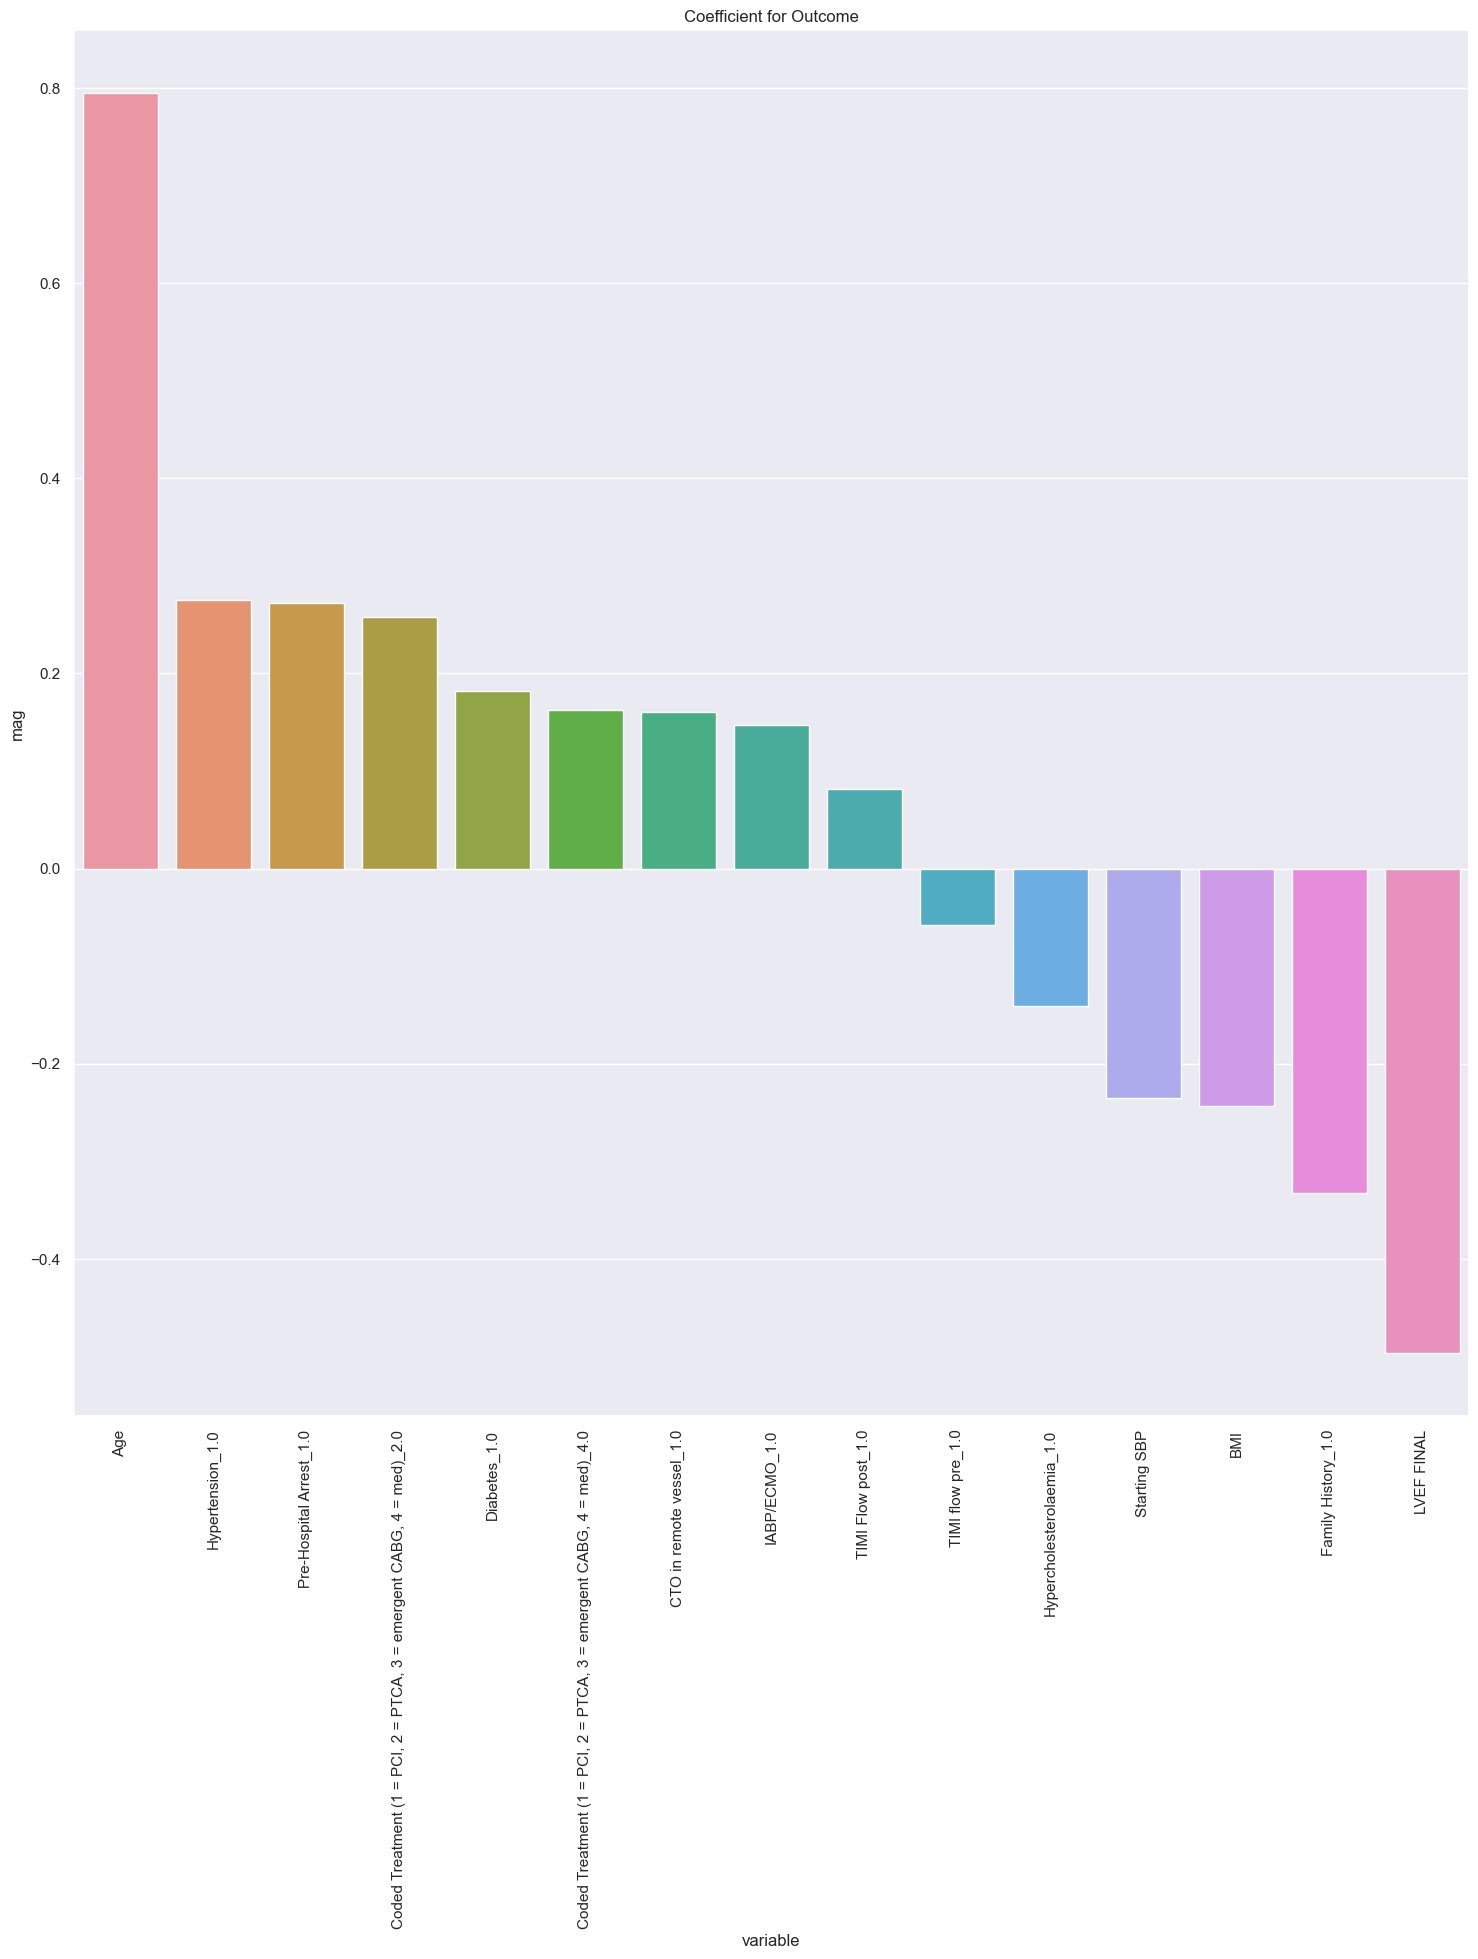

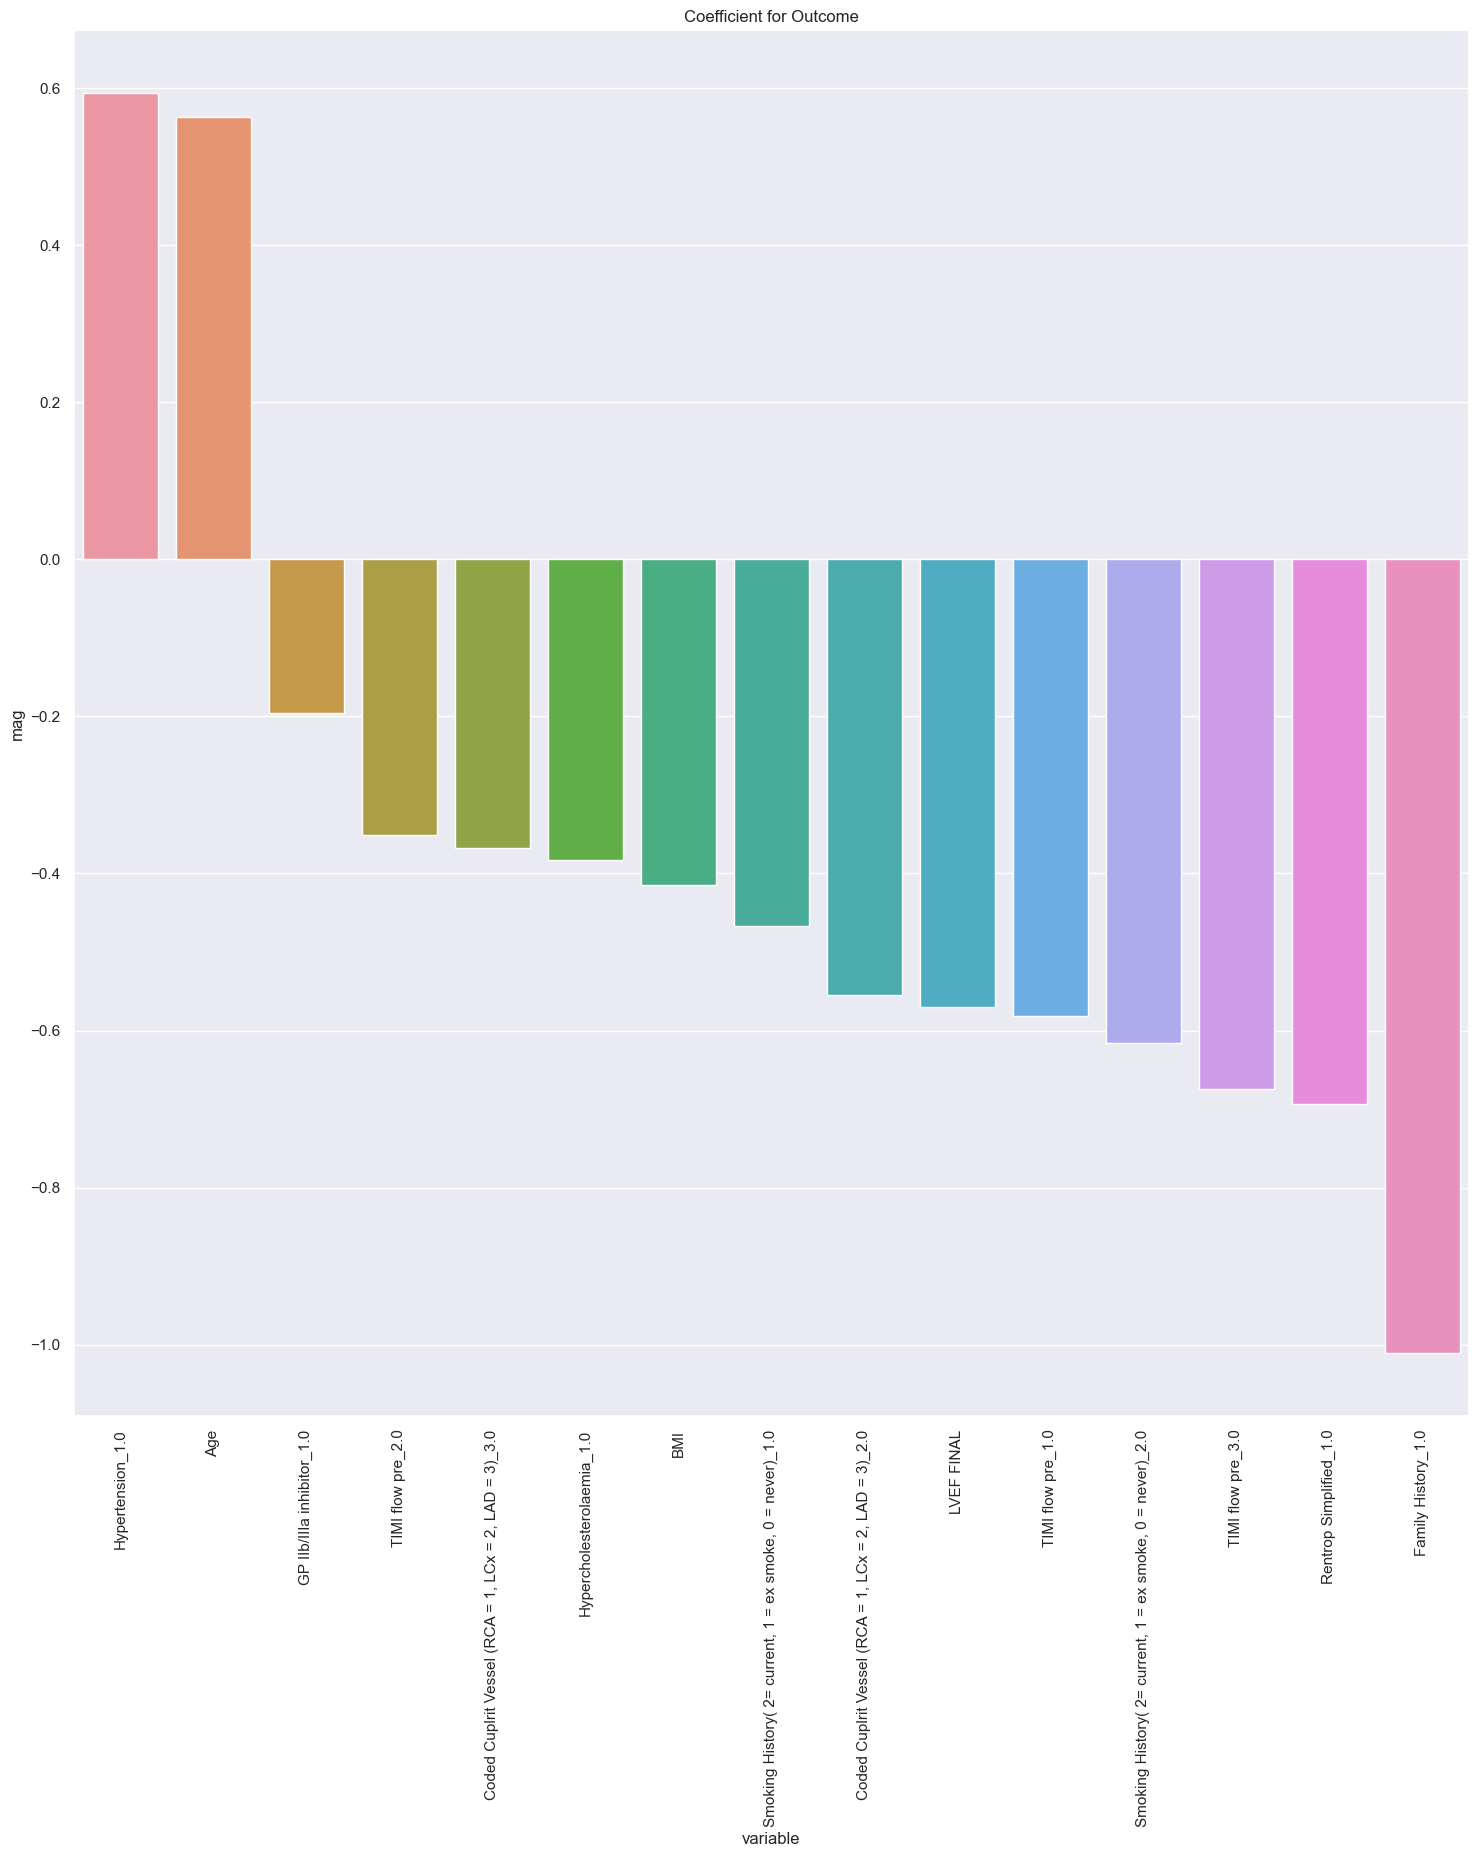

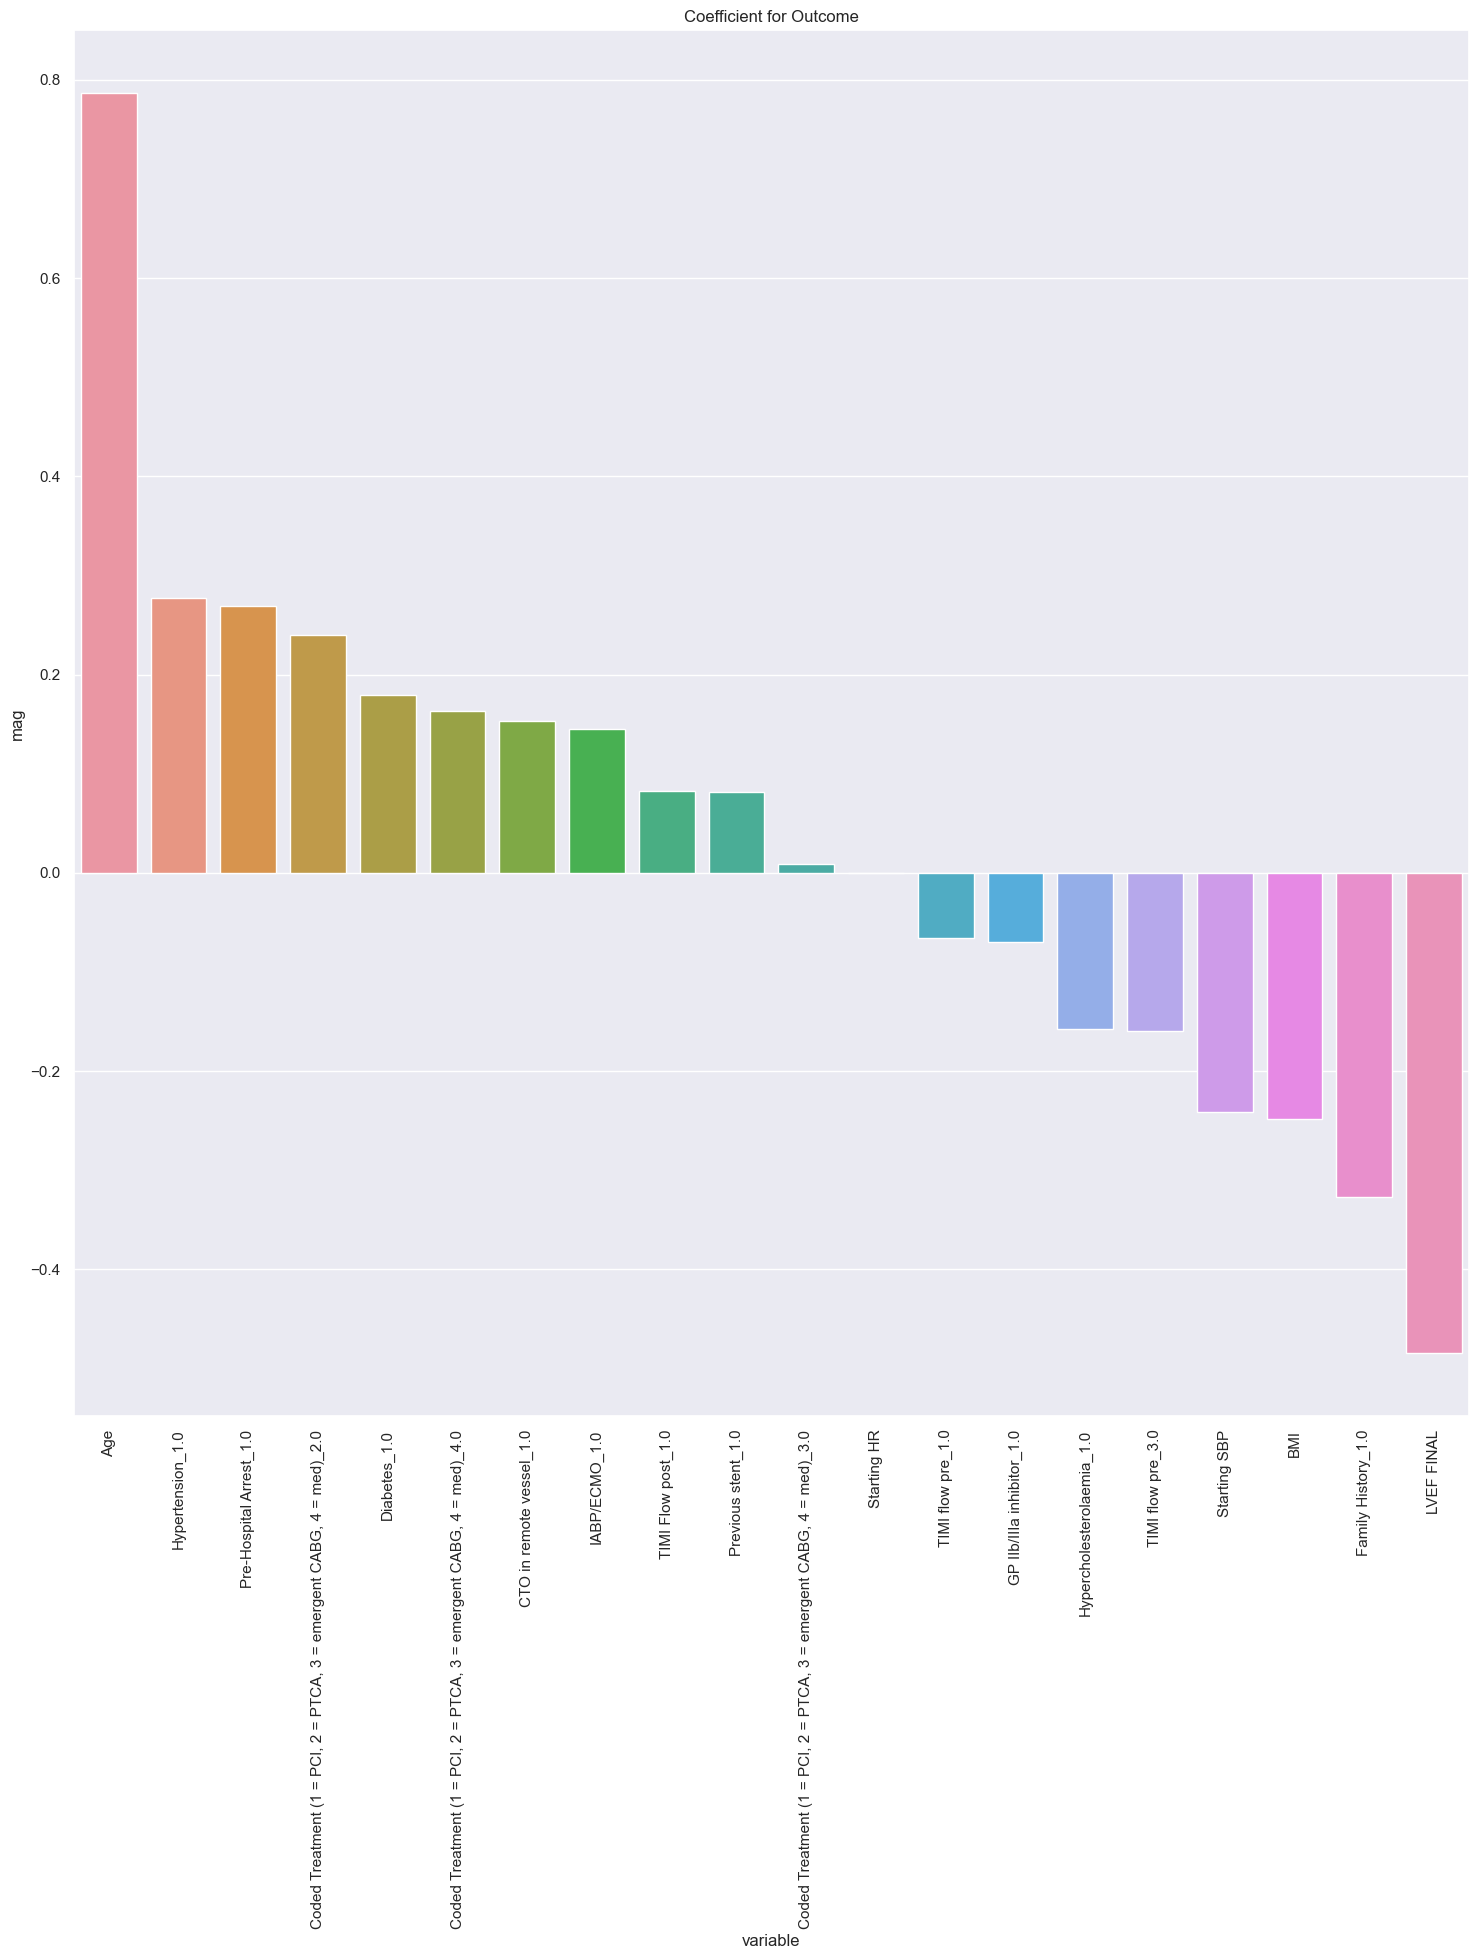

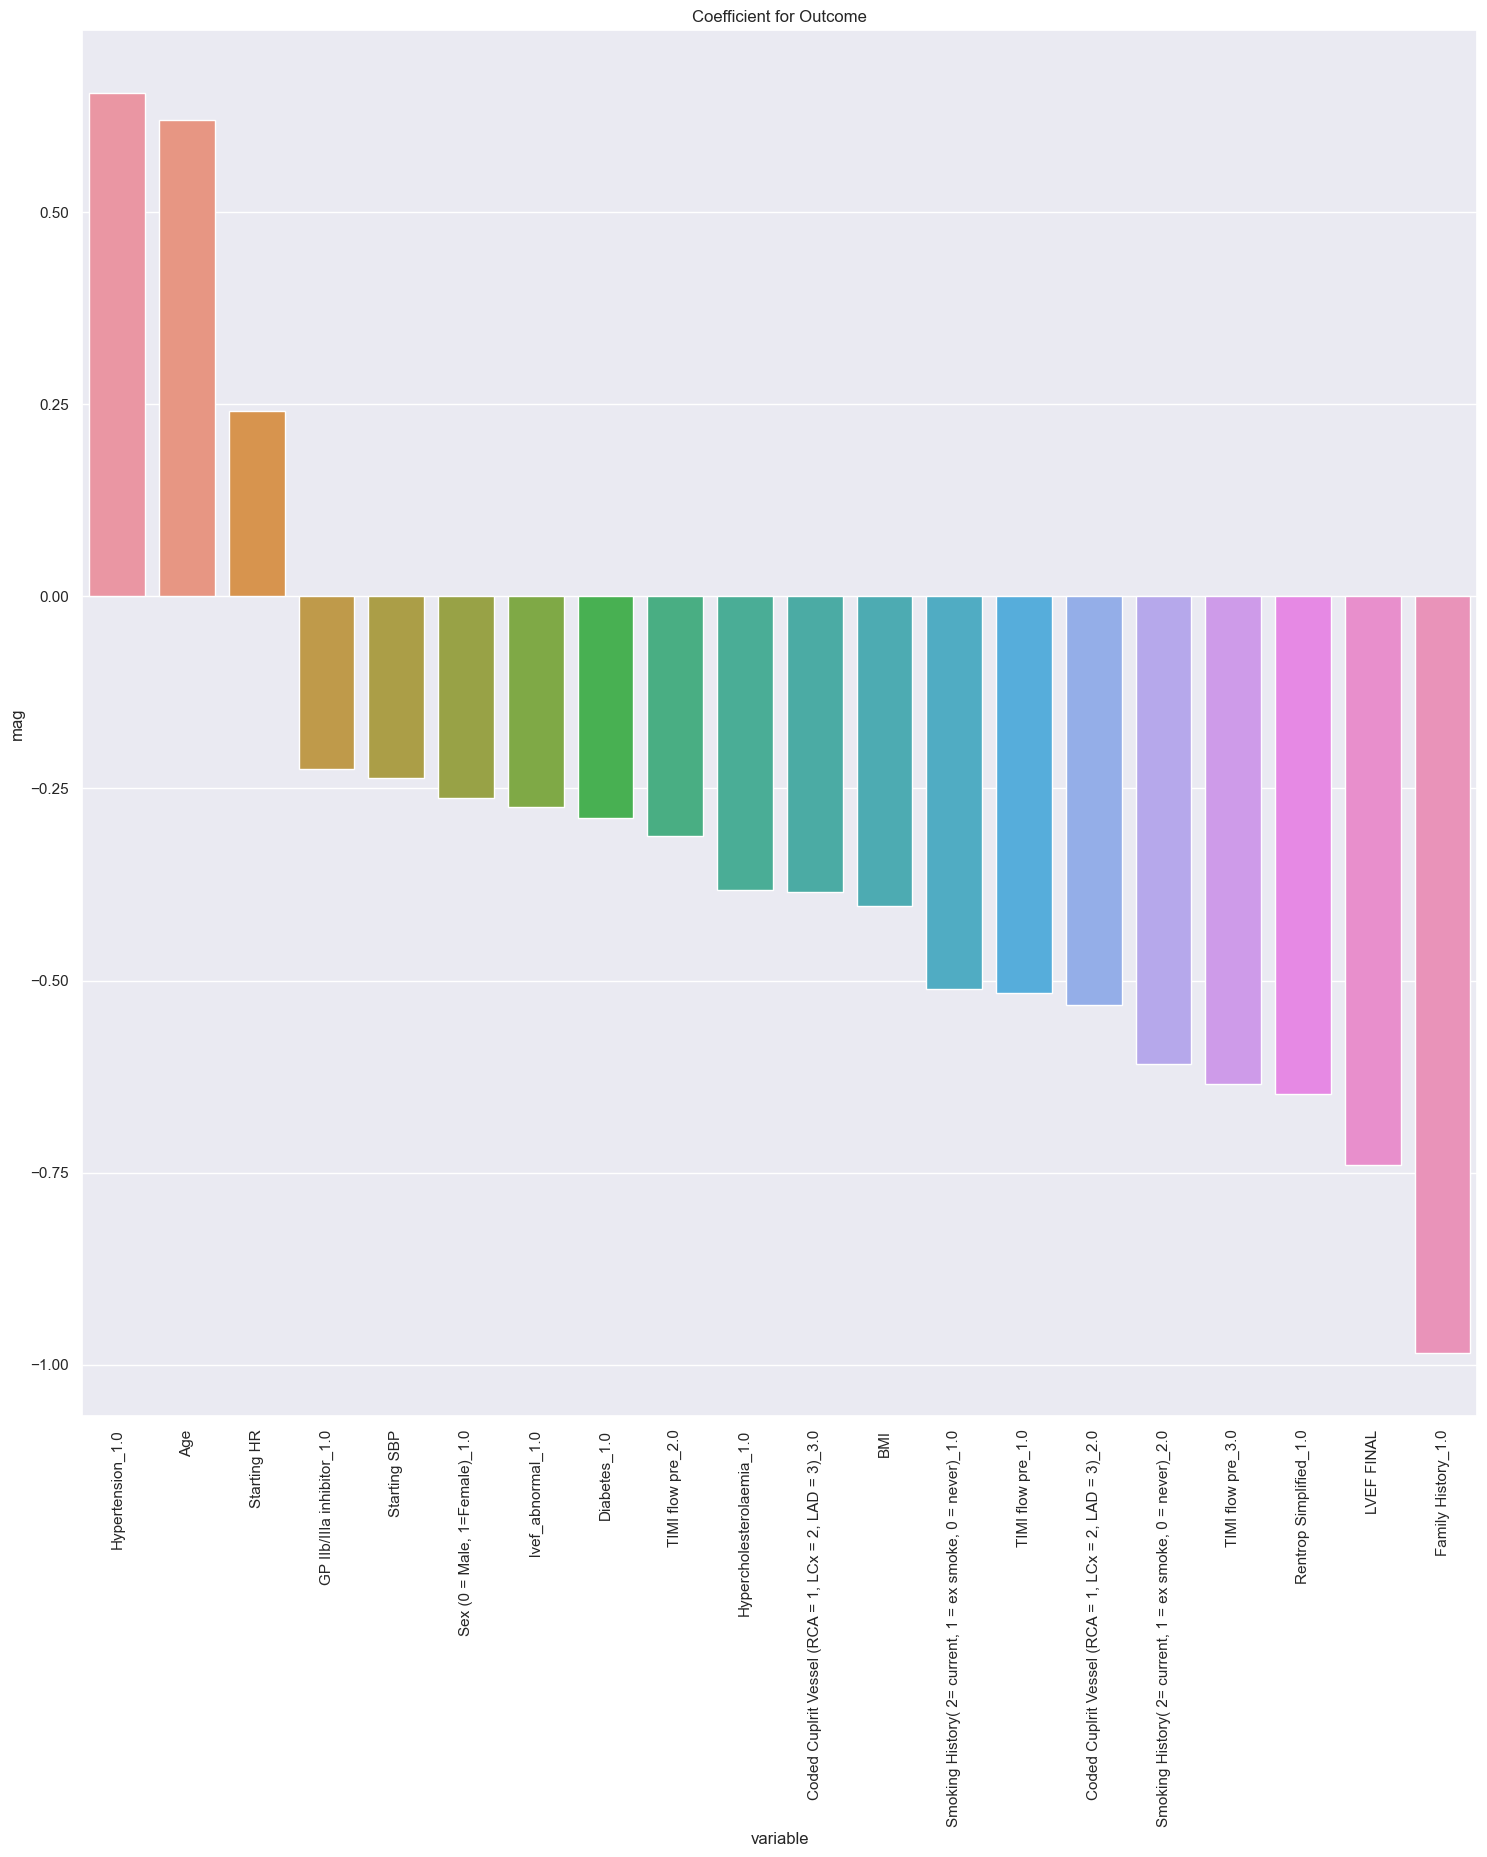

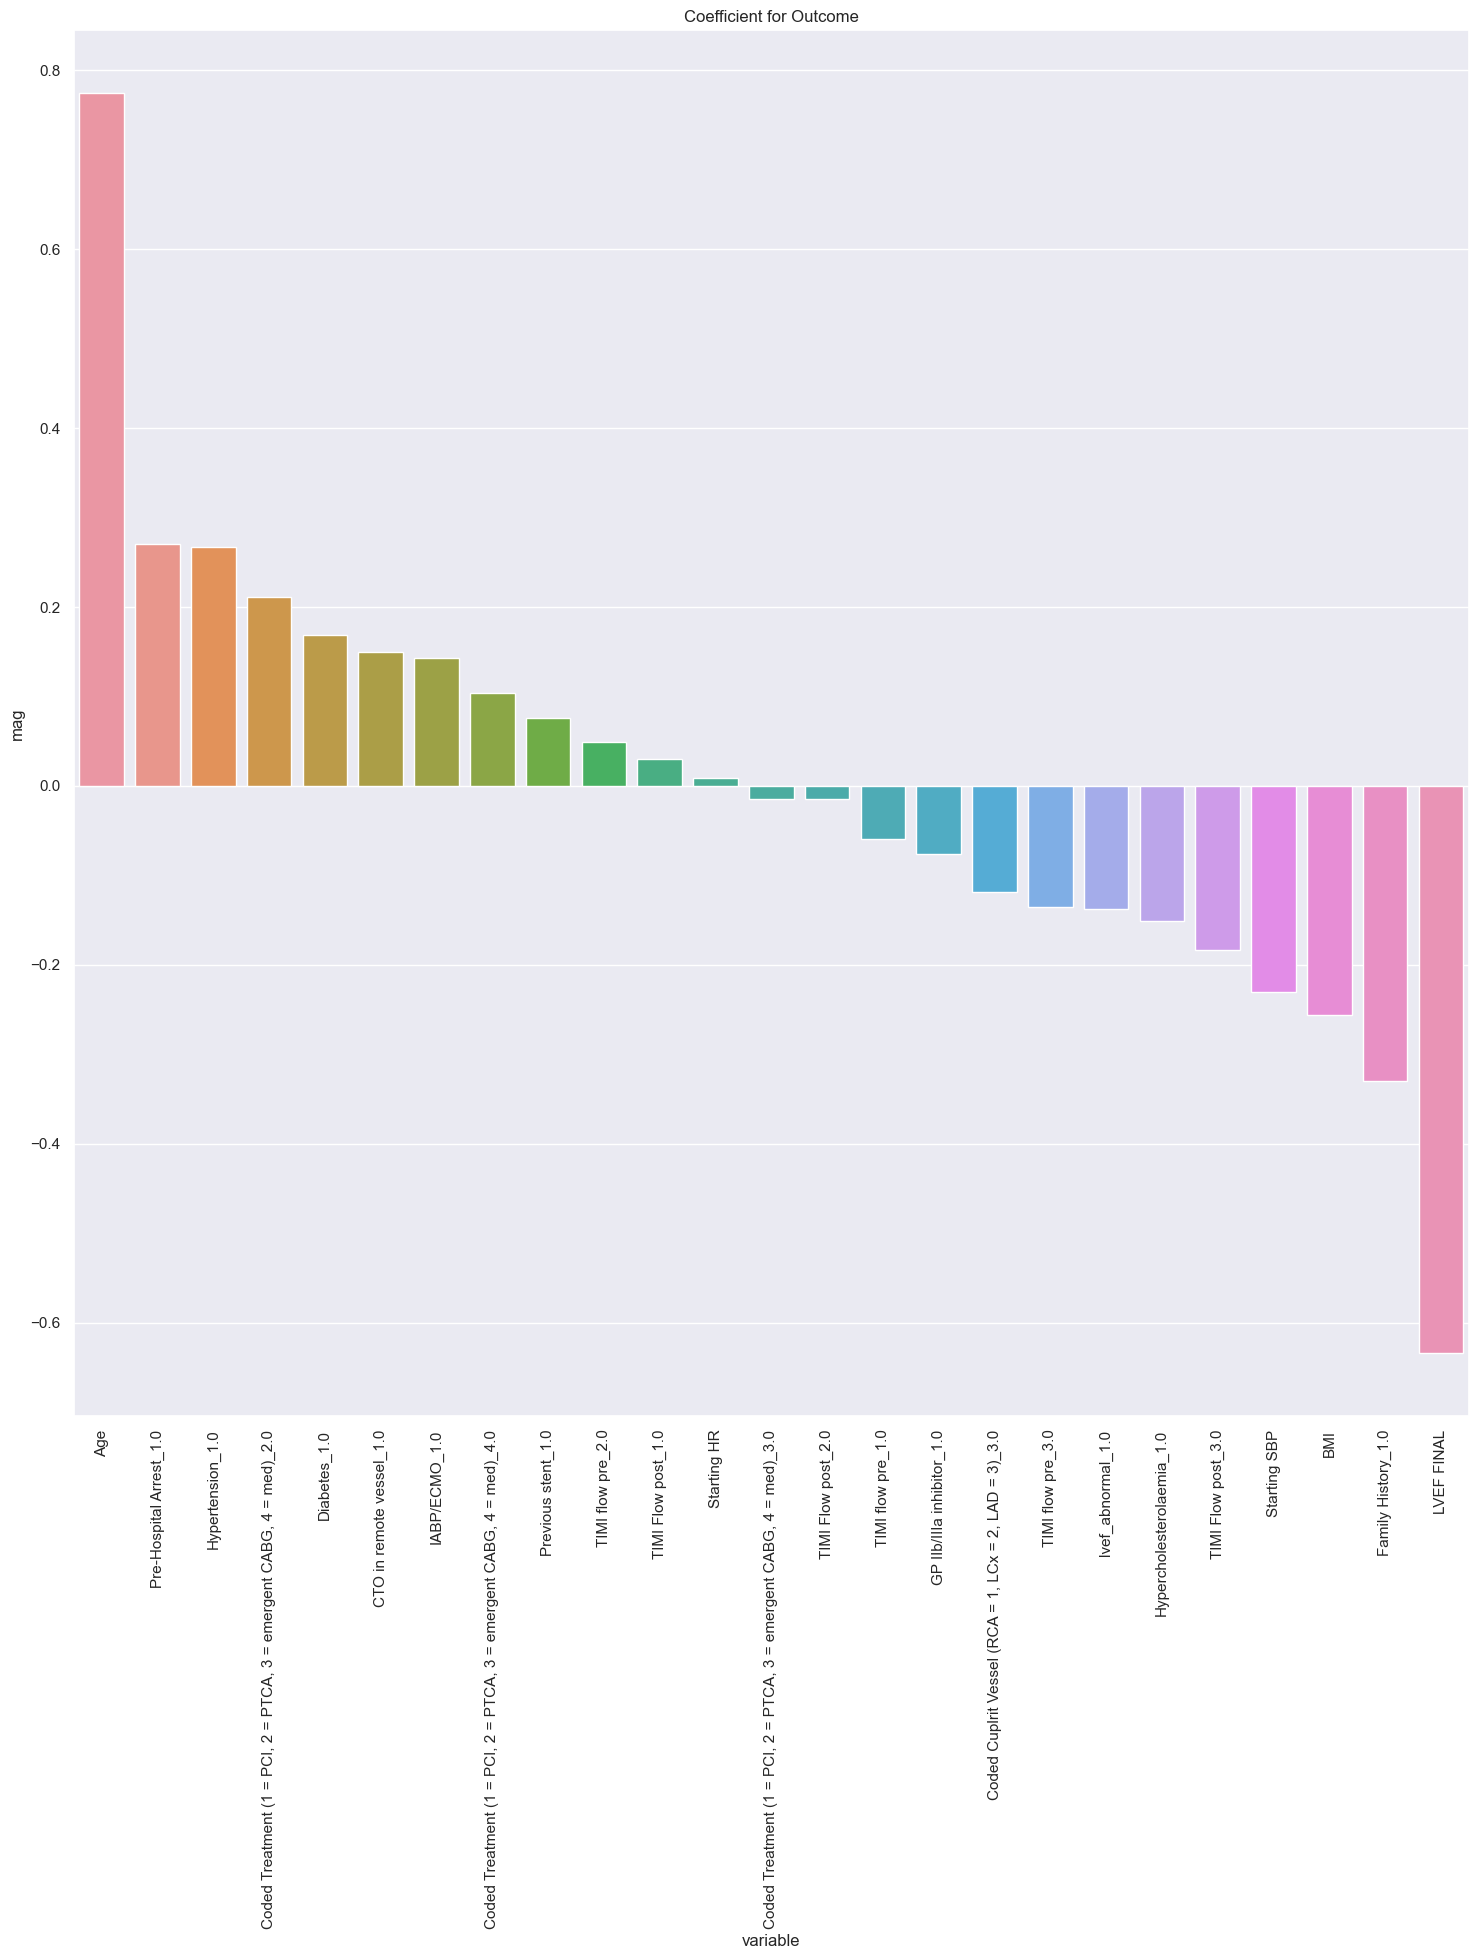

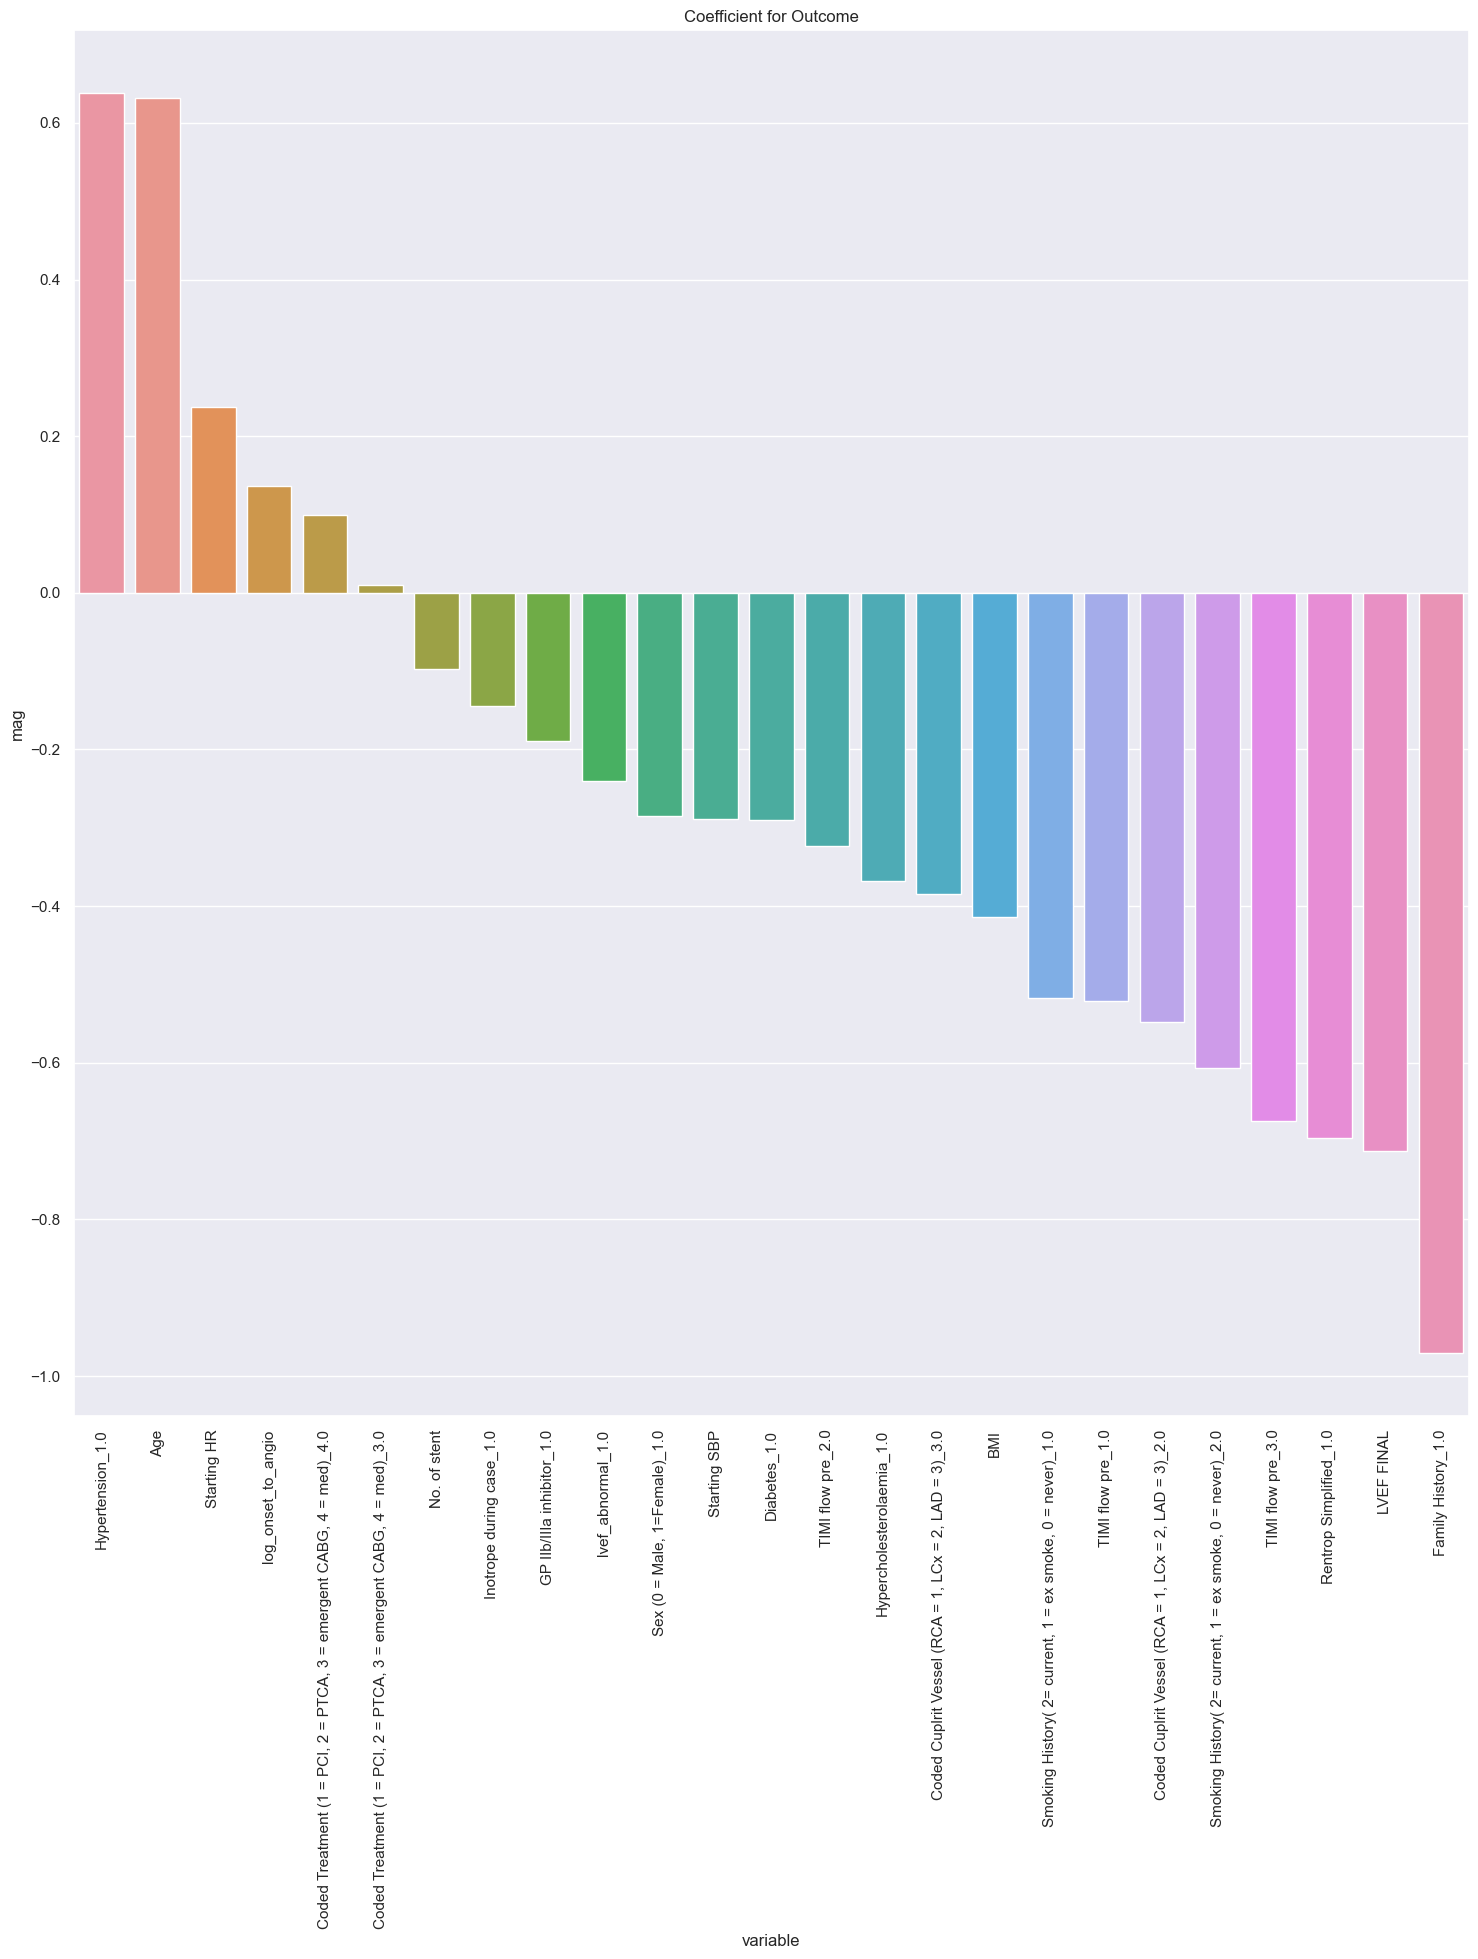

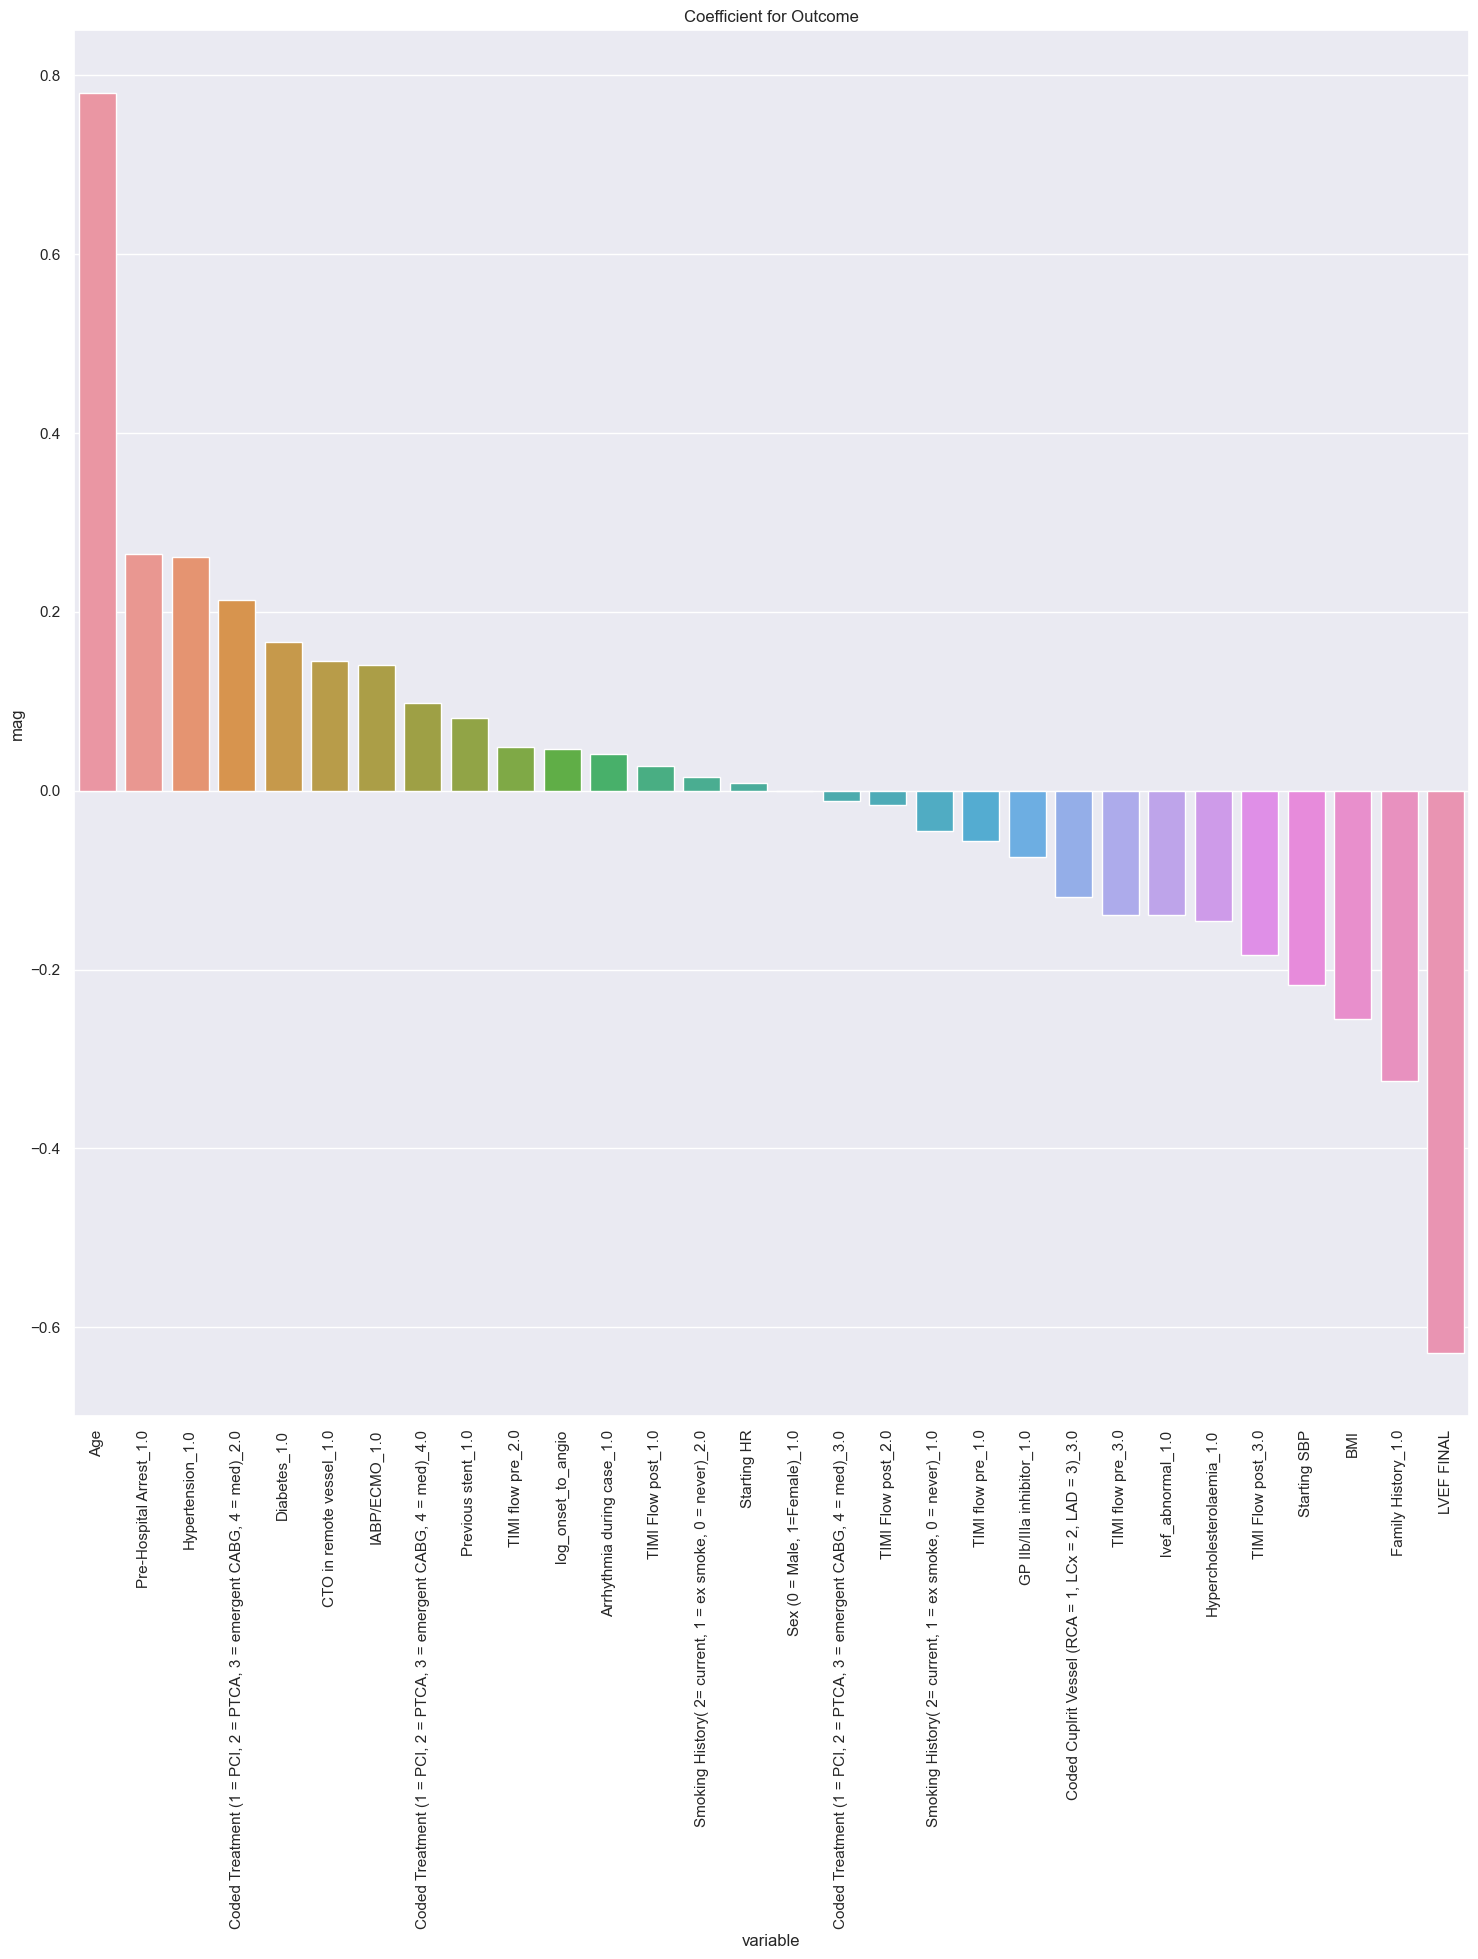

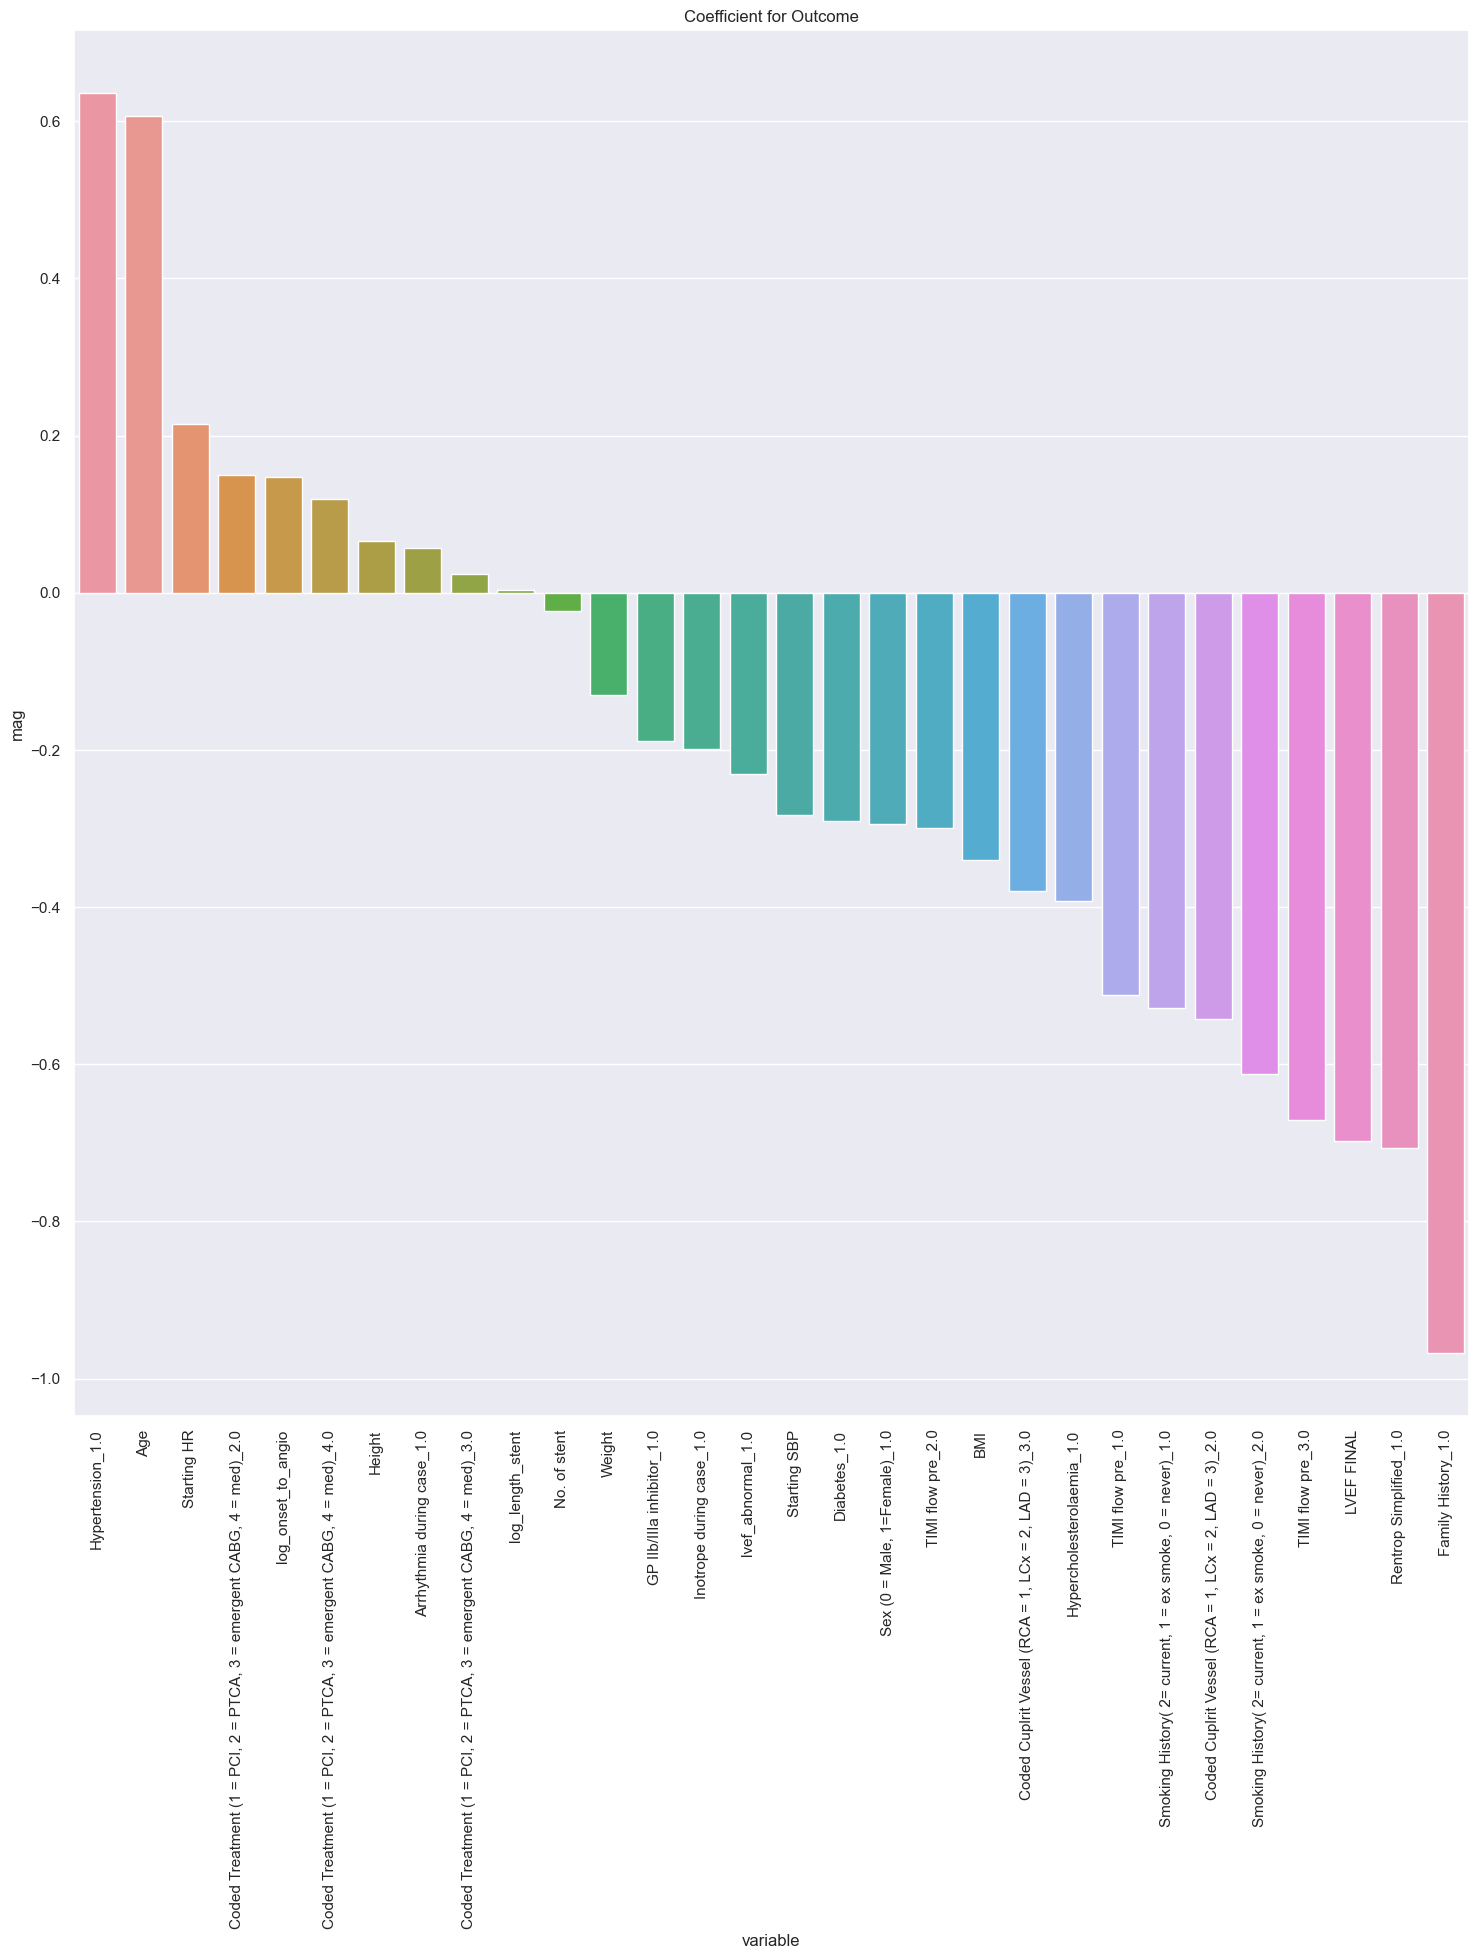

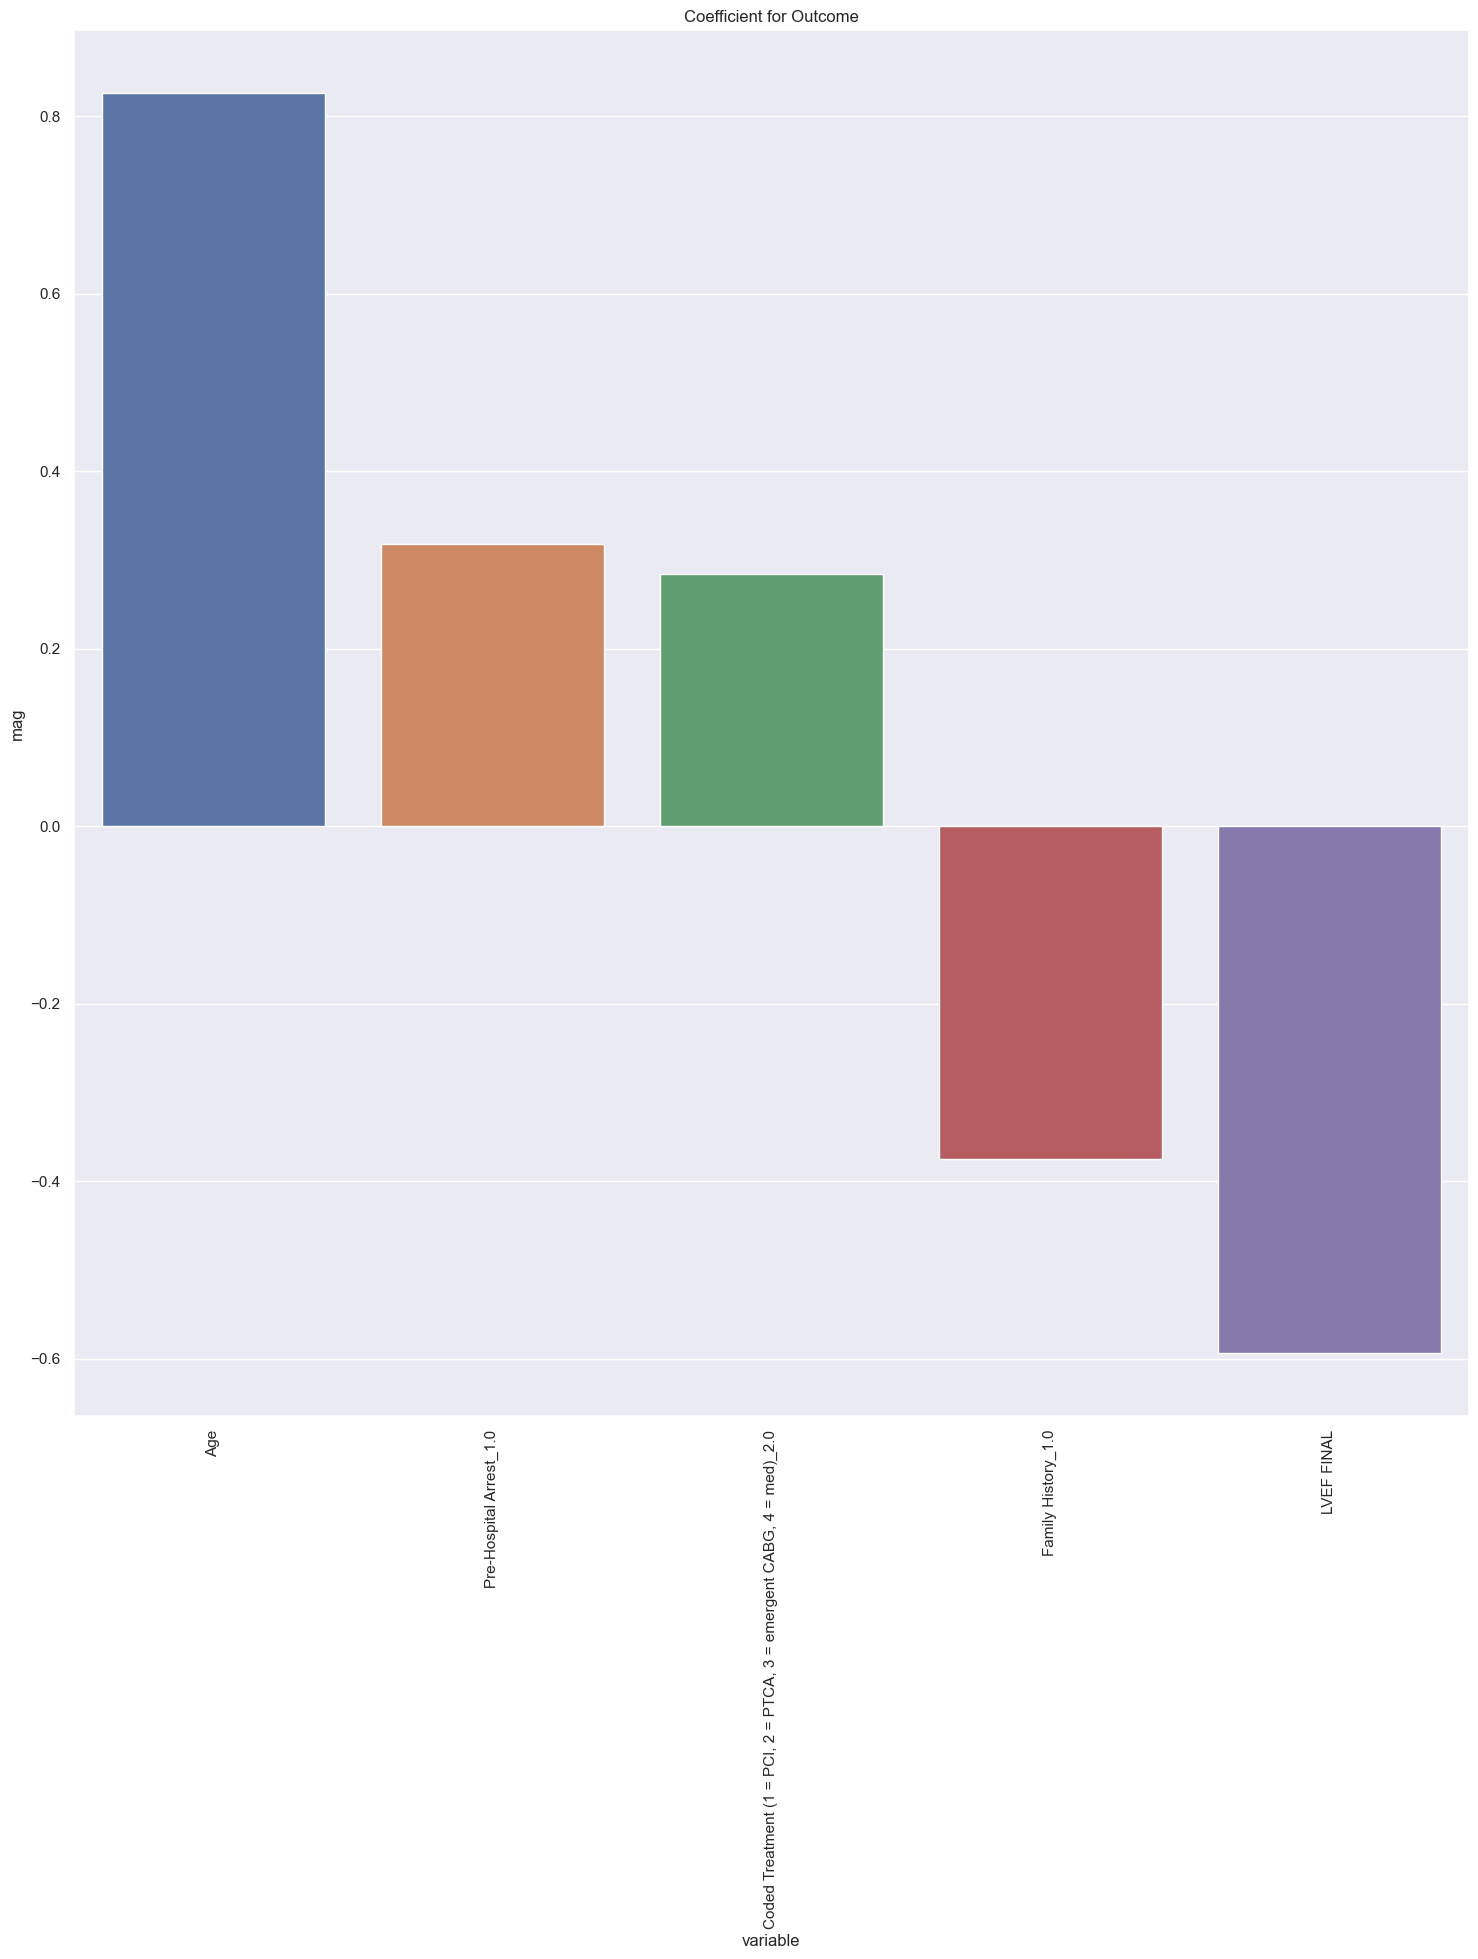

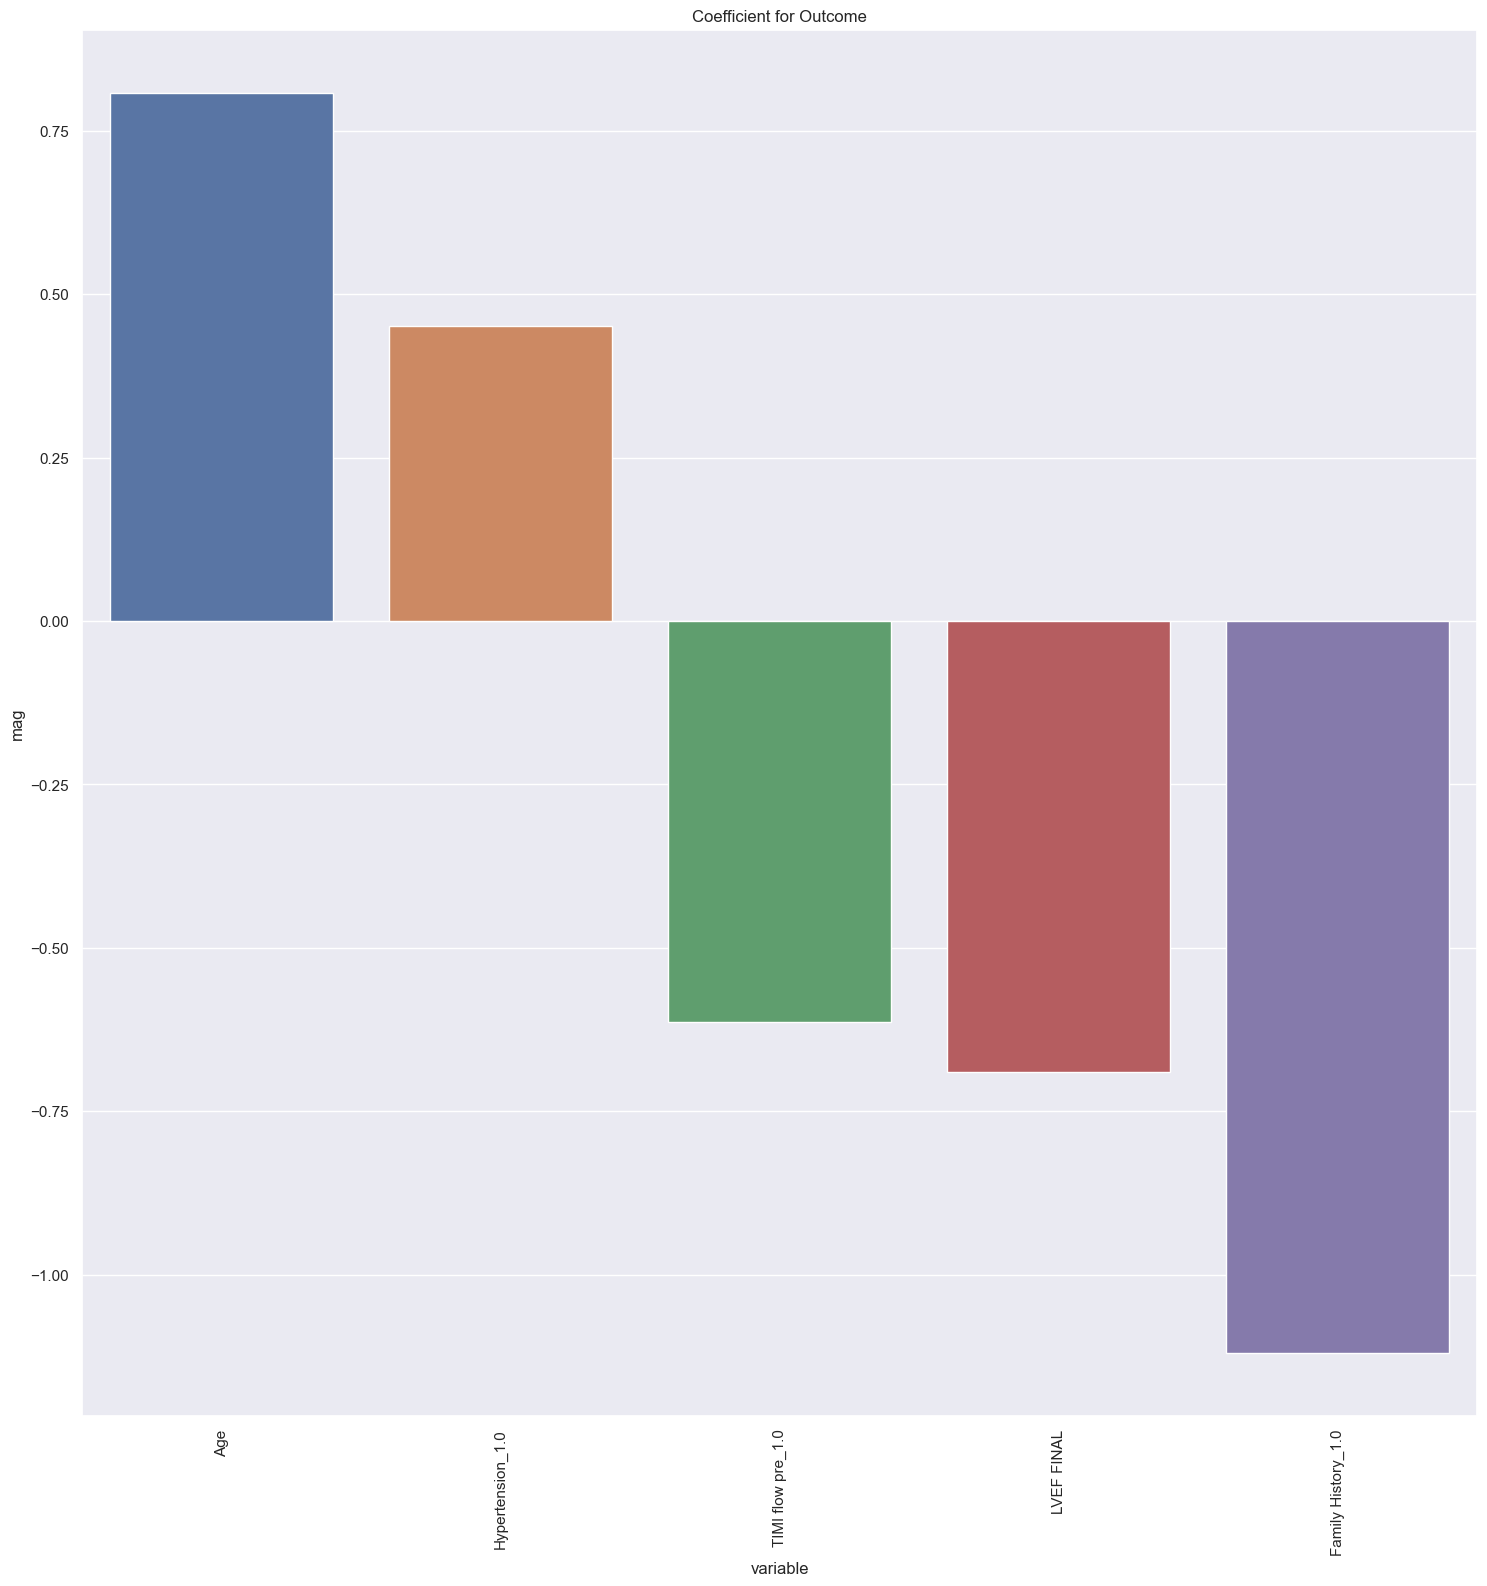

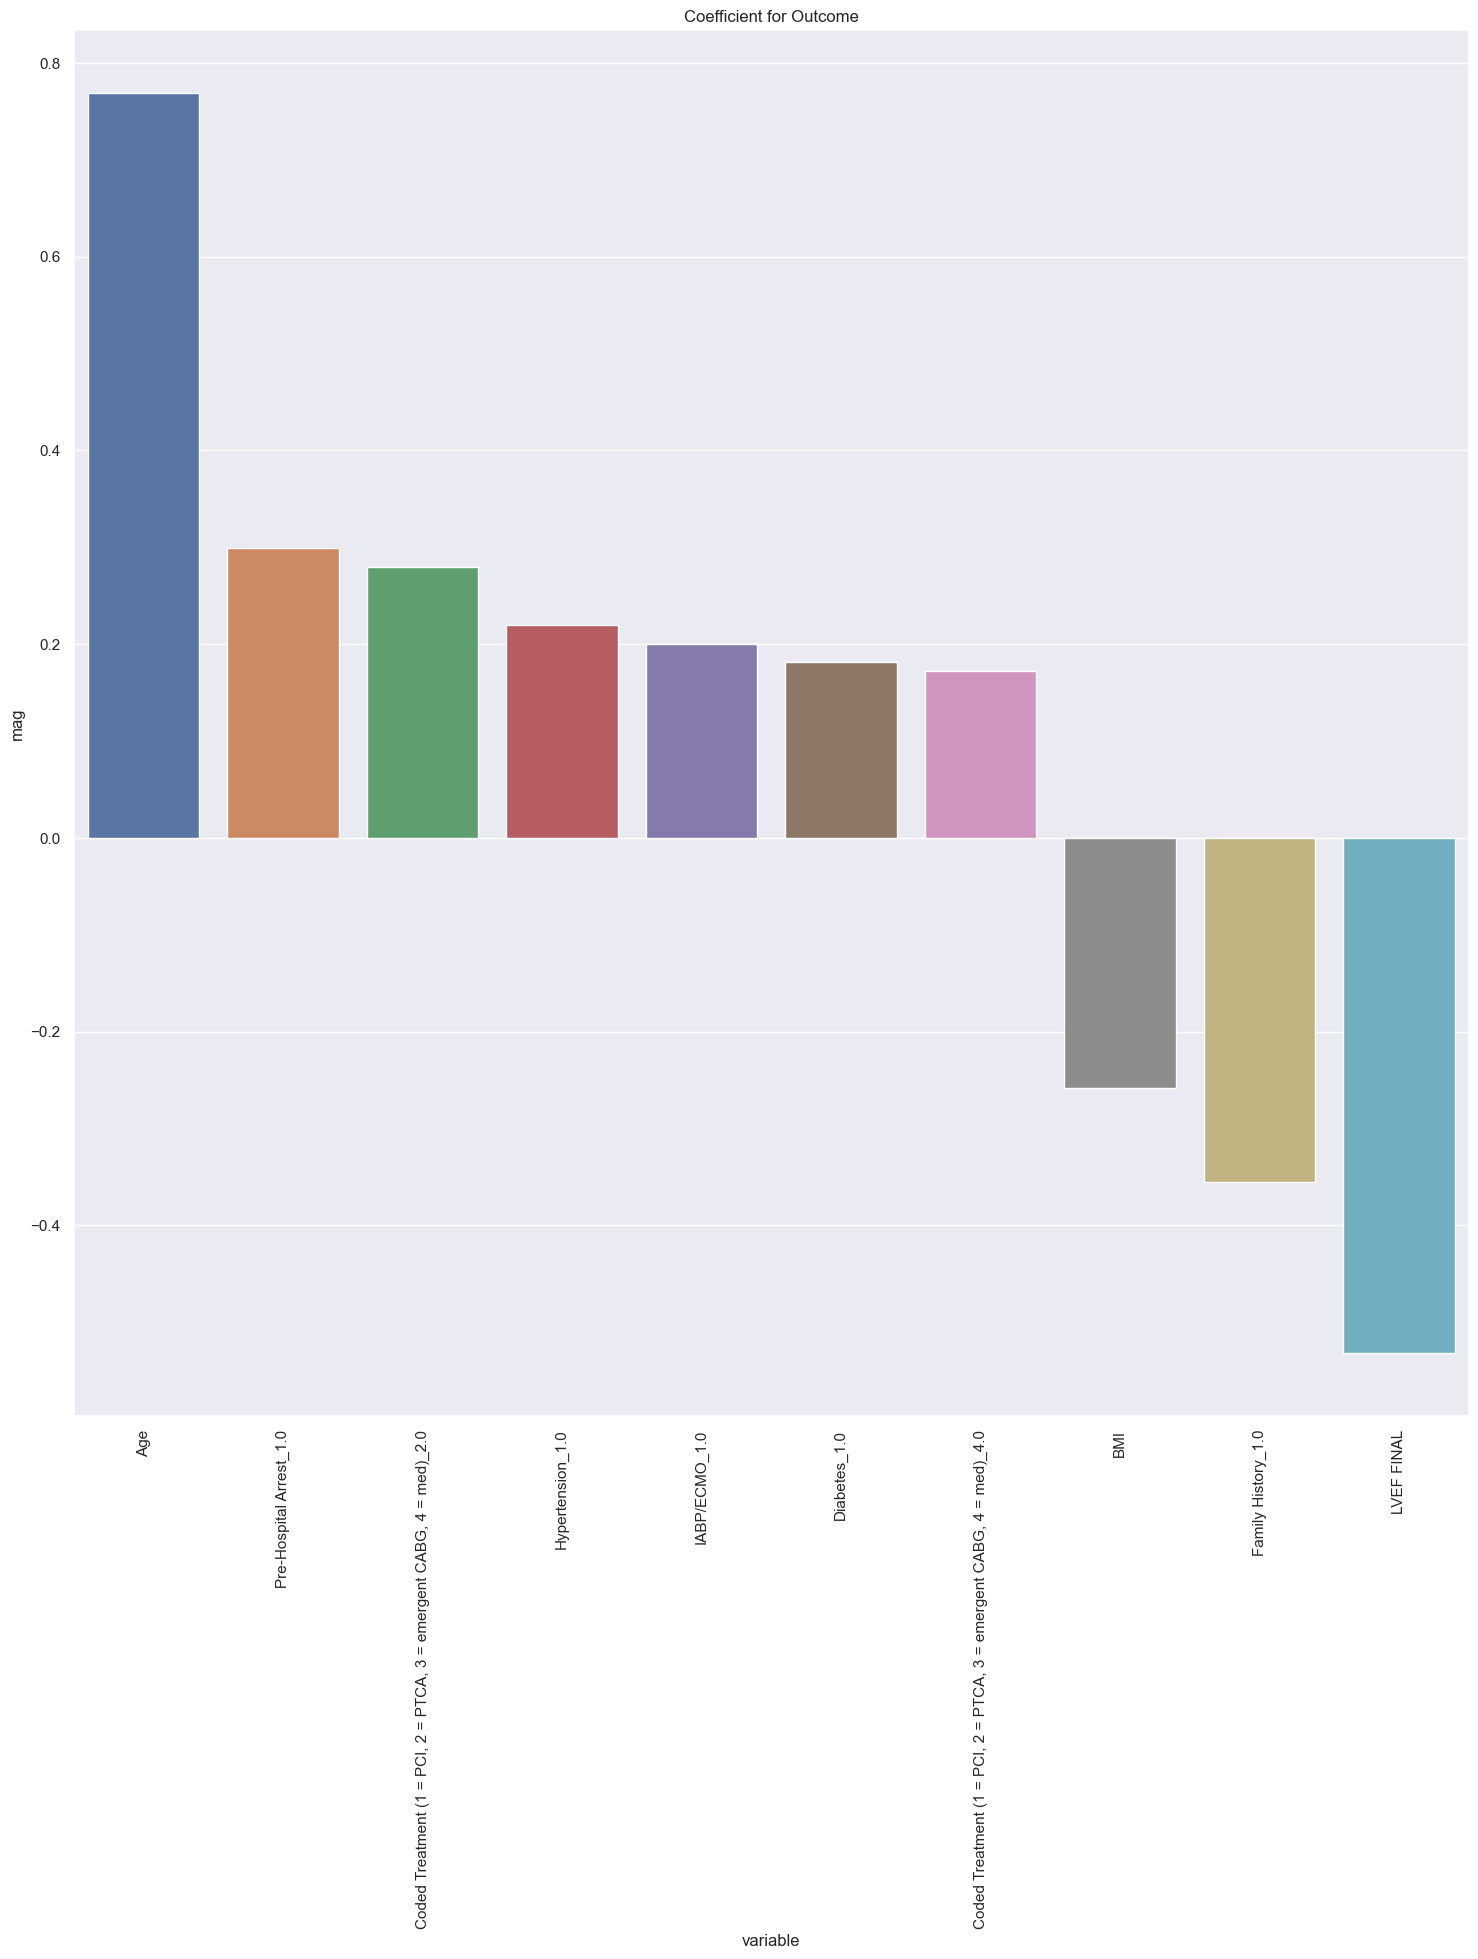

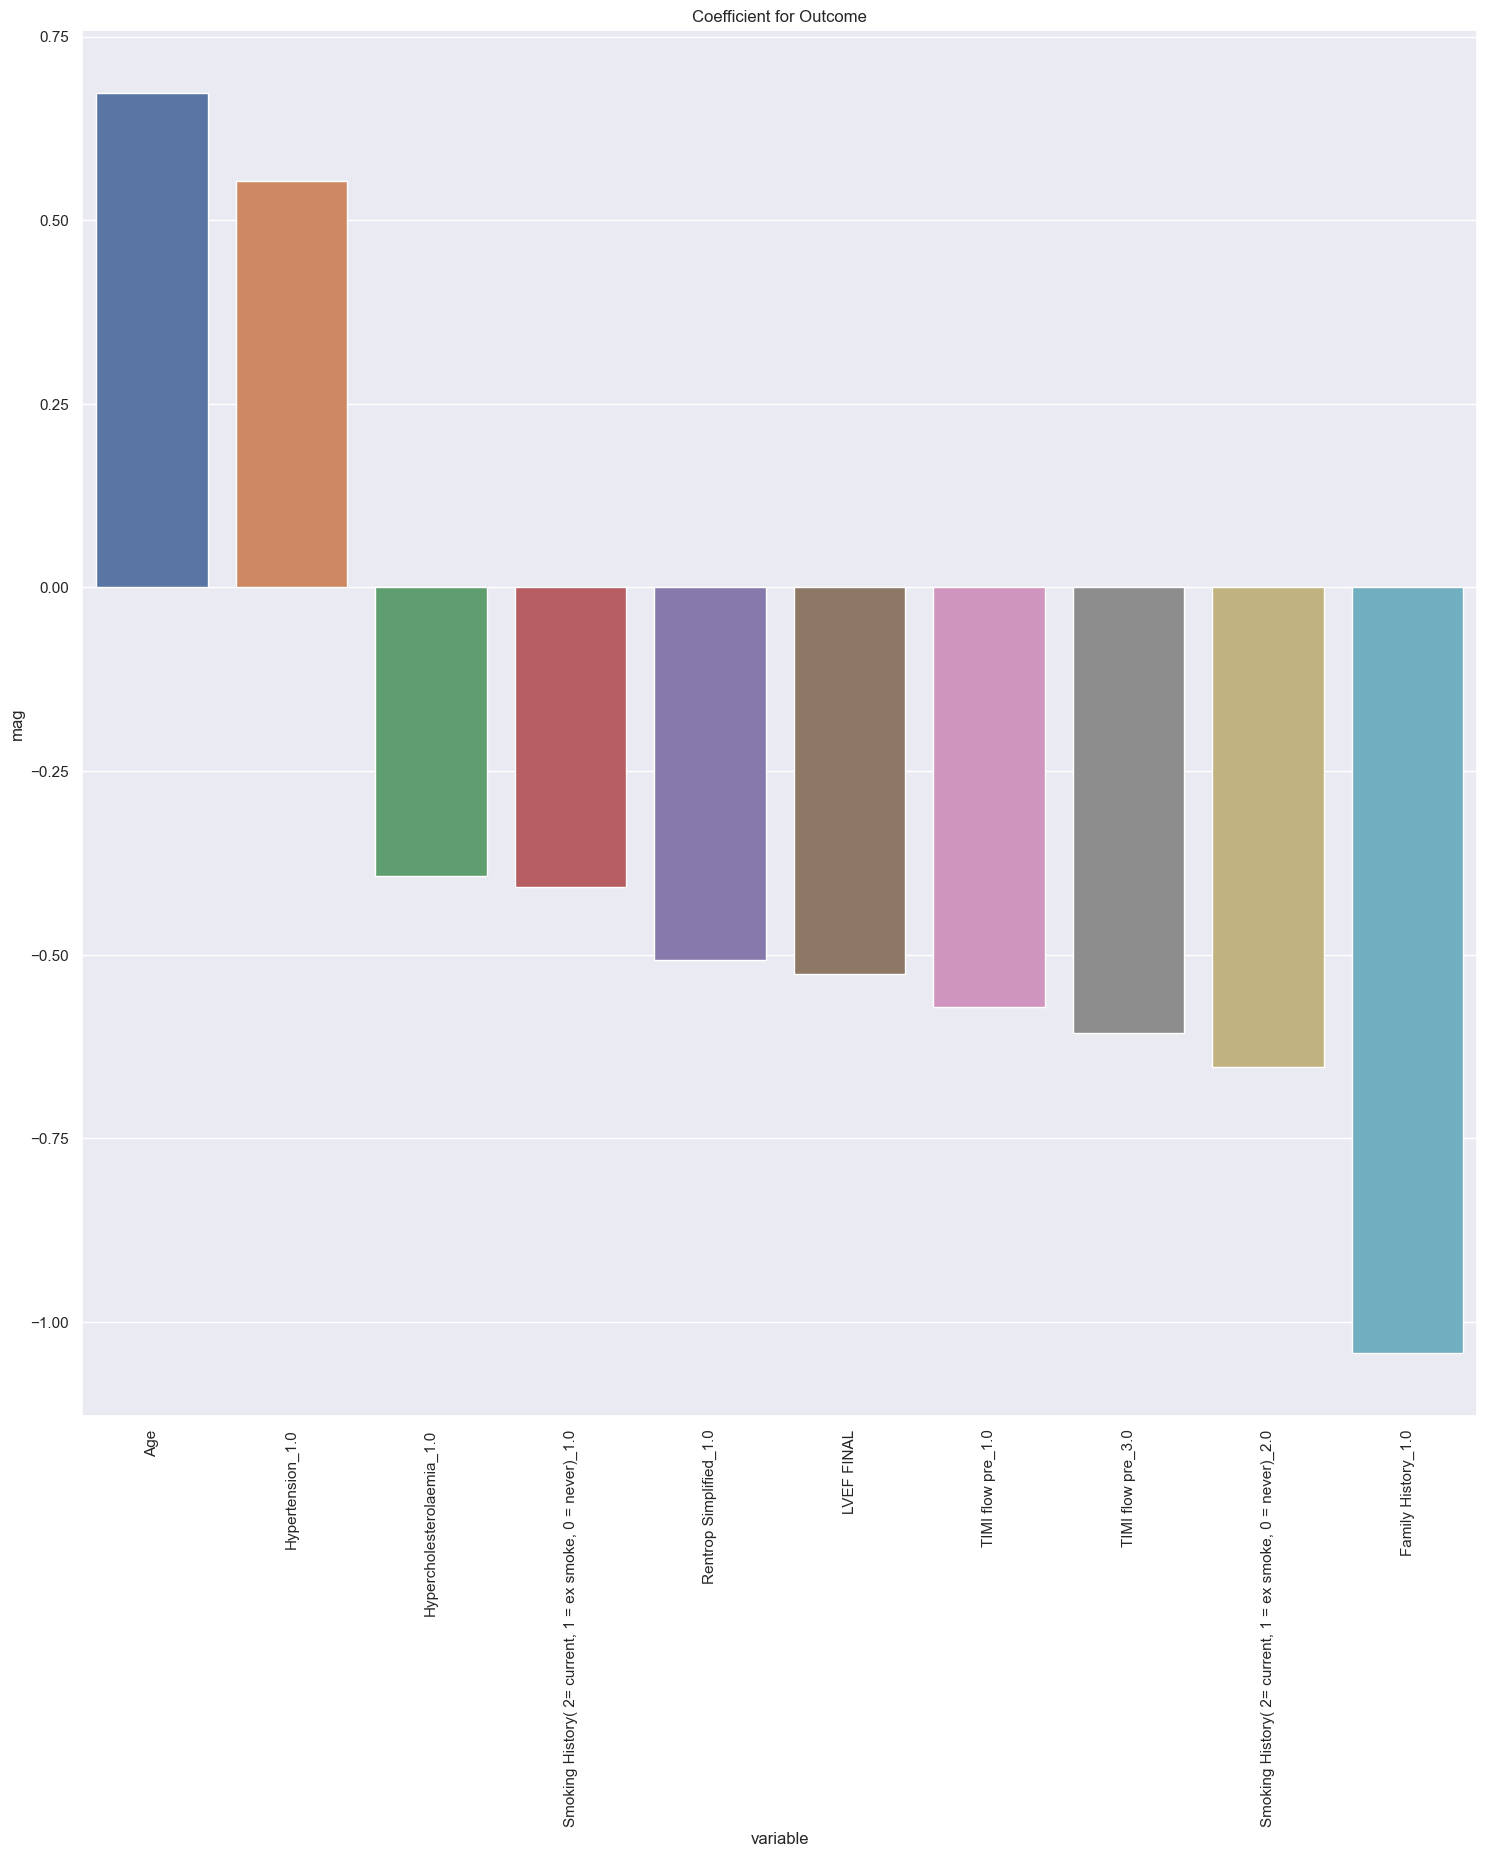

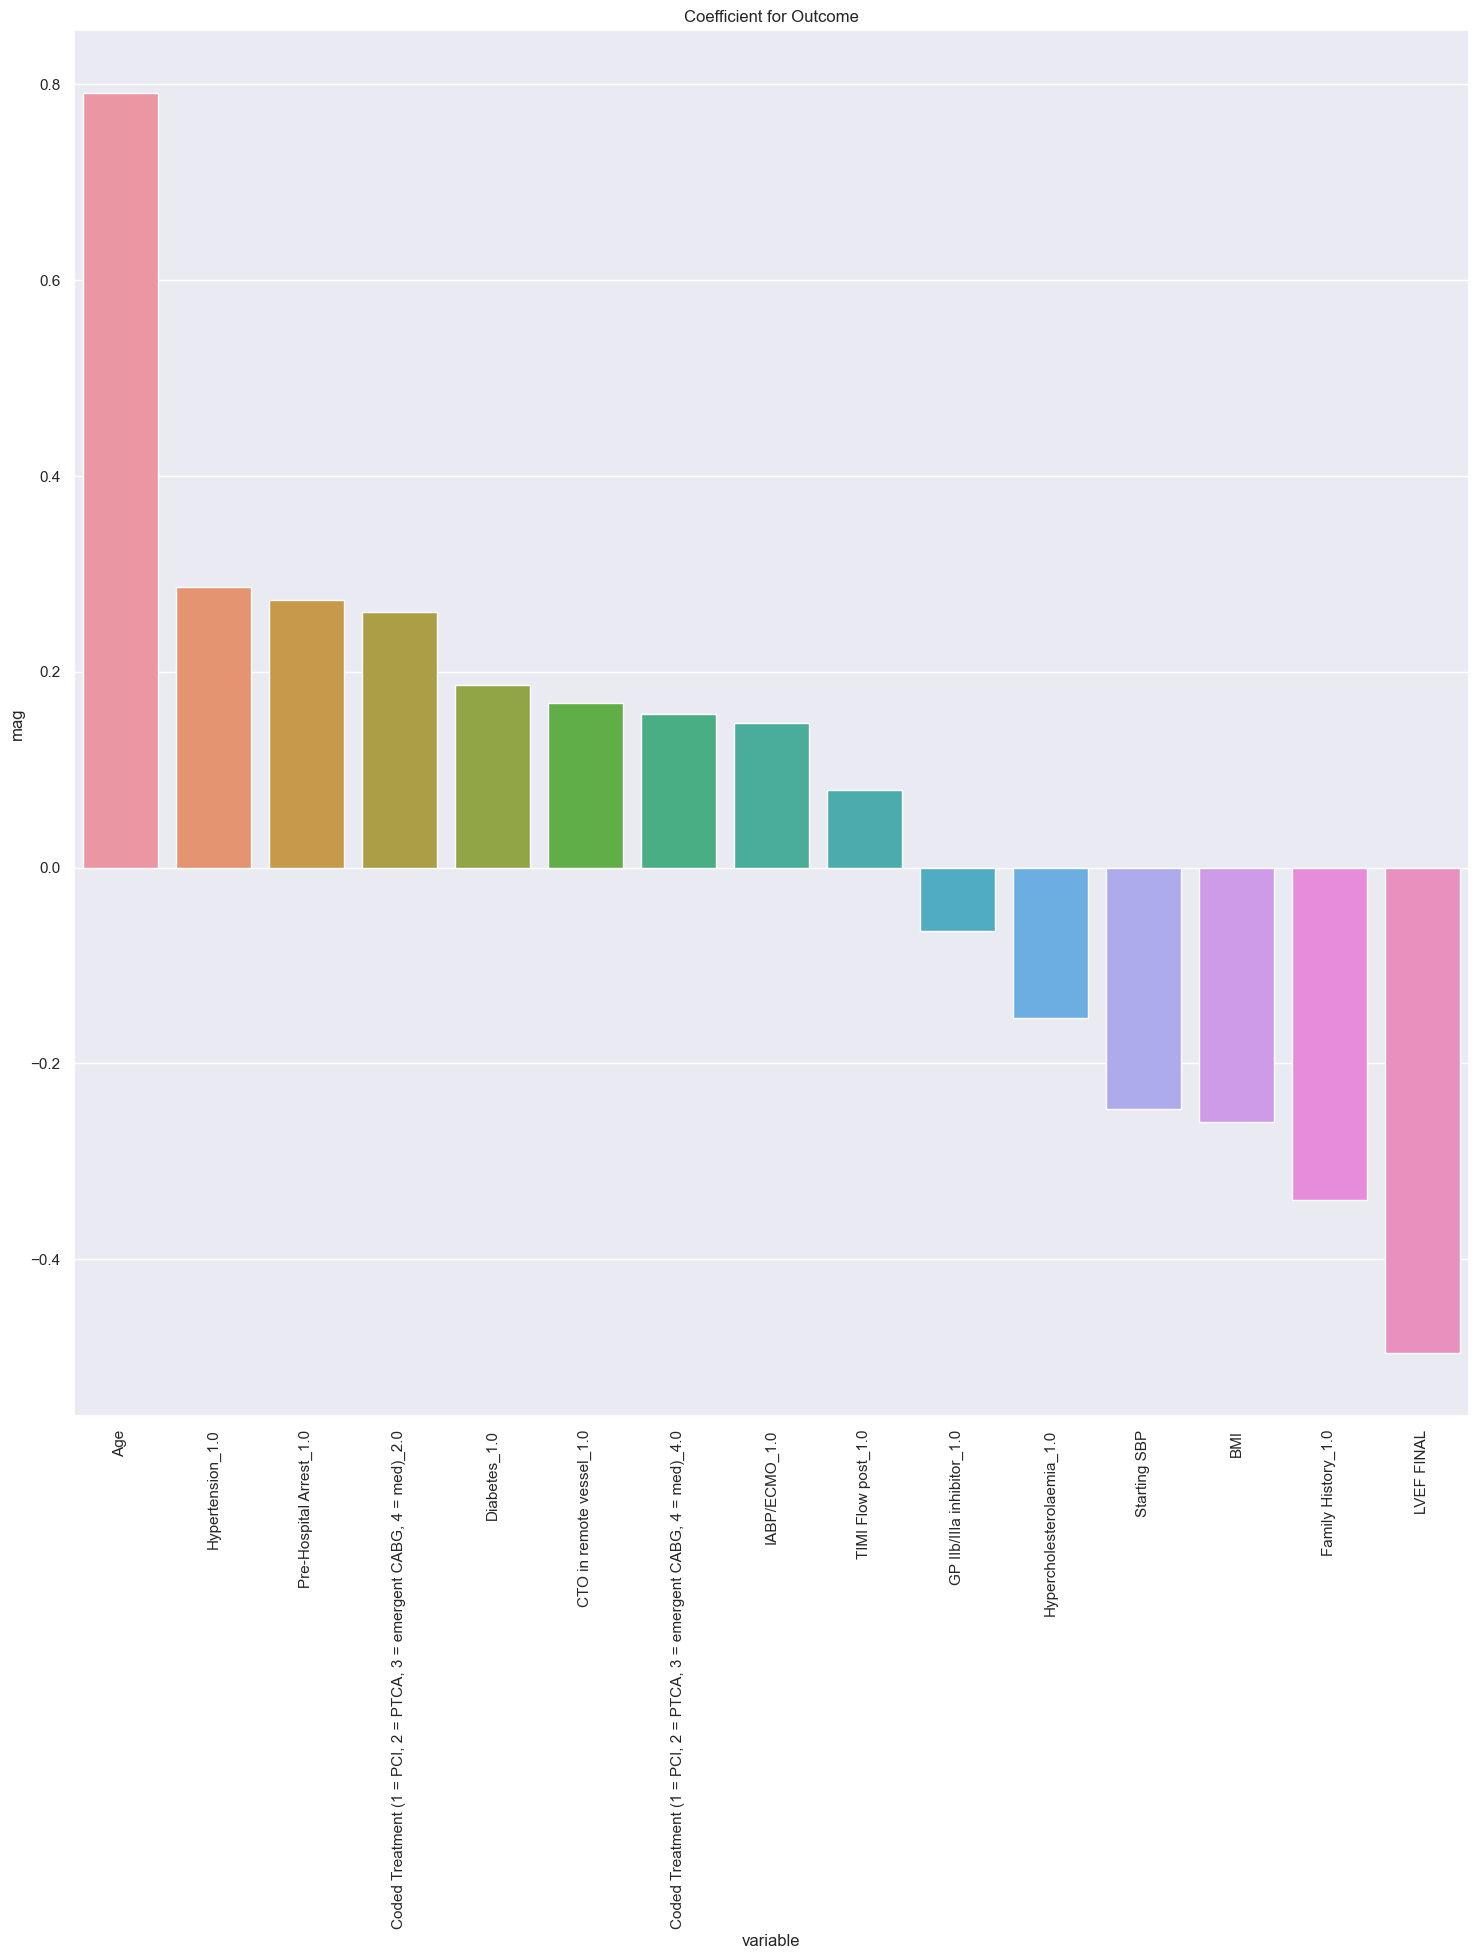

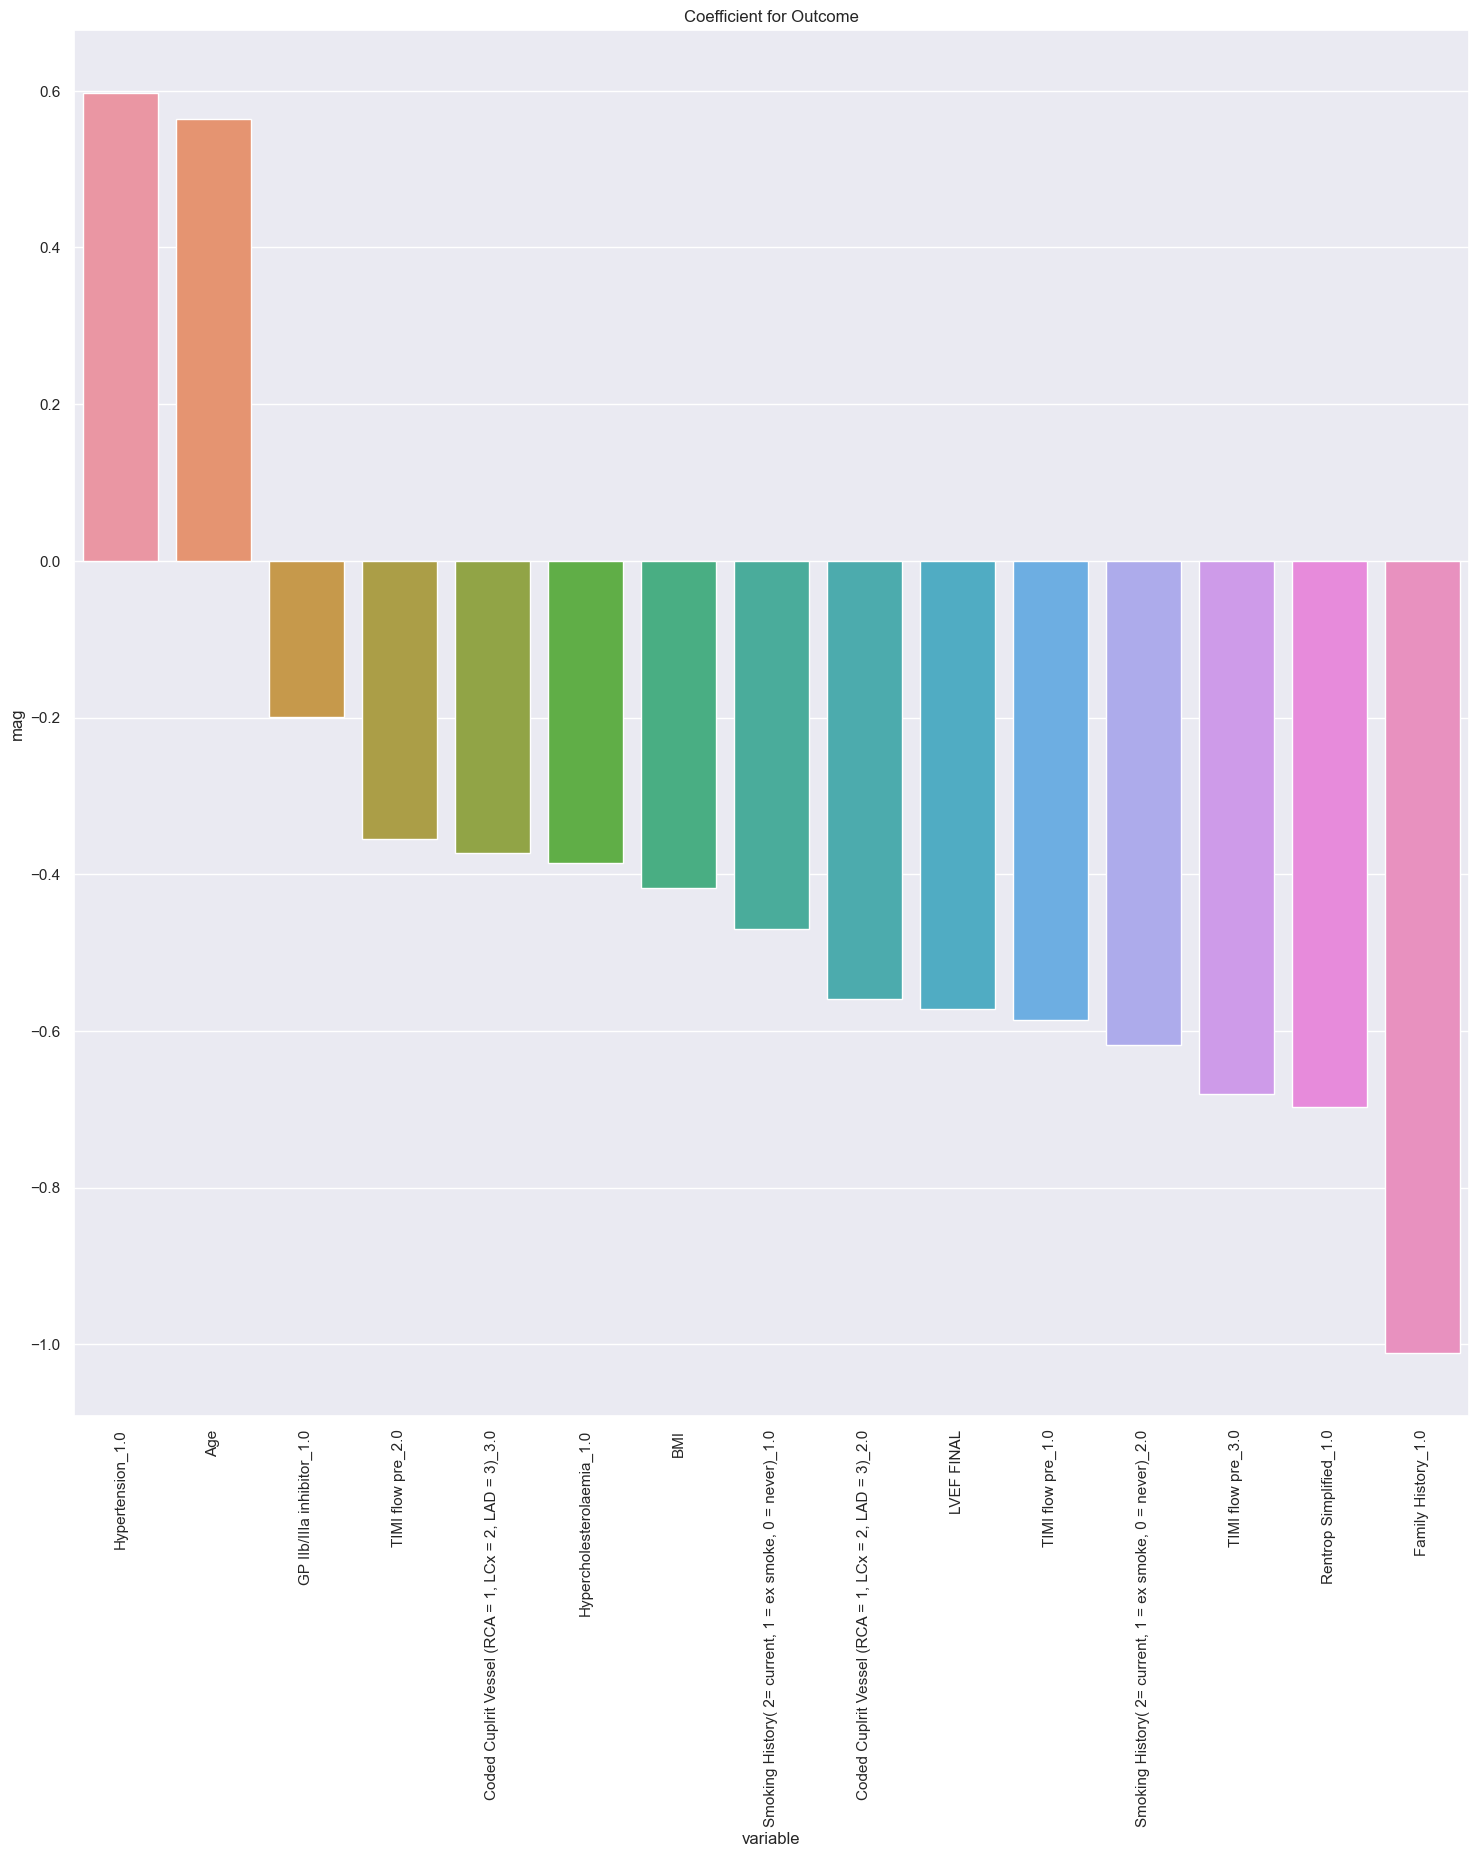

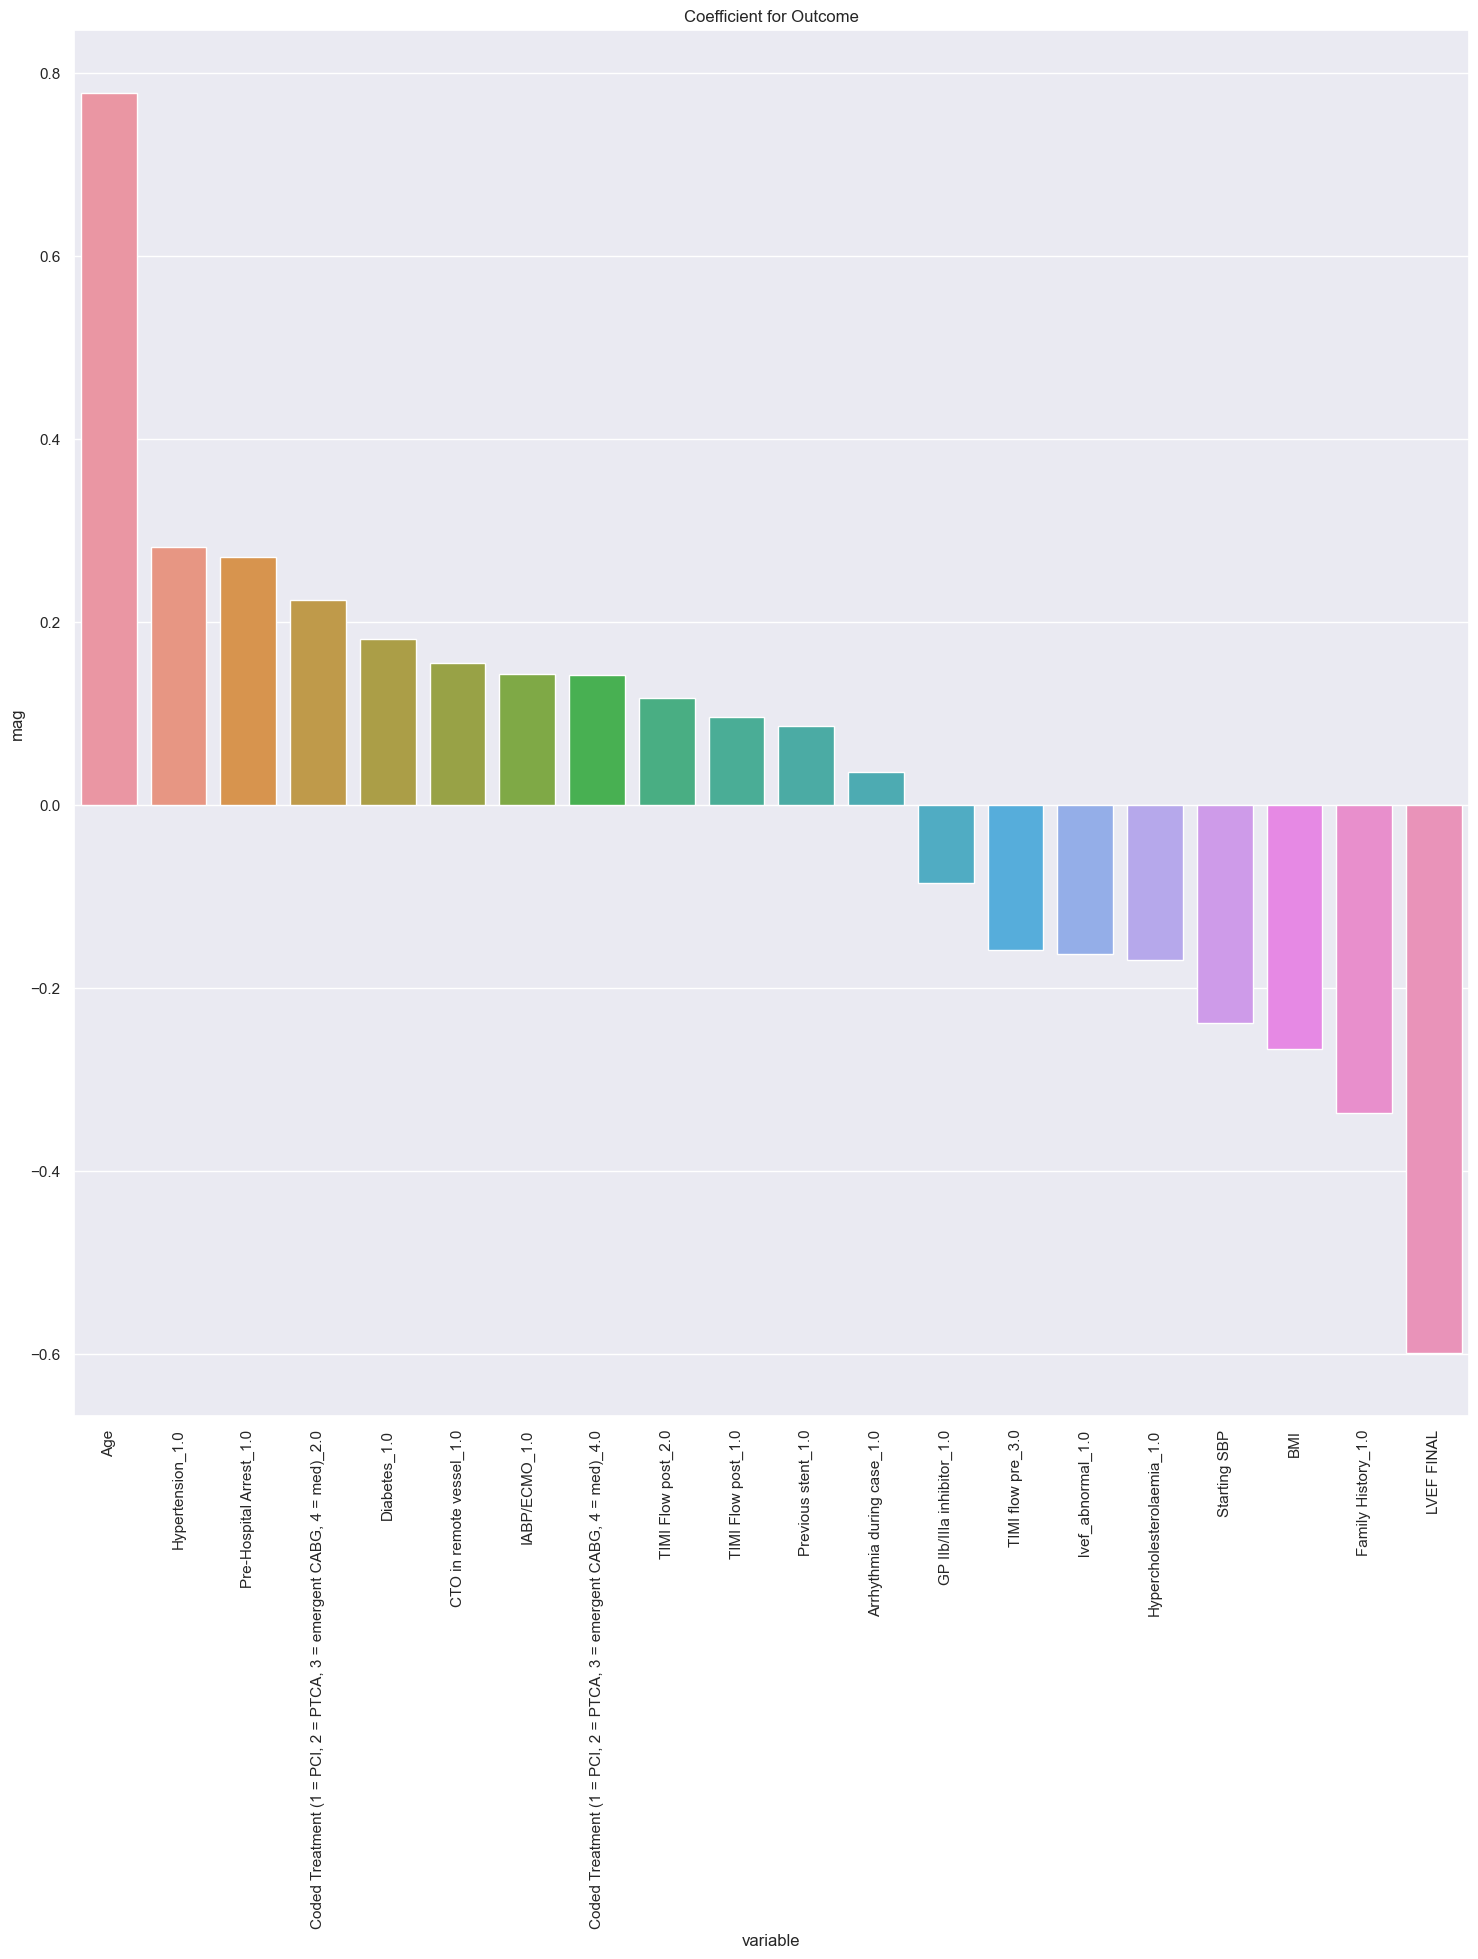

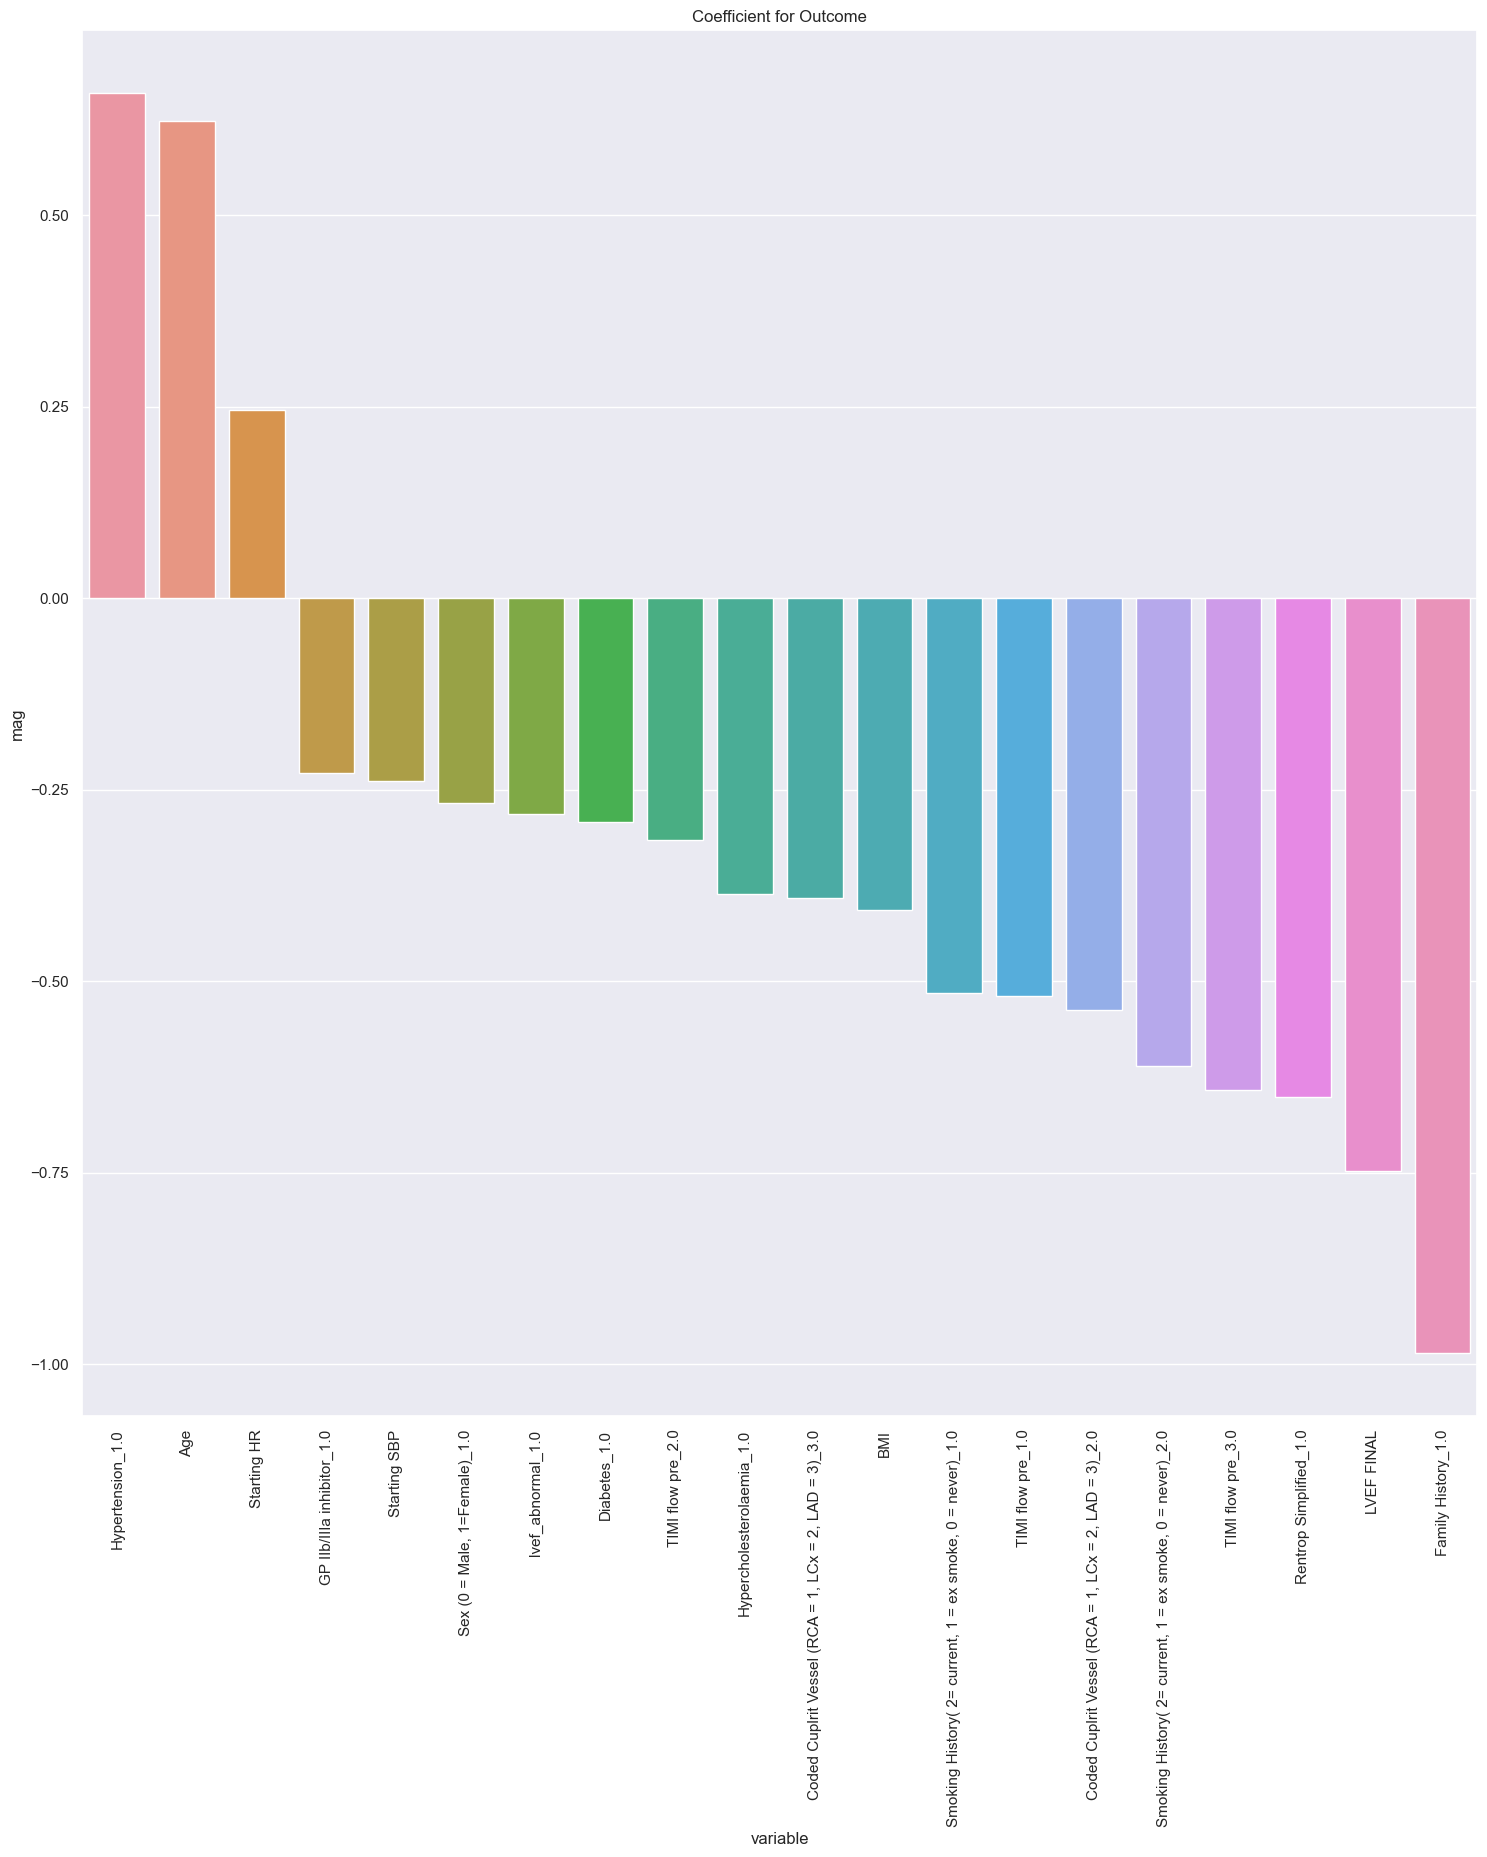

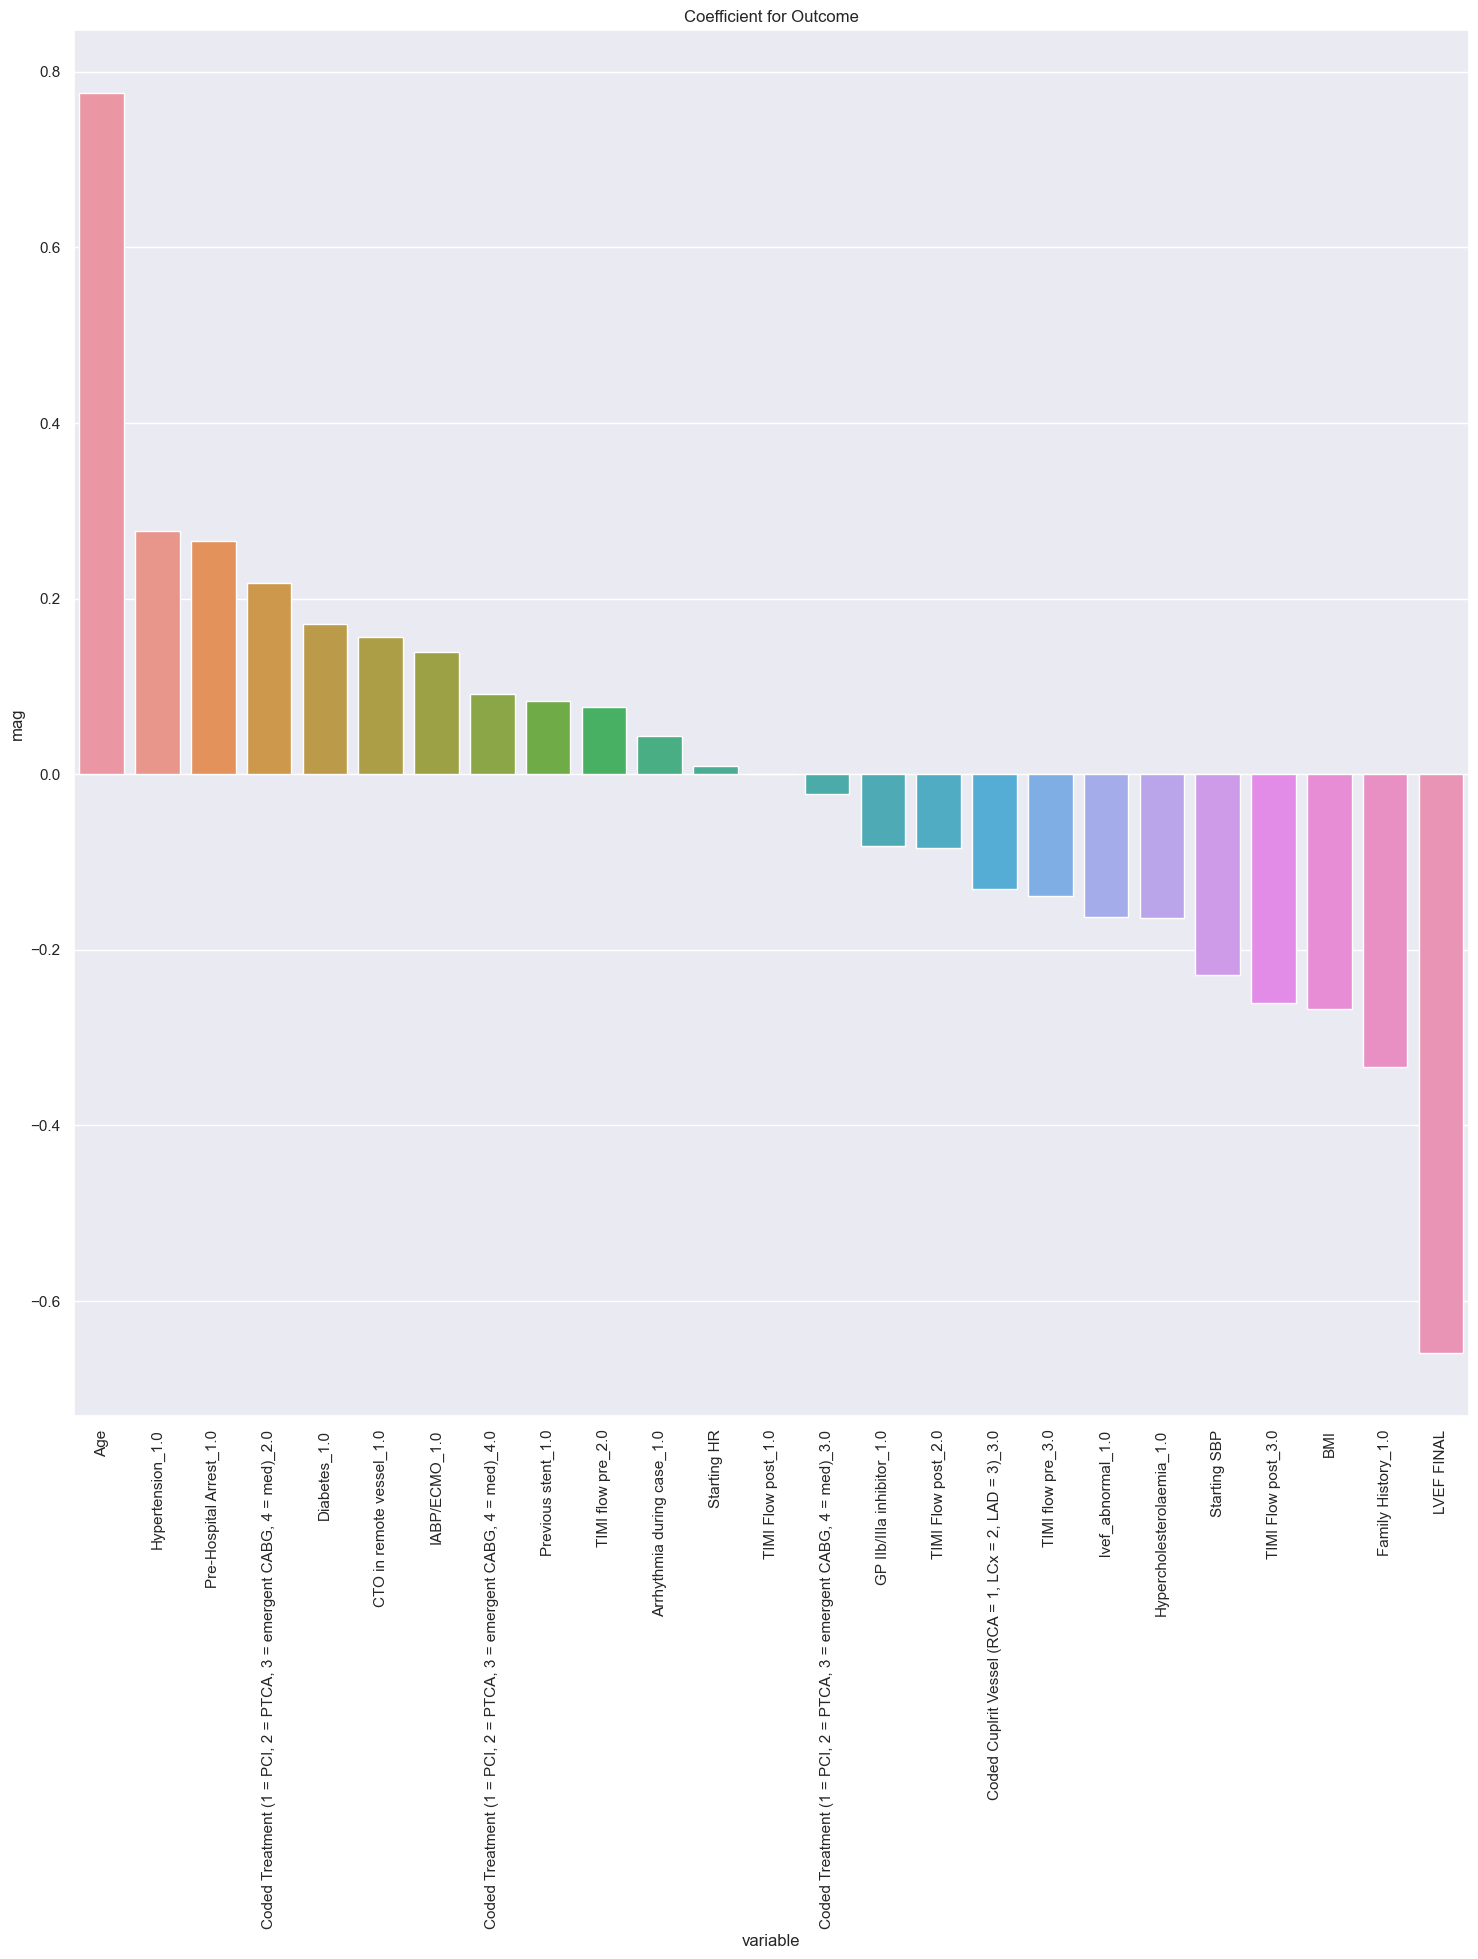

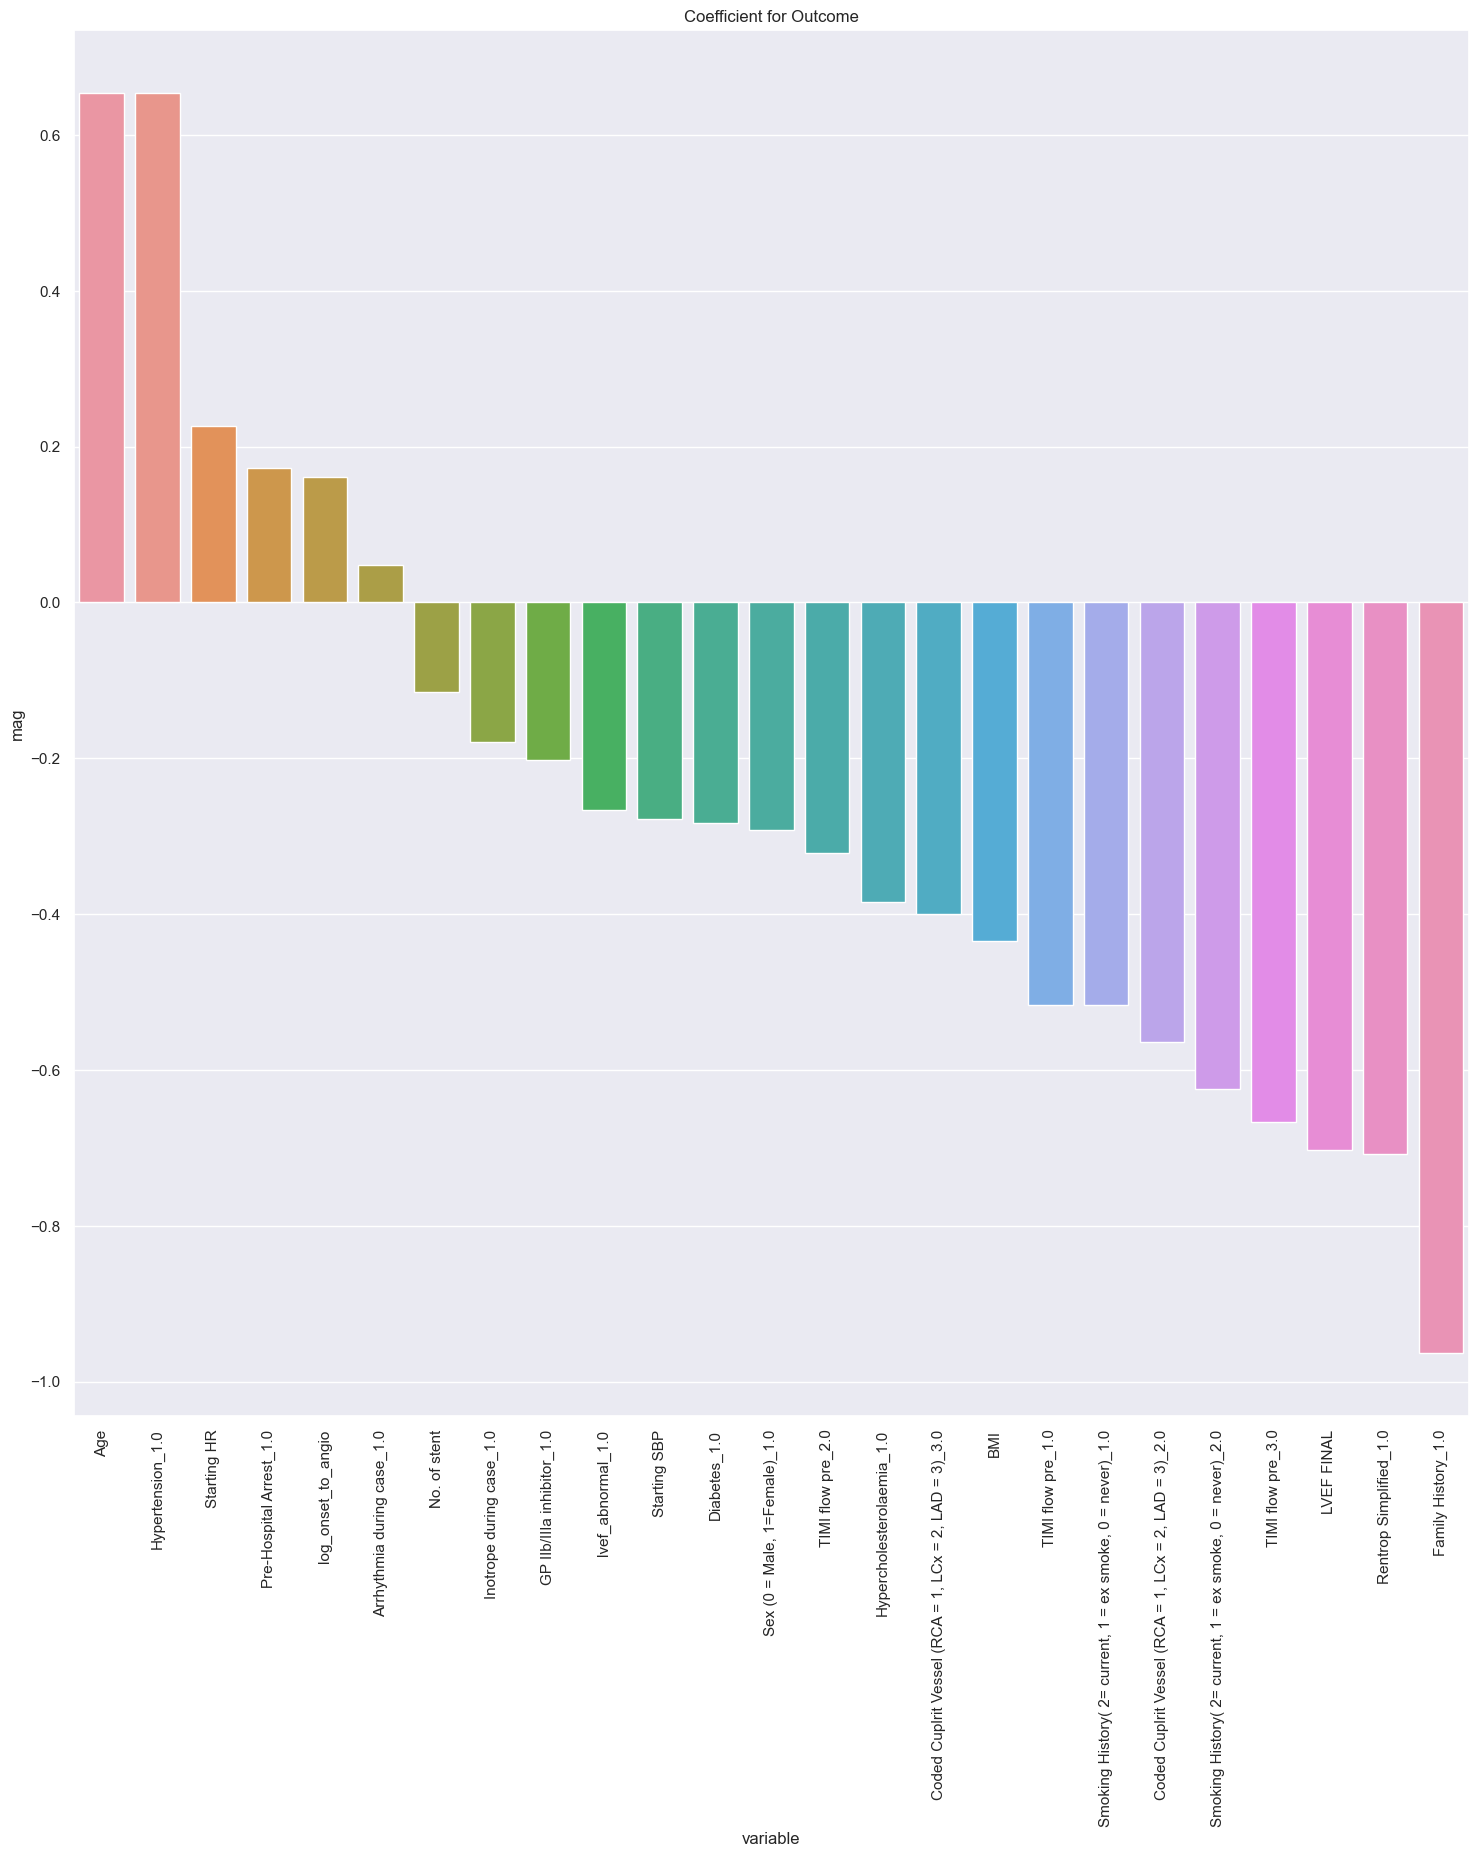

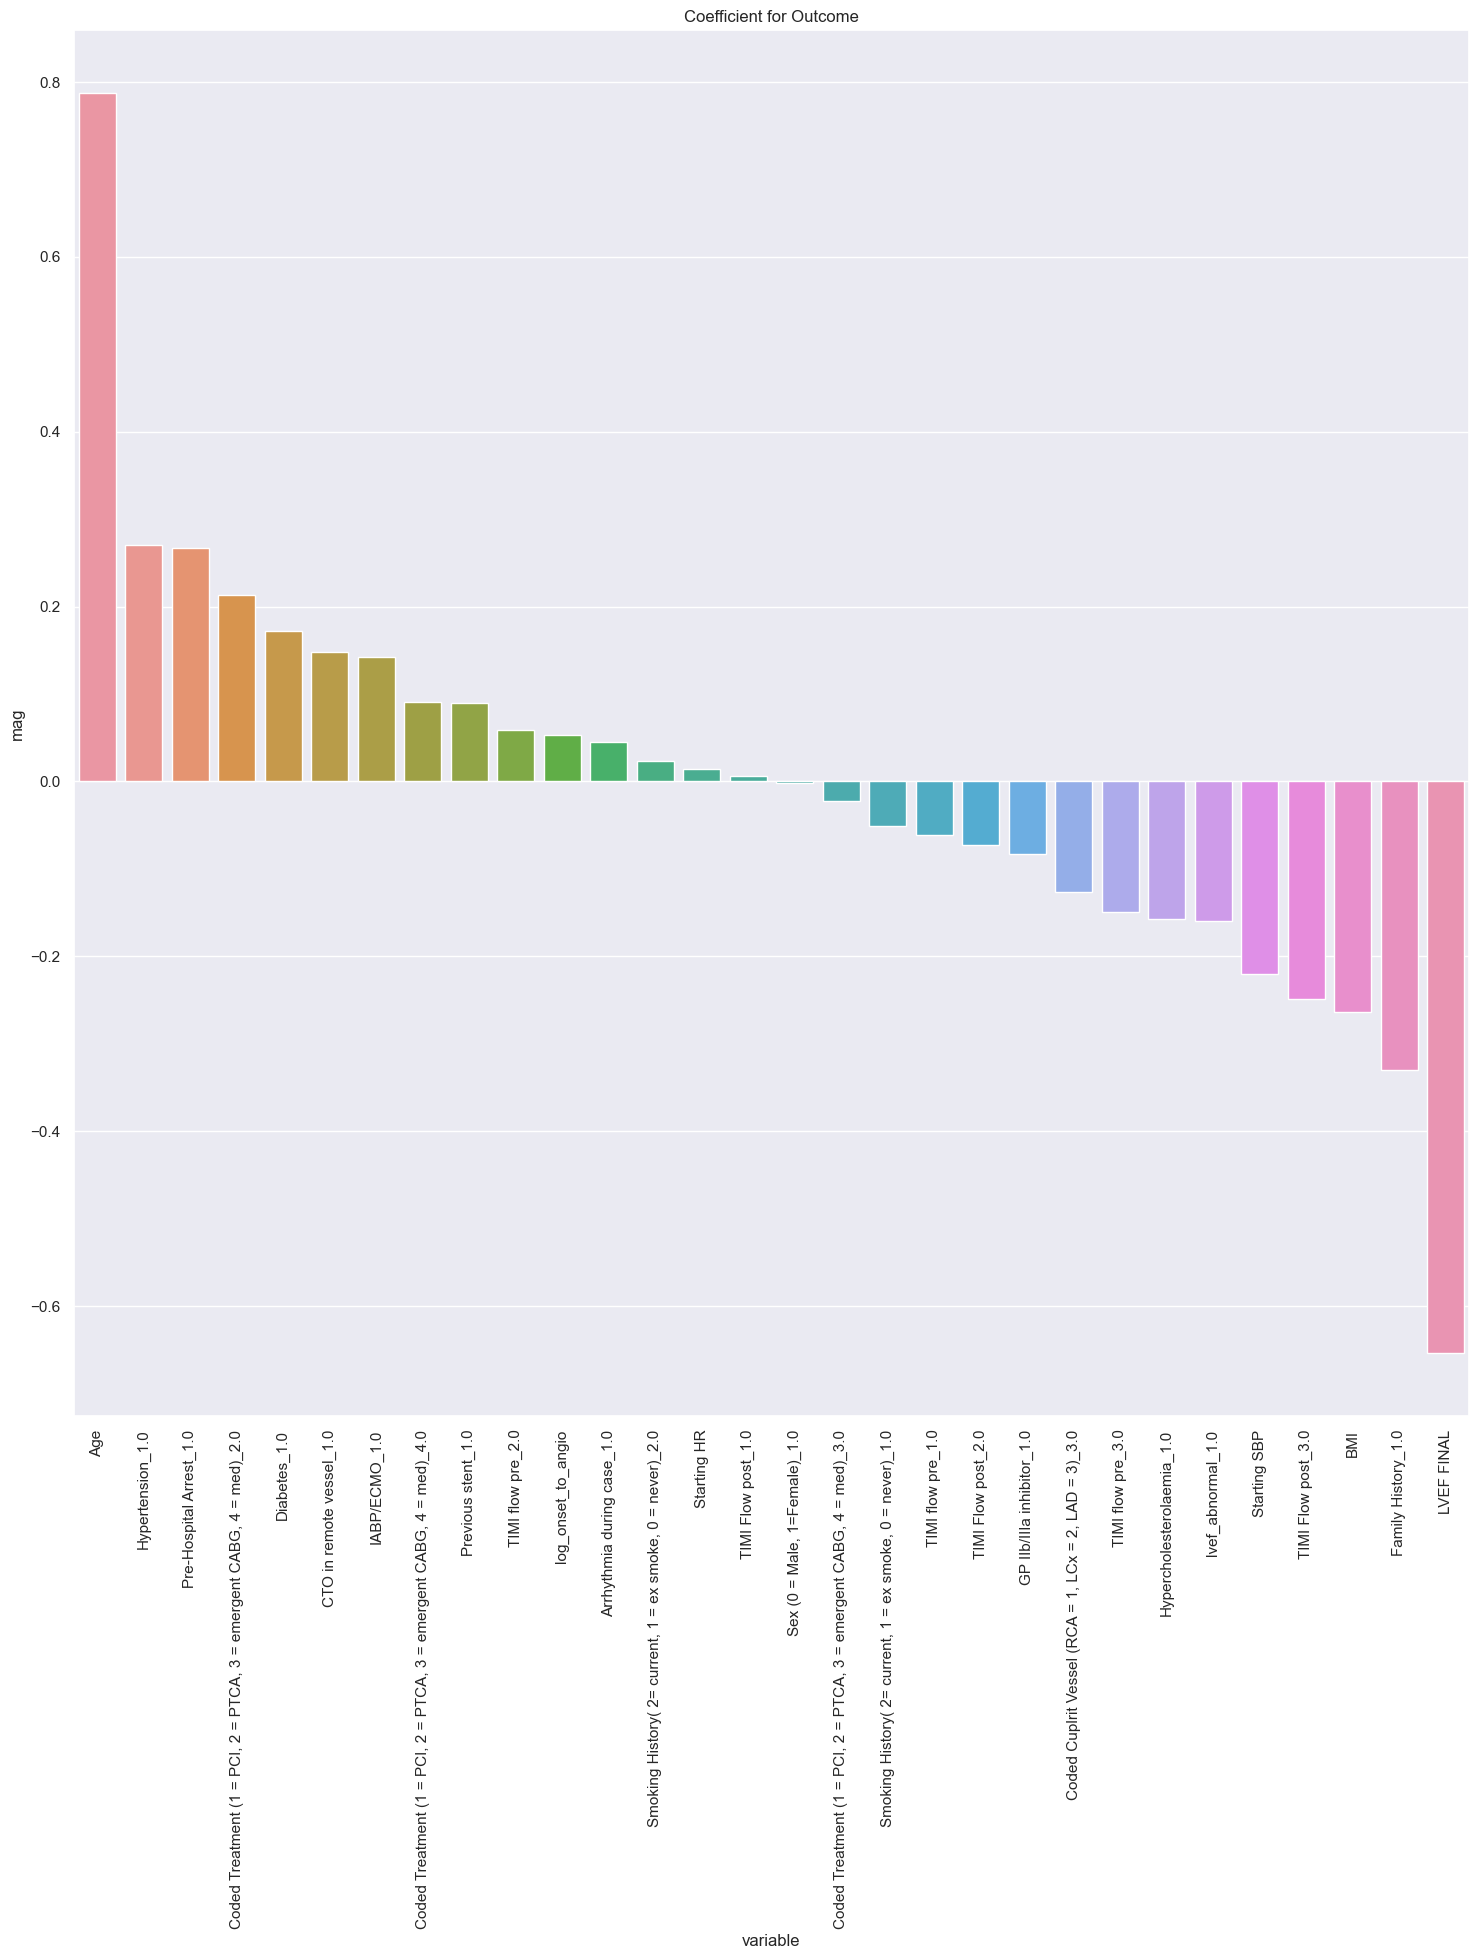

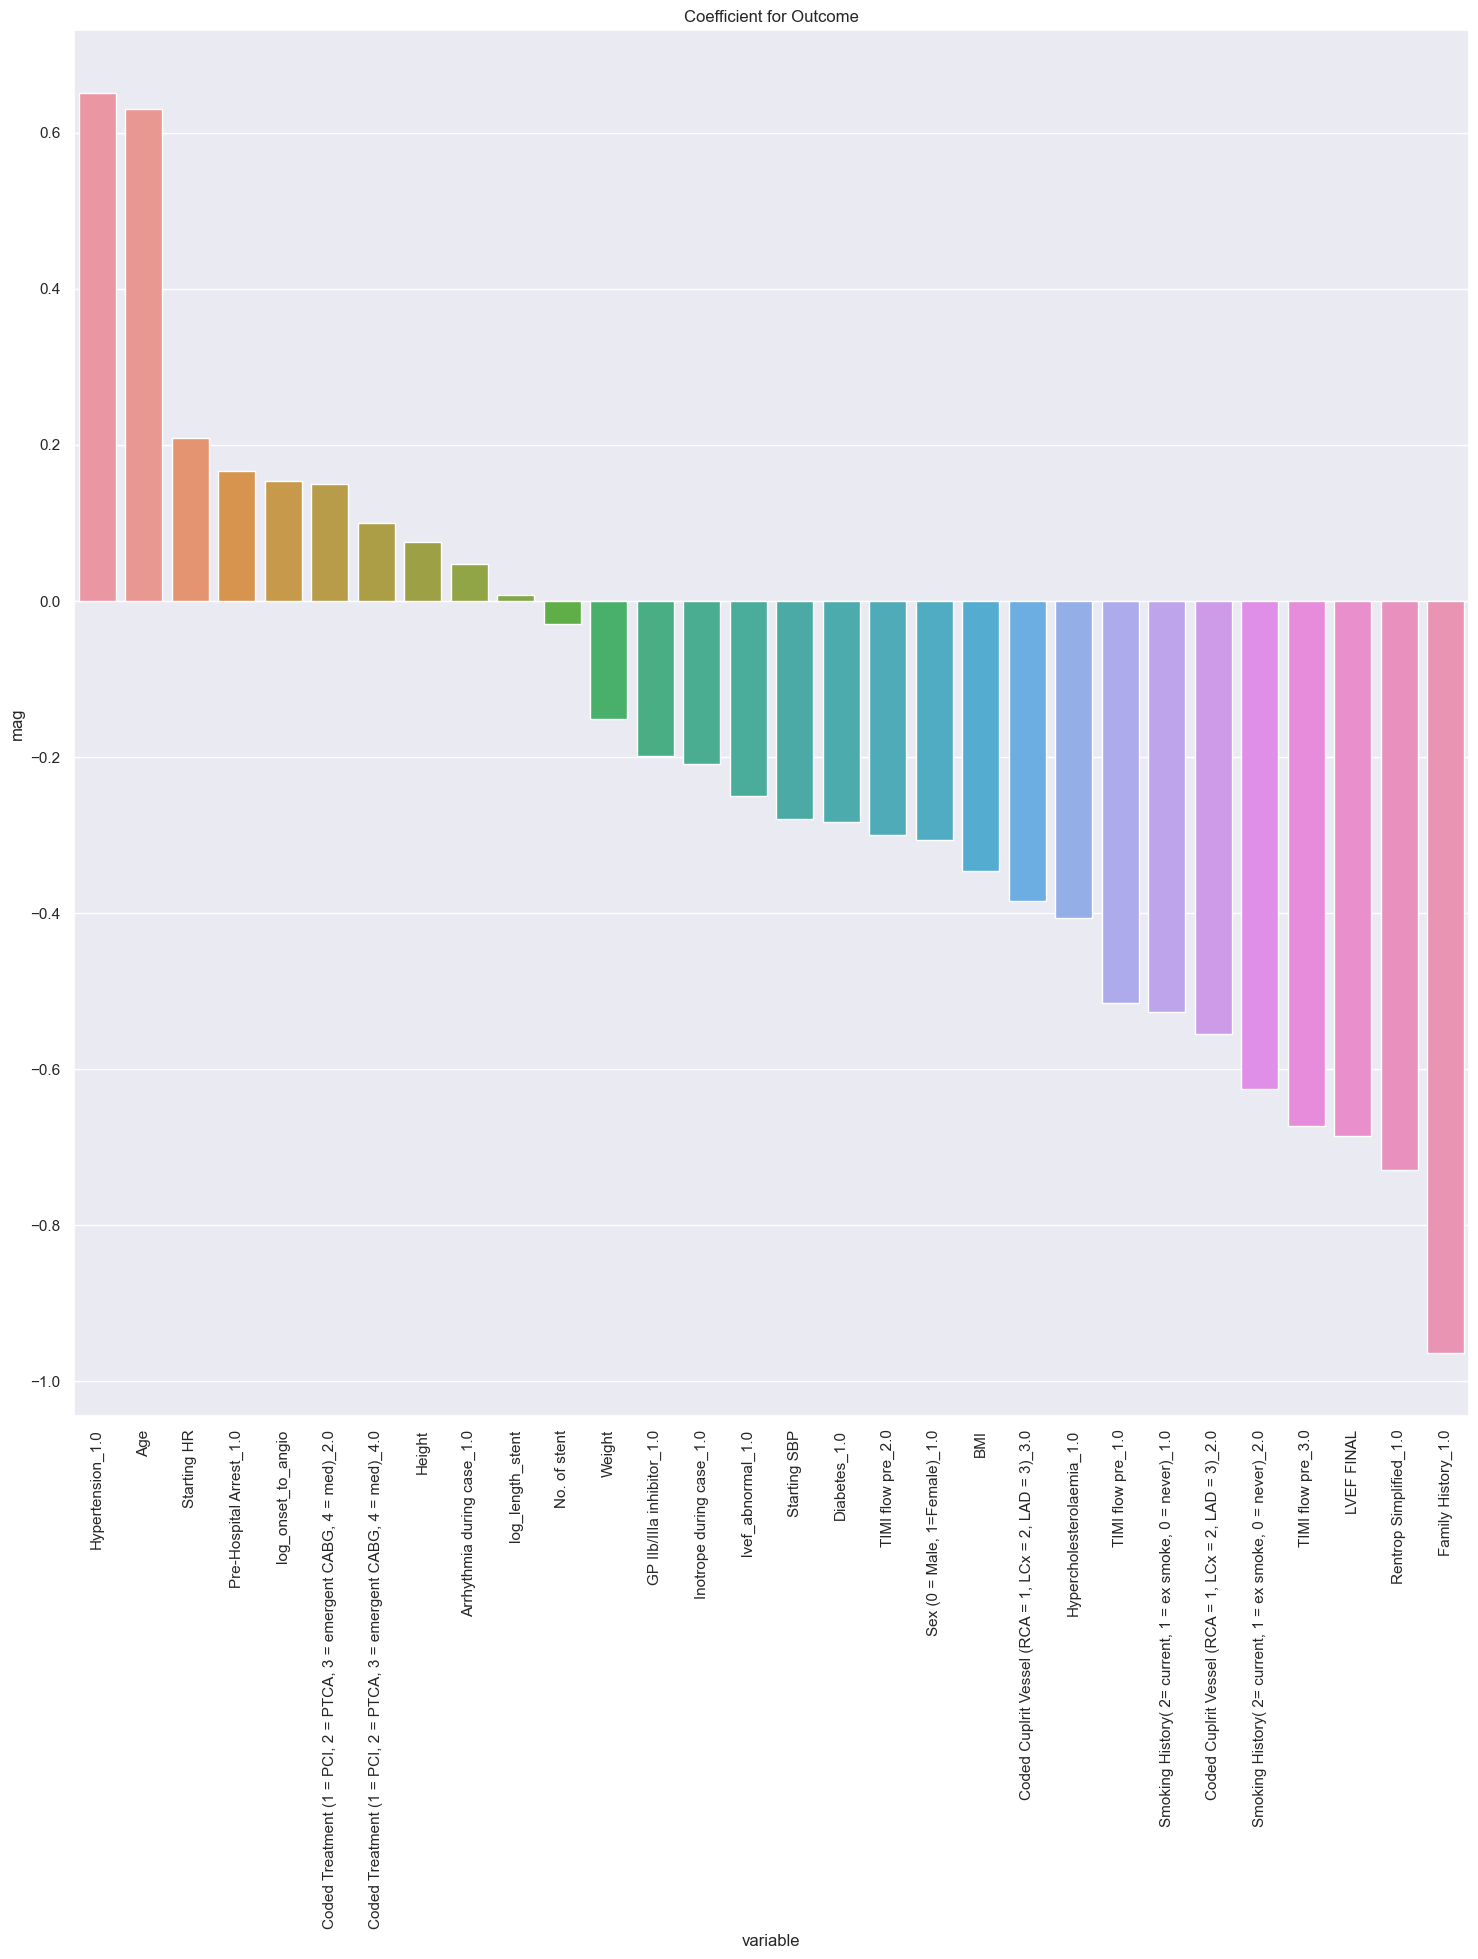

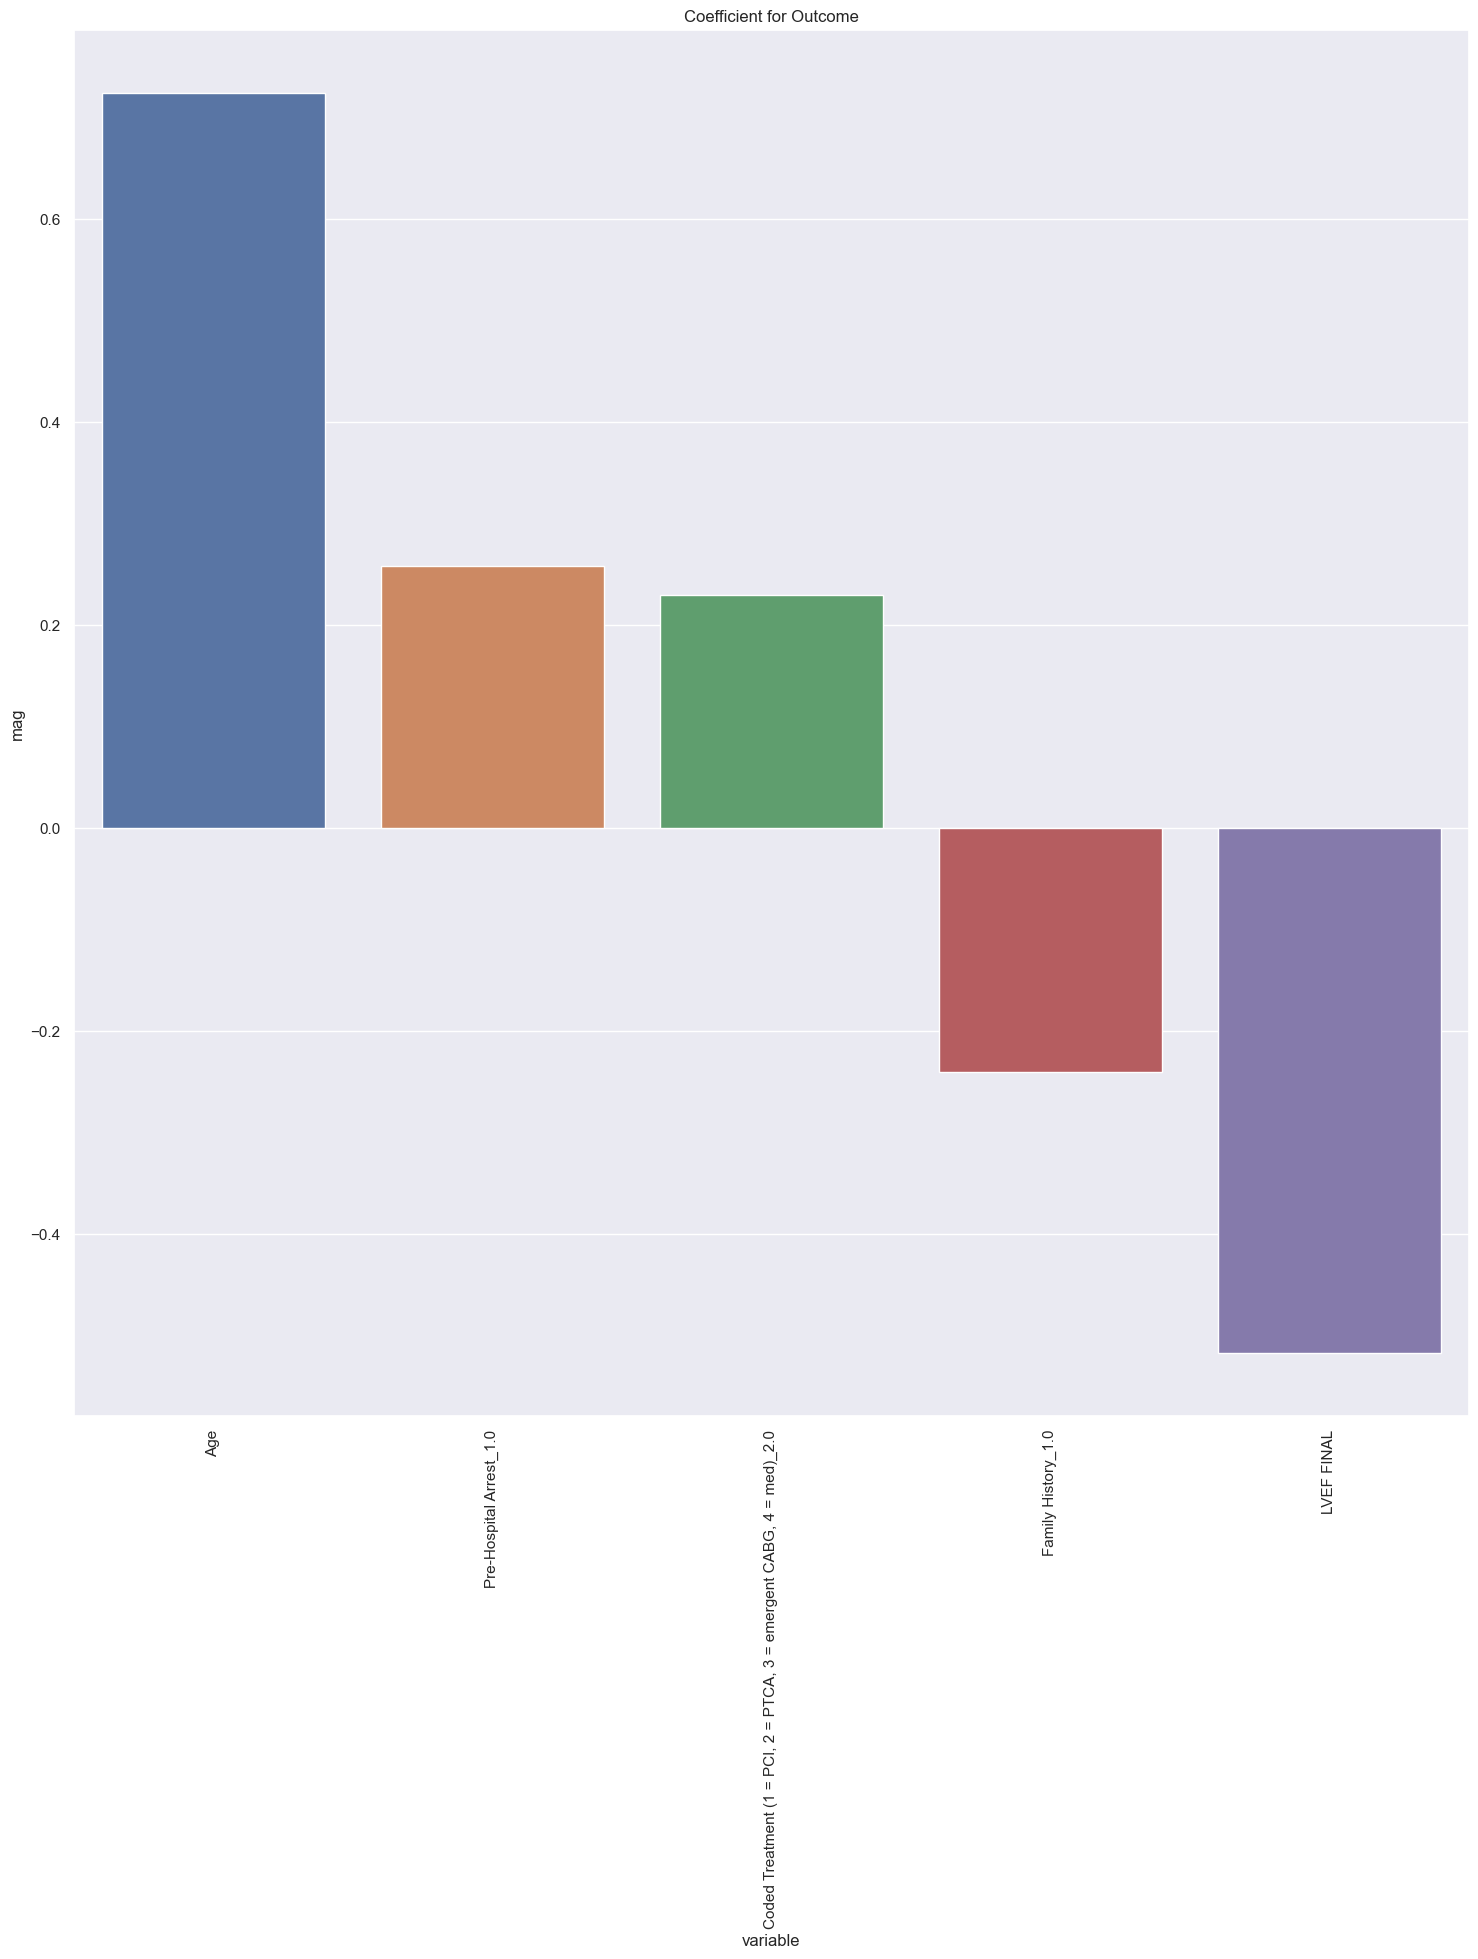

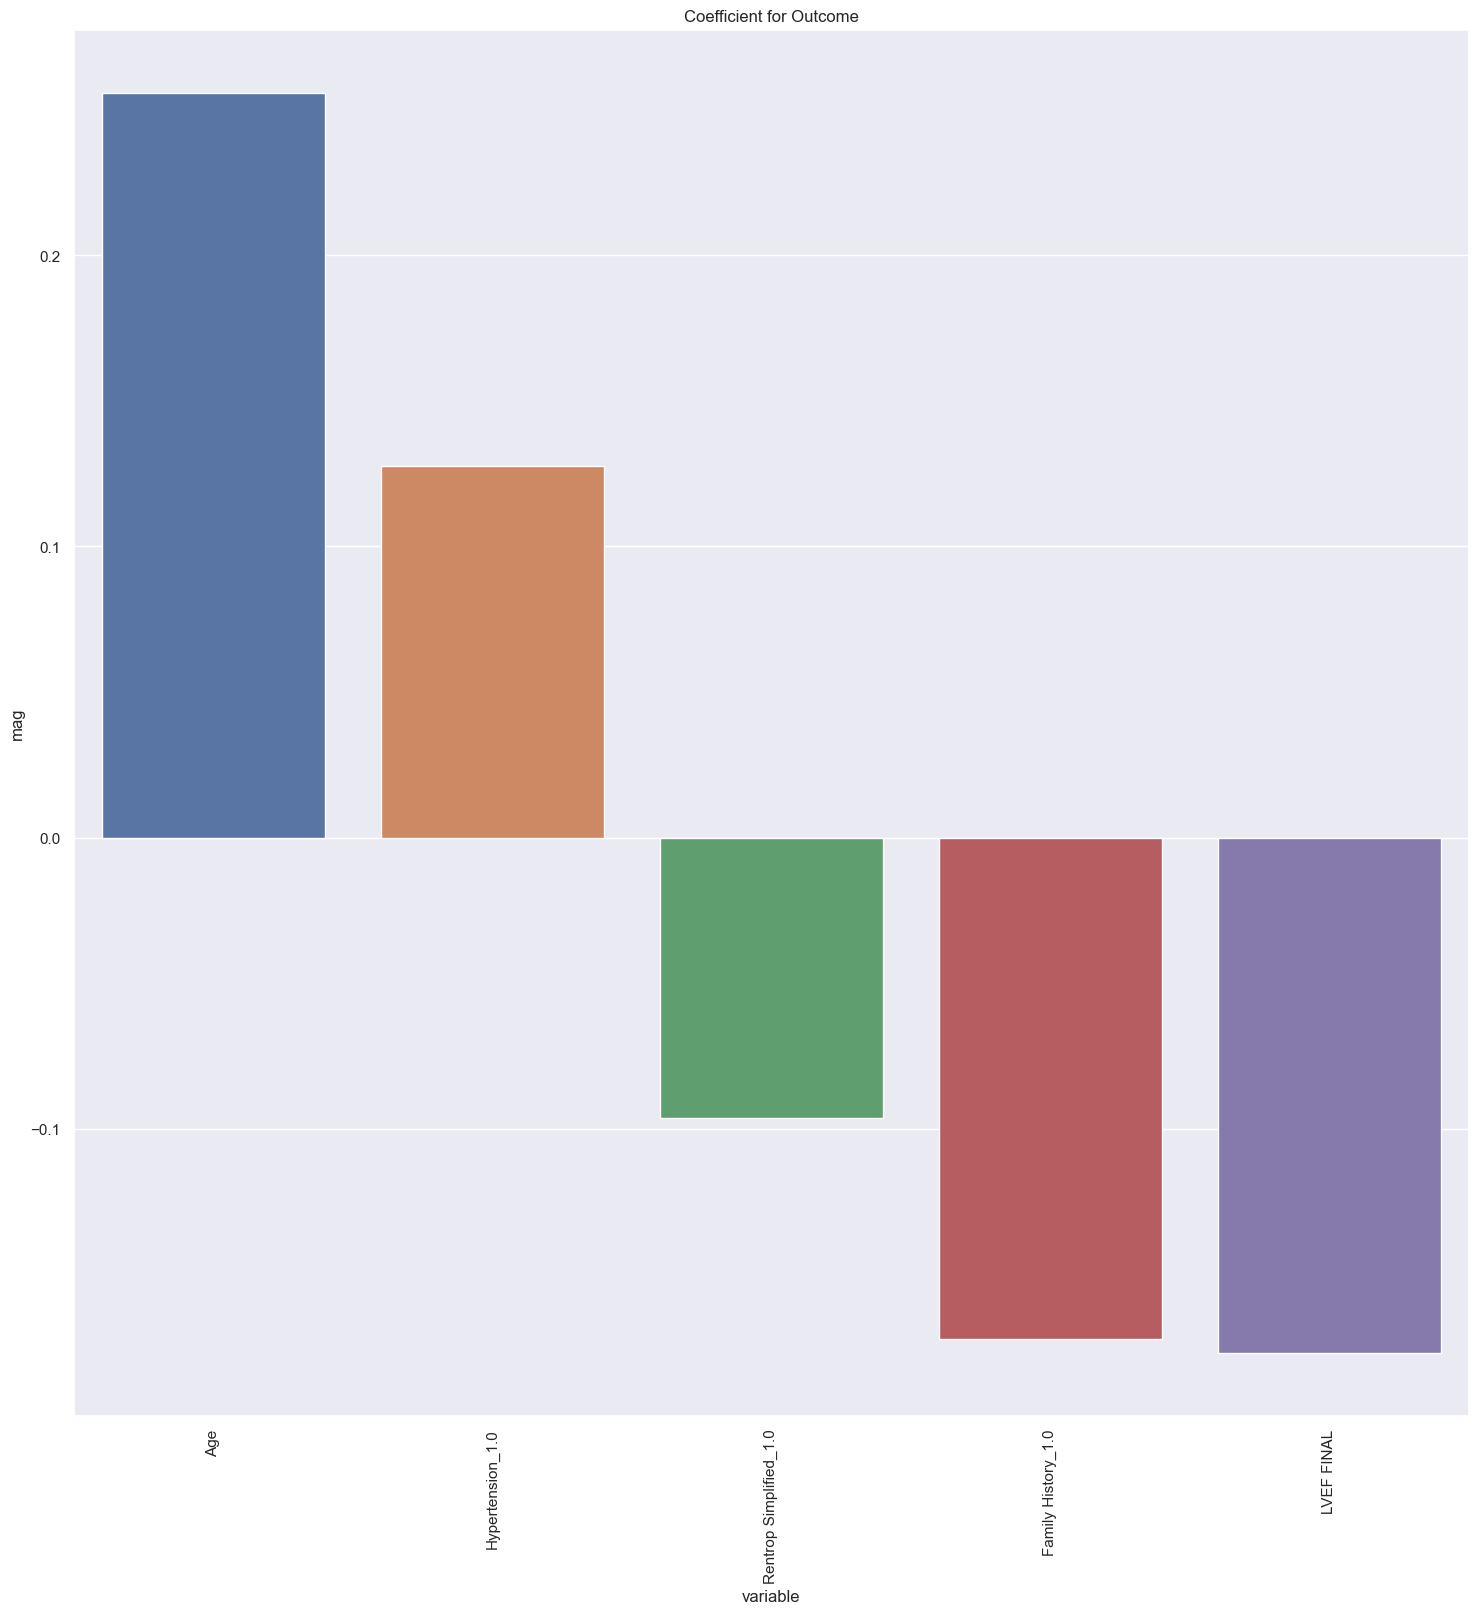

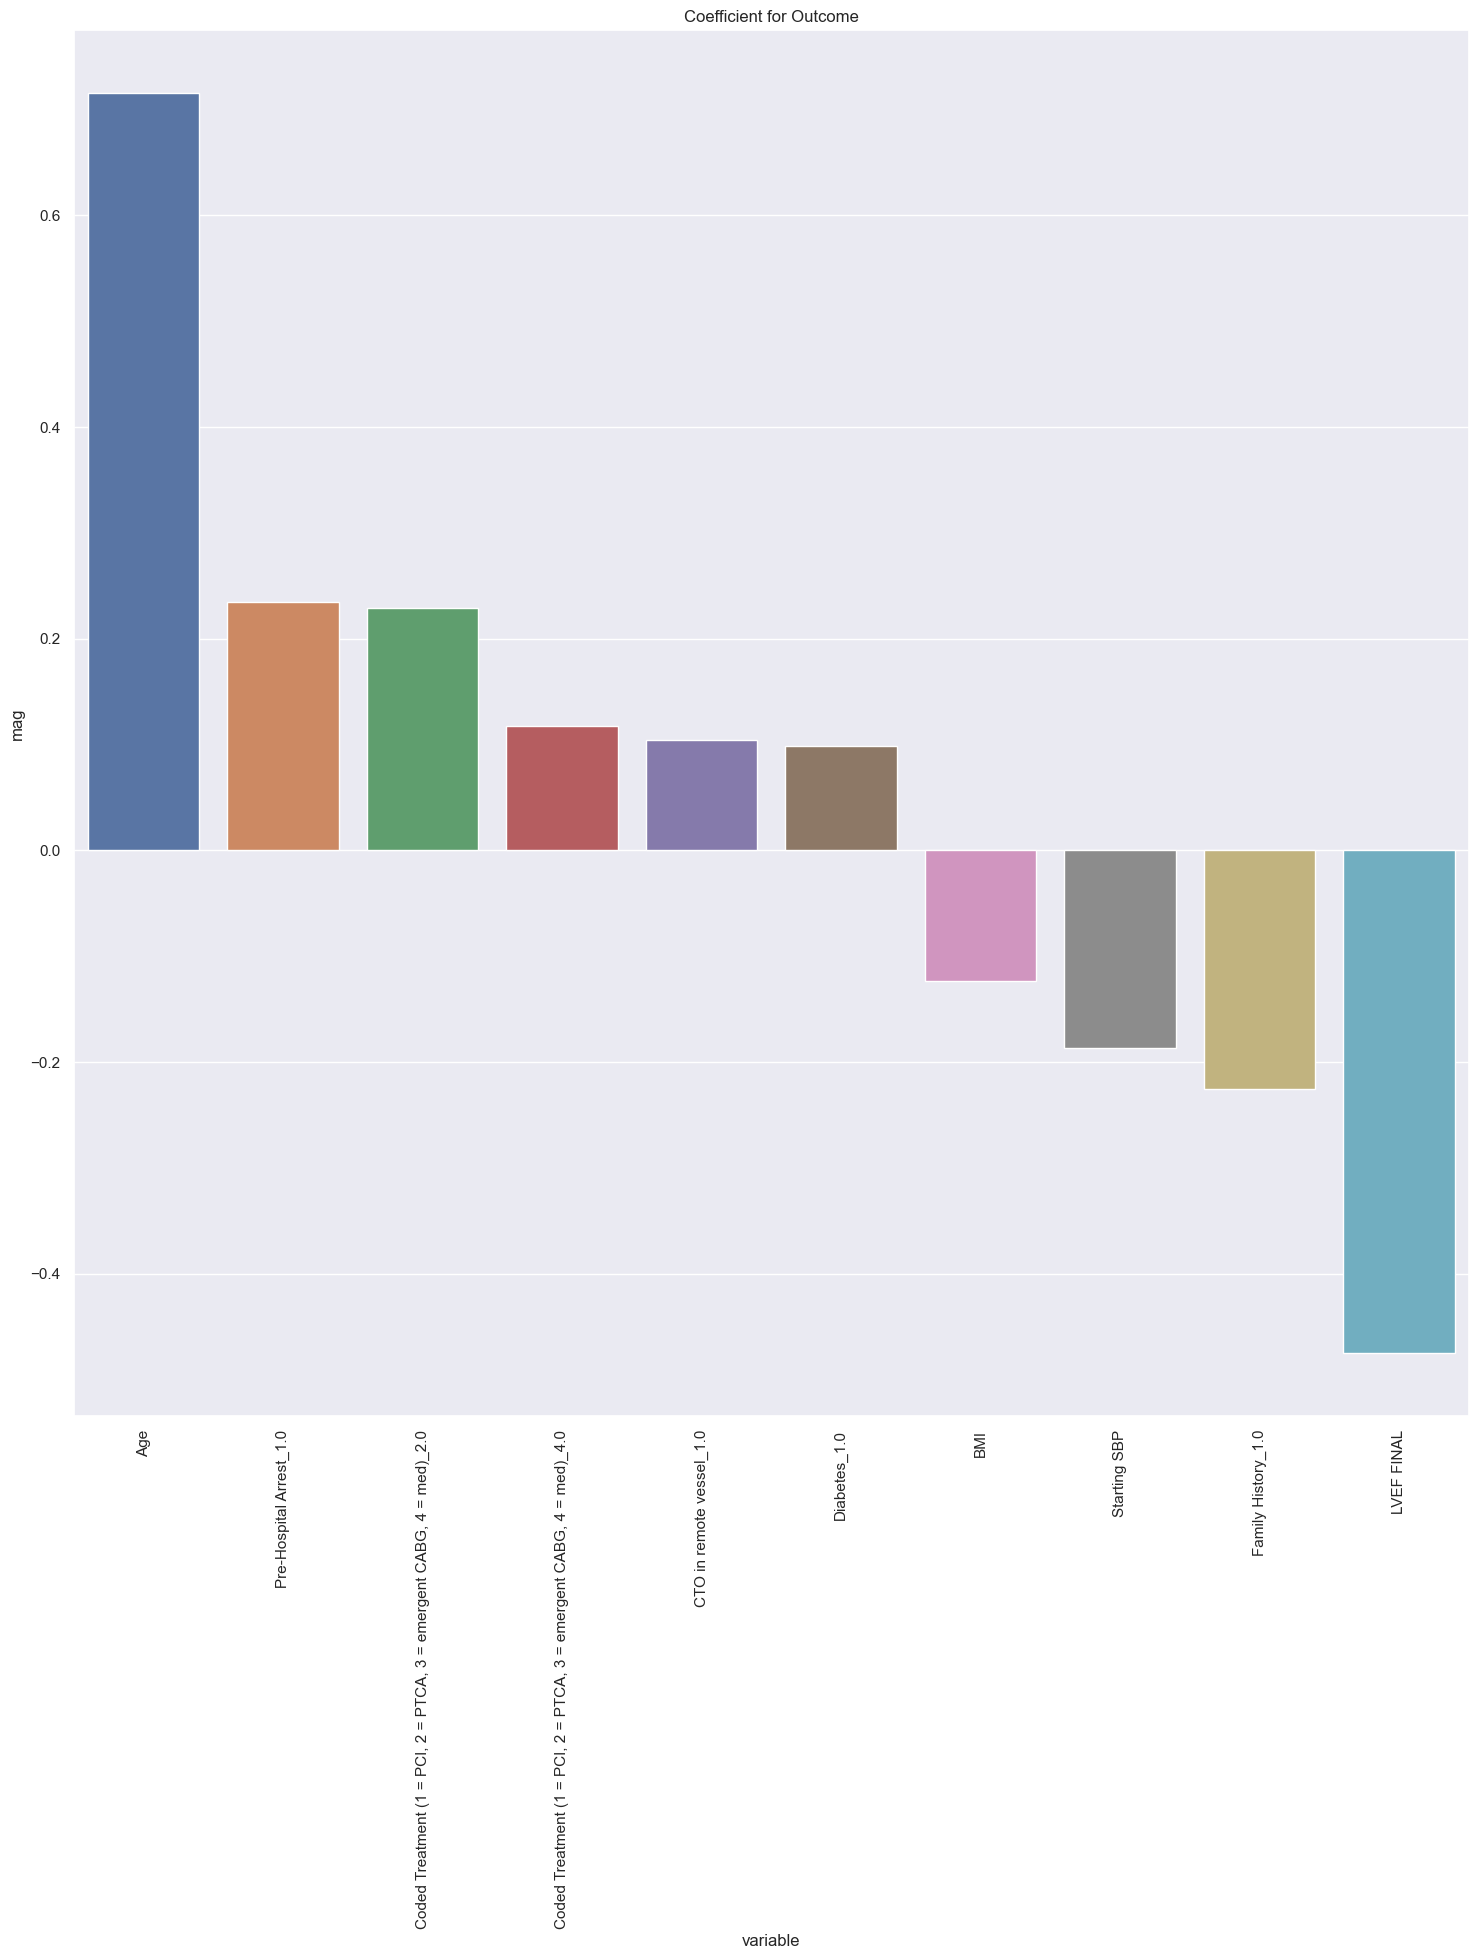

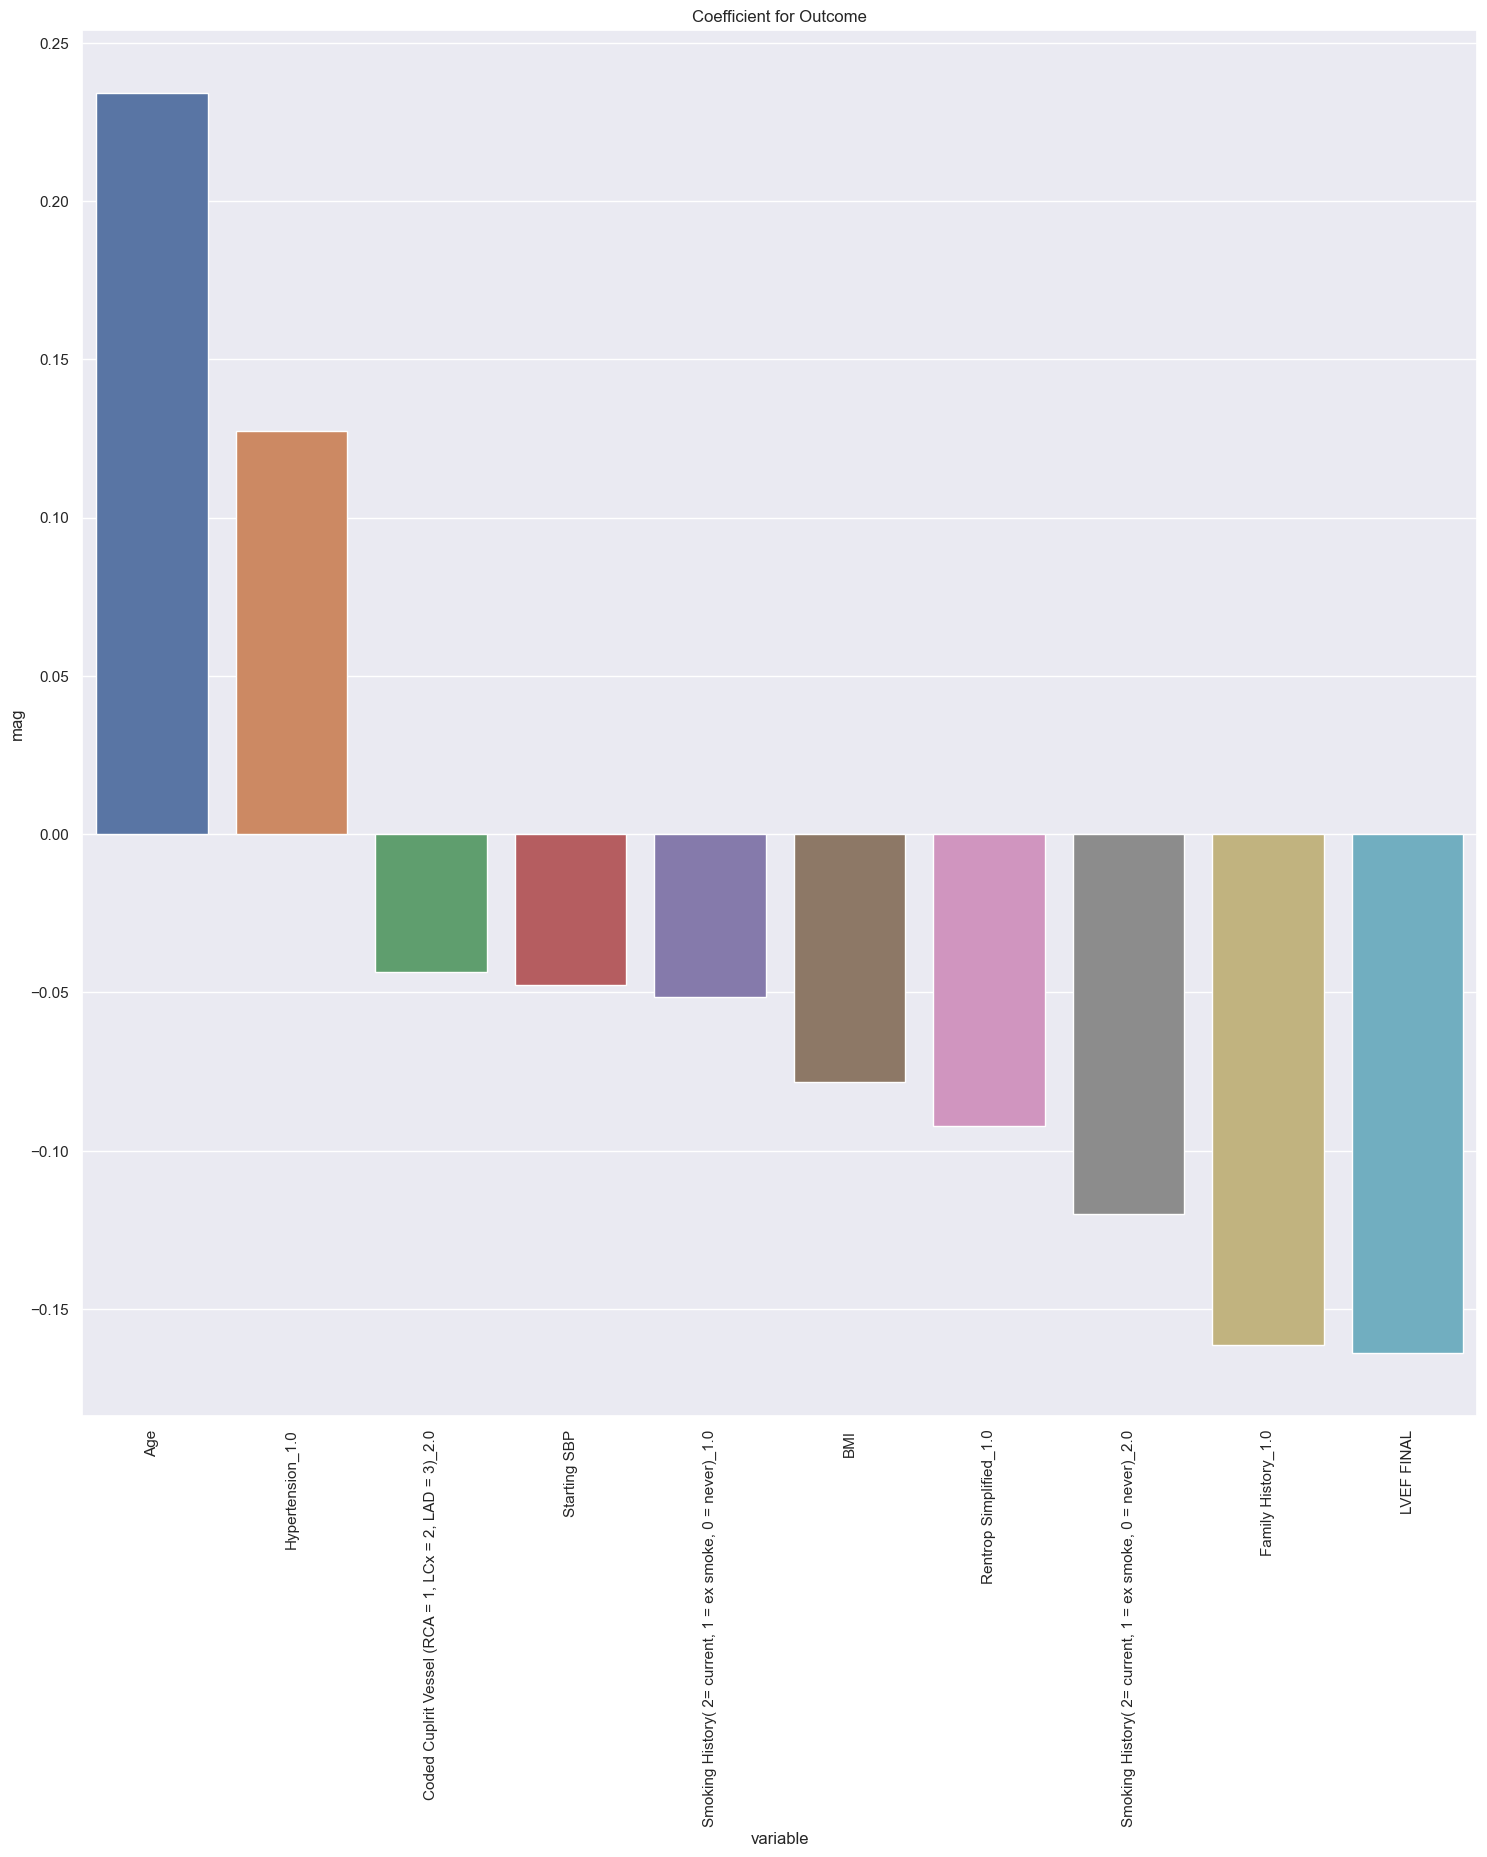

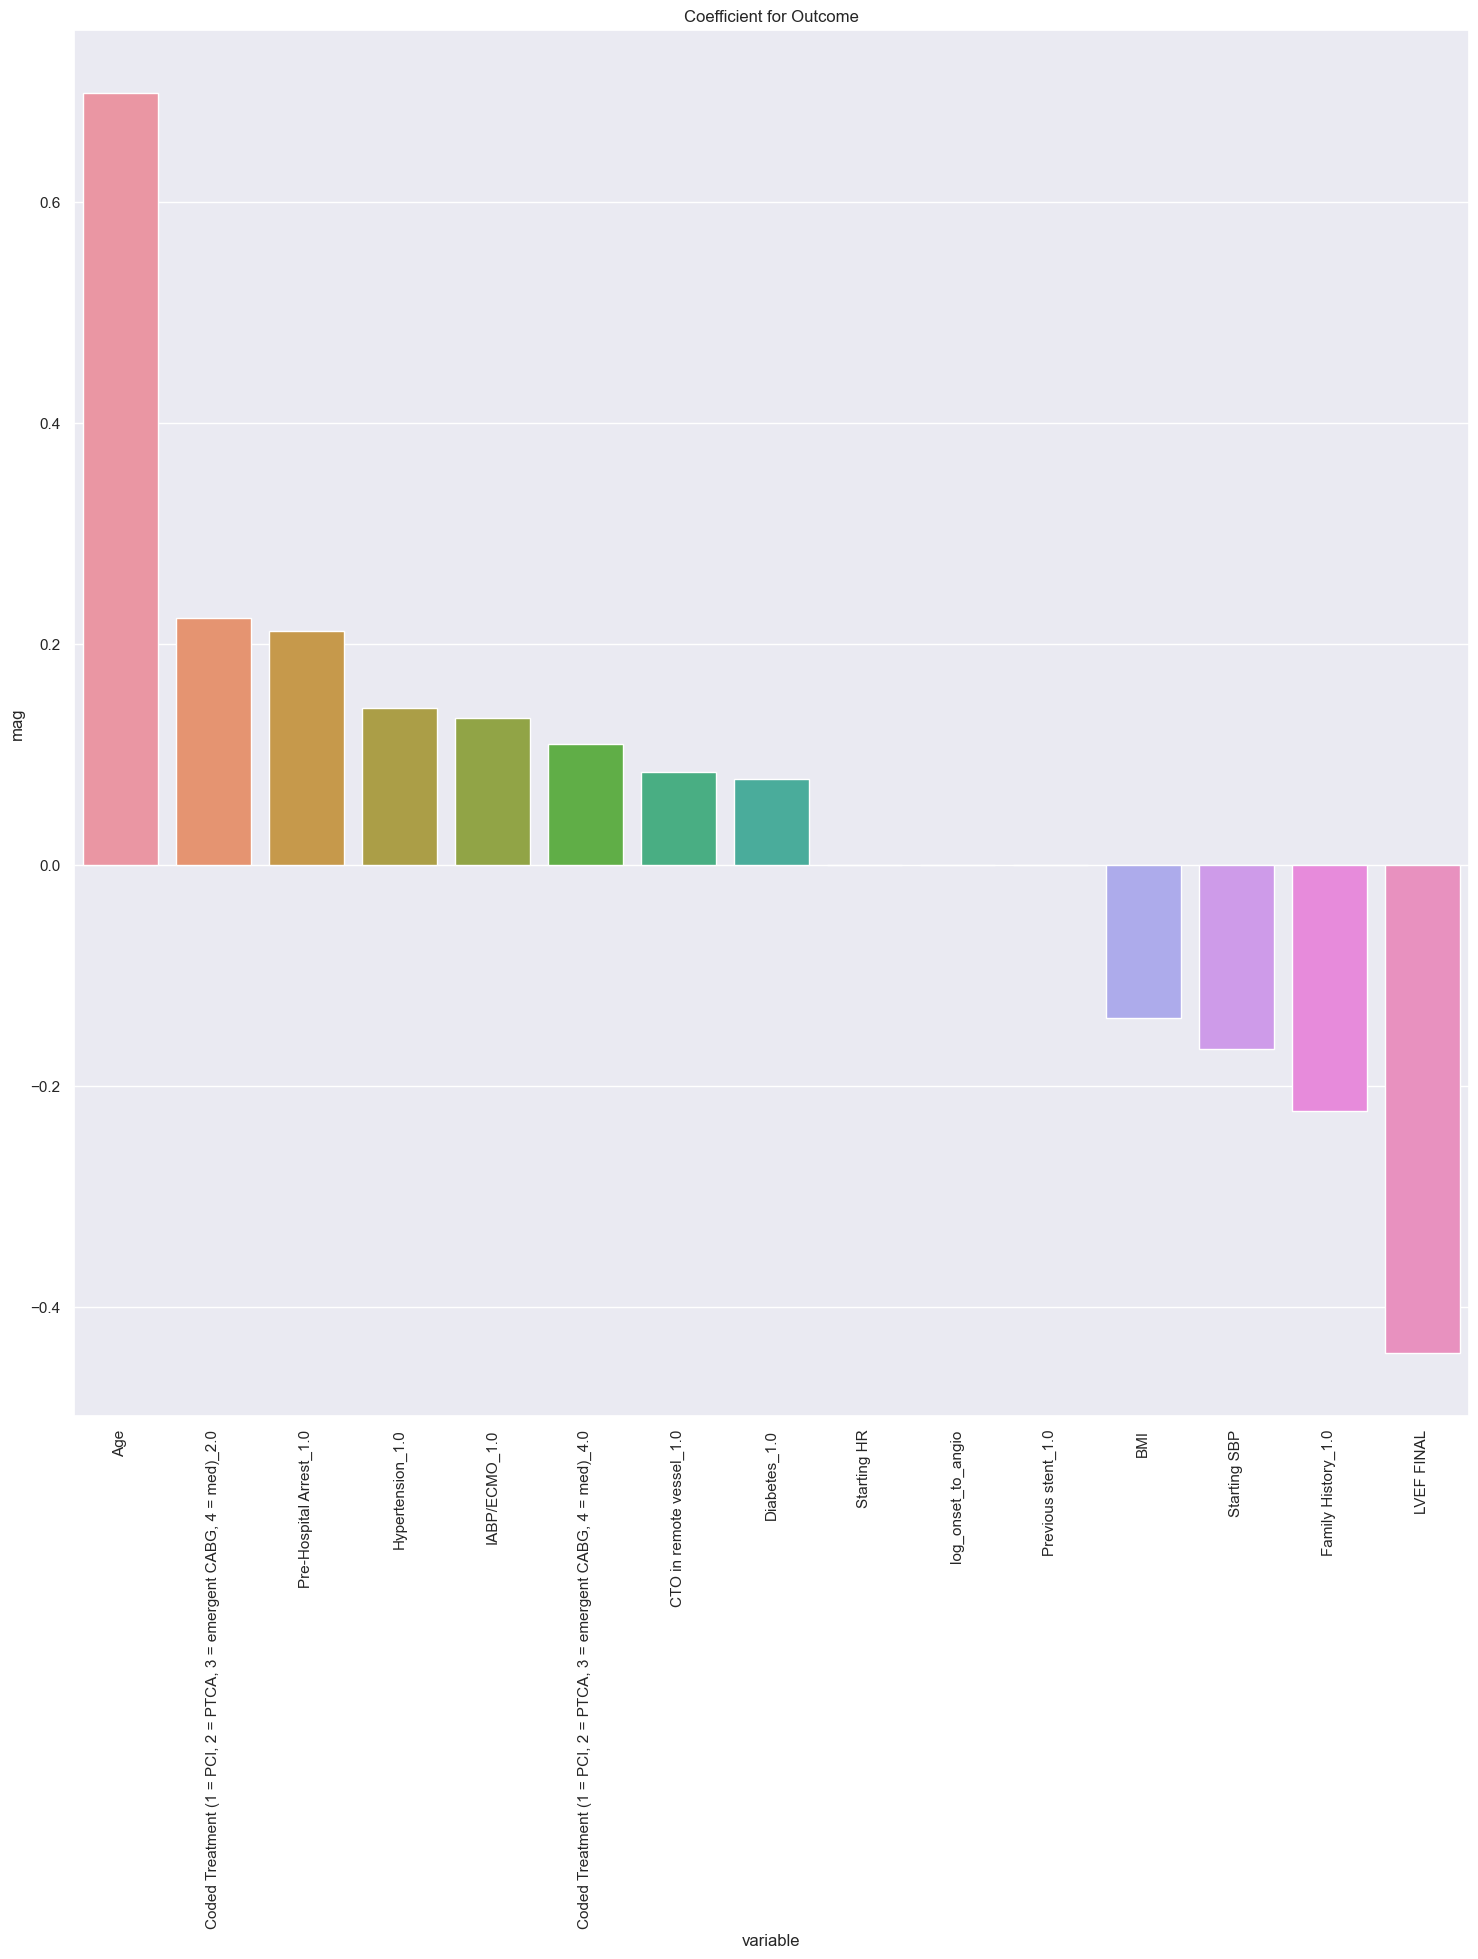

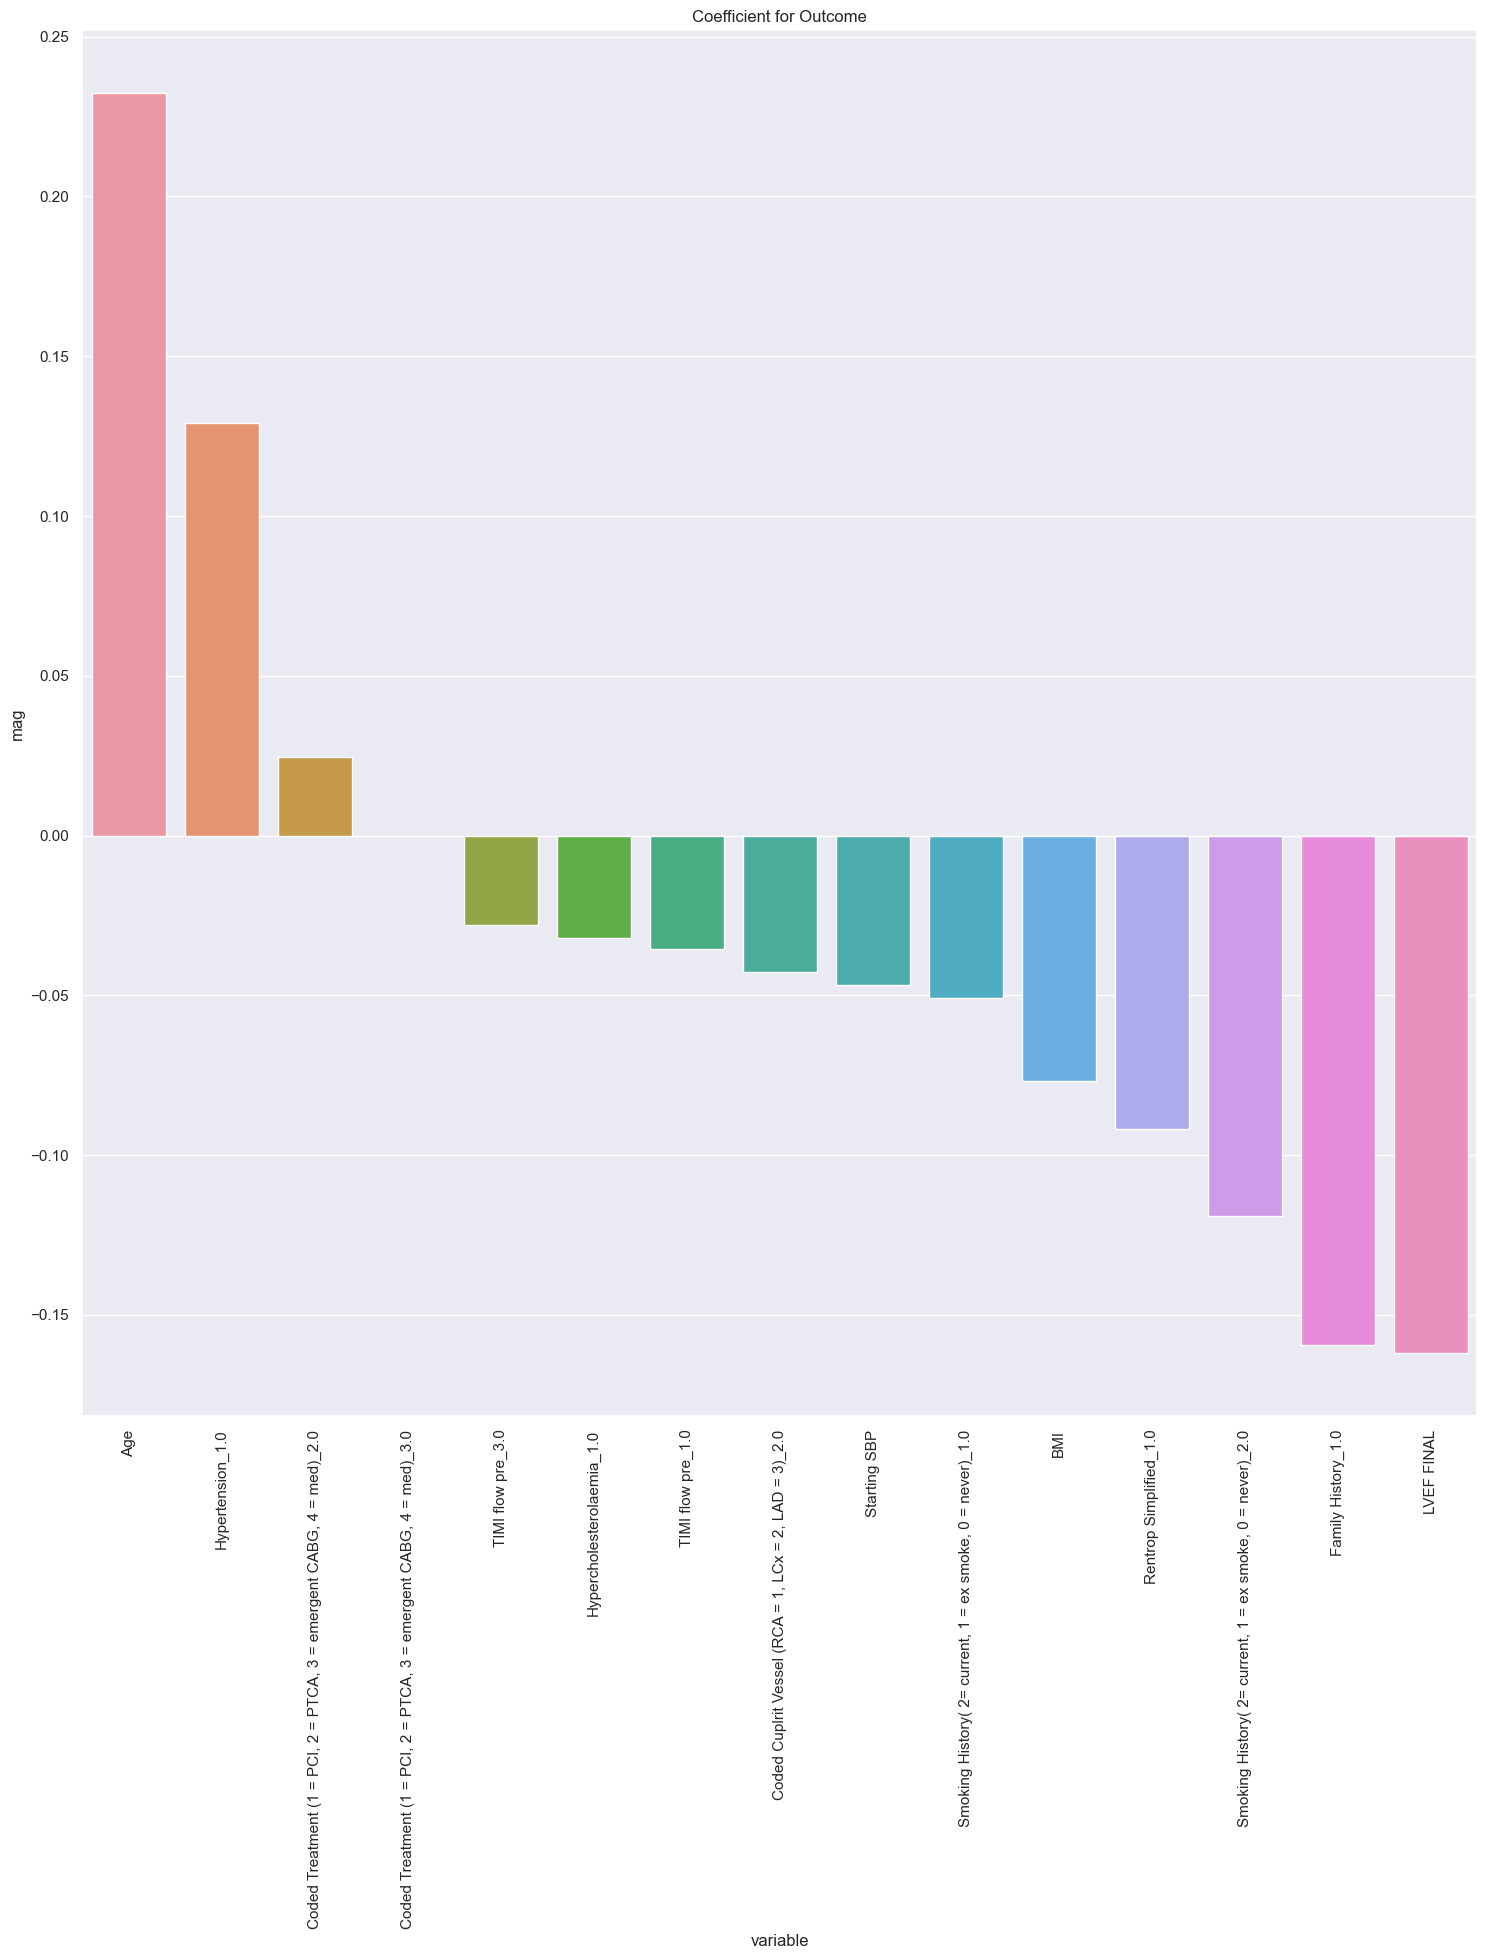

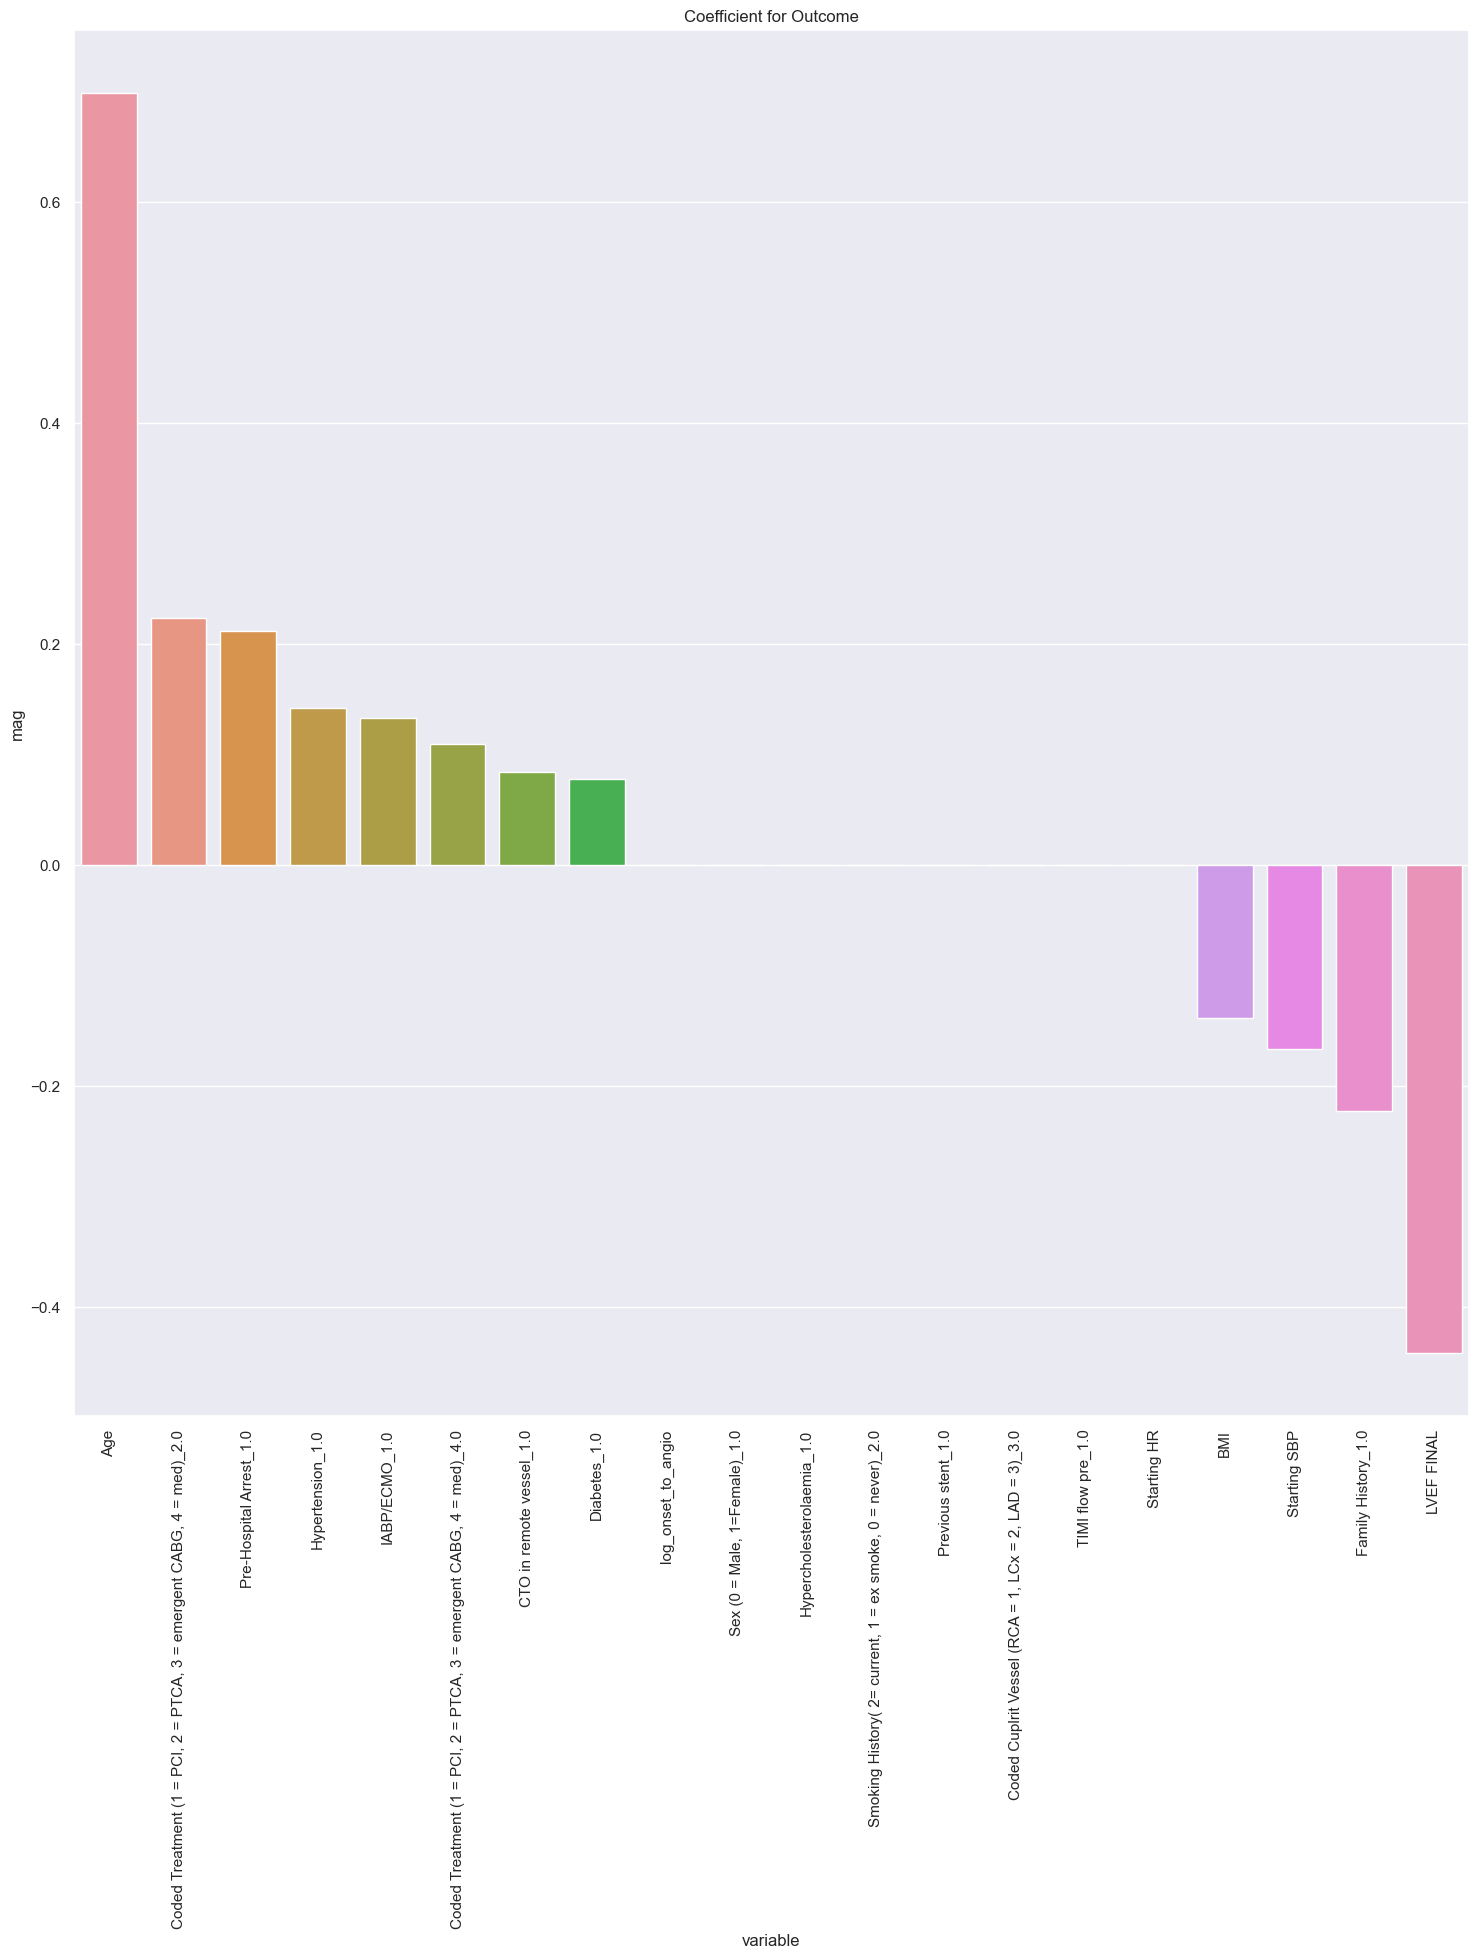

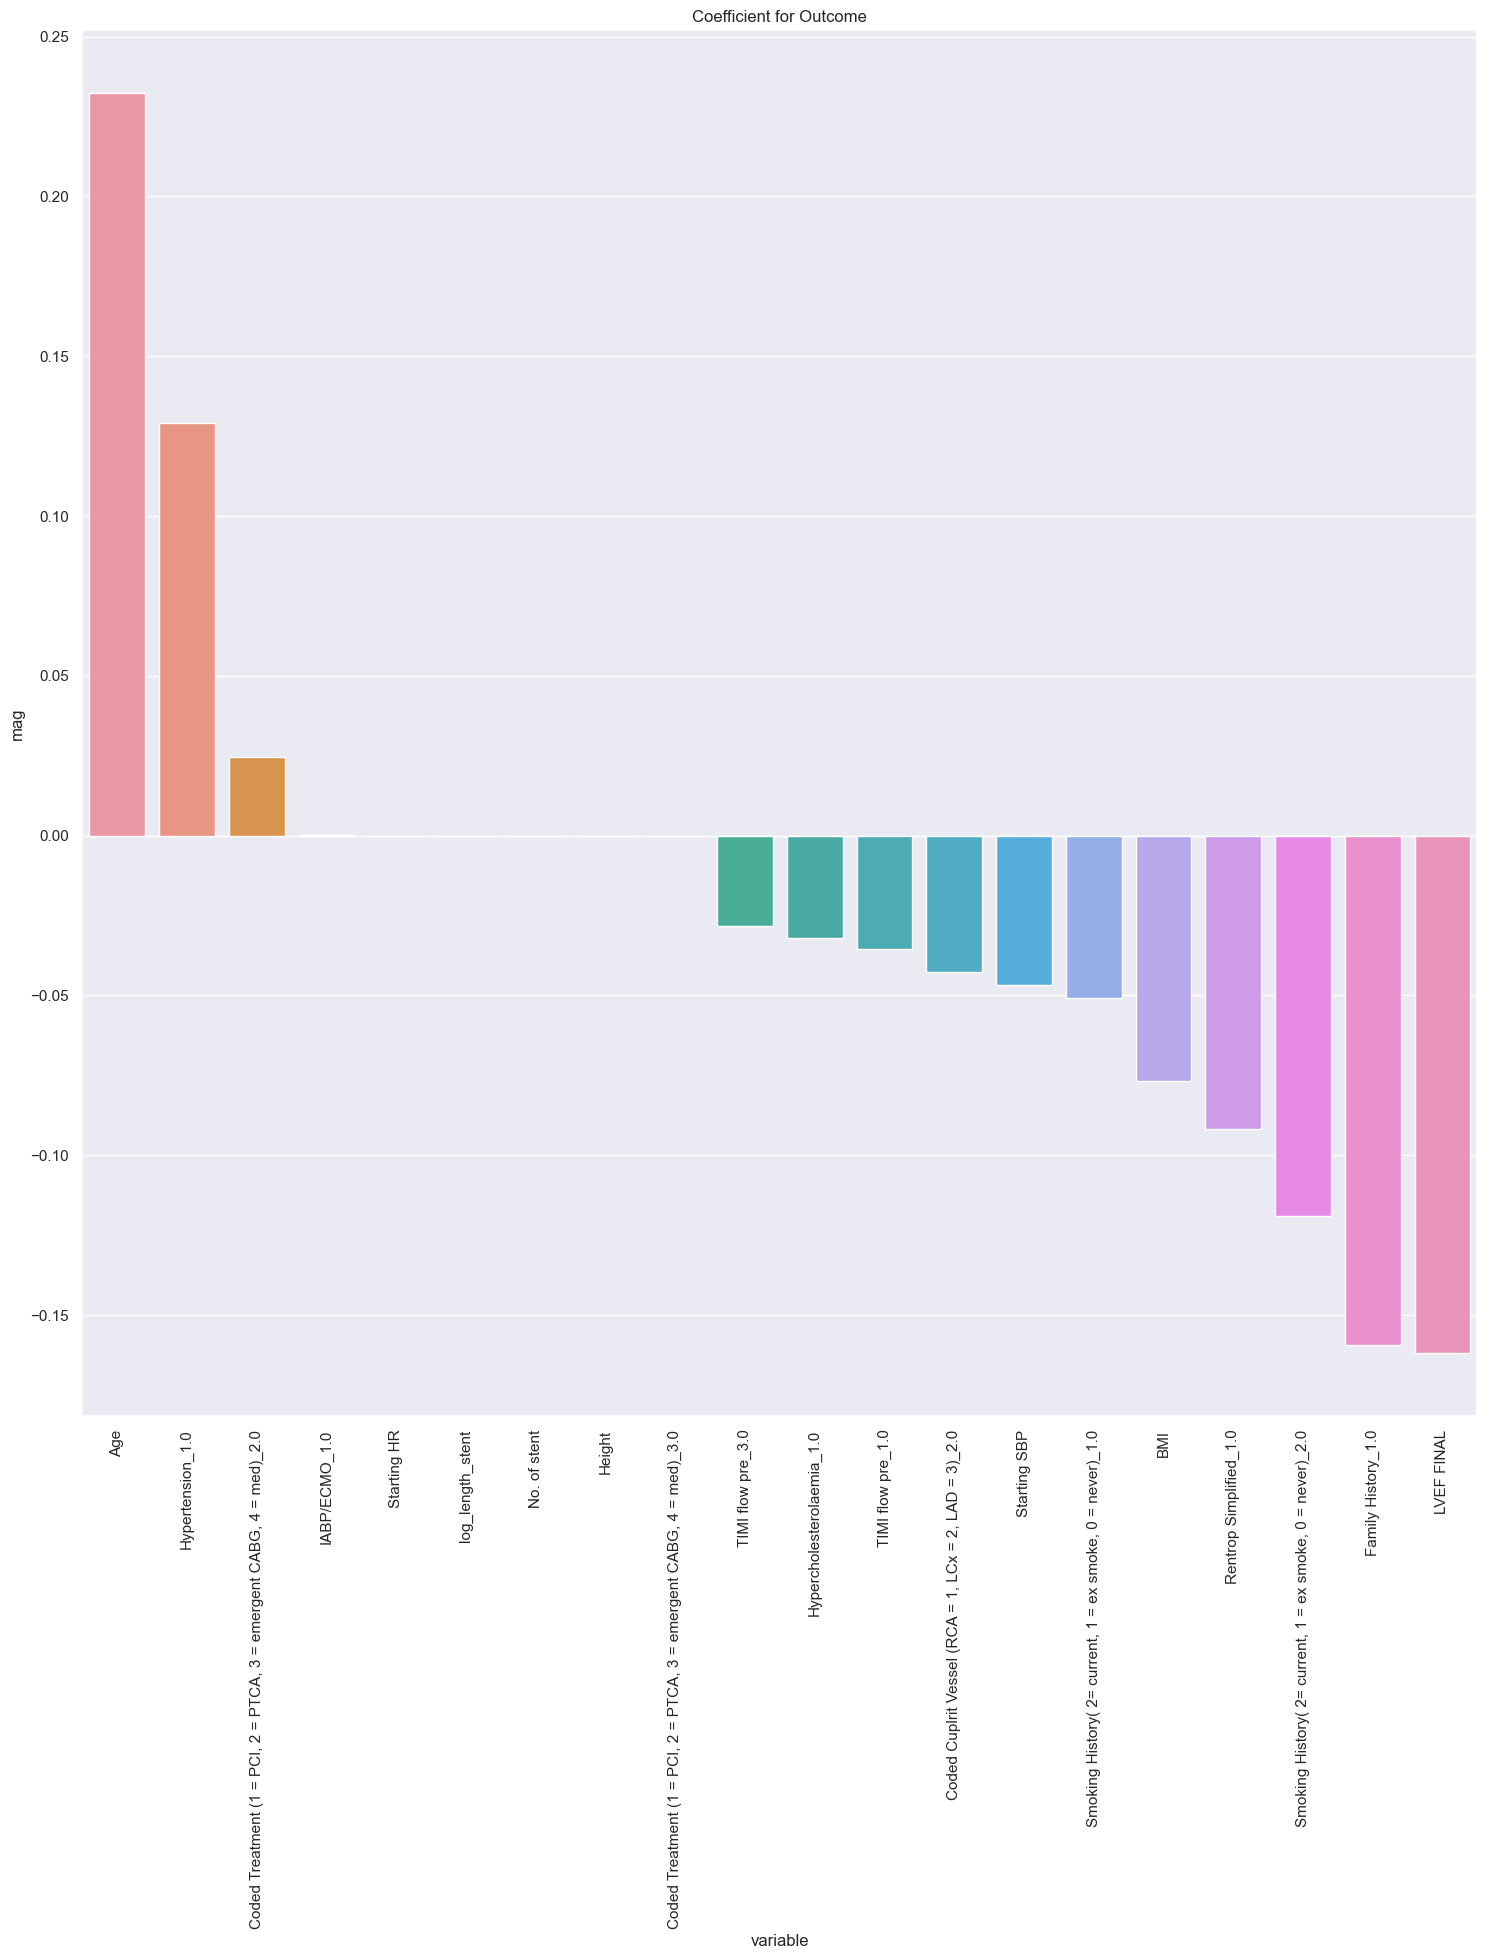

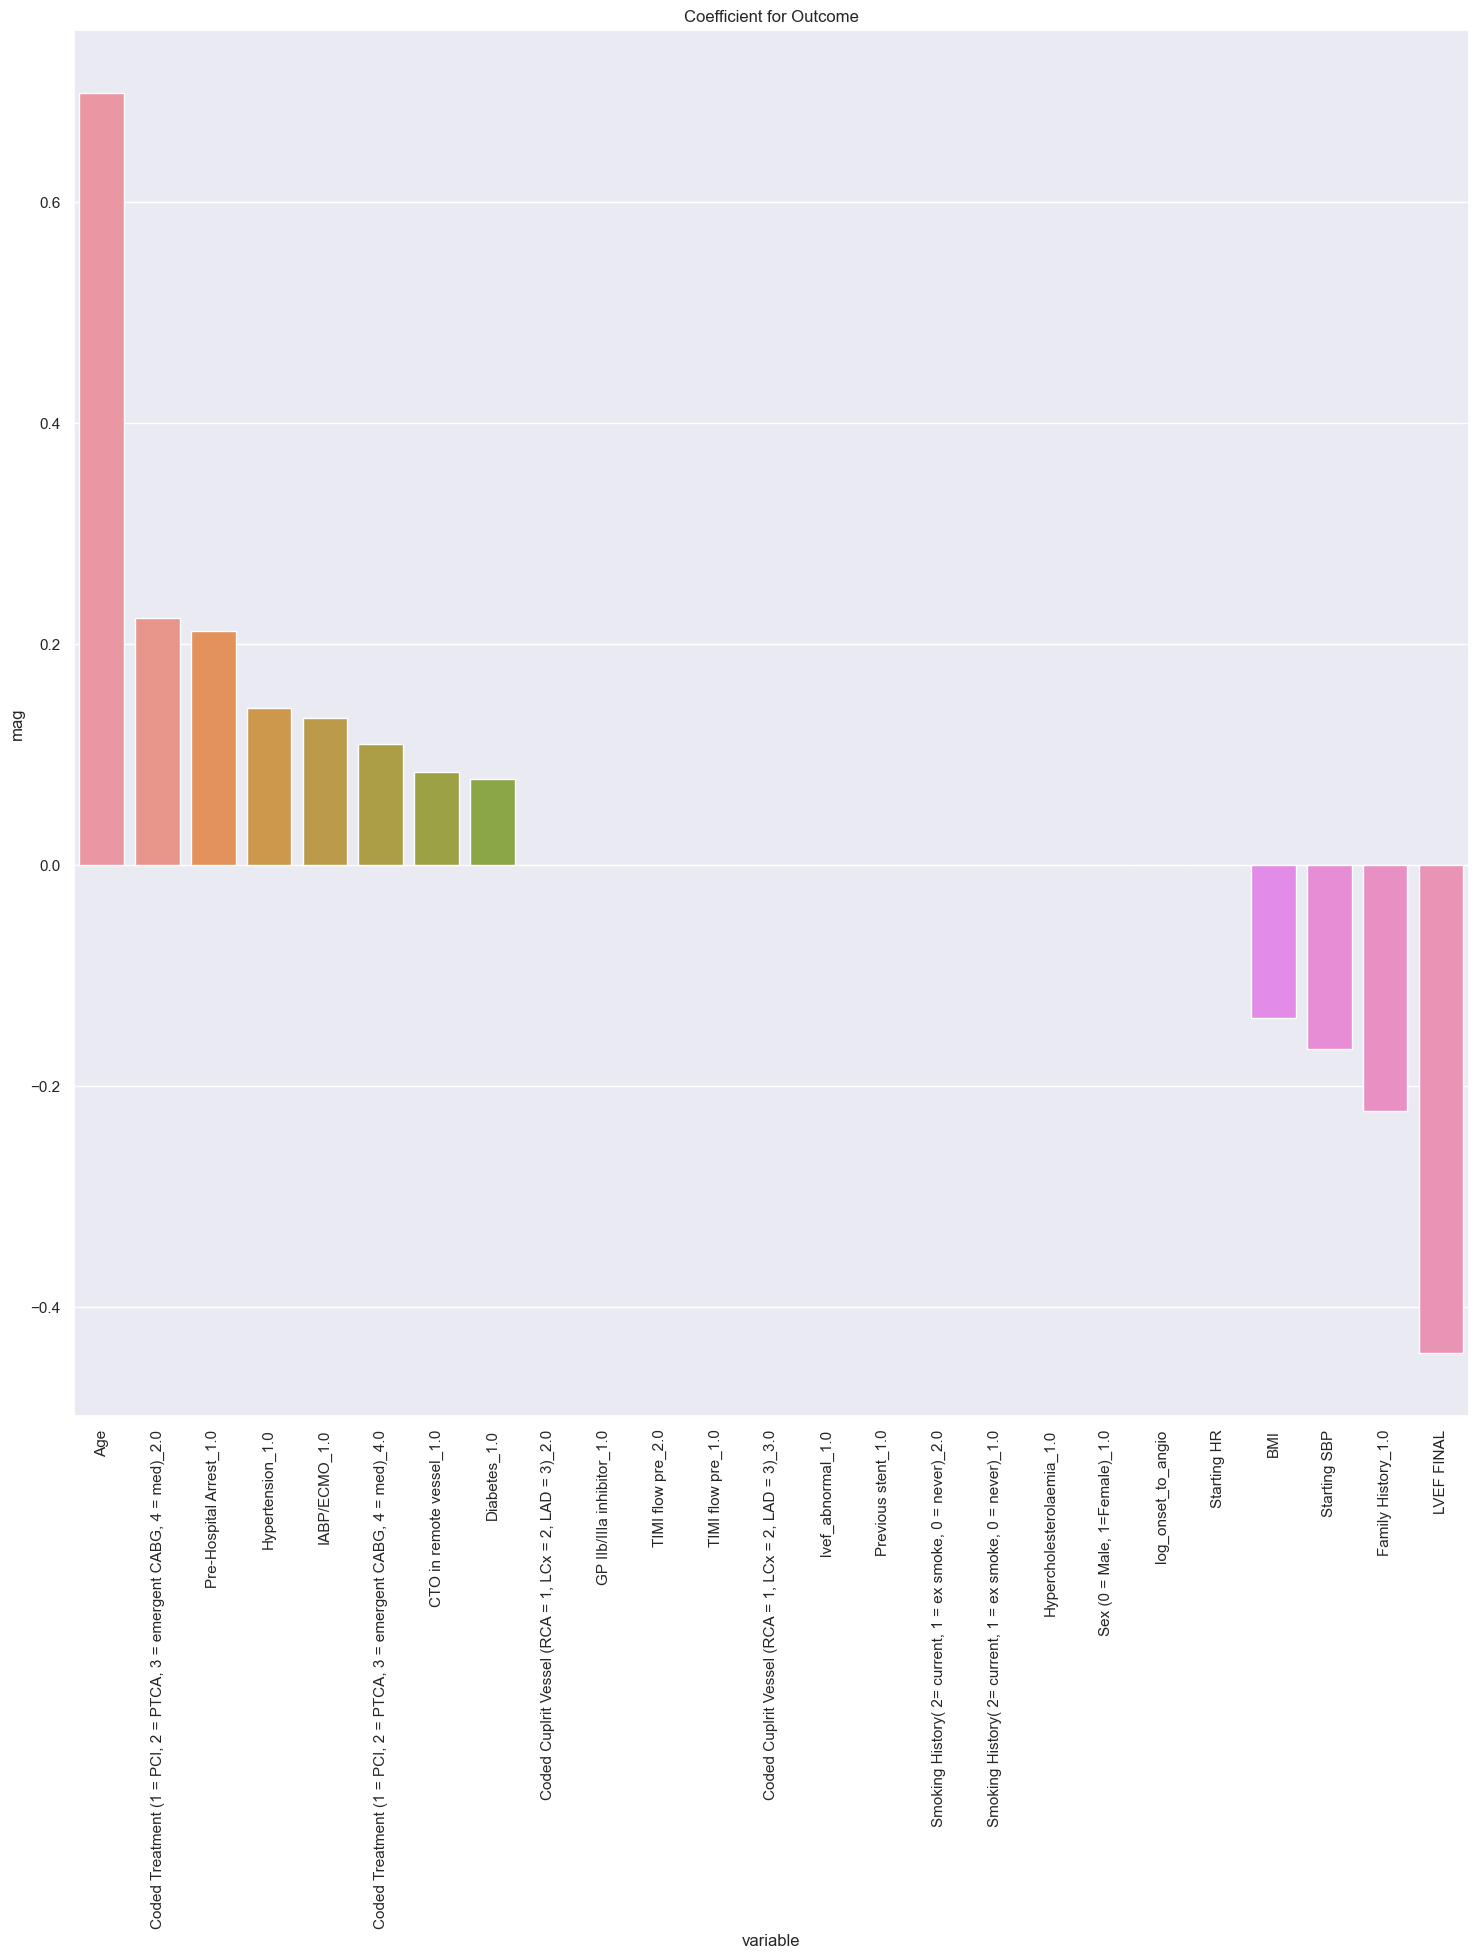

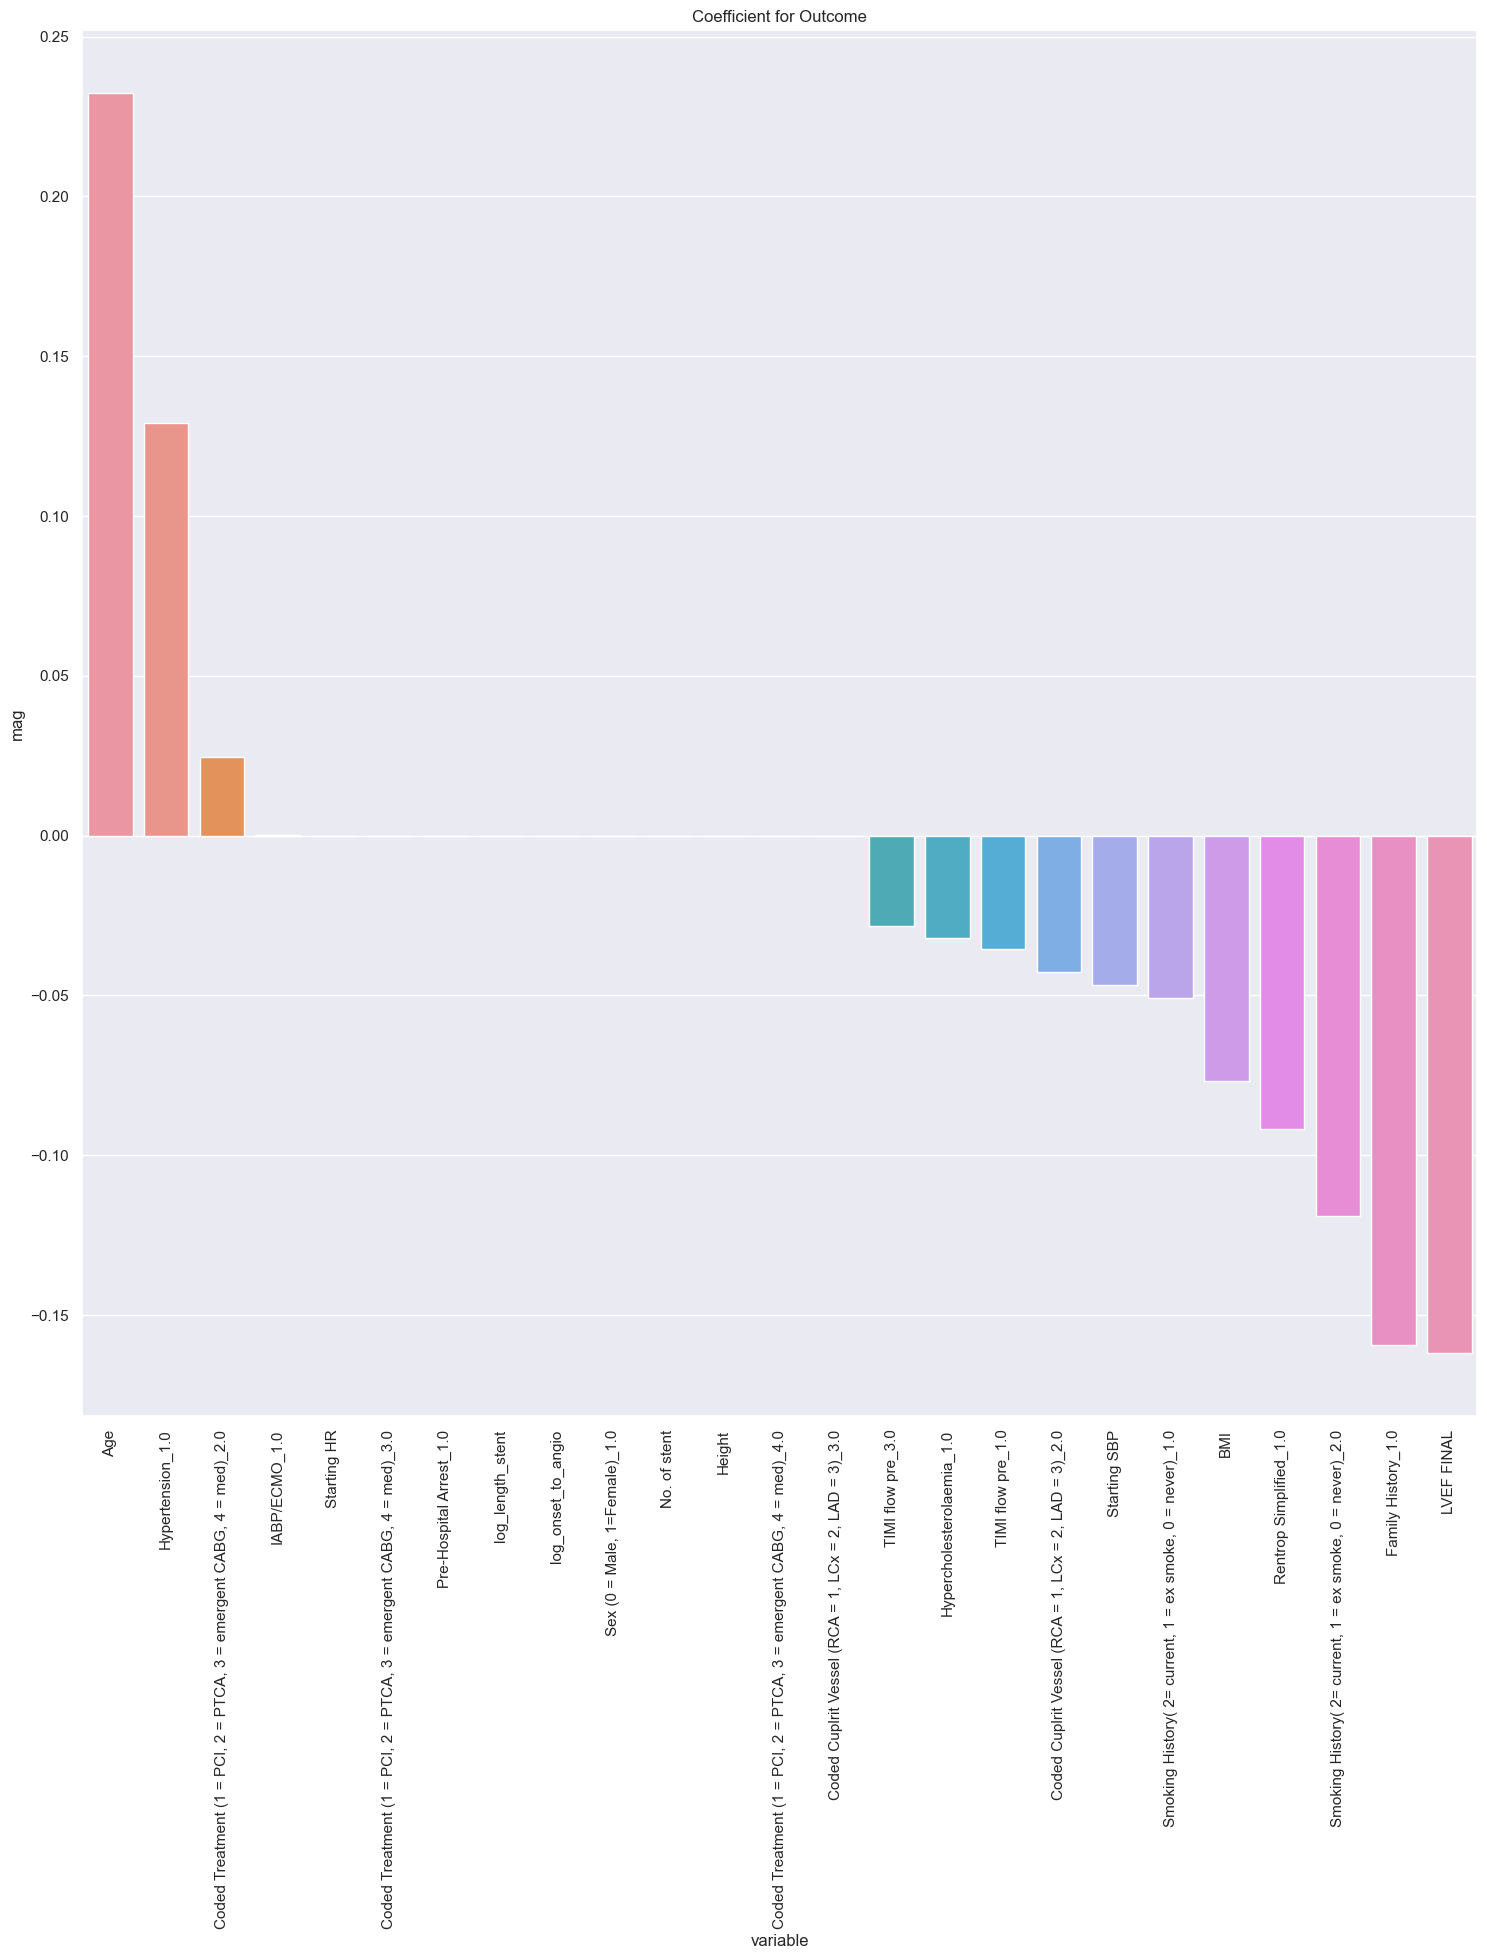

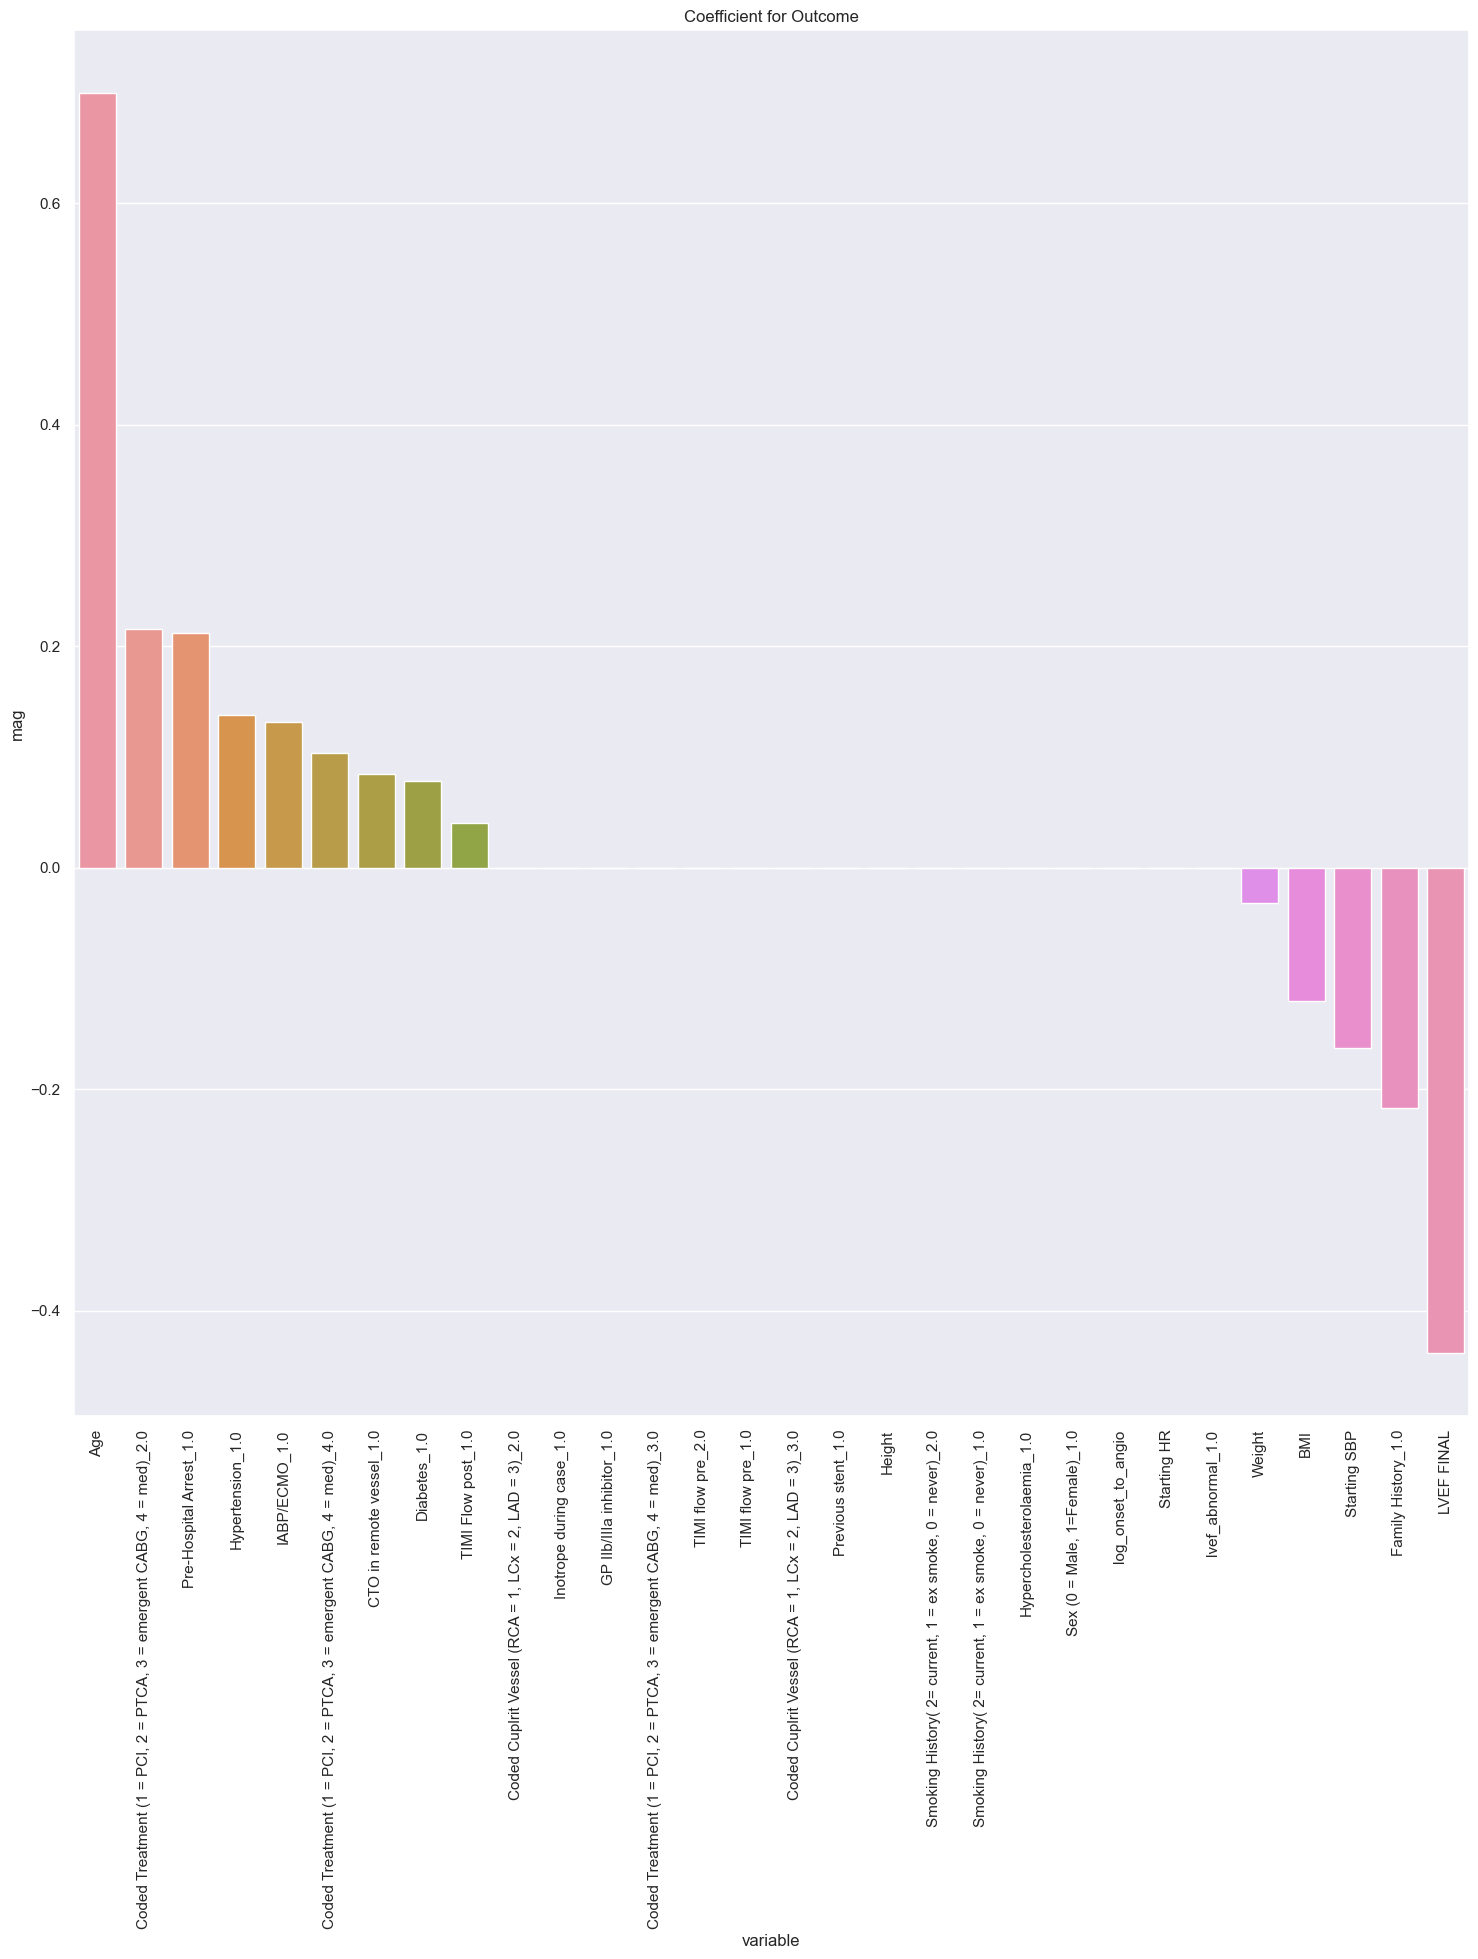

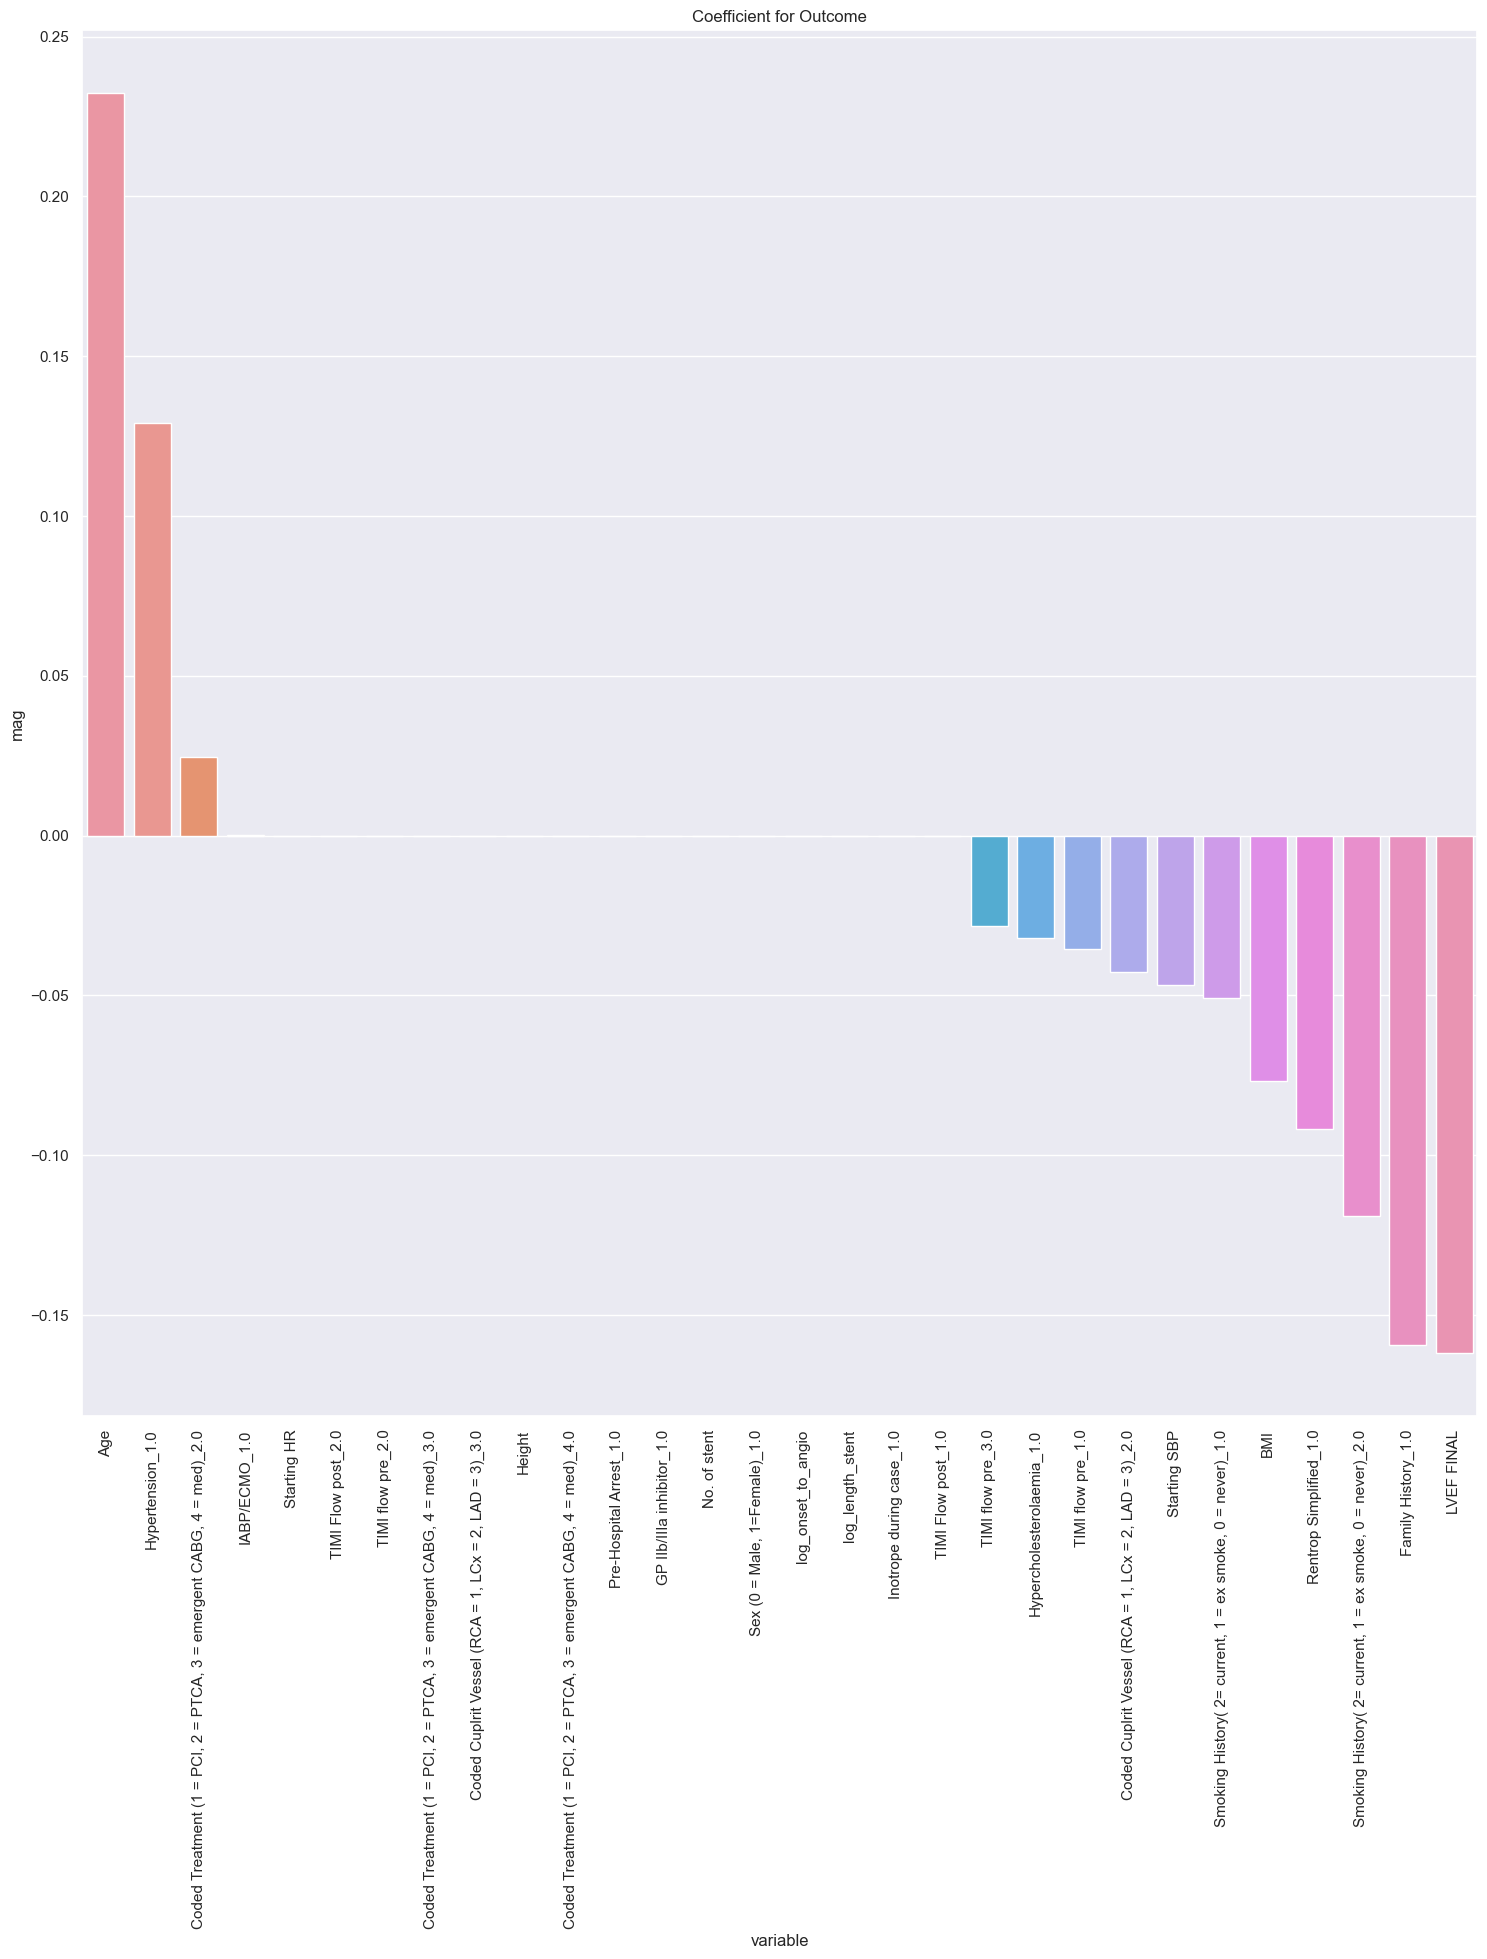

In [50]:
for model_type in ['l1','l2','elasticnet']:
    for n in n_features:
        for use_oversample in [False,True]:
            for p in predictors:
                if use_oversample:
                    model_name = model_type + "_feature_selection_1year" +str(n)+ "_oversample_oversample"
                else:
                    model_name = model_type + "_feature_selection_1year" +str(n)
                pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
                ax = plot_coef(pipe,model_name,X_train.columns)

In [51]:
for model_type in ['l1','l2','elasticnet']:
    for n in n_features:
        for use_oversample in [False,True]:
            for p in predictors:
                if use_oversample:
                    model_name = model_type + "_feature_selection_1year" +str(n)+ "_oversample_oversample"
                else:
                    model_name = model_type + "_feature_selection_1year" +str(n)

                y_test = df_dummy.loc[test[p],p]
                X_test = df_dummy.iloc[test[p]].drop(predictors, axis=1)
                pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
                test_result_df = evaluate_model(pipe,X_test,y_test)
                test_result_df["outcome"] = p
                test_result_df["model"] = model_name

                test_df = pd.concat([test_df,test_result_df],ignore_index=True)

In [52]:
score_df.to_csv(cv_result_filename )
test_df.to_csv(test_result_filename)

In [53]:
test_df

model  accuracy  precision  \
0                                   lr_baseline_1year  0.879866   0.626374   
1        logistic_feature_selection_1year5_oversample  0.710456   0.245455   
2       logistic_feature_selection_1year10_oversample  0.694370   0.232759   
3       logistic_feature_selection_1year15_oversample  0.707775   0.200000   
4       logistic_feature_selection_1year20_oversample  0.731903   0.233333   
5       logistic_feature_selection_1year25_oversample  0.737265   0.244444   
6       logistic_feature_selection_1year30_oversample  0.742627   0.244186   
7                         l1_feature_selection_1year5  0.855228   0.437500   
8   l1_feature_selection_1year5_oversample_oversample  0.710456   0.245455   
9                        l1_feature_selection_1year10  0.855228   0.416667   
10  l1_feature_selection_1year10_oversample_oversa...  0.694370   0.232759   
11                       l1_feature_selection_1year15  0.847185   0.333333   
12  l1_feature_selection_1year15_oversample_oversa...  0.702413   0.195876   
13                       l1_feature_selection_1year20  0.852547   0.363636   
14  l1_feature_selection_1year20_oversample_oversa...  0.731903   0.233333   
15                       l1_feature_selection_1year25  0.857909   0.466667   
16  l1_feature_selection_1year25_oversample_oversa...  0.742627   0.250000   
17                       l1_feature_selection_1year30  0.855228   0.437500   
18  l1_feature_selection_1year30_oversample_oversa...  0.734584   0.241758   
19                        l2_feature_selection_1year5  0.855228   0.437500   
20  l2_feature_selection_1year5_oversample_oversample  0.710456   0.245455   
21                       l2_feature_selection_1year10  0.855228   0.416667   
22  l2_feature_selection_1year10_oversample_oversa...  0.694370   0.232759   
23                       l2_feature_selection_1year15  0.847185   0.307692   
24  l2_feature_selection_1year15_oversample_oversa...  0.705094   0.197917   
25                       l2_feature_selection_1year20  0.855228   0.428571   
26  l2_feature_selection_1year20_oversample_oversa...  0.731903   0.233333   
27                       l2_feature_selection_1year25  0.852547   0.411765   
28  l2_feature_selection_1year25_oversample_oversa...  0.731903   0.227273   
29                       l2_feature_selection_1year30  0.855228   0.437500   
30  l2_feature_selection_1year30_oversample_oversa...  0.739946   0.252747   
31                elasticnet_feature_selection_1year5  0.855228   0.375000   
32  elasticnet_feature_selection_1year5_oversample...  0.718499   0.280992   
33               elasticnet_feature_selection_1year10  0.860590   0.500000   
34  elasticnet_feature_selection_1year10_oversampl...  0.710456   0.266667   
35               elasticnet_feature_selection_1year15  0.857909   0.428571   
36  elasticnet_feature_selection_1year15_oversampl...  0.718499   0.277311   
37               elasticnet_feature_selection_1year20  0.857909   0.428571   
38  elasticnet_feature_selection_1year20_oversampl...  0.718499   0.277311   
39               elasticnet_feature_selection_1year25  0.857909   0.428571   
40  elasticnet_feature_selection_1year25_oversampl...  0.718499   0.277311   
41               elasticnet_feature_selection_1year30  0.857909   0.428571   
42  elasticnet_feature_selection_1year30_oversampl...  0.718499   0.277311   

      recall  f1_score       auc  outcome  
0   0.282178  0.389078  0.846300  Outcome  
1   0.519231  0.333333  0.738617  Outcome  
2   0.519231  0.321429  0.709082  Outcome  
3   0.365385  0.258503  0.690870  Outcome  
4   0.403846  0.295775  0.704349  Outcome  
5   0.423077  0.309859  0.704649  Outcome  
6   0.403846  0.304348  0.700575  Outcome  
7   0.134615  0.205882  0.820213  Outcome  
8   0.519231  0.333333  0.739456  Outcome  
9   0.096154  0.156250  0.822130  Outcome  
10  0.519231  0.321429  0.709442  Outcome  
11  0.096154  0.149254  0.813863  Outcome  
12  0.365385  0.255034  0.691469  Outcome  

## ensemble

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [55]:
score_df = pd.read_csv(cv_result_filename ,index_col=0)
test_df = pd.read_csv(test_result_filename,index_col=0)

In [56]:
def train_model_gridcv(X,y,y_name,model,model_name,
                       param_grid,
                impute=True,
                scale=True,
                oversample=False,
                feature_select=None,
                categorical_features=None,
               score_method='accuracy'):
    pipeline_steps = []
    
    if impute:
        pipeline_steps.append( ('imputer',SimpleImputer(missing_values=np.nan, strategy='median')))
        
    if scale:
        pipeline_steps.append(  ('scaler',StandardScaler()))
    
    if oversample:
        cat_col_index = [i for i, x in enumerate(X.columns) if x in df_dummy_cat_cols]
        pipeline_steps.append(("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)))
        model_name += '_oversample'
            
    if feature_select is not None:
         pipeline_steps.append(("feature_select",feature_select))
        
    
    pipeline_steps.append(  ('model',model))
    
    pipe = Pipeline(steps = pipeline_steps)
    
    grid = GridSearchCV(pipe,
                    param_grid = param_grid,cv=5,scoring=scoring_method,verbose=10)

    grid.fit(X_train, y_train)
    
    joblib.dump(grid.best_estimator_,"model/" + model_name + "_"+p+".pickle")
    
    
    cv_result = cross_validate(grid.best_estimator_, X, y, cv=5,scoring=scoring)
    results = [{k : v.mean() for k, v in cv_result.items()}]

    df_cv_result = pd.DataFrame(results, index=[model_name])
    df_cv_result["outcome"] = p
    df_cv_result["model"] = model_name
    
    
    return grid.best_estimator_,df_cv_result

In [61]:
for model_type in ['ada','gb']:
#for model_type in ['rf','dt']:
    for n in n_features:
        for use_oversample in [False,True]:
            lr_model_name = "l1_baseline"
            
            if use_oversample:
                lr_model_name += '_oversample'
            for p in predictors:  
                if model_type == 'ada':
                    model_name = "adaboost_feature_selection" + str(n)
                    model = AdaBoostClassifier(random_state=random_seed)
                    param_grid = {
                        "model__n_estimators": np.arange(16,24,2),
                        'model__learning_rate':np.linspace(1e-1,5,num=10), 
                    }
                elif model_type == 'gb':
                    model_name = "gb_feature_selection" + str(n)
                    model = GradientBoostingClassifier(random_state=random_seed,n_estimators=50)
                    param_grid = {
                        "model__max_depth": np.arange(1,5,1),
                        'model__max_features':['sqrt'],
                        'model__learning_rate':np.linspace(1e-5,1e-3,5)
                    }
                elif model_type == 'svm':
                    model_name = "svm_feature_selection" + str(n)
                    model = SVC(random_state=random_seed,probability=True)
                    param_grid = {
                        "model__kernel": ['rbf'],
                        'model__C':np.linspace(1e-1,1,num=10), 
                        #'model__degree':[3,5,7,9], 
                    }
                elif model_type == 'rf':
                    model_name = "rf_feature_selection" + str(n)
                    model = RandomForestClassifier(
                         random_state=random_seed,max_features = 'sqrt')
                    param_grid = {
                        'model__max_depth': np.arange(1,11,1) 
                    }
                elif model_type == 'dt':
                    model_name = "decision_feature_selection" + str(n)
                    model = DecisionTreeClassifier(random_state=random_seed)
                    param_grid = {
                        'model__max_depth': np.arange(1,11,1) 
                    }


                y_train = df_dummy.loc[train[p],p]
                X_train = df_dummy.iloc[train[p]].drop(predictors, axis=1)



                loaded_pipe = joblib.load("model/" + lr_model_name + "_" + p +".pickle")
                feature_select_model =  SelectFromModel(LogisticRegression(**loaded_pipe.named_steps["logistic"].get_params())
                                                      ,max_features=n)

                pipe,df_cv_result = train_model_gridcv(
                                        X_train,
                                        y_train,
                                        p,
                                        model,
                                        model_name,
                                        param_grid,
                                        feature_select=feature_select_model,
                                        score_method=scoring_method,
                                        oversample=use_oversample)


                score_df = pd.concat([score_df,df_cv_result],ignore_index=True)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 1/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.800 total time=   0.0s
[CV 2/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 2/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.779 total time=   0.0s
[CV 3/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 3/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.770 total time=   0.0s
[CV 4/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 4/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.764 total time=   0.0s
[CV 5/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 5/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.766 total time=   0.0s
[CV 1/5; 2/40] START model__

[CV 5/5; 9/40] END model__learning_rate=1.188888888888889, model__n_estimators=16;, score=0.765 total time=   0.0s
[CV 1/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 1/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.795 total time=   0.0s
[CV 2/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 2/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.744 total time=   0.0s
[CV 3/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 3/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.739 total time=   0.0s
[CV 4/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 4/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.773 total time=   0.0s
[CV 5/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators

[CV 2/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.383 total time=   0.0s
[CV 3/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 3/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.656 total time=   0.0s
[CV 4/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 4/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.423 total time=   0.0s
[CV 5/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 5/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.610 total time=   0.0s
[CV 1/5; 19/40] START model__learning_rate=2.277777777777778, model__n_estimators=20
[CV 1/5; 19/40] END model__learning_rate=2.277777777777778, model__n_estimators=20;, score=0.658 total time=   0.0s
[CV 2/5; 19/40] START model__learning_rate=2.277777777777778, model__n_estimator

[CV 4/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.620 total time=   0.1s
[CV 5/5; 26/40] START model__learning_rate=3.366666666666667, model__n_estimators=18
[CV 5/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.685 total time=   0.0s
[CV 1/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 1/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.648 total time=   0.0s
[CV 2/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 2/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.635 total time=   0.0s
[CV 3/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 3/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.655 total time=   0.0s
[CV 4/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimator

[CV 2/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.352 total time=   0.0s
[CV 3/5; 35/40] START model__learning_rate=4.455555555555556, model__n_estimators=20
[CV 3/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.325 total time=   0.0s
[CV 4/5; 35/40] START model__learning_rate=4.455555555555556, model__n_estimators=20
[CV 4/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.429 total time=   0.0s
[CV 5/5; 35/40] START model__learning_rate=4.455555555555556, model__n_estimators=20
[CV 5/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.539 total time=   0.0s
[CV 1/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimators=22
[CV 1/5; 36/40] END model__learning_rate=4.455555555555556, model__n_estimators=22;, score=0.312 total time=   0.0s
[CV 2/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimator

C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 1/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.815 total time=   0.4s
[CV 2/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 2/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.763 total time=   0.4s
[CV 3/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 3/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.743 total time=   0.4s
[CV 4/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 4/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.789 total time=   0.4s
[CV 5/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 5/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.647 total time=   0.4s
[CV 1/5; 2/40] START model__

[CV 3/5; 9/40] END model__learning_rate=1.188888888888889, model__n_estimators=16;, score=0.698 total time=   0.4s
[CV 4/5; 9/40] START model__learning_rate=1.188888888888889, model__n_estimators=16
[CV 4/5; 9/40] END model__learning_rate=1.188888888888889, model__n_estimators=16;, score=0.790 total time=   0.4s
[CV 5/5; 9/40] START model__learning_rate=1.188888888888889, model__n_estimators=16
[CV 5/5; 9/40] END model__learning_rate=1.188888888888889, model__n_estimators=16;, score=0.594 total time=   0.4s
[CV 1/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 1/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.813 total time=   0.4s
[CV 2/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 2/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.769 total time=   0.4s
[CV 3/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18


[CV 4/5; 17/40] END model__learning_rate=2.277777777777778, model__n_estimators=16;, score=0.317 total time=   0.4s
[CV 5/5; 17/40] START model__learning_rate=2.277777777777778, model__n_estimators=16
[CV 5/5; 17/40] END model__learning_rate=2.277777777777778, model__n_estimators=16;, score=0.367 total time=   0.4s
[CV 1/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 1/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.288 total time=   0.4s
[CV 2/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 2/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.288 total time=   0.4s
[CV 3/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 3/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.308 total time=   0.4s
[CV 4/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimator

[CV 5/5; 25/40] END model__learning_rate=3.366666666666667, model__n_estimators=16;, score=0.646 total time=   0.4s
[CV 1/5; 26/40] START model__learning_rate=3.366666666666667, model__n_estimators=18
[CV 1/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.723 total time=   0.4s
[CV 2/5; 26/40] START model__learning_rate=3.366666666666667, model__n_estimators=18
[CV 2/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.702 total time=   0.5s
[CV 3/5; 26/40] START model__learning_rate=3.366666666666667, model__n_estimators=18
[CV 3/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.692 total time=   0.4s
[CV 4/5; 26/40] START model__learning_rate=3.366666666666667, model__n_estimators=18
[CV 4/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.709 total time=   0.4s
[CV 5/5; 26/40] START model__learning_rate=3.366666666666667, model__n_estimator

[CV 1/5; 34/40] END model__learning_rate=4.455555555555556, model__n_estimators=18;, score=0.277 total time=   0.4s
[CV 2/5; 34/40] START model__learning_rate=4.455555555555556, model__n_estimators=18
[CV 2/5; 34/40] END model__learning_rate=4.455555555555556, model__n_estimators=18;, score=0.300 total time=   0.4s
[CV 3/5; 34/40] START model__learning_rate=4.455555555555556, model__n_estimators=18
[CV 3/5; 34/40] END model__learning_rate=4.455555555555556, model__n_estimators=18;, score=0.308 total time=   0.4s
[CV 4/5; 34/40] START model__learning_rate=4.455555555555556, model__n_estimators=18
[CV 4/5; 34/40] END model__learning_rate=4.455555555555556, model__n_estimators=18;, score=0.303 total time=   0.4s
[CV 5/5; 34/40] START model__learning_rate=4.455555555555556, model__n_estimators=18
[CV 5/5; 34/40] END model__learning_rate=4.455555555555556, model__n_estimators=18;, score=0.647 total time=   0.4s
[CV 1/5; 35/40] START model__learning_rate=4.455555555555556, model__n_estimator

[CV 1/5; 3/40] END model__learning_rate=0.1, model__n_estimators=20;, score=0.802 total time=   0.0s
[CV 2/5; 3/40] START model__learning_rate=0.1, model__n_estimators=20...........
[CV 2/5; 3/40] END model__learning_rate=0.1, model__n_estimators=20;, score=0.783 total time=   0.0s
[CV 3/5; 3/40] START model__learning_rate=0.1, model__n_estimators=20...........
[CV 3/5; 3/40] END model__learning_rate=0.1, model__n_estimators=20;, score=0.773 total time=   0.0s
[CV 4/5; 3/40] START model__learning_rate=0.1, model__n_estimators=20...........
[CV 4/5; 3/40] END model__learning_rate=0.1, model__n_estimators=20;, score=0.785 total time=   0.0s
[CV 5/5; 3/40] START model__learning_rate=0.1, model__n_estimators=20...........
[CV 5/5; 3/40] END model__learning_rate=0.1, model__n_estimators=20;, score=0.776 total time=   0.0s
[CV 1/5; 4/40] START model__learning_rate=0.1, model__n_estimators=22...........
[CV 1/5; 4/40] END model__learning_rate=0.1, model__n_estimators=22;, score=0.797 total ti

[CV 4/5; 11/40] END model__learning_rate=1.188888888888889, model__n_estimators=20;, score=0.766 total time=   0.0s
[CV 5/5; 11/40] START model__learning_rate=1.188888888888889, model__n_estimators=20
[CV 5/5; 11/40] END model__learning_rate=1.188888888888889, model__n_estimators=20;, score=0.763 total time=   0.0s
[CV 1/5; 12/40] START model__learning_rate=1.188888888888889, model__n_estimators=22
[CV 1/5; 12/40] END model__learning_rate=1.188888888888889, model__n_estimators=22;, score=0.798 total time=   0.0s
[CV 2/5; 12/40] START model__learning_rate=1.188888888888889, model__n_estimators=22
[CV 2/5; 12/40] END model__learning_rate=1.188888888888889, model__n_estimators=22;, score=0.784 total time=   0.0s
[CV 3/5; 12/40] START model__learning_rate=1.188888888888889, model__n_estimators=22
[CV 3/5; 12/40] END model__learning_rate=1.188888888888889, model__n_estimators=22;, score=0.781 total time=   0.0s
[CV 4/5; 12/40] START model__learning_rate=1.188888888888889, model__n_estimator

[CV 1/5; 20/40] END model__learning_rate=2.277777777777778, model__n_estimators=22;, score=0.323 total time=   0.0s
[CV 2/5; 20/40] START model__learning_rate=2.277777777777778, model__n_estimators=22
[CV 2/5; 20/40] END model__learning_rate=2.277777777777778, model__n_estimators=22;, score=0.383 total time=   0.0s
[CV 3/5; 20/40] START model__learning_rate=2.277777777777778, model__n_estimators=22
[CV 3/5; 20/40] END model__learning_rate=2.277777777777778, model__n_estimators=22;, score=0.656 total time=   0.0s
[CV 4/5; 20/40] START model__learning_rate=2.277777777777778, model__n_estimators=22
[CV 4/5; 20/40] END model__learning_rate=2.277777777777778, model__n_estimators=22;, score=0.382 total time=   0.0s
[CV 5/5; 20/40] START model__learning_rate=2.277777777777778, model__n_estimators=22
[CV 5/5; 20/40] END model__learning_rate=2.277777777777778, model__n_estimators=22;, score=0.315 total time=   0.0s
[CV 1/5; 21/40] START model__learning_rate=2.8222222222222224, model__n_estimato

[CV 2/5; 28/40] END model__learning_rate=3.366666666666667, model__n_estimators=22;, score=0.635 total time=   0.0s
[CV 3/5; 28/40] START model__learning_rate=3.366666666666667, model__n_estimators=22
[CV 3/5; 28/40] END model__learning_rate=3.366666666666667, model__n_estimators=22;, score=0.655 total time=   0.0s
[CV 4/5; 28/40] START model__learning_rate=3.366666666666667, model__n_estimators=22
[CV 4/5; 28/40] END model__learning_rate=3.366666666666667, model__n_estimators=22;, score=0.605 total time=   0.0s
[CV 5/5; 28/40] START model__learning_rate=3.366666666666667, model__n_estimators=22
[CV 5/5; 28/40] END model__learning_rate=3.366666666666667, model__n_estimators=22;, score=0.334 total time=   0.0s
[CV 1/5; 29/40] START model__learning_rate=3.911111111111112, model__n_estimators=16
[CV 1/5; 29/40] END model__learning_rate=3.911111111111112, model__n_estimators=16;, score=0.312 total time=   0.0s
[CV 2/5; 29/40] START model__learning_rate=3.911111111111112, model__n_estimator

[CV 4/5; 36/40] END model__learning_rate=4.455555555555556, model__n_estimators=22;, score=0.415 total time=   0.0s
[CV 5/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimators=22
[CV 5/5; 36/40] END model__learning_rate=4.455555555555556, model__n_estimators=22;, score=0.334 total time=   0.0s
[CV 1/5; 37/40] START model__learning_rate=5.0, model__n_estimators=16..........
[CV 1/5; 37/40] END model__learning_rate=5.0, model__n_estimators=16;, score=0.312 total time=   0.0s
[CV 2/5; 37/40] START model__learning_rate=5.0, model__n_estimators=16..........
[CV 2/5; 37/40] END model__learning_rate=5.0, model__n_estimators=16;, score=0.352 total time=   0.0s
[CV 3/5; 37/40] START model__learning_rate=5.0, model__n_estimators=16..........
[CV 3/5; 37/40] END model__learning_rate=5.0, model__n_estimators=16;, score=0.325 total time=   0.0s
[CV 4/5; 37/40] START model__learning_rate=5.0, model__n_estimators=16..........
[CV 4/5; 37/40] END model__learning_rate=5.0, model__

[CV 4/5; 5/40] END model__learning_rate=0.6444444444444445, model__n_estimators=16;, score=0.798 total time=   0.4s
[CV 5/5; 5/40] START model__learning_rate=0.6444444444444445, model__n_estimators=16
[CV 5/5; 5/40] END model__learning_rate=0.6444444444444445, model__n_estimators=16;, score=0.679 total time=   0.4s
[CV 1/5; 6/40] START model__learning_rate=0.6444444444444445, model__n_estimators=18
[CV 1/5; 6/40] END model__learning_rate=0.6444444444444445, model__n_estimators=18;, score=0.800 total time=   0.4s
[CV 2/5; 6/40] START model__learning_rate=0.6444444444444445, model__n_estimators=18
[CV 2/5; 6/40] END model__learning_rate=0.6444444444444445, model__n_estimators=18;, score=0.788 total time=   0.4s
[CV 3/5; 6/40] START model__learning_rate=0.6444444444444445, model__n_estimators=18
[CV 3/5; 6/40] END model__learning_rate=0.6444444444444445, model__n_estimators=18;, score=0.768 total time=   0.4s
[CV 4/5; 6/40] START model__learning_rate=0.6444444444444445, model__n_estimator

[CV 5/5; 13/40] END model__learning_rate=1.7333333333333336, model__n_estimators=16;, score=0.643 total time=   0.4s
[CV 1/5; 14/40] START model__learning_rate=1.7333333333333336, model__n_estimators=18
[CV 1/5; 14/40] END model__learning_rate=1.7333333333333336, model__n_estimators=18;, score=0.701 total time=   0.4s
[CV 2/5; 14/40] START model__learning_rate=1.7333333333333336, model__n_estimators=18
[CV 2/5; 14/40] END model__learning_rate=1.7333333333333336, model__n_estimators=18;, score=0.727 total time=   0.4s
[CV 3/5; 14/40] START model__learning_rate=1.7333333333333336, model__n_estimators=18
[CV 3/5; 14/40] END model__learning_rate=1.7333333333333336, model__n_estimators=18;, score=0.709 total time=   0.4s
[CV 4/5; 14/40] START model__learning_rate=1.7333333333333336, model__n_estimators=18
[CV 4/5; 14/40] END model__learning_rate=1.7333333333333336, model__n_estimators=18;, score=0.725 total time=   0.4s
[CV 5/5; 14/40] START model__learning_rate=1.7333333333333336, model__n

[CV 1/5; 22/40] END model__learning_rate=2.8222222222222224, model__n_estimators=18;, score=0.723 total time=   0.4s
[CV 2/5; 22/40] START model__learning_rate=2.8222222222222224, model__n_estimators=18
[CV 2/5; 22/40] END model__learning_rate=2.8222222222222224, model__n_estimators=18;, score=0.704 total time=   0.5s
[CV 3/5; 22/40] START model__learning_rate=2.8222222222222224, model__n_estimators=18
[CV 3/5; 22/40] END model__learning_rate=2.8222222222222224, model__n_estimators=18;, score=0.692 total time=   0.5s
[CV 4/5; 22/40] START model__learning_rate=2.8222222222222224, model__n_estimators=18
[CV 4/5; 22/40] END model__learning_rate=2.8222222222222224, model__n_estimators=18;, score=0.709 total time=   0.4s
[CV 5/5; 22/40] START model__learning_rate=2.8222222222222224, model__n_estimators=18
[CV 5/5; 22/40] END model__learning_rate=2.8222222222222224, model__n_estimators=18;, score=0.649 total time=   0.4s
[CV 1/5; 23/40] START model__learning_rate=2.8222222222222224, model__n

[CV 2/5; 30/40] END model__learning_rate=3.911111111111112, model__n_estimators=18;, score=0.300 total time=   0.4s
[CV 3/5; 30/40] START model__learning_rate=3.911111111111112, model__n_estimators=18
[CV 3/5; 30/40] END model__learning_rate=3.911111111111112, model__n_estimators=18;, score=0.308 total time=   0.4s
[CV 4/5; 30/40] START model__learning_rate=3.911111111111112, model__n_estimators=18
[CV 4/5; 30/40] END model__learning_rate=3.911111111111112, model__n_estimators=18;, score=0.323 total time=   0.4s
[CV 5/5; 30/40] START model__learning_rate=3.911111111111112, model__n_estimators=18
[CV 5/5; 30/40] END model__learning_rate=3.911111111111112, model__n_estimators=18;, score=0.354 total time=   0.4s
[CV 1/5; 31/40] START model__learning_rate=3.911111111111112, model__n_estimators=20
[CV 1/5; 31/40] END model__learning_rate=3.911111111111112, model__n_estimators=20;, score=0.297 total time=   0.4s
[CV 2/5; 31/40] START model__learning_rate=3.911111111111112, model__n_estimator

[CV 4/5; 38/40] END model__learning_rate=5.0, model__n_estimators=18;, score=0.704 total time=   0.4s
[CV 5/5; 38/40] START model__learning_rate=5.0, model__n_estimators=18..........
[CV 5/5; 38/40] END model__learning_rate=5.0, model__n_estimators=18;, score=0.357 total time=   0.4s
[CV 1/5; 39/40] START model__learning_rate=5.0, model__n_estimators=20..........
[CV 1/5; 39/40] END model__learning_rate=5.0, model__n_estimators=20;, score=0.277 total time=   0.4s
[CV 2/5; 39/40] START model__learning_rate=5.0, model__n_estimators=20..........
[CV 2/5; 39/40] END model__learning_rate=5.0, model__n_estimators=20;, score=0.704 total time=   0.4s
[CV 3/5; 39/40] START model__learning_rate=5.0, model__n_estimators=20..........
[CV 3/5; 39/40] END model__learning_rate=5.0, model__n_estimators=20;, score=0.692 total time=   0.4s
[CV 4/5; 39/40] START model__learning_rate=5.0, model__n_estimators=20..........
[CV 4/5; 39/40] END model__learning_rate=5.0, model__n_estimators=20;, score=0.704 to

[CV 4/5; 7/40] END model__learning_rate=0.6444444444444445, model__n_estimators=20;, score=0.781 total time=   0.0s
[CV 5/5; 7/40] START model__learning_rate=0.6444444444444445, model__n_estimators=20
[CV 5/5; 7/40] END model__learning_rate=0.6444444444444445, model__n_estimators=20;, score=0.800 total time=   0.0s
[CV 1/5; 8/40] START model__learning_rate=0.6444444444444445, model__n_estimators=22
[CV 1/5; 8/40] END model__learning_rate=0.6444444444444445, model__n_estimators=22;, score=0.834 total time=   0.0s
[CV 2/5; 8/40] START model__learning_rate=0.6444444444444445, model__n_estimators=22
[CV 2/5; 8/40] END model__learning_rate=0.6444444444444445, model__n_estimators=22;, score=0.811 total time=   0.0s
[CV 3/5; 8/40] START model__learning_rate=0.6444444444444445, model__n_estimators=22
[CV 3/5; 8/40] END model__learning_rate=0.6444444444444445, model__n_estimators=22;, score=0.751 total time=   0.0s
[CV 4/5; 8/40] START model__learning_rate=0.6444444444444445, model__n_estimator

[CV 2/5; 16/40] END model__learning_rate=1.7333333333333336, model__n_estimators=22;, score=0.713 total time=   0.0s
[CV 3/5; 16/40] START model__learning_rate=1.7333333333333336, model__n_estimators=22
[CV 3/5; 16/40] END model__learning_rate=1.7333333333333336, model__n_estimators=22;, score=0.748 total time=   0.0s
[CV 4/5; 16/40] START model__learning_rate=1.7333333333333336, model__n_estimators=22
[CV 4/5; 16/40] END model__learning_rate=1.7333333333333336, model__n_estimators=22;, score=0.748 total time=   0.0s
[CV 5/5; 16/40] START model__learning_rate=1.7333333333333336, model__n_estimators=22
[CV 5/5; 16/40] END model__learning_rate=1.7333333333333336, model__n_estimators=22;, score=0.713 total time=   0.0s
[CV 1/5; 17/40] START model__learning_rate=2.277777777777778, model__n_estimators=16
[CV 1/5; 17/40] END model__learning_rate=2.277777777777778, model__n_estimators=16;, score=0.328 total time=   0.0s
[CV 2/5; 17/40] START model__learning_rate=2.277777777777778, model__n_es

[CV 3/5; 24/40] END model__learning_rate=2.8222222222222224, model__n_estimators=22;, score=0.325 total time=   0.0s
[CV 4/5; 24/40] START model__learning_rate=2.8222222222222224, model__n_estimators=22
[CV 4/5; 24/40] END model__learning_rate=2.8222222222222224, model__n_estimators=22;, score=0.415 total time=   0.0s
[CV 5/5; 24/40] START model__learning_rate=2.8222222222222224, model__n_estimators=22
[CV 5/5; 24/40] END model__learning_rate=2.8222222222222224, model__n_estimators=22;, score=0.323 total time=   0.0s
[CV 1/5; 25/40] START model__learning_rate=3.366666666666667, model__n_estimators=16
[CV 1/5; 25/40] END model__learning_rate=3.366666666666667, model__n_estimators=16;, score=0.647 total time=   0.0s
[CV 2/5; 25/40] START model__learning_rate=3.366666666666667, model__n_estimators=16
[CV 2/5; 25/40] END model__learning_rate=3.366666666666667, model__n_estimators=16;, score=0.635 total time=   0.0s
[CV 3/5; 25/40] START model__learning_rate=3.366666666666667, model__n_esti

[CV 4/5; 32/40] END model__learning_rate=3.911111111111112, model__n_estimators=22;, score=0.415 total time=   0.0s
[CV 5/5; 32/40] START model__learning_rate=3.911111111111112, model__n_estimators=22
[CV 5/5; 32/40] END model__learning_rate=3.911111111111112, model__n_estimators=22;, score=0.323 total time=   0.0s
[CV 1/5; 33/40] START model__learning_rate=4.455555555555556, model__n_estimators=16
[CV 1/5; 33/40] END model__learning_rate=4.455555555555556, model__n_estimators=16;, score=0.312 total time=   0.0s
[CV 2/5; 33/40] START model__learning_rate=4.455555555555556, model__n_estimators=16
[CV 2/5; 33/40] END model__learning_rate=4.455555555555556, model__n_estimators=16;, score=0.352 total time=   0.0s
[CV 3/5; 33/40] START model__learning_rate=4.455555555555556, model__n_estimators=16
[CV 3/5; 33/40] END model__learning_rate=4.455555555555556, model__n_estimators=16;, score=0.325 total time=   0.0s
[CV 4/5; 33/40] START model__learning_rate=4.455555555555556, model__n_estimator

[CV 2/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.763 total time=   0.4s
[CV 3/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 3/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.774 total time=   0.4s
[CV 4/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 4/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.789 total time=   0.4s
[CV 5/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 5/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.681 total time=   0.4s
[CV 1/5; 2/40] START model__learning_rate=0.1, model__n_estimators=18...........
[CV 1/5; 2/40] END model__learning_rate=0.1, model__n_estimators=18;, score=0.817 total time=   0.4s
[CV 2/5; 2/40] START model__learning_rate=0.1, model__n_estimators=18...........
[CV 2/5; 2/40] END model__learning_rate=0.1, model__n_estimators=18;, score=0.762 total ti

[CV 5/5; 9/40] END model__learning_rate=1.188888888888889, model__n_estimators=16;, score=0.683 total time=   0.4s
[CV 1/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 1/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.775 total time=   0.4s
[CV 2/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 2/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.719 total time=   0.4s
[CV 3/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 3/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.770 total time=   0.4s
[CV 4/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 4/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.782 total time=   0.4s
[CV 5/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators

[CV 1/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.288 total time=   0.4s
[CV 2/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 2/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.288 total time=   0.4s
[CV 3/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 3/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.308 total time=   0.4s
[CV 4/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 4/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.317 total time=   0.4s
[CV 5/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 5/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.367 total time=   0.5s
[CV 1/5; 19/40] START model__learning_rate=2.277777777777778, model__n_estimator

[CV 2/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.702 total time=   0.4s
[CV 3/5; 26/40] START model__learning_rate=3.366666666666667, model__n_estimators=18
[CV 3/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.692 total time=   0.4s
[CV 4/5; 26/40] START model__learning_rate=3.366666666666667, model__n_estimators=18
[CV 4/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.709 total time=   0.4s
[CV 5/5; 26/40] START model__learning_rate=3.366666666666667, model__n_estimators=18
[CV 5/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.646 total time=   0.4s
[CV 1/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 1/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.723 total time=   0.4s
[CV 2/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimator

[CV 3/5; 34/40] END model__learning_rate=4.455555555555556, model__n_estimators=18;, score=0.308 total time=   0.4s
[CV 4/5; 34/40] START model__learning_rate=4.455555555555556, model__n_estimators=18
[CV 4/5; 34/40] END model__learning_rate=4.455555555555556, model__n_estimators=18;, score=0.303 total time=   0.4s
[CV 5/5; 34/40] START model__learning_rate=4.455555555555556, model__n_estimators=18
[CV 5/5; 34/40] END model__learning_rate=4.455555555555556, model__n_estimators=18;, score=0.647 total time=   0.4s
[CV 1/5; 35/40] START model__learning_rate=4.455555555555556, model__n_estimators=20
[CV 1/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.277 total time=   0.4s
[CV 2/5; 35/40] START model__learning_rate=4.455555555555556, model__n_estimators=20
[CV 2/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.300 total time=   0.4s
[CV 3/5; 35/40] START model__learning_rate=4.455555555555556, model__n_estimator

[CV 3/5; 3/40] END model__learning_rate=0.1, model__n_estimators=20;, score=0.773 total time=   0.0s
[CV 4/5; 3/40] START model__learning_rate=0.1, model__n_estimators=20...........
[CV 4/5; 3/40] END model__learning_rate=0.1, model__n_estimators=20;, score=0.780 total time=   0.0s
[CV 5/5; 3/40] START model__learning_rate=0.1, model__n_estimators=20...........
[CV 5/5; 3/40] END model__learning_rate=0.1, model__n_estimators=20;, score=0.776 total time=   0.0s
[CV 1/5; 4/40] START model__learning_rate=0.1, model__n_estimators=22...........
[CV 1/5; 4/40] END model__learning_rate=0.1, model__n_estimators=22;, score=0.814 total time=   0.0s
[CV 2/5; 4/40] START model__learning_rate=0.1, model__n_estimators=22...........
[CV 2/5; 4/40] END model__learning_rate=0.1, model__n_estimators=22;, score=0.783 total time=   0.0s
[CV 3/5; 4/40] START model__learning_rate=0.1, model__n_estimators=22...........
[CV 3/5; 4/40] END model__learning_rate=0.1, model__n_estimators=22;, score=0.778 total ti

[CV 2/5; 12/40] END model__learning_rate=1.188888888888889, model__n_estimators=22;, score=0.791 total time=   0.0s
[CV 3/5; 12/40] START model__learning_rate=1.188888888888889, model__n_estimators=22
[CV 3/5; 12/40] END model__learning_rate=1.188888888888889, model__n_estimators=22;, score=0.784 total time=   0.0s
[CV 4/5; 12/40] START model__learning_rate=1.188888888888889, model__n_estimators=22
[CV 4/5; 12/40] END model__learning_rate=1.188888888888889, model__n_estimators=22;, score=0.757 total time=   0.0s
[CV 5/5; 12/40] START model__learning_rate=1.188888888888889, model__n_estimators=22
[CV 5/5; 12/40] END model__learning_rate=1.188888888888889, model__n_estimators=22;, score=0.755 total time=   0.0s
[CV 1/5; 13/40] START model__learning_rate=1.7333333333333336, model__n_estimators=16
[CV 1/5; 13/40] END model__learning_rate=1.7333333333333336, model__n_estimators=16;, score=0.787 total time=   0.0s
[CV 2/5; 13/40] START model__learning_rate=1.7333333333333336, model__n_estima

[CV 4/5; 20/40] END model__learning_rate=2.277777777777778, model__n_estimators=22;, score=0.397 total time=   0.0s
[CV 5/5; 20/40] START model__learning_rate=2.277777777777778, model__n_estimators=22
[CV 5/5; 20/40] END model__learning_rate=2.277777777777778, model__n_estimators=22;, score=0.301 total time=   0.0s
[CV 1/5; 21/40] START model__learning_rate=2.8222222222222224, model__n_estimators=16
[CV 1/5; 21/40] END model__learning_rate=2.8222222222222224, model__n_estimators=16;, score=0.313 total time=   0.0s
[CV 2/5; 21/40] START model__learning_rate=2.8222222222222224, model__n_estimators=16
[CV 2/5; 21/40] END model__learning_rate=2.8222222222222224, model__n_estimators=16;, score=0.337 total time=   0.0s
[CV 3/5; 21/40] START model__learning_rate=2.8222222222222224, model__n_estimators=16
[CV 3/5; 21/40] END model__learning_rate=2.8222222222222224, model__n_estimators=16;, score=0.325 total time=   0.0s
[CV 4/5; 21/40] START model__learning_rate=2.8222222222222224, model__n_es

[CV 1/5; 29/40] END model__learning_rate=3.911111111111112, model__n_estimators=16;, score=0.311 total time=   0.0s
[CV 2/5; 29/40] START model__learning_rate=3.911111111111112, model__n_estimators=16
[CV 2/5; 29/40] END model__learning_rate=3.911111111111112, model__n_estimators=16;, score=0.352 total time=   0.0s
[CV 3/5; 29/40] START model__learning_rate=3.911111111111112, model__n_estimators=16
[CV 3/5; 29/40] END model__learning_rate=3.911111111111112, model__n_estimators=16;, score=0.325 total time=   0.0s
[CV 4/5; 29/40] START model__learning_rate=3.911111111111112, model__n_estimators=16
[CV 4/5; 29/40] END model__learning_rate=3.911111111111112, model__n_estimators=16;, score=0.403 total time=   0.0s
[CV 5/5; 29/40] START model__learning_rate=3.911111111111112, model__n_estimators=16
[CV 5/5; 29/40] END model__learning_rate=3.911111111111112, model__n_estimators=16;, score=0.323 total time=   0.0s
[CV 1/5; 30/40] START model__learning_rate=3.911111111111112, model__n_estimator

[CV 2/5; 37/40] END model__learning_rate=5.0, model__n_estimators=16;, score=0.352 total time=   0.0s
[CV 3/5; 37/40] START model__learning_rate=5.0, model__n_estimators=16..........
[CV 3/5; 37/40] END model__learning_rate=5.0, model__n_estimators=16;, score=0.325 total time=   0.0s
[CV 4/5; 37/40] START model__learning_rate=5.0, model__n_estimators=16..........
[CV 4/5; 37/40] END model__learning_rate=5.0, model__n_estimators=16;, score=0.403 total time=   0.0s
[CV 5/5; 37/40] START model__learning_rate=5.0, model__n_estimators=16..........
[CV 5/5; 37/40] END model__learning_rate=5.0, model__n_estimators=16;, score=0.323 total time=   0.0s
[CV 1/5; 38/40] START model__learning_rate=5.0, model__n_estimators=18..........
[CV 1/5; 38/40] END model__learning_rate=5.0, model__n_estimators=18;, score=0.311 total time=   0.0s
[CV 2/5; 38/40] START model__learning_rate=5.0, model__n_estimators=18..........
[CV 2/5; 38/40] END model__learning_rate=5.0, model__n_estimators=18;, score=0.352 to

[CV 2/5; 6/40] END model__learning_rate=0.6444444444444445, model__n_estimators=18;, score=0.760 total time=   0.4s
[CV 3/5; 6/40] START model__learning_rate=0.6444444444444445, model__n_estimators=18
[CV 3/5; 6/40] END model__learning_rate=0.6444444444444445, model__n_estimators=18;, score=0.800 total time=   0.4s
[CV 4/5; 6/40] START model__learning_rate=0.6444444444444445, model__n_estimators=18
[CV 4/5; 6/40] END model__learning_rate=0.6444444444444445, model__n_estimators=18;, score=0.805 total time=   0.4s
[CV 5/5; 6/40] START model__learning_rate=0.6444444444444445, model__n_estimators=18
[CV 5/5; 6/40] END model__learning_rate=0.6444444444444445, model__n_estimators=18;, score=0.707 total time=   0.4s
[CV 1/5; 7/40] START model__learning_rate=0.6444444444444445, model__n_estimators=20
[CV 1/5; 7/40] END model__learning_rate=0.6444444444444445, model__n_estimators=20;, score=0.809 total time=   0.4s
[CV 2/5; 7/40] START model__learning_rate=0.6444444444444445, model__n_estimator

[CV 3/5; 14/40] END model__learning_rate=1.7333333333333336, model__n_estimators=18;, score=0.721 total time=   0.4s
[CV 4/5; 14/40] START model__learning_rate=1.7333333333333336, model__n_estimators=18
[CV 4/5; 14/40] END model__learning_rate=1.7333333333333336, model__n_estimators=18;, score=0.740 total time=   0.4s
[CV 5/5; 14/40] START model__learning_rate=1.7333333333333336, model__n_estimators=18
[CV 5/5; 14/40] END model__learning_rate=1.7333333333333336, model__n_estimators=18;, score=0.681 total time=   0.4s
[CV 1/5; 15/40] START model__learning_rate=1.7333333333333336, model__n_estimators=20
[CV 1/5; 15/40] END model__learning_rate=1.7333333333333336, model__n_estimators=20;, score=0.704 total time=   0.4s
[CV 2/5; 15/40] START model__learning_rate=1.7333333333333336, model__n_estimators=20
[CV 2/5; 15/40] END model__learning_rate=1.7333333333333336, model__n_estimators=20;, score=0.785 total time=   0.5s
[CV 3/5; 15/40] START model__learning_rate=1.7333333333333336, model__n

[CV 4/5; 22/40] END model__learning_rate=2.8222222222222224, model__n_estimators=18;, score=0.709 total time=   0.5s
[CV 5/5; 22/40] START model__learning_rate=2.8222222222222224, model__n_estimators=18
[CV 5/5; 22/40] END model__learning_rate=2.8222222222222224, model__n_estimators=18;, score=0.649 total time=   0.5s
[CV 1/5; 23/40] START model__learning_rate=2.8222222222222224, model__n_estimators=20
[CV 1/5; 23/40] END model__learning_rate=2.8222222222222224, model__n_estimators=20;, score=0.723 total time=   0.4s
[CV 2/5; 23/40] START model__learning_rate=2.8222222222222224, model__n_estimators=20
[CV 2/5; 23/40] END model__learning_rate=2.8222222222222224, model__n_estimators=20;, score=0.704 total time=   0.5s
[CV 3/5; 23/40] START model__learning_rate=2.8222222222222224, model__n_estimators=20
[CV 3/5; 23/40] END model__learning_rate=2.8222222222222224, model__n_estimators=20;, score=0.692 total time=   0.4s
[CV 4/5; 23/40] START model__learning_rate=2.8222222222222224, model__n

[CV 5/5; 30/40] END model__learning_rate=3.911111111111112, model__n_estimators=18;, score=0.354 total time=   0.4s
[CV 1/5; 31/40] START model__learning_rate=3.911111111111112, model__n_estimators=20
[CV 1/5; 31/40] END model__learning_rate=3.911111111111112, model__n_estimators=20;, score=0.297 total time=   0.5s
[CV 2/5; 31/40] START model__learning_rate=3.911111111111112, model__n_estimators=20
[CV 2/5; 31/40] END model__learning_rate=3.911111111111112, model__n_estimators=20;, score=0.300 total time=   0.5s
[CV 3/5; 31/40] START model__learning_rate=3.911111111111112, model__n_estimators=20
[CV 3/5; 31/40] END model__learning_rate=3.911111111111112, model__n_estimators=20;, score=0.308 total time=   0.4s
[CV 4/5; 31/40] START model__learning_rate=3.911111111111112, model__n_estimators=20
[CV 4/5; 31/40] END model__learning_rate=3.911111111111112, model__n_estimators=20;, score=0.323 total time=   0.4s
[CV 5/5; 31/40] START model__learning_rate=3.911111111111112, model__n_estimator

[CV 2/5; 39/40] END model__learning_rate=5.0, model__n_estimators=20;, score=0.704 total time=   0.5s
[CV 3/5; 39/40] START model__learning_rate=5.0, model__n_estimators=20..........
[CV 3/5; 39/40] END model__learning_rate=5.0, model__n_estimators=20;, score=0.692 total time=   0.4s
[CV 4/5; 39/40] START model__learning_rate=5.0, model__n_estimators=20..........
[CV 4/5; 39/40] END model__learning_rate=5.0, model__n_estimators=20;, score=0.704 total time=   0.4s
[CV 5/5; 39/40] START model__learning_rate=5.0, model__n_estimators=20..........
[CV 5/5; 39/40] END model__learning_rate=5.0, model__n_estimators=20;, score=0.647 total time=   0.4s
[CV 1/5; 40/40] START model__learning_rate=5.0, model__n_estimators=22..........
[CV 1/5; 40/40] END model__learning_rate=5.0, model__n_estimators=22;, score=0.723 total time=   0.4s
[CV 2/5; 40/40] START model__learning_rate=5.0, model__n_estimators=22..........
[CV 2/5; 40/40] END model__learning_rate=5.0, model__n_estimators=22;, score=0.704 to

[CV 1/5; 8/40] END model__learning_rate=0.6444444444444445, model__n_estimators=22;, score=0.813 total time=   0.0s
[CV 2/5; 8/40] START model__learning_rate=0.6444444444444445, model__n_estimators=22
[CV 2/5; 8/40] END model__learning_rate=0.6444444444444445, model__n_estimators=22;, score=0.818 total time=   0.0s
[CV 3/5; 8/40] START model__learning_rate=0.6444444444444445, model__n_estimators=22
[CV 3/5; 8/40] END model__learning_rate=0.6444444444444445, model__n_estimators=22;, score=0.799 total time=   0.0s
[CV 4/5; 8/40] START model__learning_rate=0.6444444444444445, model__n_estimators=22
[CV 4/5; 8/40] END model__learning_rate=0.6444444444444445, model__n_estimators=22;, score=0.781 total time=   0.0s
[CV 5/5; 8/40] START model__learning_rate=0.6444444444444445, model__n_estimators=22
[CV 5/5; 8/40] END model__learning_rate=0.6444444444444445, model__n_estimators=22;, score=0.804 total time=   0.0s
[CV 1/5; 9/40] START model__learning_rate=1.188888888888889, model__n_estimators

[CV 3/5; 16/40] END model__learning_rate=1.7333333333333336, model__n_estimators=22;, score=0.758 total time=   0.0s
[CV 4/5; 16/40] START model__learning_rate=1.7333333333333336, model__n_estimators=22
[CV 4/5; 16/40] END model__learning_rate=1.7333333333333336, model__n_estimators=22;, score=0.767 total time=   0.0s
[CV 5/5; 16/40] START model__learning_rate=1.7333333333333336, model__n_estimators=22
[CV 5/5; 16/40] END model__learning_rate=1.7333333333333336, model__n_estimators=22;, score=0.713 total time=   0.0s
[CV 1/5; 17/40] START model__learning_rate=2.277777777777778, model__n_estimators=16
[CV 1/5; 17/40] END model__learning_rate=2.277777777777778, model__n_estimators=16;, score=0.348 total time=   0.0s
[CV 2/5; 17/40] START model__learning_rate=2.277777777777778, model__n_estimators=16
[CV 2/5; 17/40] END model__learning_rate=2.277777777777778, model__n_estimators=16;, score=0.386 total time=   0.0s
[CV 3/5; 17/40] START model__learning_rate=2.277777777777778, model__n_esti

[CV 4/5; 24/40] END model__learning_rate=2.8222222222222224, model__n_estimators=22;, score=0.403 total time=   0.0s
[CV 5/5; 24/40] START model__learning_rate=2.8222222222222224, model__n_estimators=22
[CV 5/5; 24/40] END model__learning_rate=2.8222222222222224, model__n_estimators=22;, score=0.323 total time=   0.0s
[CV 1/5; 25/40] START model__learning_rate=3.366666666666667, model__n_estimators=16
[CV 1/5; 25/40] END model__learning_rate=3.366666666666667, model__n_estimators=16;, score=0.629 total time=   0.0s
[CV 2/5; 25/40] START model__learning_rate=3.366666666666667, model__n_estimators=16
[CV 2/5; 25/40] END model__learning_rate=3.366666666666667, model__n_estimators=16;, score=0.659 total time=   0.0s
[CV 3/5; 25/40] START model__learning_rate=3.366666666666667, model__n_estimators=16
[CV 3/5; 25/40] END model__learning_rate=3.366666666666667, model__n_estimators=16;, score=0.655 total time=   0.0s
[CV 4/5; 25/40] START model__learning_rate=3.366666666666667, model__n_estima

[CV 2/5; 33/40] END model__learning_rate=4.455555555555556, model__n_estimators=16;, score=0.354 total time=   0.0s
[CV 3/5; 33/40] START model__learning_rate=4.455555555555556, model__n_estimators=16
[CV 3/5; 33/40] END model__learning_rate=4.455555555555556, model__n_estimators=16;, score=0.325 total time=   0.0s
[CV 4/5; 33/40] START model__learning_rate=4.455555555555556, model__n_estimators=16
[CV 4/5; 33/40] END model__learning_rate=4.455555555555556, model__n_estimators=16;, score=0.403 total time=   0.0s
[CV 5/5; 33/40] START model__learning_rate=4.455555555555556, model__n_estimators=16
[CV 5/5; 33/40] END model__learning_rate=4.455555555555556, model__n_estimators=16;, score=0.323 total time=   0.0s
[CV 1/5; 34/40] START model__learning_rate=4.455555555555556, model__n_estimators=18
[CV 1/5; 34/40] END model__learning_rate=4.455555555555556, model__n_estimators=18;, score=0.329 total time=   0.0s
[CV 2/5; 34/40] START model__learning_rate=4.455555555555556, model__n_estimator

[CV 5/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.681 total time=   0.5s
[CV 1/5; 2/40] START model__learning_rate=0.1, model__n_estimators=18...........
[CV 1/5; 2/40] END model__learning_rate=0.1, model__n_estimators=18;, score=0.817 total time=   0.5s
[CV 2/5; 2/40] START model__learning_rate=0.1, model__n_estimators=18...........
[CV 2/5; 2/40] END model__learning_rate=0.1, model__n_estimators=18;, score=0.749 total time=   0.5s
[CV 3/5; 2/40] START model__learning_rate=0.1, model__n_estimators=18...........
[CV 3/5; 2/40] END model__learning_rate=0.1, model__n_estimators=18;, score=0.780 total time=   0.5s
[CV 4/5; 2/40] START model__learning_rate=0.1, model__n_estimators=18...........
[CV 4/5; 2/40] END model__learning_rate=0.1, model__n_estimators=18;, score=0.782 total time=   0.5s
[CV 5/5; 2/40] START model__learning_rate=0.1, model__n_estimators=18...........
[CV 5/5; 2/40] END model__learning_rate=0.1, model__n_estimators=18;, score=0.682 total ti

[CV 3/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.771 total time=   0.4s
[CV 4/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 4/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.760 total time=   0.4s
[CV 5/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 5/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.726 total time=   0.5s
[CV 1/5; 11/40] START model__learning_rate=1.188888888888889, model__n_estimators=20
[CV 1/5; 11/40] END model__learning_rate=1.188888888888889, model__n_estimators=20;, score=0.728 total time=   0.4s
[CV 2/5; 11/40] START model__learning_rate=1.188888888888889, model__n_estimators=20
[CV 2/5; 11/40] END model__learning_rate=1.188888888888889, model__n_estimators=20;, score=0.780 total time=   0.5s
[CV 3/5; 11/40] START model__learning_rate=1.188888888888889, model__n_estimator

[CV 4/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.317 total time=   0.4s
[CV 5/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 5/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.367 total time=   0.4s
[CV 1/5; 19/40] START model__learning_rate=2.277777777777778, model__n_estimators=20
[CV 1/5; 19/40] END model__learning_rate=2.277777777777778, model__n_estimators=20;, score=0.288 total time=   0.5s
[CV 2/5; 19/40] START model__learning_rate=2.277777777777778, model__n_estimators=20
[CV 2/5; 19/40] END model__learning_rate=2.277777777777778, model__n_estimators=20;, score=0.288 total time=   0.5s
[CV 3/5; 19/40] START model__learning_rate=2.277777777777778, model__n_estimators=20
[CV 3/5; 19/40] END model__learning_rate=2.277777777777778, model__n_estimators=20;, score=0.308 total time=   0.4s
[CV 4/5; 19/40] START model__learning_rate=2.277777777777778, model__n_estimator

[CV 5/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.646 total time=   0.4s
[CV 1/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 1/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.723 total time=   0.4s
[CV 2/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 2/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.702 total time=   0.5s
[CV 3/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 3/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.692 total time=   0.4s
[CV 4/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 4/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.709 total time=   0.4s
[CV 5/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimator

[CV 1/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.277 total time=   0.4s
[CV 2/5; 35/40] START model__learning_rate=4.455555555555556, model__n_estimators=20
[CV 2/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.300 total time=   0.5s
[CV 3/5; 35/40] START model__learning_rate=4.455555555555556, model__n_estimators=20
[CV 3/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.308 total time=   0.5s
[CV 4/5; 35/40] START model__learning_rate=4.455555555555556, model__n_estimators=20
[CV 4/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.303 total time=   0.5s
[CV 5/5; 35/40] START model__learning_rate=4.455555555555556, model__n_estimators=20
[CV 5/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.647 total time=   0.4s
[CV 1/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimator

[CV 1/5; 4/40] END model__learning_rate=0.1, model__n_estimators=22;, score=0.820 total time=   0.0s
[CV 2/5; 4/40] START model__learning_rate=0.1, model__n_estimators=22...........
[CV 2/5; 4/40] END model__learning_rate=0.1, model__n_estimators=22;, score=0.783 total time=   0.0s
[CV 3/5; 4/40] START model__learning_rate=0.1, model__n_estimators=22...........
[CV 3/5; 4/40] END model__learning_rate=0.1, model__n_estimators=22;, score=0.774 total time=   0.0s
[CV 4/5; 4/40] START model__learning_rate=0.1, model__n_estimators=22...........
[CV 4/5; 4/40] END model__learning_rate=0.1, model__n_estimators=22;, score=0.785 total time=   0.0s
[CV 5/5; 4/40] START model__learning_rate=0.1, model__n_estimators=22...........
[CV 5/5; 4/40] END model__learning_rate=0.1, model__n_estimators=22;, score=0.786 total time=   0.0s
[CV 1/5; 5/40] START model__learning_rate=0.6444444444444445, model__n_estimators=16
[CV 1/5; 5/40] END model__learning_rate=0.6444444444444445, model__n_estimators=16;, s

[CV 4/5; 12/40] END model__learning_rate=1.188888888888889, model__n_estimators=22;, score=0.717 total time=   0.0s
[CV 5/5; 12/40] START model__learning_rate=1.188888888888889, model__n_estimators=22
[CV 5/5; 12/40] END model__learning_rate=1.188888888888889, model__n_estimators=22;, score=0.754 total time=   0.0s
[CV 1/5; 13/40] START model__learning_rate=1.7333333333333336, model__n_estimators=16
[CV 1/5; 13/40] END model__learning_rate=1.7333333333333336, model__n_estimators=16;, score=0.734 total time=   0.0s
[CV 2/5; 13/40] START model__learning_rate=1.7333333333333336, model__n_estimators=16
[CV 2/5; 13/40] END model__learning_rate=1.7333333333333336, model__n_estimators=16;, score=0.753 total time=   0.0s
[CV 3/5; 13/40] START model__learning_rate=1.7333333333333336, model__n_estimators=16
[CV 3/5; 13/40] END model__learning_rate=1.7333333333333336, model__n_estimators=16;, score=0.738 total time=   0.0s
[CV 4/5; 13/40] START model__learning_rate=1.7333333333333336, model__n_es

[CV 5/5; 20/40] END model__learning_rate=2.277777777777778, model__n_estimators=22;, score=0.322 total time=   0.0s
[CV 1/5; 21/40] START model__learning_rate=2.8222222222222224, model__n_estimators=16
[CV 1/5; 21/40] END model__learning_rate=2.8222222222222224, model__n_estimators=16;, score=0.331 total time=   0.0s
[CV 2/5; 21/40] START model__learning_rate=2.8222222222222224, model__n_estimators=16
[CV 2/5; 21/40] END model__learning_rate=2.8222222222222224, model__n_estimators=16;, score=0.347 total time=   0.0s
[CV 3/5; 21/40] START model__learning_rate=2.8222222222222224, model__n_estimators=16
[CV 3/5; 21/40] END model__learning_rate=2.8222222222222224, model__n_estimators=16;, score=0.325 total time=   0.0s
[CV 4/5; 21/40] START model__learning_rate=2.8222222222222224, model__n_estimators=16
[CV 4/5; 21/40] END model__learning_rate=2.8222222222222224, model__n_estimators=16;, score=0.403 total time=   0.0s
[CV 5/5; 21/40] START model__learning_rate=2.8222222222222224, model__n_

[CV 3/5; 29/40] END model__learning_rate=3.911111111111112, model__n_estimators=16;, score=0.325 total time=   0.0s
[CV 4/5; 29/40] START model__learning_rate=3.911111111111112, model__n_estimators=16
[CV 4/5; 29/40] END model__learning_rate=3.911111111111112, model__n_estimators=16;, score=0.403 total time=   0.0s
[CV 5/5; 29/40] START model__learning_rate=3.911111111111112, model__n_estimators=16
[CV 5/5; 29/40] END model__learning_rate=3.911111111111112, model__n_estimators=16;, score=0.354 total time=   0.0s
[CV 1/5; 30/40] START model__learning_rate=3.911111111111112, model__n_estimators=18
[CV 1/5; 30/40] END model__learning_rate=3.911111111111112, model__n_estimators=18;, score=0.329 total time=   0.0s
[CV 2/5; 30/40] START model__learning_rate=3.911111111111112, model__n_estimators=18
[CV 2/5; 30/40] END model__learning_rate=3.911111111111112, model__n_estimators=18;, score=0.363 total time=   0.0s
[CV 3/5; 30/40] START model__learning_rate=3.911111111111112, model__n_estimator

[CV 1/5; 38/40] END model__learning_rate=5.0, model__n_estimators=18;, score=0.329 total time=   0.0s
[CV 2/5; 38/40] START model__learning_rate=5.0, model__n_estimators=18..........
[CV 2/5; 38/40] END model__learning_rate=5.0, model__n_estimators=18;, score=0.363 total time=   0.0s
[CV 3/5; 38/40] START model__learning_rate=5.0, model__n_estimators=18..........
[CV 3/5; 38/40] END model__learning_rate=5.0, model__n_estimators=18;, score=0.325 total time=   0.0s
[CV 4/5; 38/40] START model__learning_rate=5.0, model__n_estimators=18..........
[CV 4/5; 38/40] END model__learning_rate=5.0, model__n_estimators=18;, score=0.403 total time=   0.0s
[CV 5/5; 38/40] START model__learning_rate=5.0, model__n_estimators=18..........
[CV 5/5; 38/40] END model__learning_rate=5.0, model__n_estimators=18;, score=0.354 total time=   0.0s
[CV 1/5; 39/40] START model__learning_rate=5.0, model__n_estimators=20..........
[CV 1/5; 39/40] END model__learning_rate=5.0, model__n_estimators=20;, score=0.329 to

[CV 5/5; 6/40] END model__learning_rate=0.6444444444444445, model__n_estimators=18;, score=0.711 total time=   0.5s
[CV 1/5; 7/40] START model__learning_rate=0.6444444444444445, model__n_estimators=20
[CV 1/5; 7/40] END model__learning_rate=0.6444444444444445, model__n_estimators=20;, score=0.793 total time=   0.5s
[CV 2/5; 7/40] START model__learning_rate=0.6444444444444445, model__n_estimators=20
[CV 2/5; 7/40] END model__learning_rate=0.6444444444444445, model__n_estimators=20;, score=0.759 total time=   0.5s
[CV 3/5; 7/40] START model__learning_rate=0.6444444444444445, model__n_estimators=20
[CV 3/5; 7/40] END model__learning_rate=0.6444444444444445, model__n_estimators=20;, score=0.795 total time=   0.5s
[CV 4/5; 7/40] START model__learning_rate=0.6444444444444445, model__n_estimators=20
[CV 4/5; 7/40] END model__learning_rate=0.6444444444444445, model__n_estimators=20;, score=0.812 total time=   0.4s
[CV 5/5; 7/40] START model__learning_rate=0.6444444444444445, model__n_estimator

[CV 1/5; 15/40] END model__learning_rate=1.7333333333333336, model__n_estimators=20;, score=0.708 total time=   0.4s
[CV 2/5; 15/40] START model__learning_rate=1.7333333333333336, model__n_estimators=20
[CV 2/5; 15/40] END model__learning_rate=1.7333333333333336, model__n_estimators=20;, score=0.785 total time=   0.5s
[CV 3/5; 15/40] START model__learning_rate=1.7333333333333336, model__n_estimators=20
[CV 3/5; 15/40] END model__learning_rate=1.7333333333333336, model__n_estimators=20;, score=0.769 total time=   0.5s
[CV 4/5; 15/40] START model__learning_rate=1.7333333333333336, model__n_estimators=20
[CV 4/5; 15/40] END model__learning_rate=1.7333333333333336, model__n_estimators=20;, score=0.751 total time=   0.4s
[CV 5/5; 15/40] START model__learning_rate=1.7333333333333336, model__n_estimators=20
[CV 5/5; 15/40] END model__learning_rate=1.7333333333333336, model__n_estimators=20;, score=0.661 total time=   0.4s
[CV 1/5; 16/40] START model__learning_rate=1.7333333333333336, model__n

[CV 2/5; 23/40] END model__learning_rate=2.8222222222222224, model__n_estimators=20;, score=0.704 total time=   0.5s
[CV 3/5; 23/40] START model__learning_rate=2.8222222222222224, model__n_estimators=20
[CV 3/5; 23/40] END model__learning_rate=2.8222222222222224, model__n_estimators=20;, score=0.692 total time=   0.4s
[CV 4/5; 23/40] START model__learning_rate=2.8222222222222224, model__n_estimators=20
[CV 4/5; 23/40] END model__learning_rate=2.8222222222222224, model__n_estimators=20;, score=0.709 total time=   0.4s
[CV 5/5; 23/40] START model__learning_rate=2.8222222222222224, model__n_estimators=20
[CV 5/5; 23/40] END model__learning_rate=2.8222222222222224, model__n_estimators=20;, score=0.649 total time=   0.4s
[CV 1/5; 24/40] START model__learning_rate=2.8222222222222224, model__n_estimators=22
[CV 1/5; 24/40] END model__learning_rate=2.8222222222222224, model__n_estimators=22;, score=0.723 total time=   0.5s
[CV 2/5; 24/40] START model__learning_rate=2.8222222222222224, model__n

[CV 3/5; 31/40] END model__learning_rate=3.911111111111112, model__n_estimators=20;, score=0.308 total time=   0.4s
[CV 4/5; 31/40] START model__learning_rate=3.911111111111112, model__n_estimators=20
[CV 4/5; 31/40] END model__learning_rate=3.911111111111112, model__n_estimators=20;, score=0.323 total time=   0.4s
[CV 5/5; 31/40] START model__learning_rate=3.911111111111112, model__n_estimators=20
[CV 5/5; 31/40] END model__learning_rate=3.911111111111112, model__n_estimators=20;, score=0.354 total time=   0.4s
[CV 1/5; 32/40] START model__learning_rate=3.911111111111112, model__n_estimators=22
[CV 1/5; 32/40] END model__learning_rate=3.911111111111112, model__n_estimators=22;, score=0.297 total time=   0.5s
[CV 2/5; 32/40] START model__learning_rate=3.911111111111112, model__n_estimators=22
[CV 2/5; 32/40] END model__learning_rate=3.911111111111112, model__n_estimators=22;, score=0.300 total time=   0.5s
[CV 3/5; 32/40] START model__learning_rate=3.911111111111112, model__n_estimator

[CV 1/5; 40/40] END model__learning_rate=5.0, model__n_estimators=22;, score=0.723 total time=   0.4s
[CV 2/5; 40/40] START model__learning_rate=5.0, model__n_estimators=22..........
[CV 2/5; 40/40] END model__learning_rate=5.0, model__n_estimators=22;, score=0.704 total time=   0.5s
[CV 3/5; 40/40] START model__learning_rate=5.0, model__n_estimators=22..........
[CV 3/5; 40/40] END model__learning_rate=5.0, model__n_estimators=22;, score=0.692 total time=   0.5s
[CV 4/5; 40/40] START model__learning_rate=5.0, model__n_estimators=22..........
[CV 4/5; 40/40] END model__learning_rate=5.0, model__n_estimators=22;, score=0.704 total time=   0.4s
[CV 5/5; 40/40] START model__learning_rate=5.0, model__n_estimators=22..........
[CV 5/5; 40/40] END model__learning_rate=5.0, model__n_estimators=22;, score=0.647 total time=   0.4s
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 1

[CV 4/5; 7/20] END model__learning_rate=0.0002575, model__max_depth=3, model__max_features=sqrt;, score=0.772 total time=   0.0s
[CV 5/5; 7/20] START model__learning_rate=0.0002575, model__max_depth=3, model__max_features=sqrt
[CV 5/5; 7/20] END model__learning_rate=0.0002575, model__max_depth=3, model__max_features=sqrt;, score=0.803 total time=   0.0s
[CV 1/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.831 total time=   0.0s
[CV 2/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 2/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.813 total time=   0.0s
[CV 3/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 3/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=s

[CV 2/5; 15/20] END model__learning_rate=0.0007525, model__max_depth=3, model__max_features=sqrt;, score=0.799 total time=   0.0s
[CV 3/5; 15/20] START model__learning_rate=0.0007525, model__max_depth=3, model__max_features=sqrt
[CV 3/5; 15/20] END model__learning_rate=0.0007525, model__max_depth=3, model__max_features=sqrt;, score=0.774 total time=   0.0s
[CV 4/5; 15/20] START model__learning_rate=0.0007525, model__max_depth=3, model__max_features=sqrt
[CV 4/5; 15/20] END model__learning_rate=0.0007525, model__max_depth=3, model__max_features=sqrt;, score=0.771 total time=   0.0s
[CV 5/5; 15/20] START model__learning_rate=0.0007525, model__max_depth=3, model__max_features=sqrt
[CV 5/5; 15/20] END model__learning_rate=0.0007525, model__max_depth=3, model__max_features=sqrt;, score=0.803 total time=   0.0s
[CV 1/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_f

C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.805 total time=   0.4s
[CV 2/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.770 total time=   0.4s
[CV 3/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 3/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.729 total time=   0.4s
[CV 4/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 4/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.778 total time=   0.4s
[CV 5/5; 1/20] START model__learning_rate=1e-05, model__max_de

[CV 3/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.714 total time=   0.5s
[CV 4/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.773 total time=   0.4s
[CV 5/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 5/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.623 total time=   0.5s
[CV 1/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;, score=0.805 total time=   0.4s
[CV 2/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;

[CV 5/5; 15/20] END model__learning_rate=0.0007525, model__max_depth=3, model__max_features=sqrt;, score=0.642 total time=   0.4s
[CV 1/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.820 total time=   0.5s
[CV 2/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 2/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.802 total time=   0.5s
[CV 3/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 3/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.714 total time=   0.5s
[CV 4/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_f

[CV 3/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.790 total time=   0.0s
[CV 4/5; 3/20] START model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt
[CV 4/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.753 total time=   0.0s
[CV 5/5; 3/20] START model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt
[CV 5/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.812 total time=   0.0s
[CV 1/5; 4/20] START model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 4/20] END model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt;, score=0.821 total time=   0.0s
[CV 2/5; 4/20] START model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt
[CV 2/5; 4/20] END model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt;, score=0.829 total time=   0.0s

[CV 2/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.819 total time=   0.0s
[CV 3/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 3/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.790 total time=   0.0s
[CV 4/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 4/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.753 total time=   0.0s
[CV 5/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 5/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.812 total time=   0.0s
[CV 1/5; 12/20] START model__learning_rate=0.000505, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 12/20] END model__learning_rate=0.000505, model__max_depth=4, model__max_features=s

[CV 1/5; 19/20] END model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt;, score=0.808 total time=   0.0s
[CV 2/5; 19/20] START model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt
[CV 2/5; 19/20] END model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt;, score=0.818 total time=   0.0s
[CV 3/5; 19/20] START model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt
[CV 3/5; 19/20] END model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt;, score=0.790 total time=   0.0s
[CV 4/5; 19/20] START model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt
[CV 4/5; 19/20] END model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt;, score=0.750 total time=   0.0s
[CV 5/5; 19/20] START model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt
[CV 5/5; 19/20] END model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt;, score=0.812 total tim

C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.834 total time=   0.4s
[CV 2/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.760 total time=   0.4s
[CV 3/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 3/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.754 total time=   0.4s
[CV 4/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 4/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.760 total time=   0.4s
[CV 5/5; 1/20] START model__learning_rate=1e-05, model__max_de

[CV 3/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.768 total time=   0.5s
[CV 4/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.783 total time=   0.4s
[CV 5/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 5/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.691 total time=   0.5s
[CV 1/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;, score=0.834 total time=   0.5s
[CV 2/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;

[CV 5/5; 15/20] END model__learning_rate=0.0007525, model__max_depth=3, model__max_features=sqrt;, score=0.691 total time=   0.4s
[CV 1/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.818 total time=   0.5s
[CV 2/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 2/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.799 total time=   0.5s
[CV 3/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 3/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.769 total time=   0.5s
[CV 4/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_f

[CV 3/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.792 total time=   0.0s
[CV 4/5; 3/20] START model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt
[CV 4/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.737 total time=   0.0s
[CV 5/5; 3/20] START model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt
[CV 5/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.827 total time=   0.0s
[CV 1/5; 4/20] START model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 4/20] END model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt;, score=0.810 total time=   0.0s
[CV 2/5; 4/20] START model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt
[CV 2/5; 4/20] END model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt;, score=0.824 total time=   0.0s

[CV 1/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.817 total time=   0.0s
[CV 2/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 2/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.822 total time=   0.0s
[CV 3/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 3/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.792 total time=   0.0s
[CV 4/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 4/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.737 total time=   0.0s
[CV 5/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 5/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=s

[CV 3/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.776 total time=   0.0s
[CV 4/5; 18/20] START model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt
[CV 4/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.703 total time=   0.0s
[CV 5/5; 18/20] START model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt
[CV 5/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.837 total time=   0.0s
[CV 1/5; 19/20] START model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt
[CV 1/5; 19/20] END model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt;, score=0.817 total time=   0.0s
[CV 2/5; 19/20] START model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt
[CV 2/5; 19/20] END model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt;, score=0.821 total tim

C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.820 total time=   0.5s
[CV 2/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.778 total time=   0.4s
[CV 3/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 3/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.754 total time=   0.4s
[CV 4/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 4/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.784 total time=   0.4s
[CV 5/5; 1/20] START model__learning_rate=1e-05, model__max_de

[CV 3/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.756 total time=   0.5s
[CV 4/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.802 total time=   0.6s
[CV 5/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 5/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.688 total time=   0.4s
[CV 1/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;, score=0.820 total time=   0.4s
[CV 2/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;

[CV 5/5; 15/20] END model__learning_rate=0.0007525, model__max_depth=3, model__max_features=sqrt;, score=0.672 total time=   0.5s
[CV 1/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.813 total time=   0.4s
[CV 2/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 2/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.784 total time=   0.5s
[CV 3/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 3/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.755 total time=   0.4s
[CV 4/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_f

[CV 2/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.823 total time=   0.0s
[CV 3/5; 3/20] START model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt
[CV 3/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.780 total time=   0.0s
[CV 4/5; 3/20] START model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt
[CV 4/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.737 total time=   0.0s
[CV 5/5; 3/20] START model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt
[CV 5/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.830 total time=   0.0s
[CV 1/5; 4/20] START model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 4/20] END model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt;, score=0.821 total time=   0.0s

[CV 1/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.808 total time=   0.0s
[CV 2/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 2/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.824 total time=   0.0s
[CV 3/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 3/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.780 total time=   0.0s
[CV 4/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 4/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.737 total time=   0.0s
[CV 5/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 5/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=s

[CV 4/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.727 total time=   0.0s
[CV 5/5; 18/20] START model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt
[CV 5/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.822 total time=   0.0s
[CV 1/5; 19/20] START model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt
[CV 1/5; 19/20] END model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt;, score=0.809 total time=   0.0s
[CV 2/5; 19/20] START model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt
[CV 2/5; 19/20] END model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt;, score=0.826 total time=   0.0s
[CV 3/5; 19/20] START model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt
[CV 3/5; 19/20] END model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt;, score=0.780 total tim

C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.821 total time=   0.5s
[CV 2/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.775 total time=   0.4s
[CV 3/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 3/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.760 total time=   0.4s
[CV 4/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 4/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.754 total time=   0.4s
[CV 5/5; 1/20] START model__learning_rate=1e-05, model__max_de

[CV 3/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.775 total time=   0.5s
[CV 4/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.799 total time=   0.4s
[CV 5/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 5/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.682 total time=   0.6s
[CV 1/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;, score=0.821 total time=   0.6s
[CV 2/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;

[CV 5/5; 15/20] END model__learning_rate=0.0007525, model__max_depth=3, model__max_features=sqrt;, score=0.691 total time=   0.7s
[CV 1/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.820 total time=   0.6s
[CV 2/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 2/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.784 total time=   0.5s
[CV 3/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 3/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.775 total time=   0.5s
[CV 4/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_f

[CV 3/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.762 total time=   0.0s
[CV 4/5; 3/20] START model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt
[CV 4/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.716 total time=   0.0s
[CV 5/5; 3/20] START model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt
[CV 5/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.837 total time=   0.0s
[CV 1/5; 4/20] START model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 4/20] END model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt;, score=0.823 total time=   0.0s
[CV 2/5; 4/20] START model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt
[CV 2/5; 4/20] END model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt;, score=0.839 total time=   0.0s

[CV 1/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.809 total time=   0.0s
[CV 2/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 2/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.827 total time=   0.0s
[CV 3/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 3/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.762 total time=   0.0s
[CV 4/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 4/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.715 total time=   0.1s
[CV 5/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 5/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=s

[CV 3/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.776 total time=   0.1s
[CV 4/5; 18/20] START model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt
[CV 4/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.710 total time=   0.0s
[CV 5/5; 18/20] START model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt
[CV 5/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.829 total time=   0.0s
[CV 1/5; 19/20] START model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt
[CV 1/5; 19/20] END model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt;, score=0.809 total time=   0.0s
[CV 2/5; 19/20] START model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt
[CV 2/5; 19/20] END model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt;, score=0.827 total tim

C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.817 total time=   0.4s
[CV 2/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.779 total time=   0.4s
[CV 3/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 3/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.755 total time=   0.4s
[CV 4/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 4/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.779 total time=   0.4s
[CV 5/5; 1/20] START model__learning_rate=1e-05, model__max_de

[CV 3/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.780 total time=   0.6s
[CV 4/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.803 total time=   0.5s
[CV 5/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 5/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.726 total time=   0.5s
[CV 1/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;, score=0.817 total time=   0.4s
[CV 2/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;

[CV 5/5; 15/20] END model__learning_rate=0.0007525, model__max_depth=3, model__max_features=sqrt;, score=0.723 total time=   0.5s
[CV 1/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.825 total time=   0.6s
[CV 2/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 2/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.788 total time=   0.6s
[CV 3/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 3/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.780 total time=   0.5s
[CV 4/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_f

[CV 2/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.814 total time=   0.0s
[CV 3/5; 3/20] START model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt
[CV 3/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.778 total time=   0.0s
[CV 4/5; 3/20] START model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt
[CV 4/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.734 total time=   0.0s
[CV 5/5; 3/20] START model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt
[CV 5/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.824 total time=   0.0s
[CV 1/5; 4/20] START model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 4/20] END model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt;, score=0.817 total time=   0.0s

[CV 5/5; 10/20] END model__learning_rate=0.000505, model__max_depth=2, model__max_features=sqrt;, score=0.832 total time=   0.0s
[CV 1/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 1/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.795 total time=   0.0s
[CV 2/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 2/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.814 total time=   0.0s
[CV 3/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 3/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.782 total time=   0.0s
[CV 4/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 4/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=s

[CV 3/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.784 total time=   0.0s
[CV 4/5; 18/20] START model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt
[CV 4/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.721 total time=   0.0s
[CV 5/5; 18/20] START model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt
[CV 5/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.832 total time=   0.0s
[CV 1/5; 19/20] START model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt
[CV 1/5; 19/20] END model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt;, score=0.800 total time=   0.0s
[CV 2/5; 19/20] START model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt
[CV 2/5; 19/20] END model__learning_rate=0.001, model__max_depth=3, model__max_features=sqrt;, score=0.814 total tim

C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.818 total time=   0.5s
[CV 2/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.753 total time=   0.6s
[CV 3/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 3/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.766 total time=   0.5s
[CV 4/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 4/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.790 total time=   0.4s
[CV 5/5; 1/20] START model__learning_rate=1e-05, model__max_de

[CV 3/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.776 total time=   0.5s
[CV 4/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.794 total time=   0.5s
[CV 5/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 5/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.707 total time=   0.5s
[CV 1/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;, score=0.818 total time=   0.4s
[CV 2/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;

[CV 5/5; 15/20] END model__learning_rate=0.0007525, model__max_depth=3, model__max_features=sqrt;, score=0.703 total time=   0.6s
[CV 1/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.812 total time=   0.5s
[CV 2/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 2/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.801 total time=   0.5s
[CV 3/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 3/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.777 total time=   0.6s
[CV 4/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_f

In [62]:
score_df

model  test_accuracy  outcome  \
0                                lr_baseline_1year       0.864430  Outcome   
1     logistic_feature_selection_1year5_oversample       0.714765  Outcome   
2    logistic_feature_selection_1year10_oversample       0.739597  Outcome   
3    logistic_feature_selection_1year15_oversample       0.759732  Outcome   
4    logistic_feature_selection_1year20_oversample       0.762416  Outcome   
..                                             ...            ...      ...   
98               gb_feature_selection20_oversample       0.761745  Outcome   
99                          gb_feature_selection25       0.864430  Outcome   
100              gb_feature_selection25_oversample       0.771812  Outcome   
101                         gb_feature_selection30       0.864430  Outcome   
102              gb_feature_selection30_oversample       0.761074  Outcome   

      fit_time  score_time  test_precision  test_recall   test_f1  \
0     0.021798    0.010602        0.498016     0.212439  0.293611   
1     3.762672    0.008953        0.269876     0.634024  0.377585   
2     7.700252    0.009369        0.274770     0.565000  0.368390   
3    11.019139    0.009043        0.280459     0.500122  0.357846   
4    13.246704    0.008944        0.281699     0.490732  0.355187   
..         ...         ...             ...          ...       ...   
98    0.572246    0.012099        0.310671     0.604390  0.409156   
99    0.139668    0.011402        0.000000     0.000000  0.000000   
100   0.617193    0.011160        0.324940     0.619268  0.425244   
101   0.135952    0.013163        0.000000     0.000000  0.000000   
102   0.618020    0.012021        0.310035     0.599512  0.406915   

     test_roc_auc  
0        0.807722  
1        0.744483  
2        0.741127  
3        0.741193  
4        0.742233  
..            ...  
98       0.772950  
99       0.803277  
100      0.784159  
101      0.805912  
102      0.777857  

[103 rows x 9 columns]

In [65]:
for model_type in ['ada','gb','svm','rf','dt']:
#for model_type in ['rf','dt']:
    for n in n_features:
        for use_oversample in [False,True]:

            for p in predictors:  
                if model_type == 'ada':
                    model_name = "adaboost_feature_selection" + str(n)
                elif model_type == 'gb':
                    model_name = "gb_feature_selection" + str(n)
                elif model_type == 'svm':
                    model_name = "svm_feature_selection" + str(n)
                elif model_type == 'rf':
                    model_name = "rf_feature_selection" + str(n)
                elif model_type == 'dt':
                    model_name = "decision_feature_selection" + str(n)


                if use_oversample:
                    model_name += '_oversample'

                y_test = df_dummy.loc[test[p],p]
                X_test = df_dummy.iloc[test[p]].drop(predictors, axis=1)
                pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
                test_result_df = evaluate_model(pipe,X_test,y_test)
                test_result_df["outcome"] = p
                test_result_df["model"] = model_name

                test_df = pd.concat([test_df,test_result_df],ignore_index=True)

C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 

In [66]:
test_df

model  accuracy  precision  \
0                                lr_baseline_1year  0.879866   0.626374   
1     logistic_feature_selection_1year5_oversample  0.710456   0.245455   
2    logistic_feature_selection_1year10_oversample  0.694370   0.232759   
3    logistic_feature_selection_1year15_oversample  0.707775   0.200000   
4    logistic_feature_selection_1year20_oversample  0.731903   0.233333   
..                                             ...       ...        ...   
126        decision_feature_selection20_oversample  0.731903   0.303279   
127                   decision_feature_selection25  0.855228   0.437500   
128        decision_feature_selection25_oversample  0.731903   0.303279   
129                   decision_feature_selection30  0.855228   0.437500   
130        decision_feature_selection30_oversample  0.731903   0.303279   

       recall  f1_score       auc  outcome  
0    0.282178  0.389078  0.846300  Outcome  
1    0.519231  0.333333  0.738617  Outcome  
2    0.519231  0.321429  0.709082  Outcome  
3    0.365385  0.258503  0.690870  Outcome  
4    0.403846  0.295775  0.704349  Outcome  
..        ...       ...       ...      ...  
126  0.711538  0.425287  0.717350  Outcome  
127  0.134615  0.205882  0.722981  Outcome  
128  0.711538  0.425287  0.717350  Outcome  
129  0.134615  0.205882  0.722981  Outcome  
130  0.711538  0.425287  0.717350  Outcome  

[131 rows x 7 columns]

In [67]:
for use_oversample in [False,True]:
    if use_oversample:
        model_name = "rf_feature_selection" + "_oversample"
    else:
        model_name = "rf_feature_selection"
    for p in predictors:
        loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
        feature_select =  loaded_pipe.named_steps["feature_select"].get_support()
        coefs = loaded_pipe.named_steps["model"].feature_importances_

        coef_df = pd.DataFrame(data = {'variable' : X_train.columns[feature_select],
                              'value' : coefs[0],
                               'mag':   coefs[0]    })

        coef_df = coef_df.sort_values('value', ascending=False)
        plt.figure(figsize=(18, 18))
        sns.barplot(
            data=coef_df, x="variable", y="value")
        ax = plt.gca()
        plt.setp(ax.get_xticklabels(), rotation=90)
        plt.savefig("figure/" + model_name + "_coeff_" + p +".png",bbox_inches="tight")

FileNotFoundError: [Errno 2] No such file or directory: 'model/rf_feature_selection_Outcome.pickle'

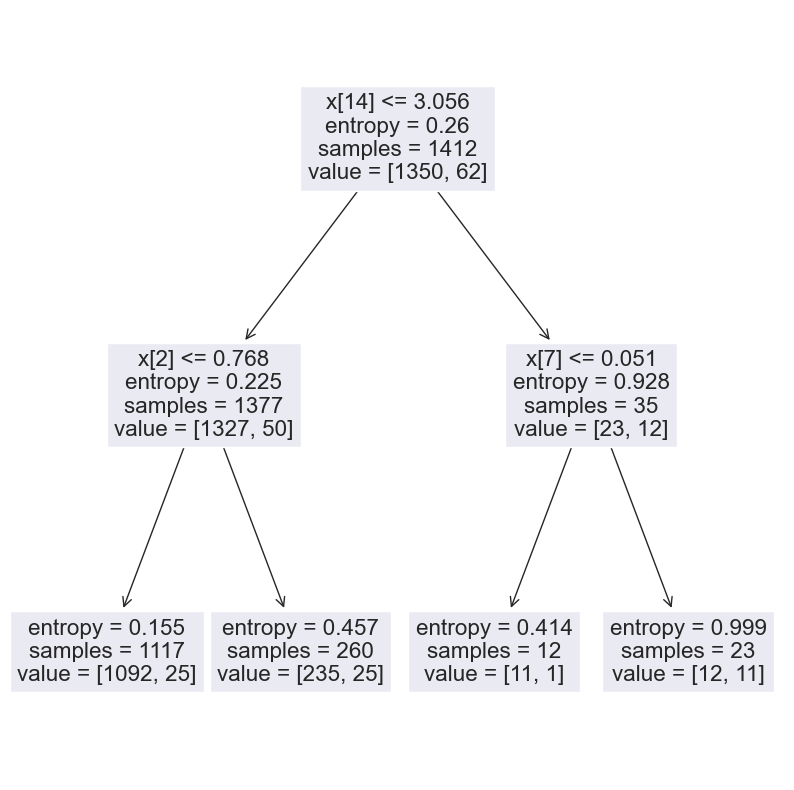

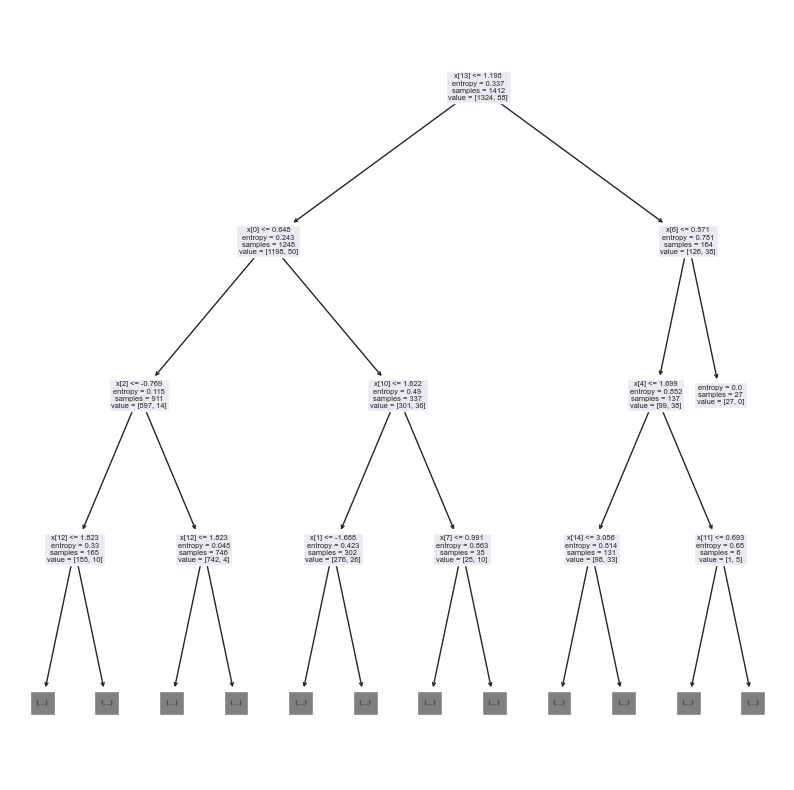

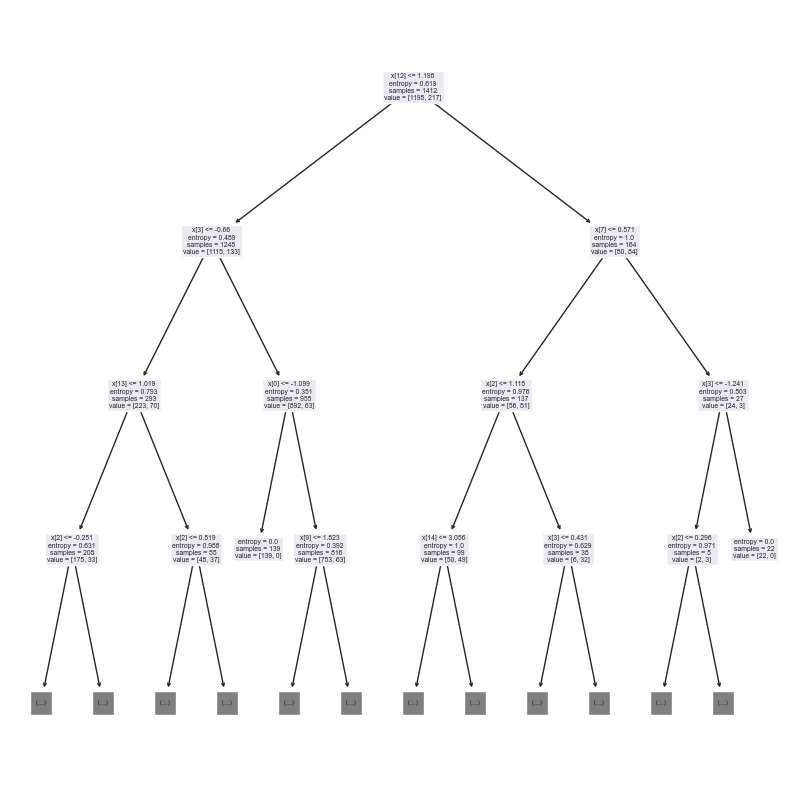

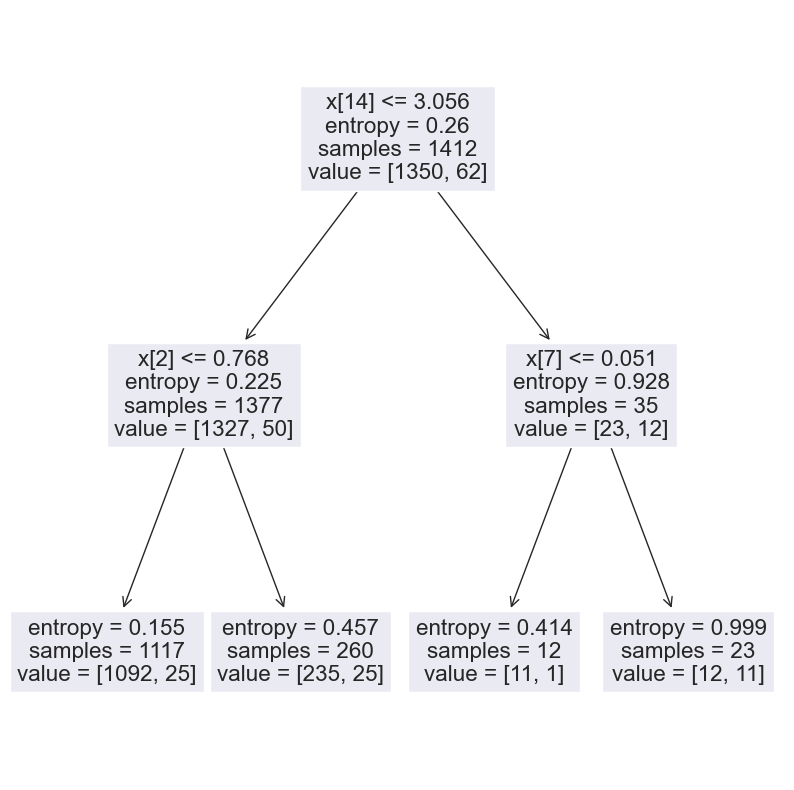

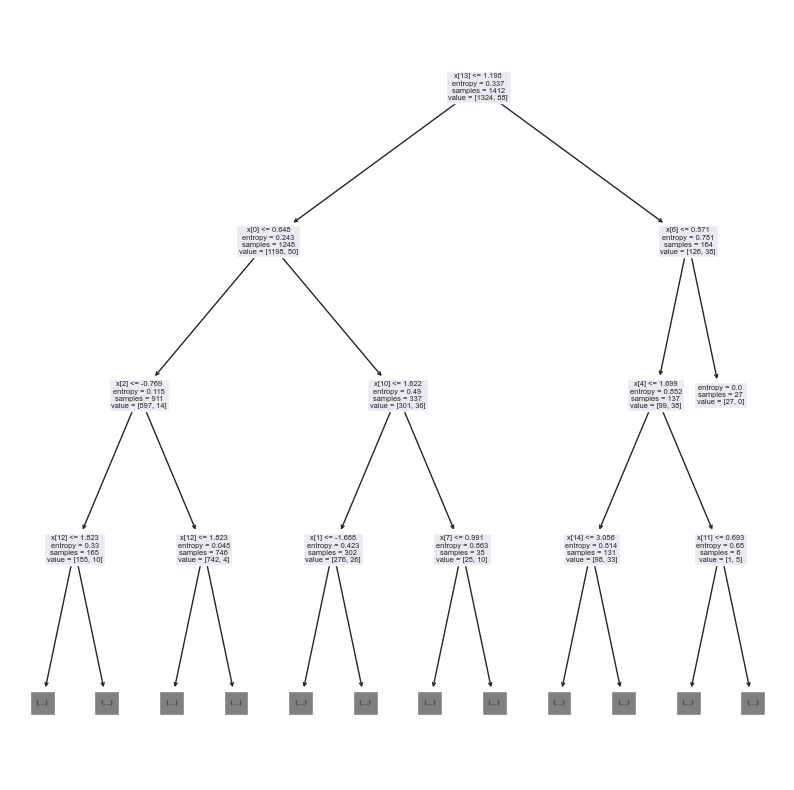

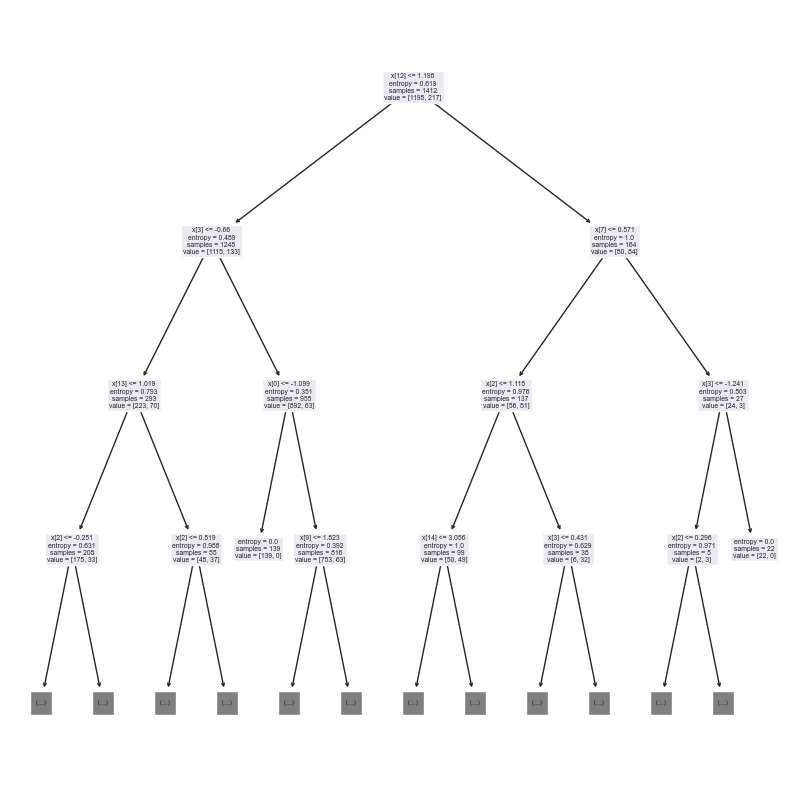

In [88]:
from sklearn.tree import plot_tree
for use_oversample in [False,True]:
    if use_oversample:
        model_name = "decision_feature_selection" + "_oversample"
    else:
        model_name = "decision_feature_selection"
    for p in predictors:
        loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
        plt.figure(figsize=(10, 10))
        plot_tree(loaded_pipe.named_steps["model"],max_depth =3)
        plt.savefig("figure/" + model_name + "_tree_" + p +".png",bbox_inches="tight")

In [67]:
score_df

model  test_accuracy  \
0                                lr_baseline       0.958829   
1                                lr_baseline       0.930872   
2                                lr_baseline       0.869202   
3     logistic_feature_selection5_oversample       0.769048   
4     logistic_feature_selection5_oversample       0.779866   
..                                       ...            ...   
416  decision_feature_selection20_oversample       0.738325   
417             decision_feature_selection25       0.801116   
418  decision_feature_selection25_oversample       0.730647   
419             decision_feature_selection30       0.810187   
420  decision_feature_selection30_oversample       0.743203   

                   outcome  fit_time  score_time  test_precision  test_recall  \
0            lvef_abnormal  0.017805    0.010602        0.613333     0.161538   
1    In-Hospital Mortality  0.017404    0.010002        0.491429     0.250000   
2            ICU admission  0.013803    0.010402        0.682736     0.366667   
3            lvef_abnormal  3.837110    0.009802        0.079083     0.407692   
4    In-Hospital Mortality  3.743333    0.010401        0.191968     0.710000   
..                     ...       ...         ...             ...          ...   
416          lvef_abnormal  0.721961    0.026406        0.400643     0.609135   
417          lvef_abnormal  0.237453    0.024406        0.600000     0.013854   
418          lvef_abnormal  0.718360    0.025206        0.393898     0.629885   
419          lvef_abnormal  0.277973    0.027206        0.850000     0.069208   
420          lvef_abnormal  0.766874    0.025806        0.406721     0.619540   

      test_f1  test_roc_auc  
0    0.240610      0.715484  
1    0.321319      0.854388  
2    0.475193      0.822408  
3    0.132289      0.630730  
4    0.301497      0.827626  
..        ...           ...  
416  0.481788      0.765432  
417  0.027010      0.788950  
418  0.483646      0.765059  
419  0.127449      0.783923  
420  0.490426      0.765613  

[421 rows x 9 columns]

In [66]:
score_df.to_csv(cv_result_filename)
test_df.to_csv(test_result_filename)

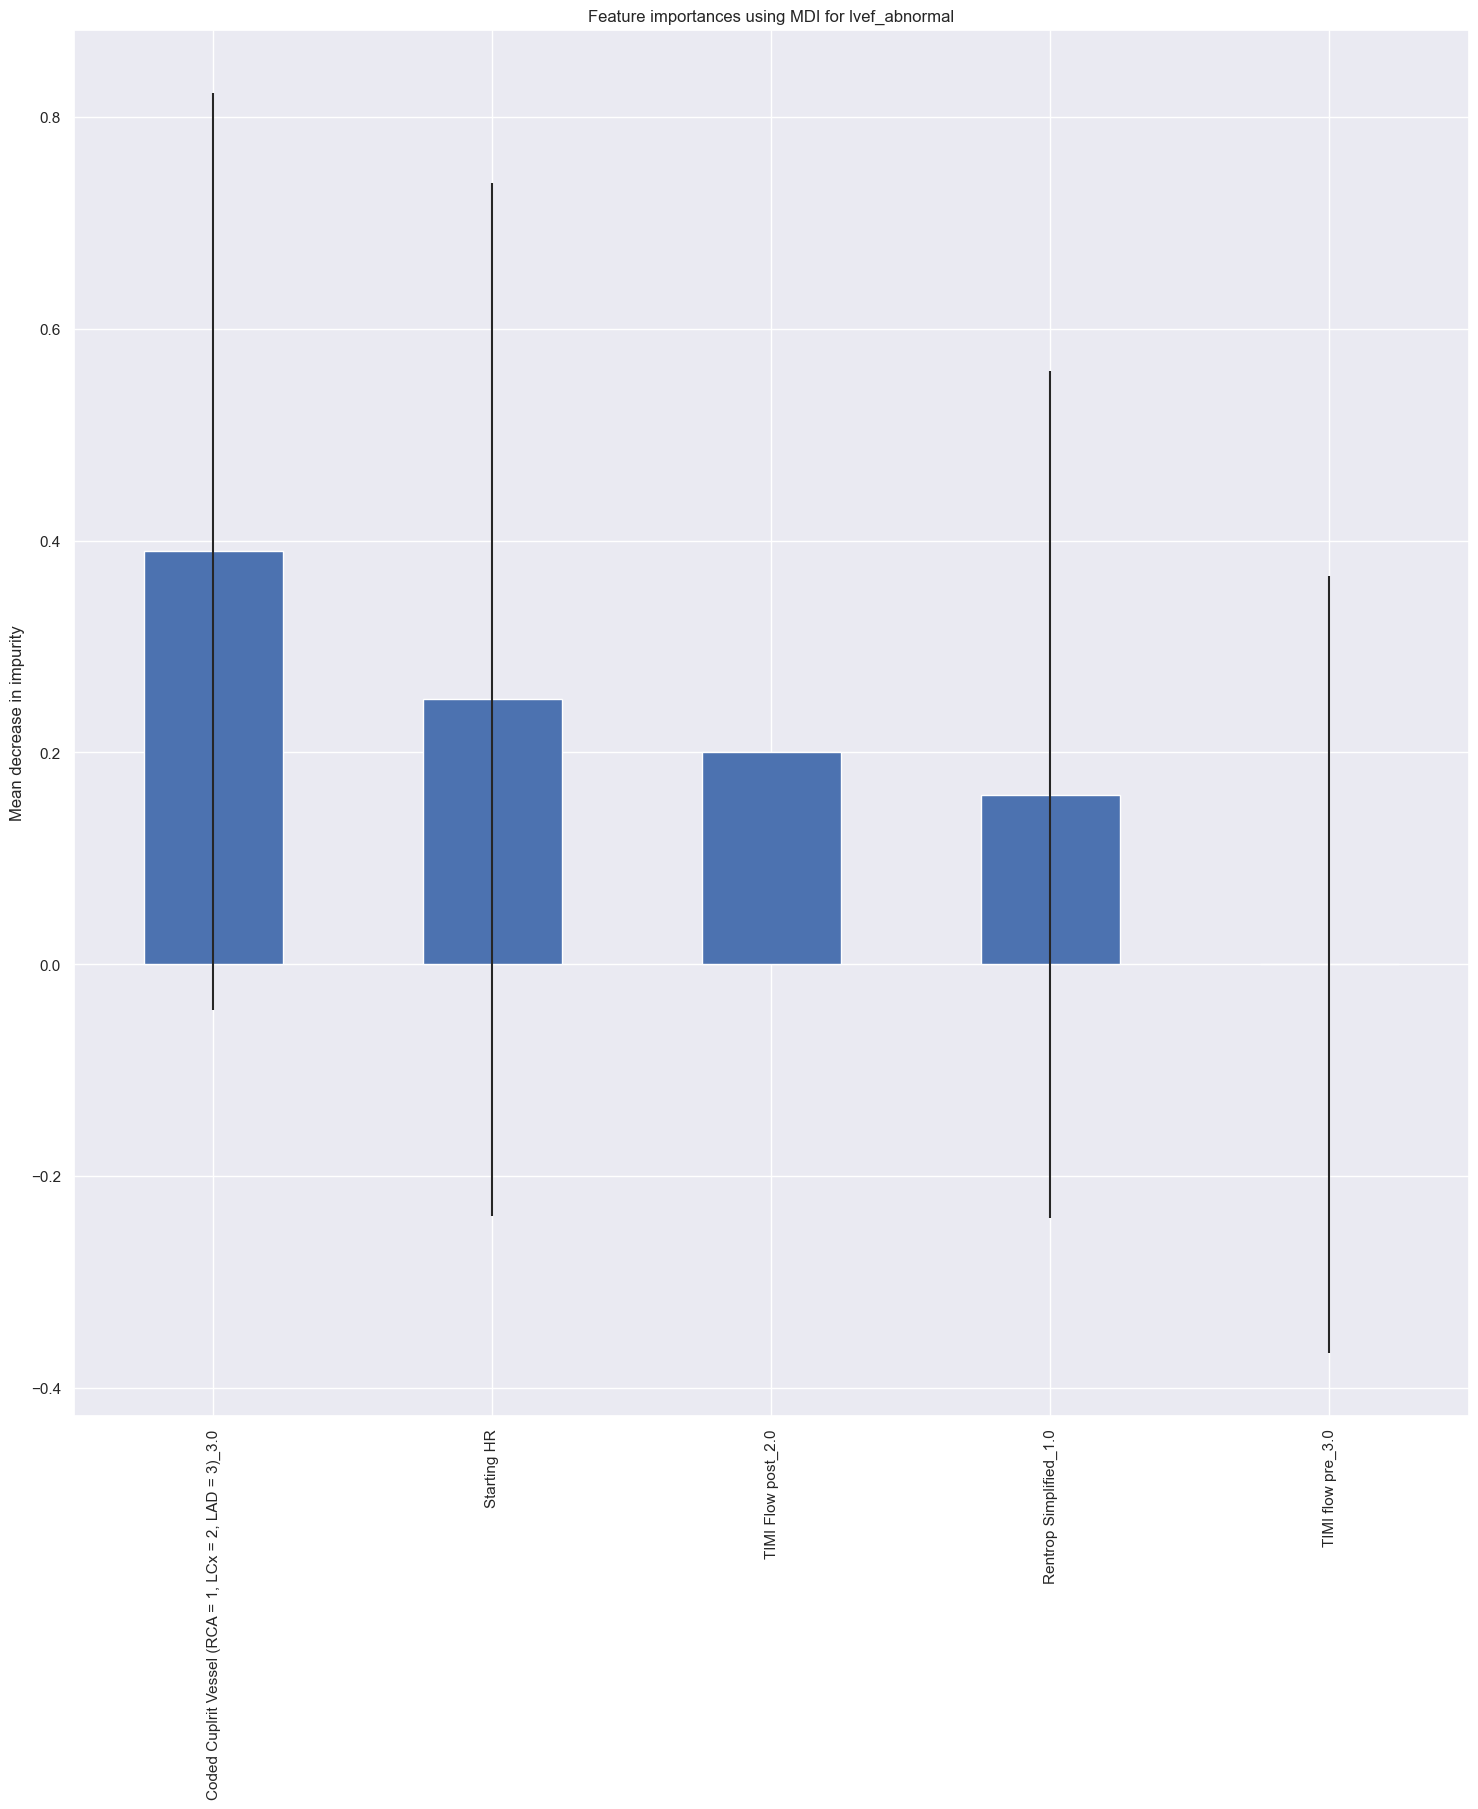

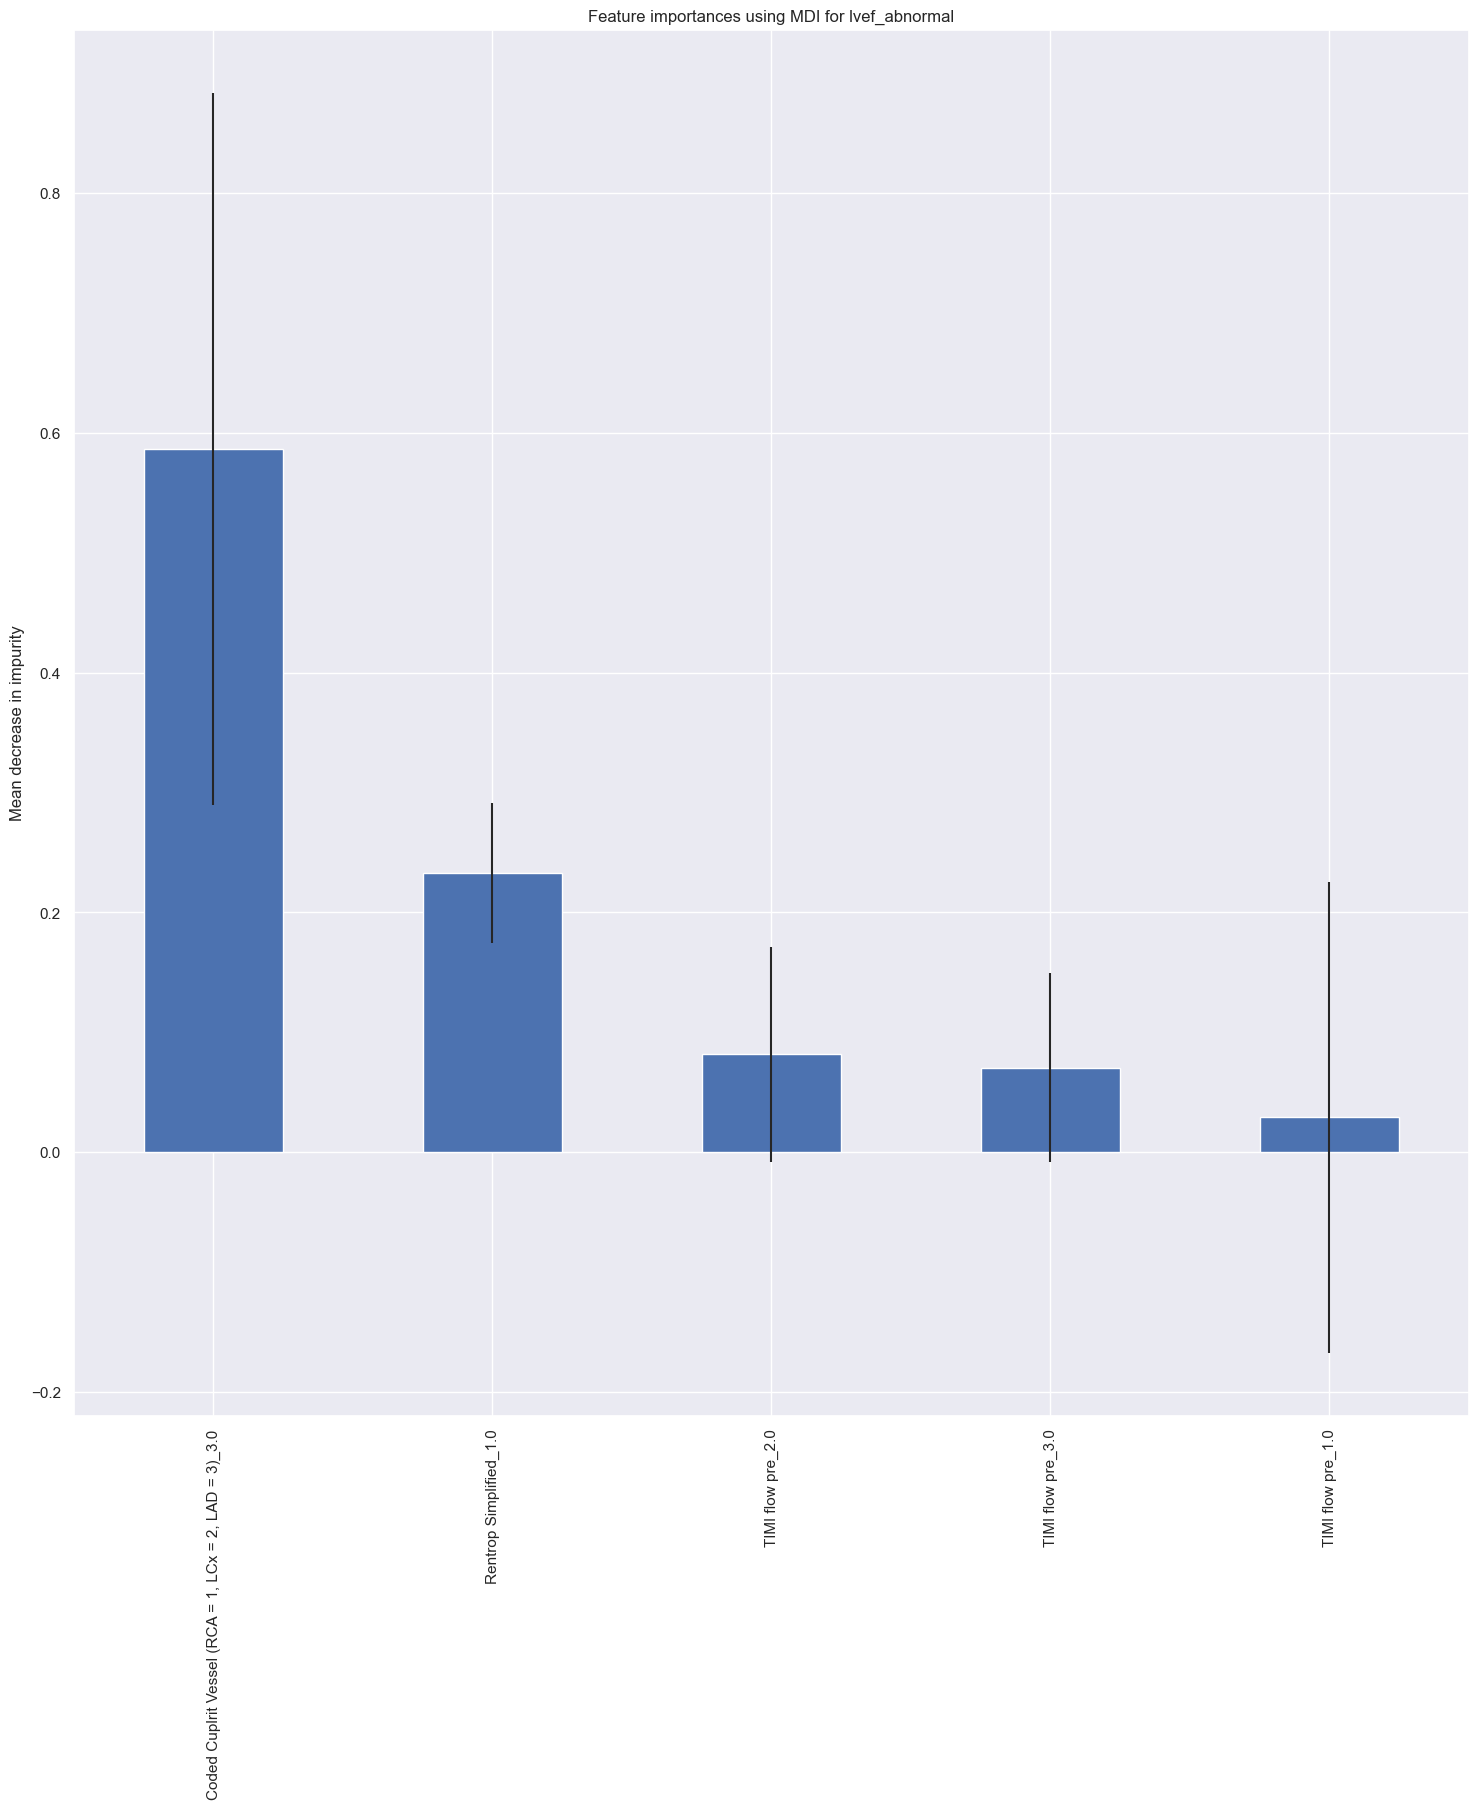

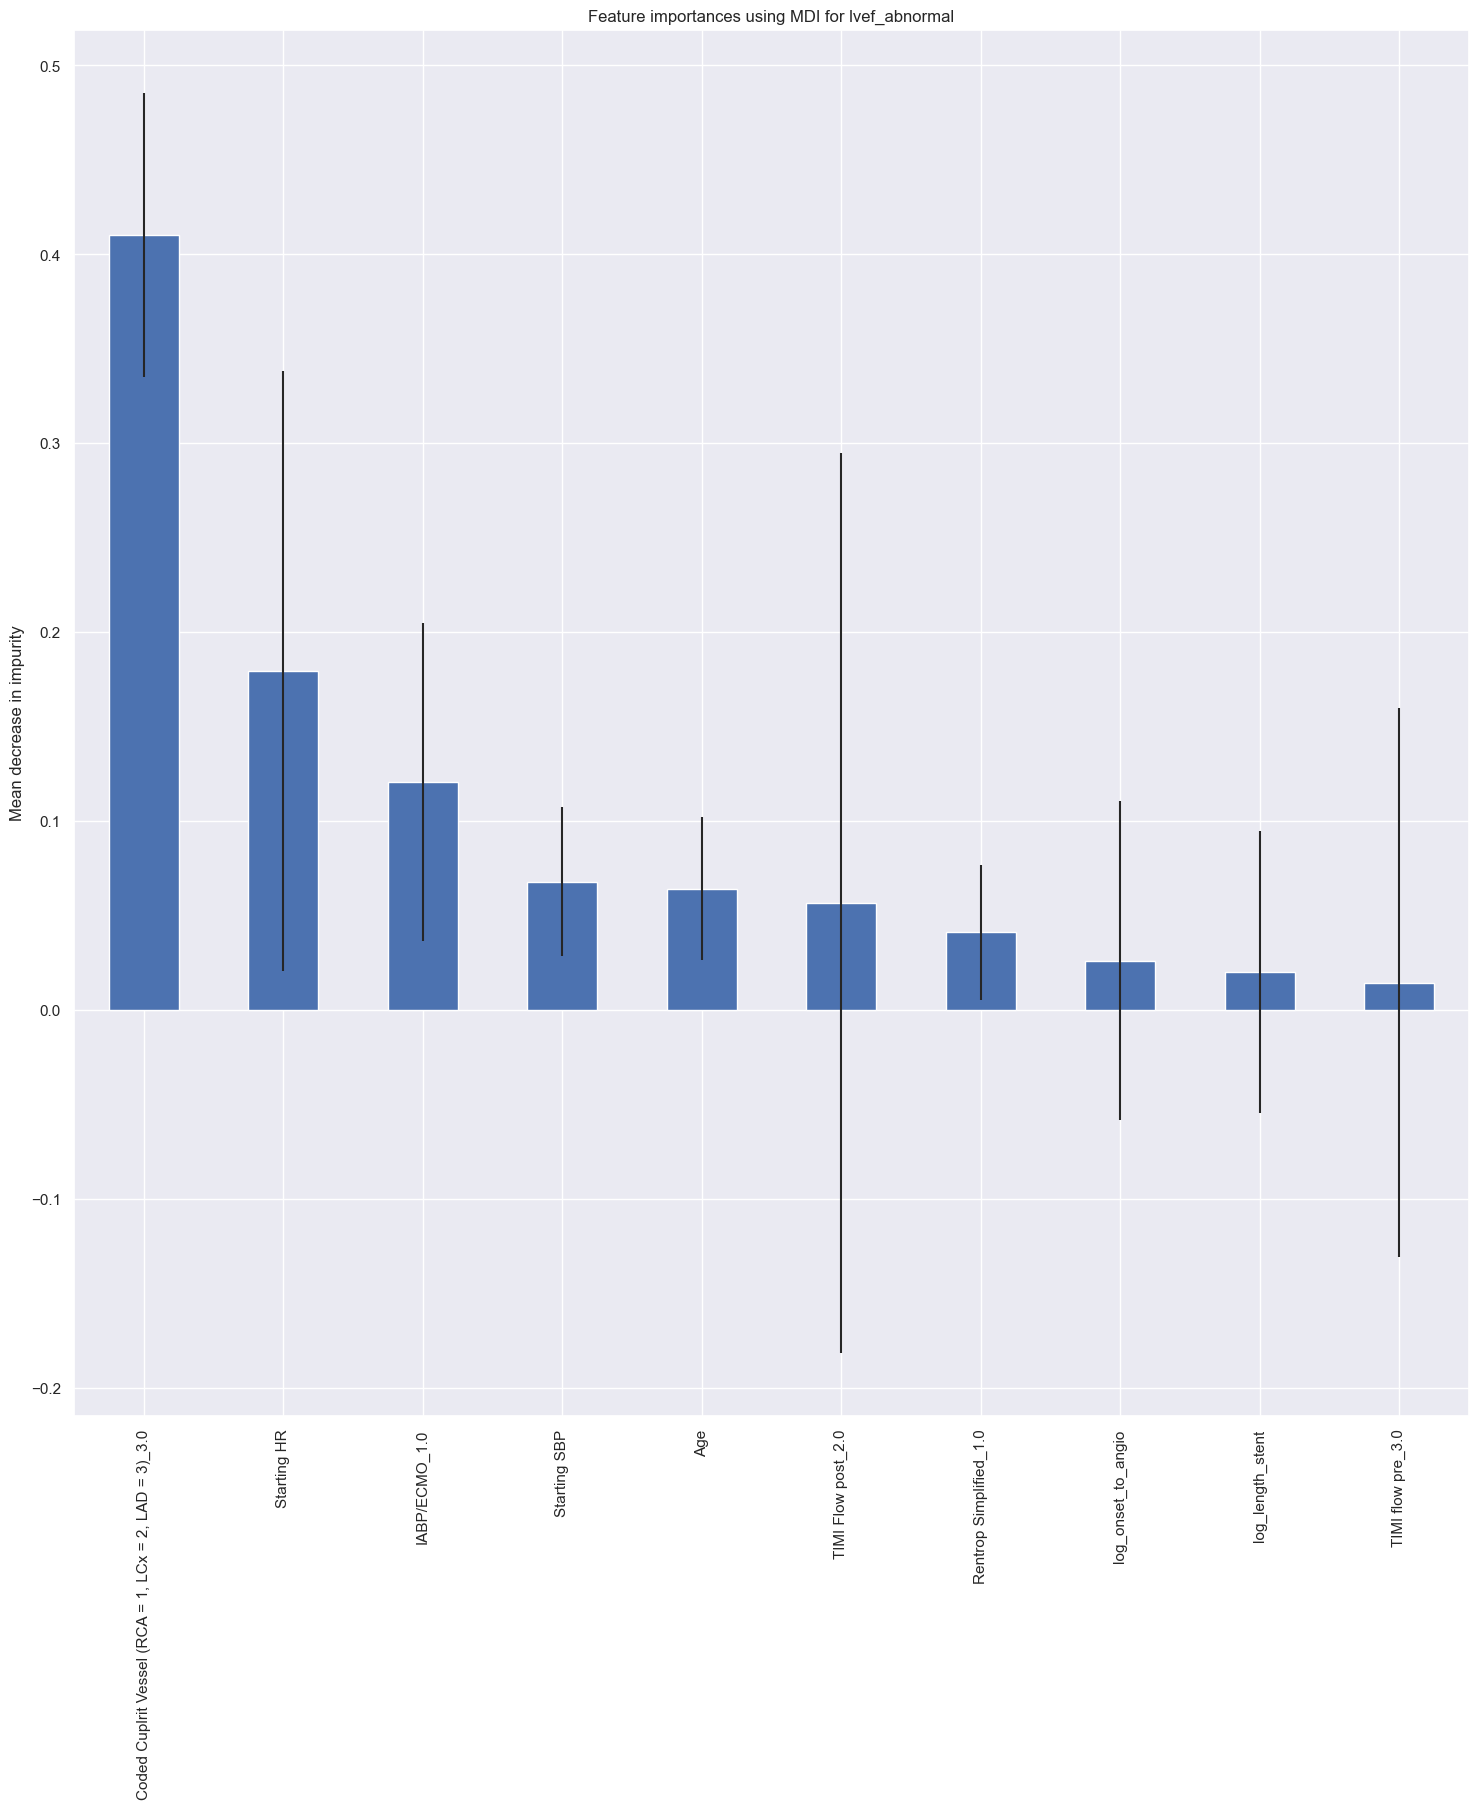

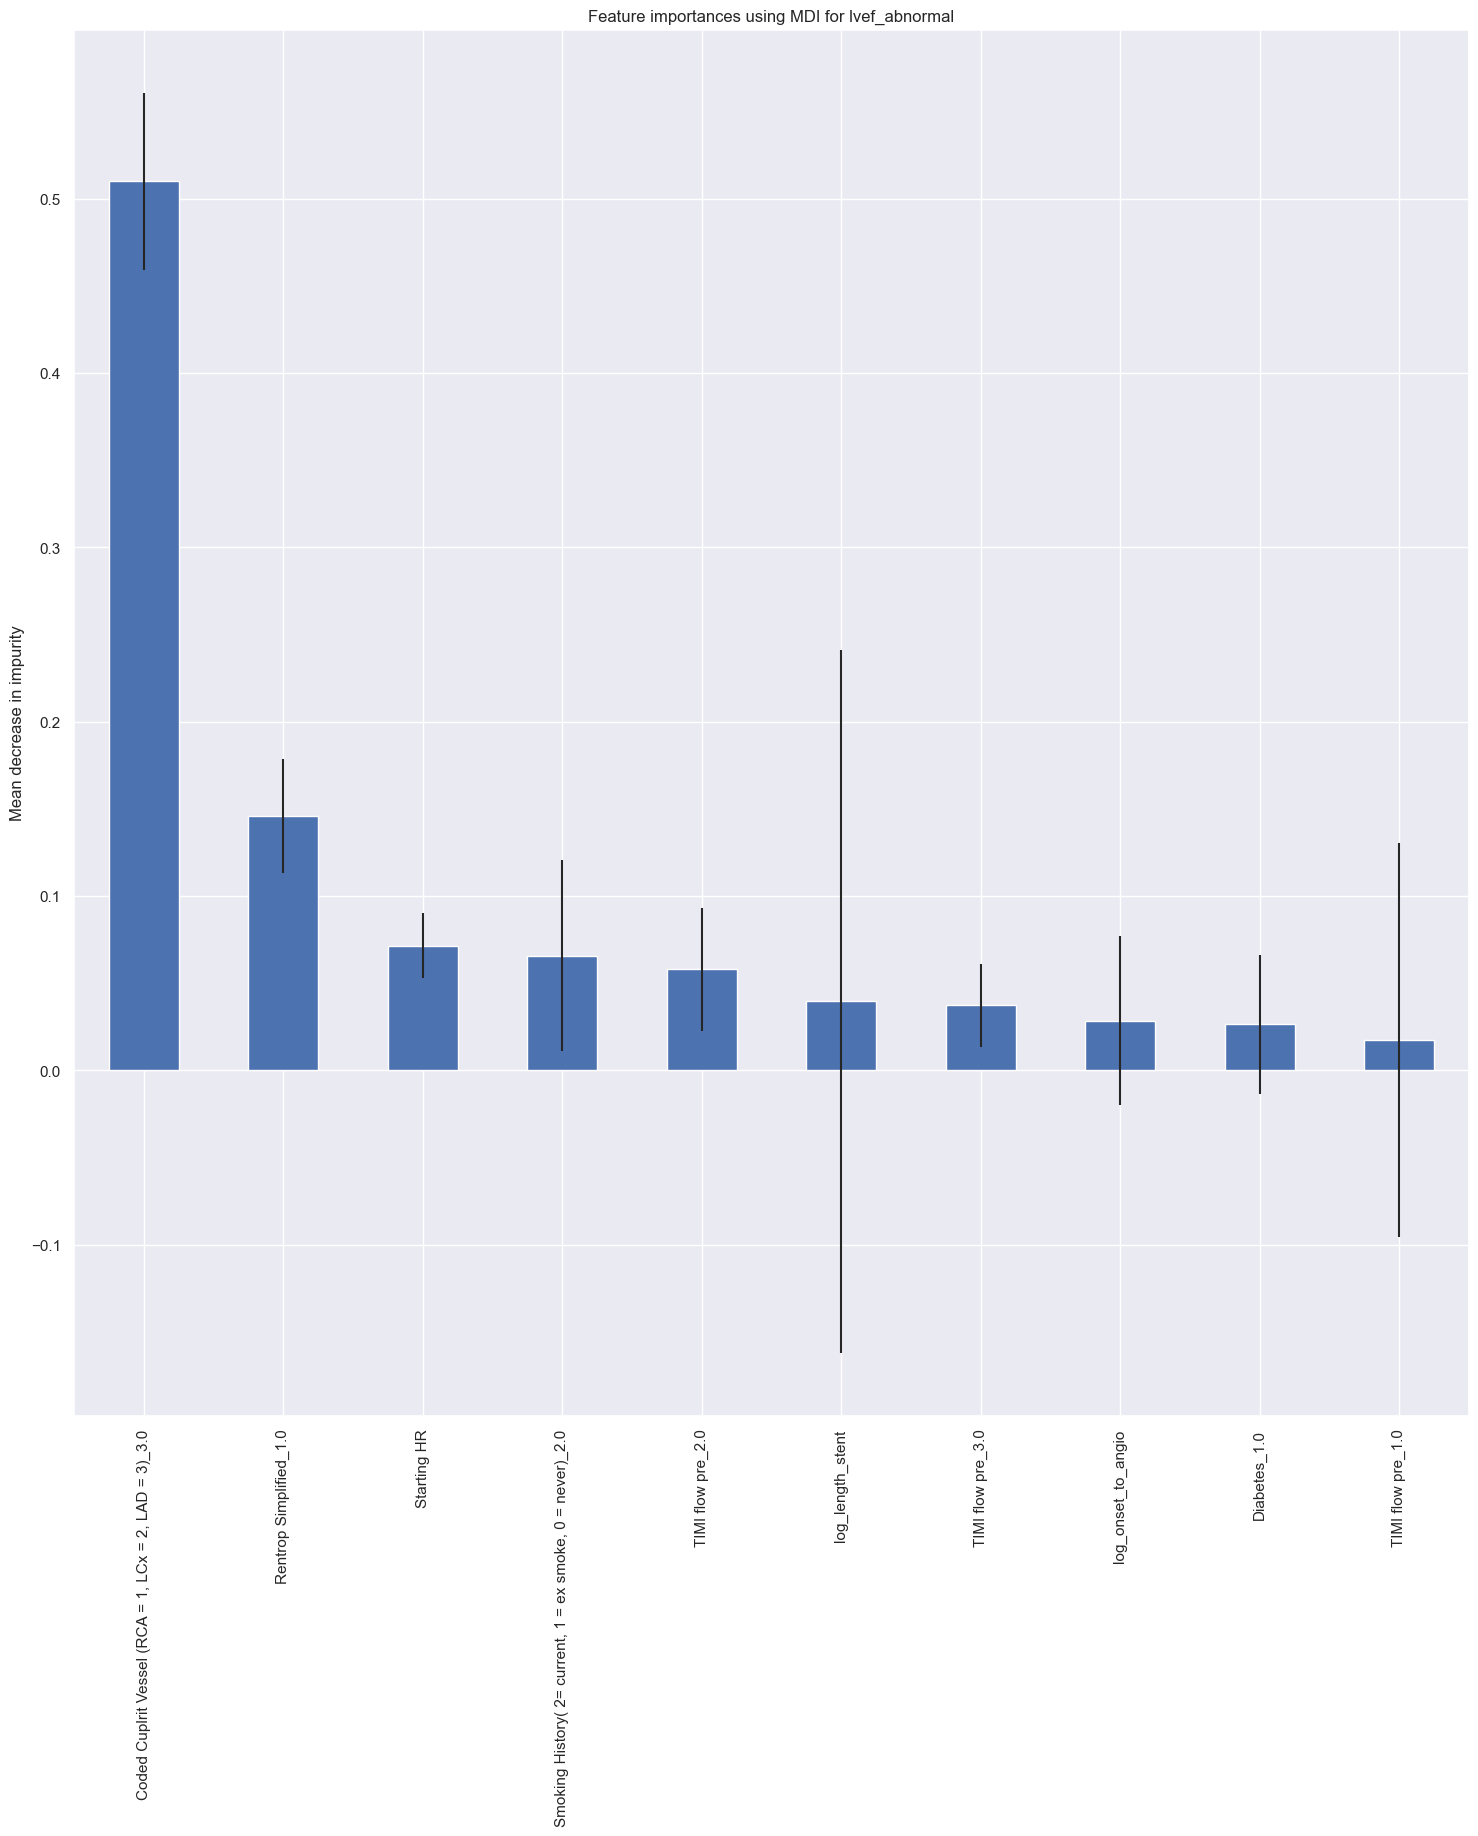

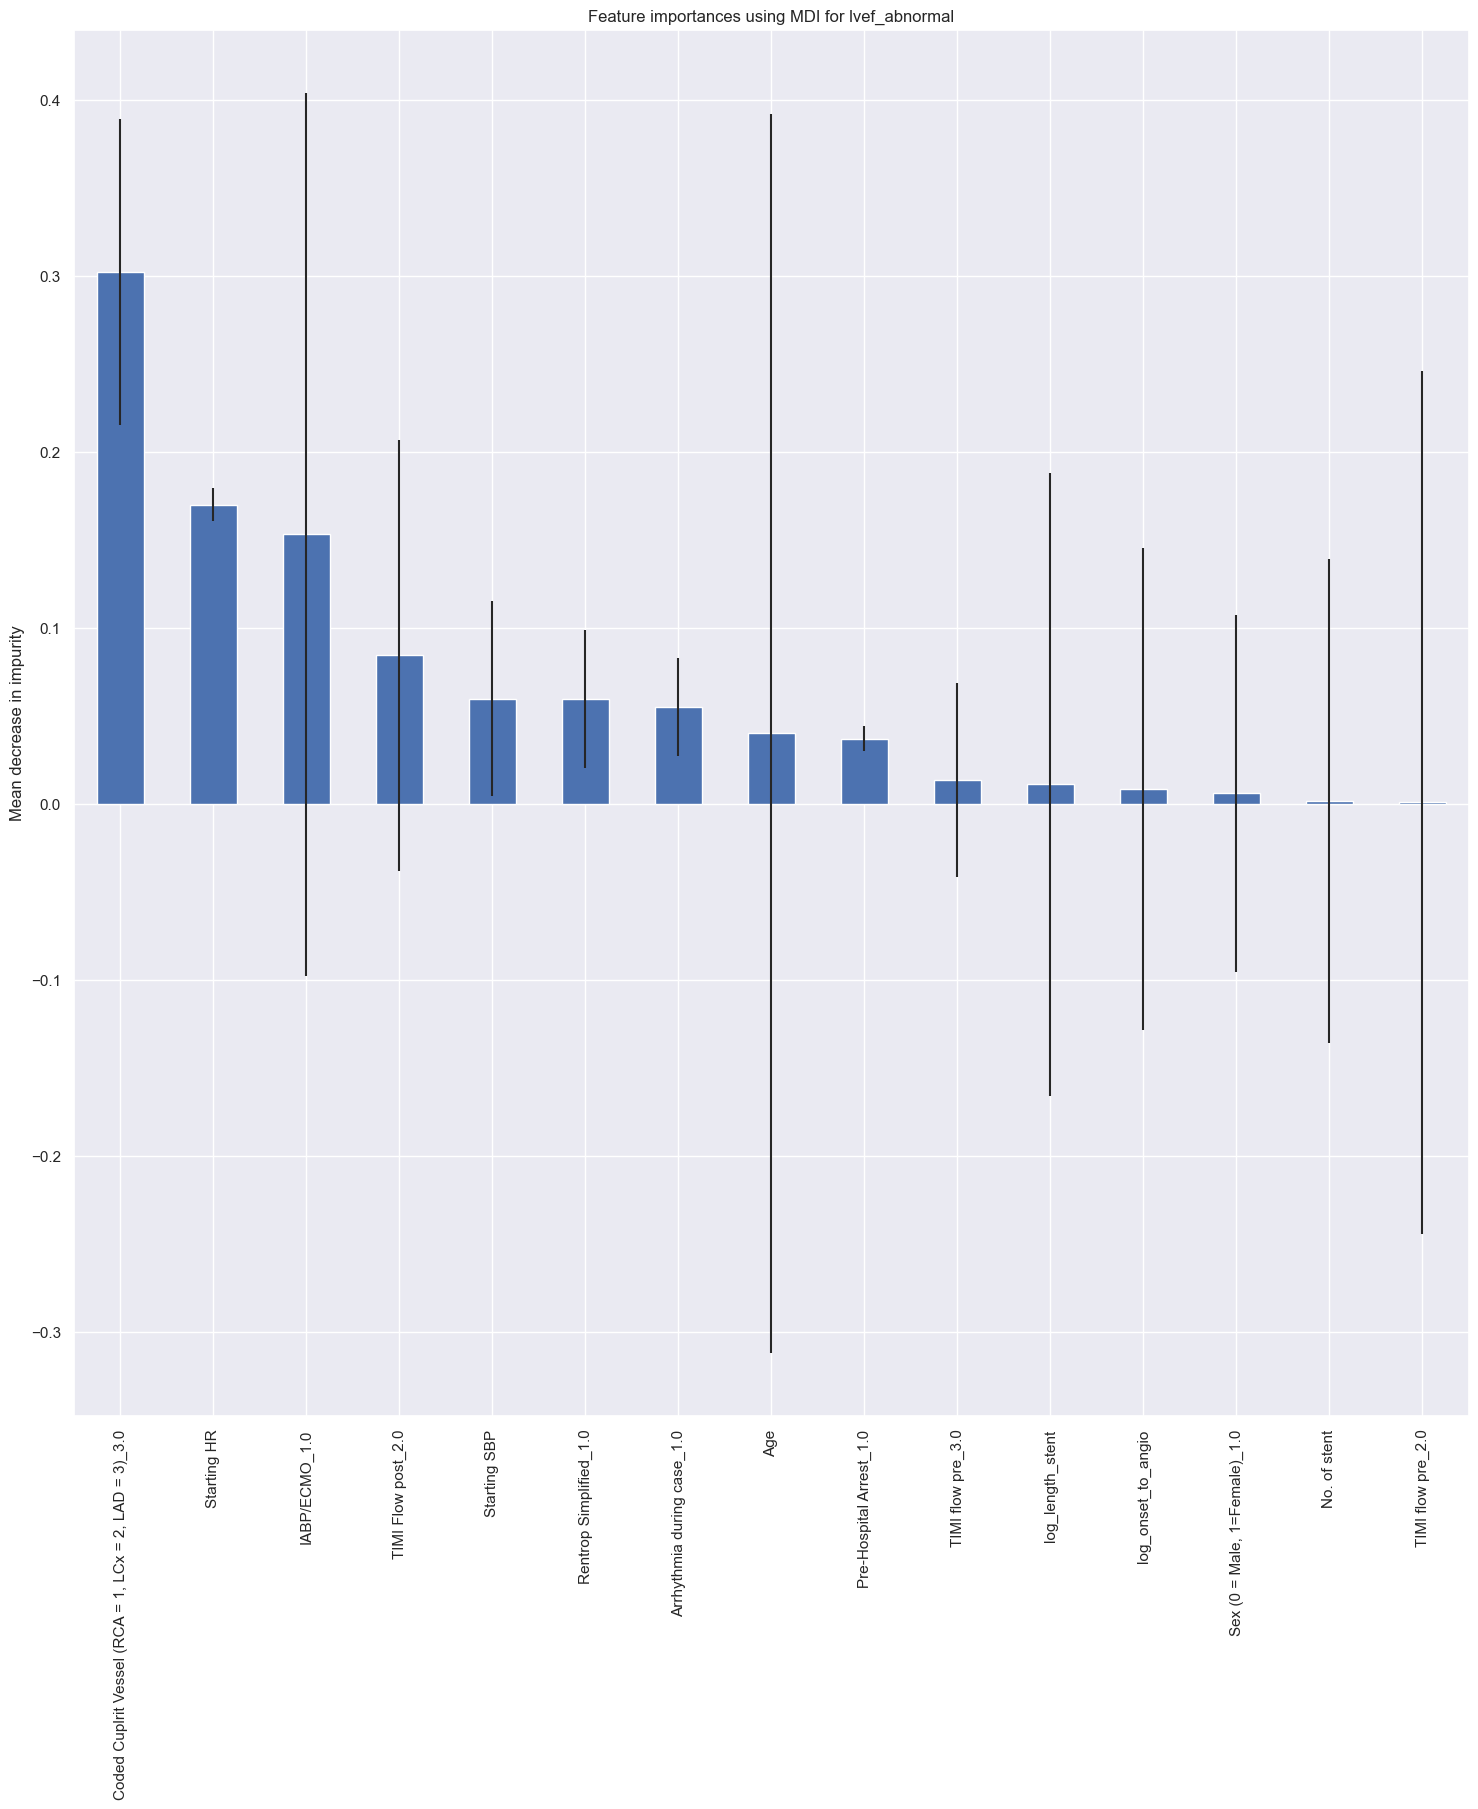

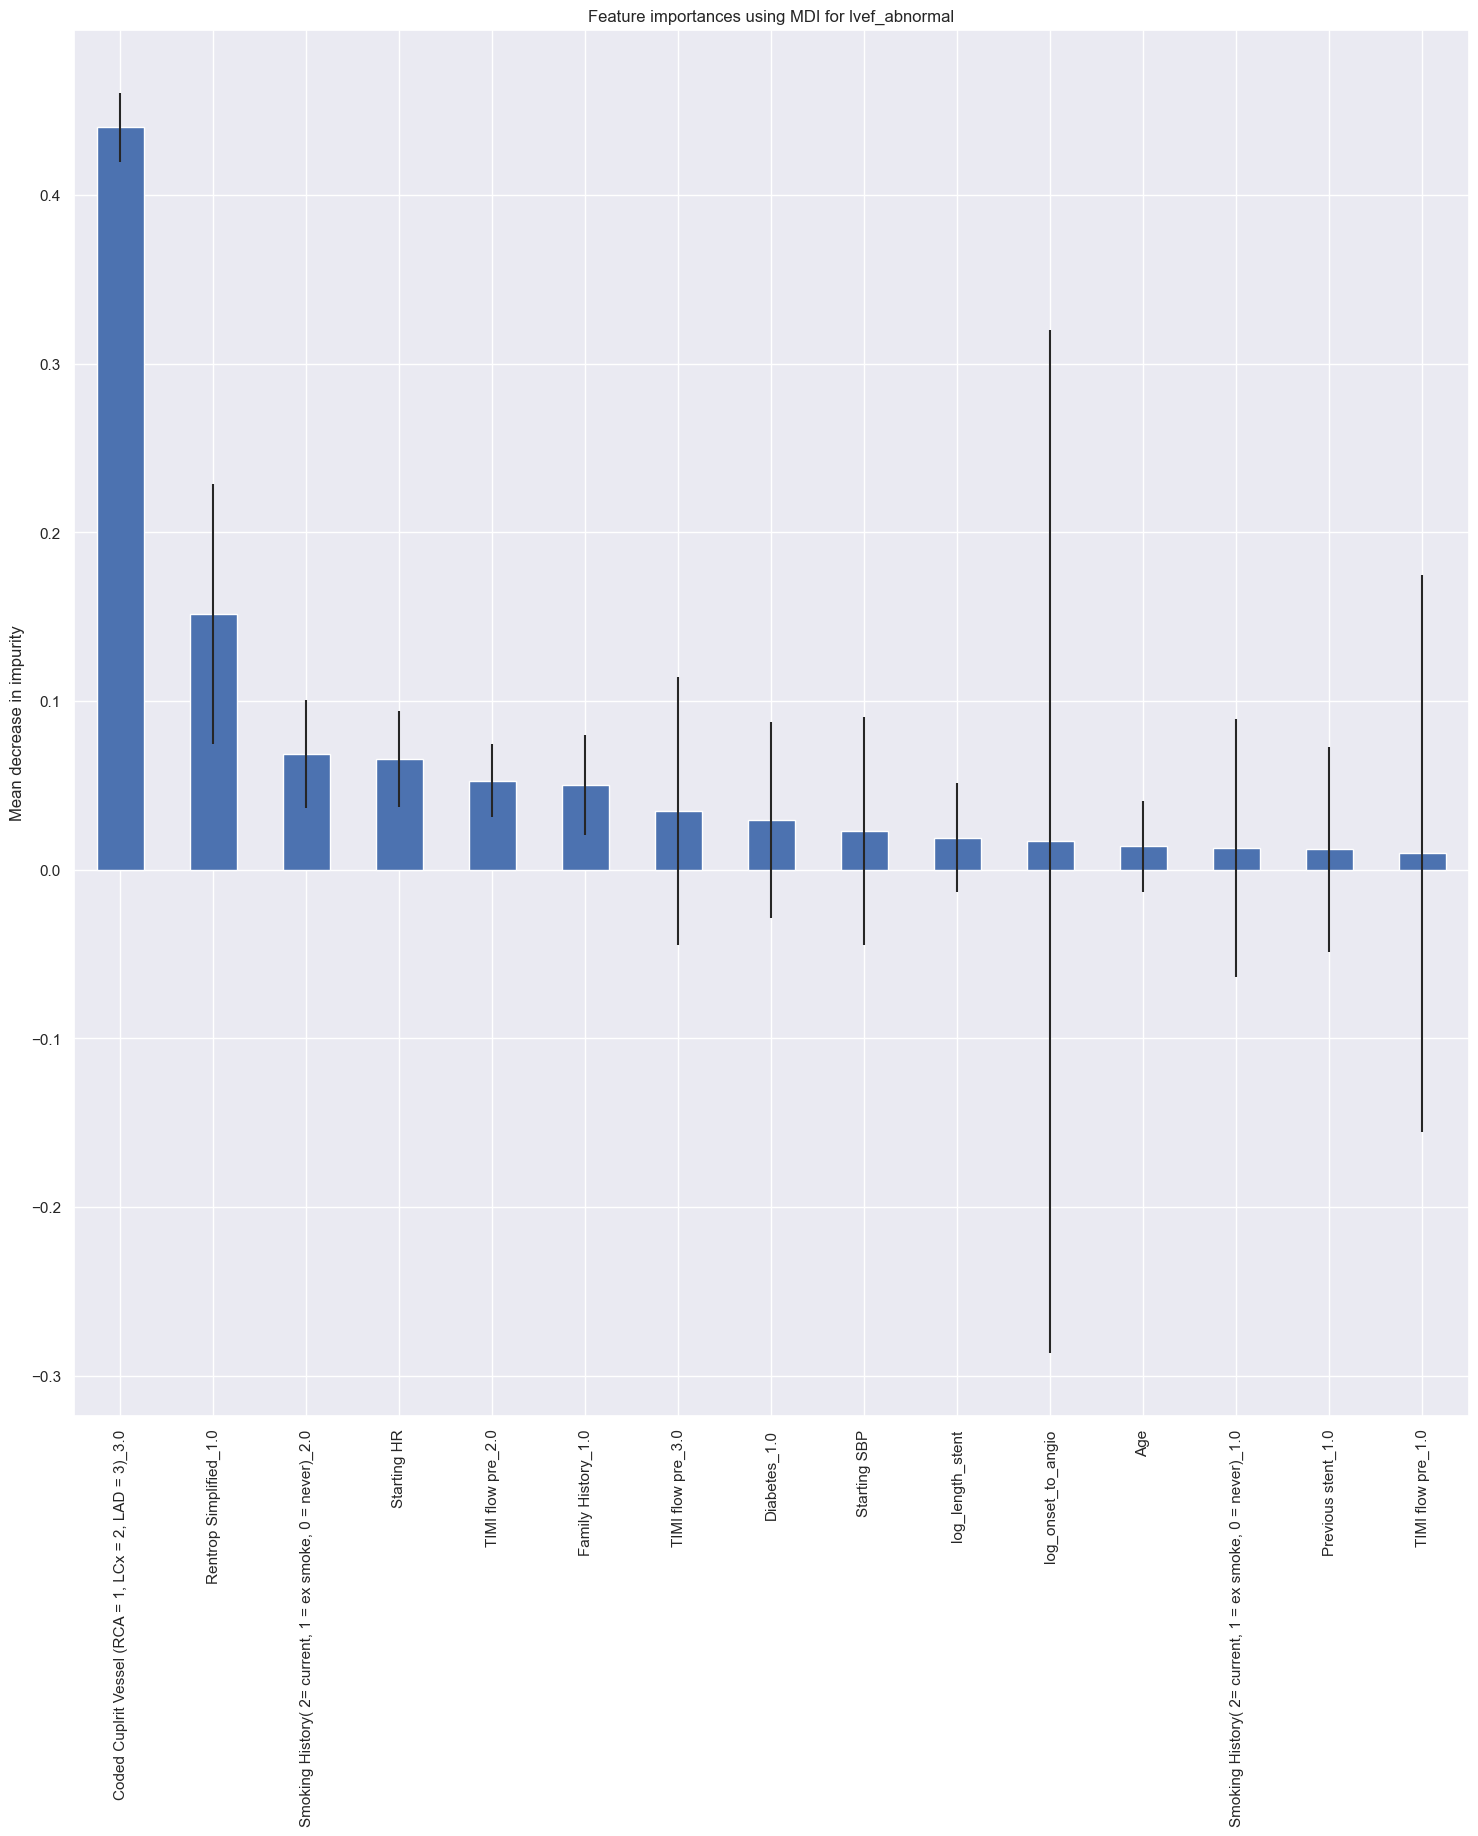

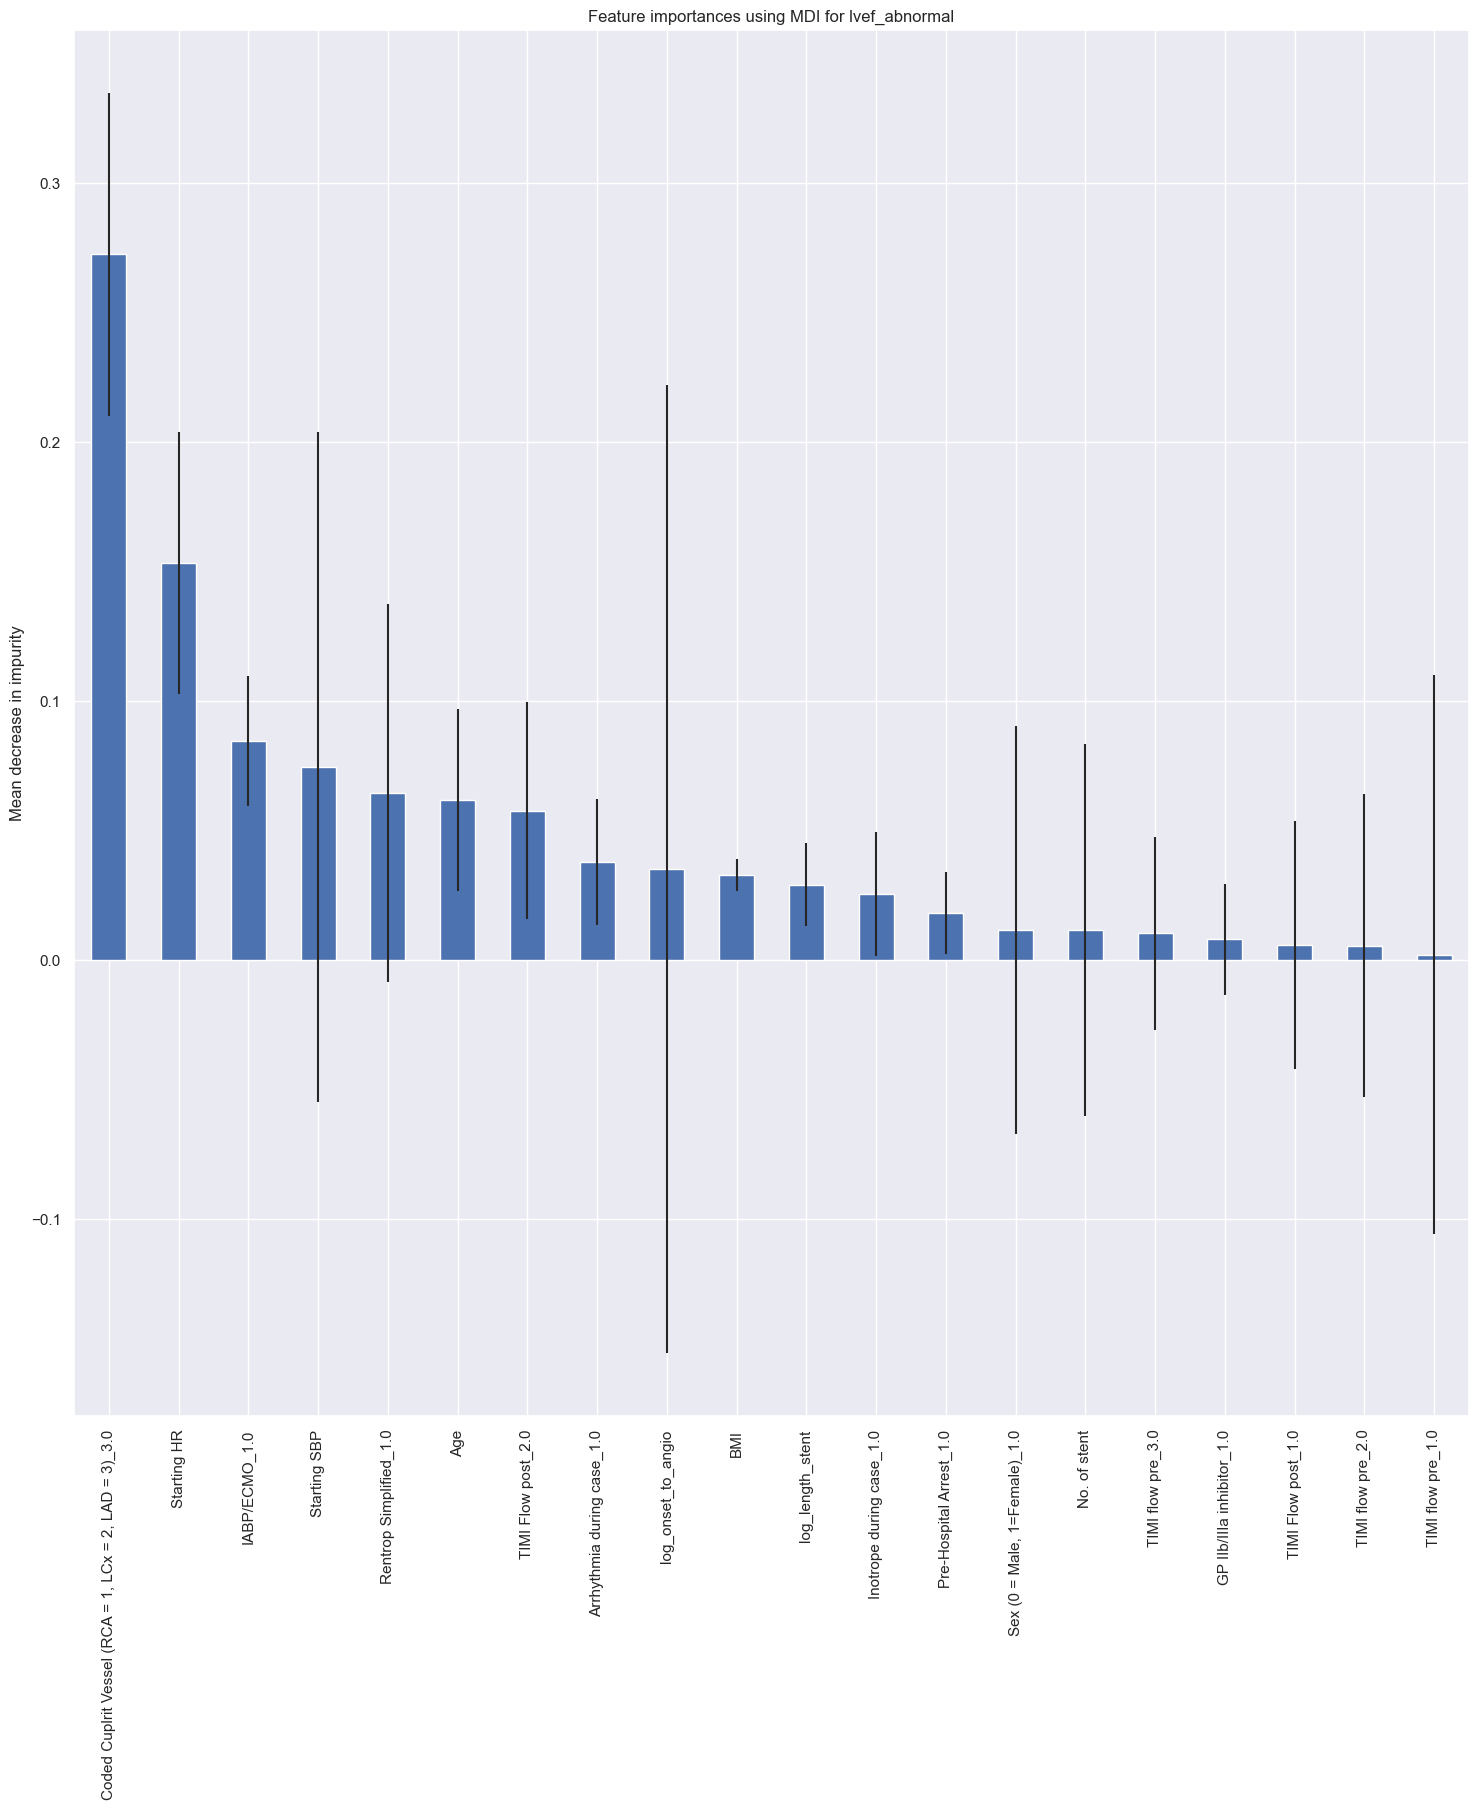

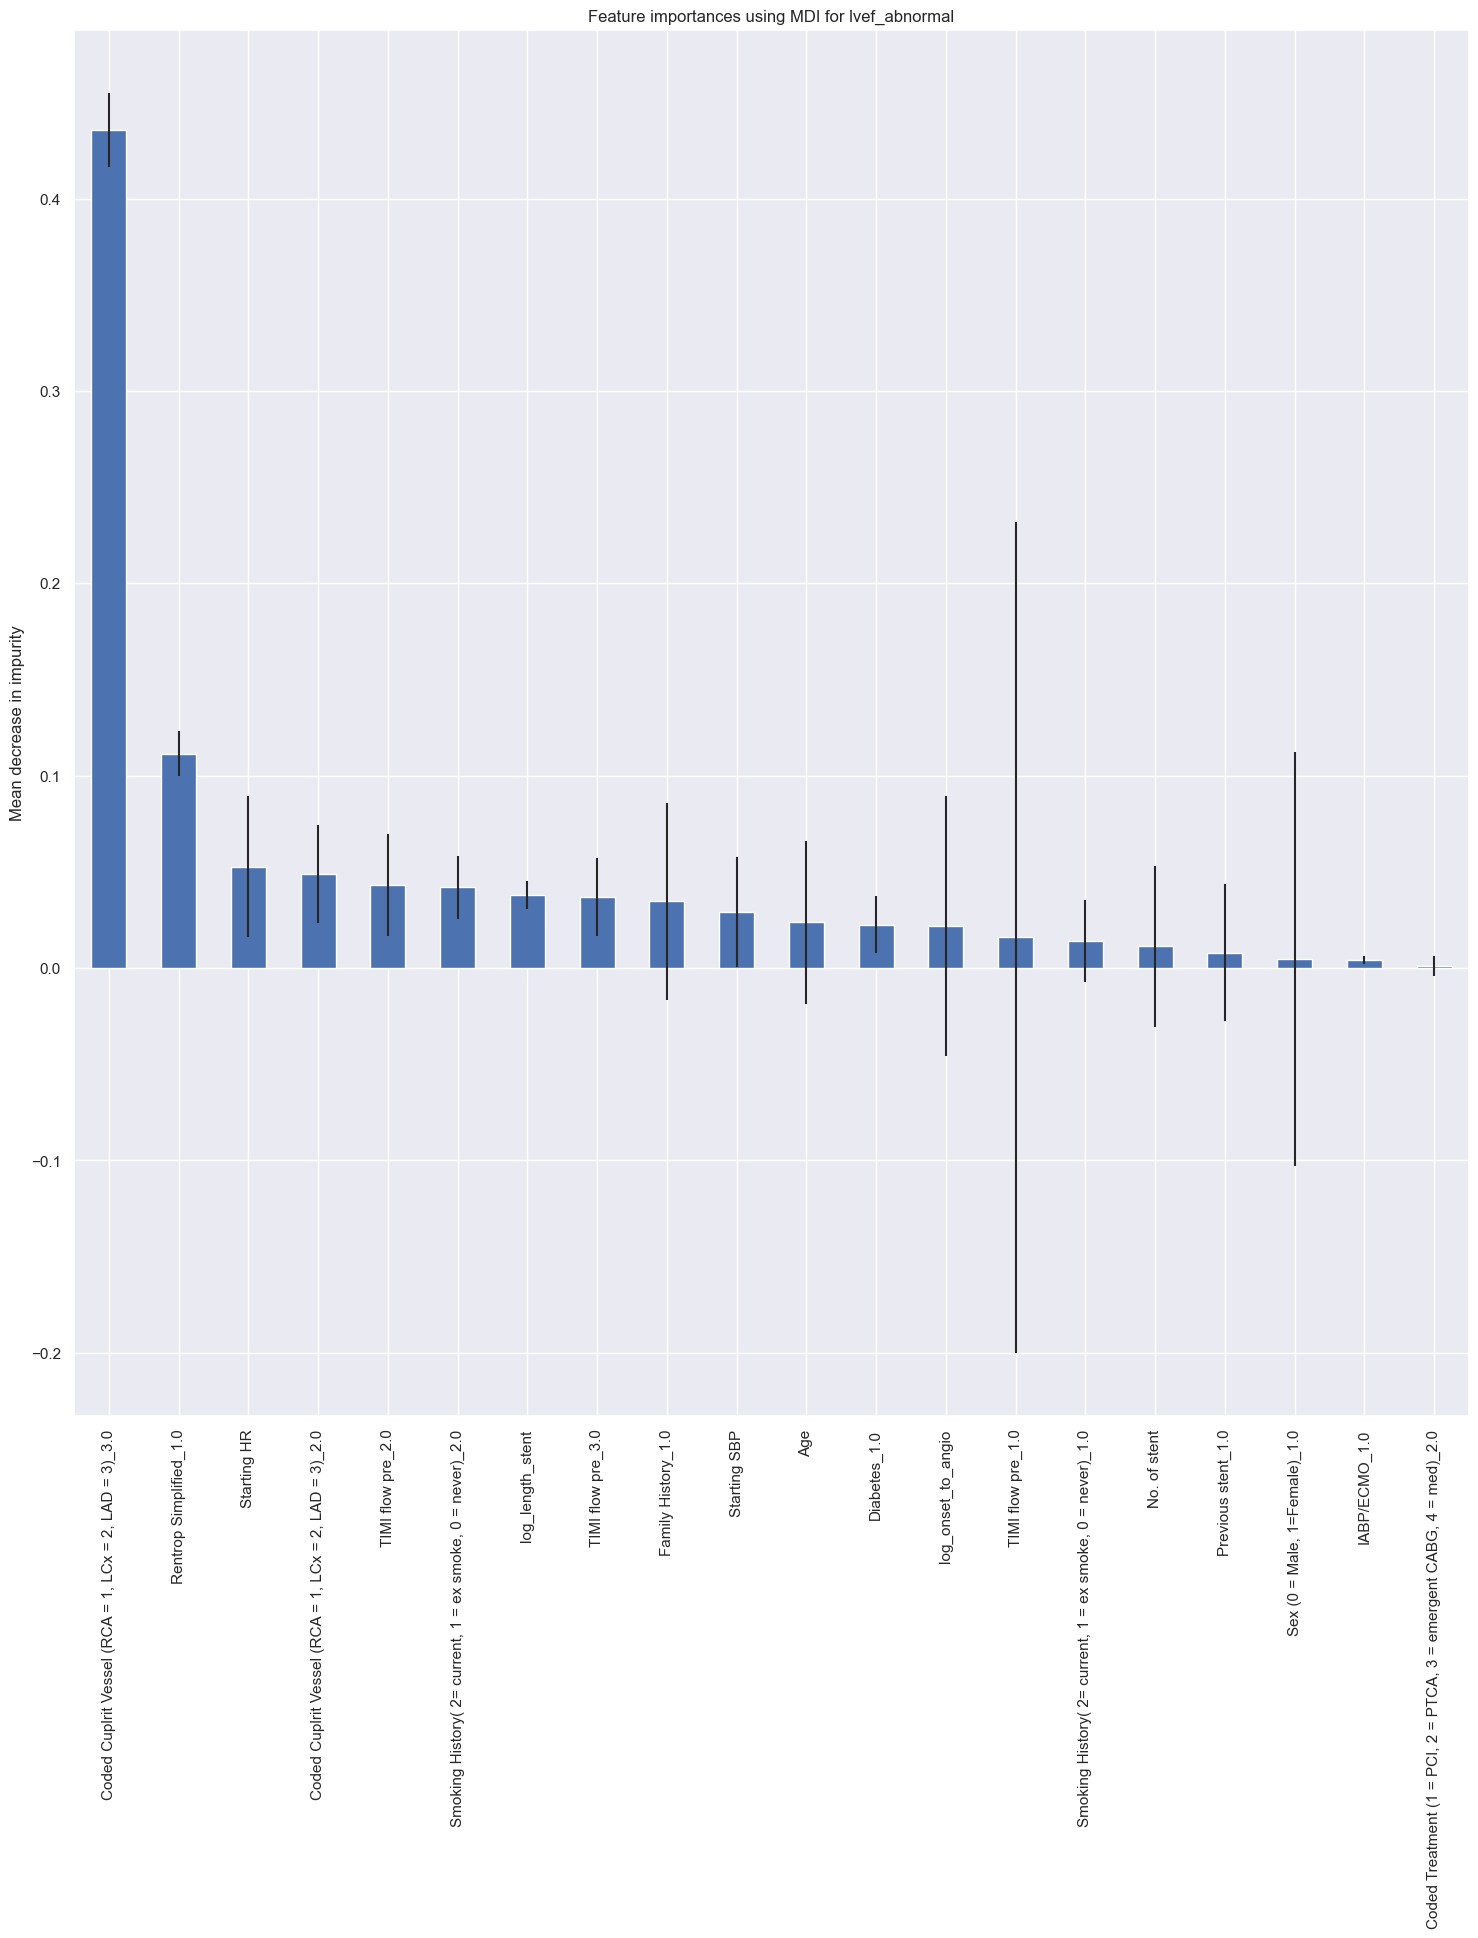

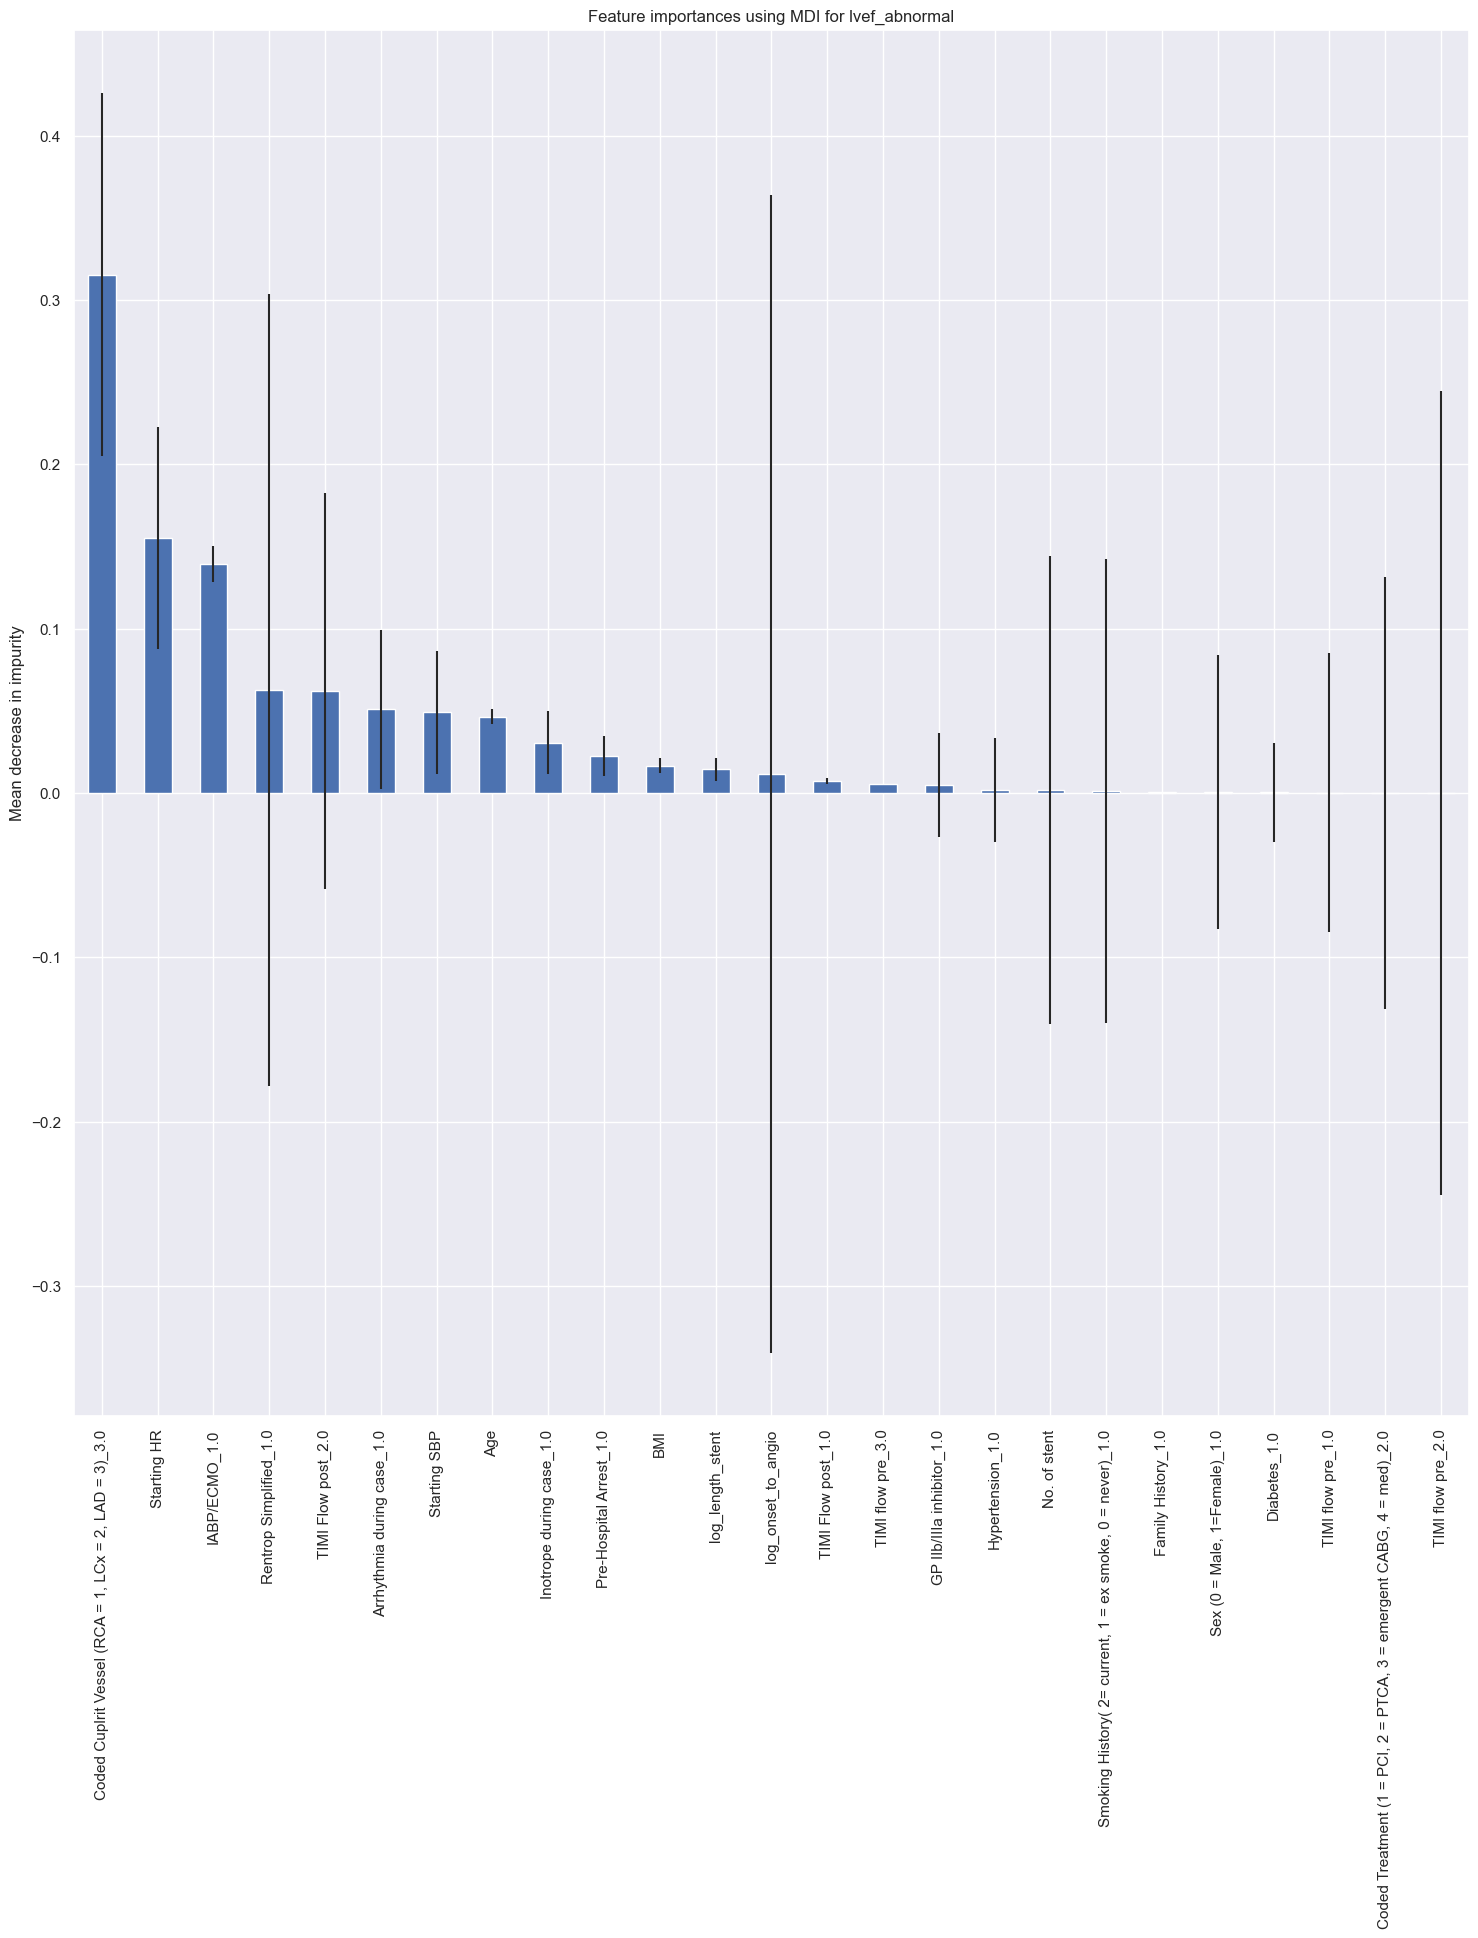

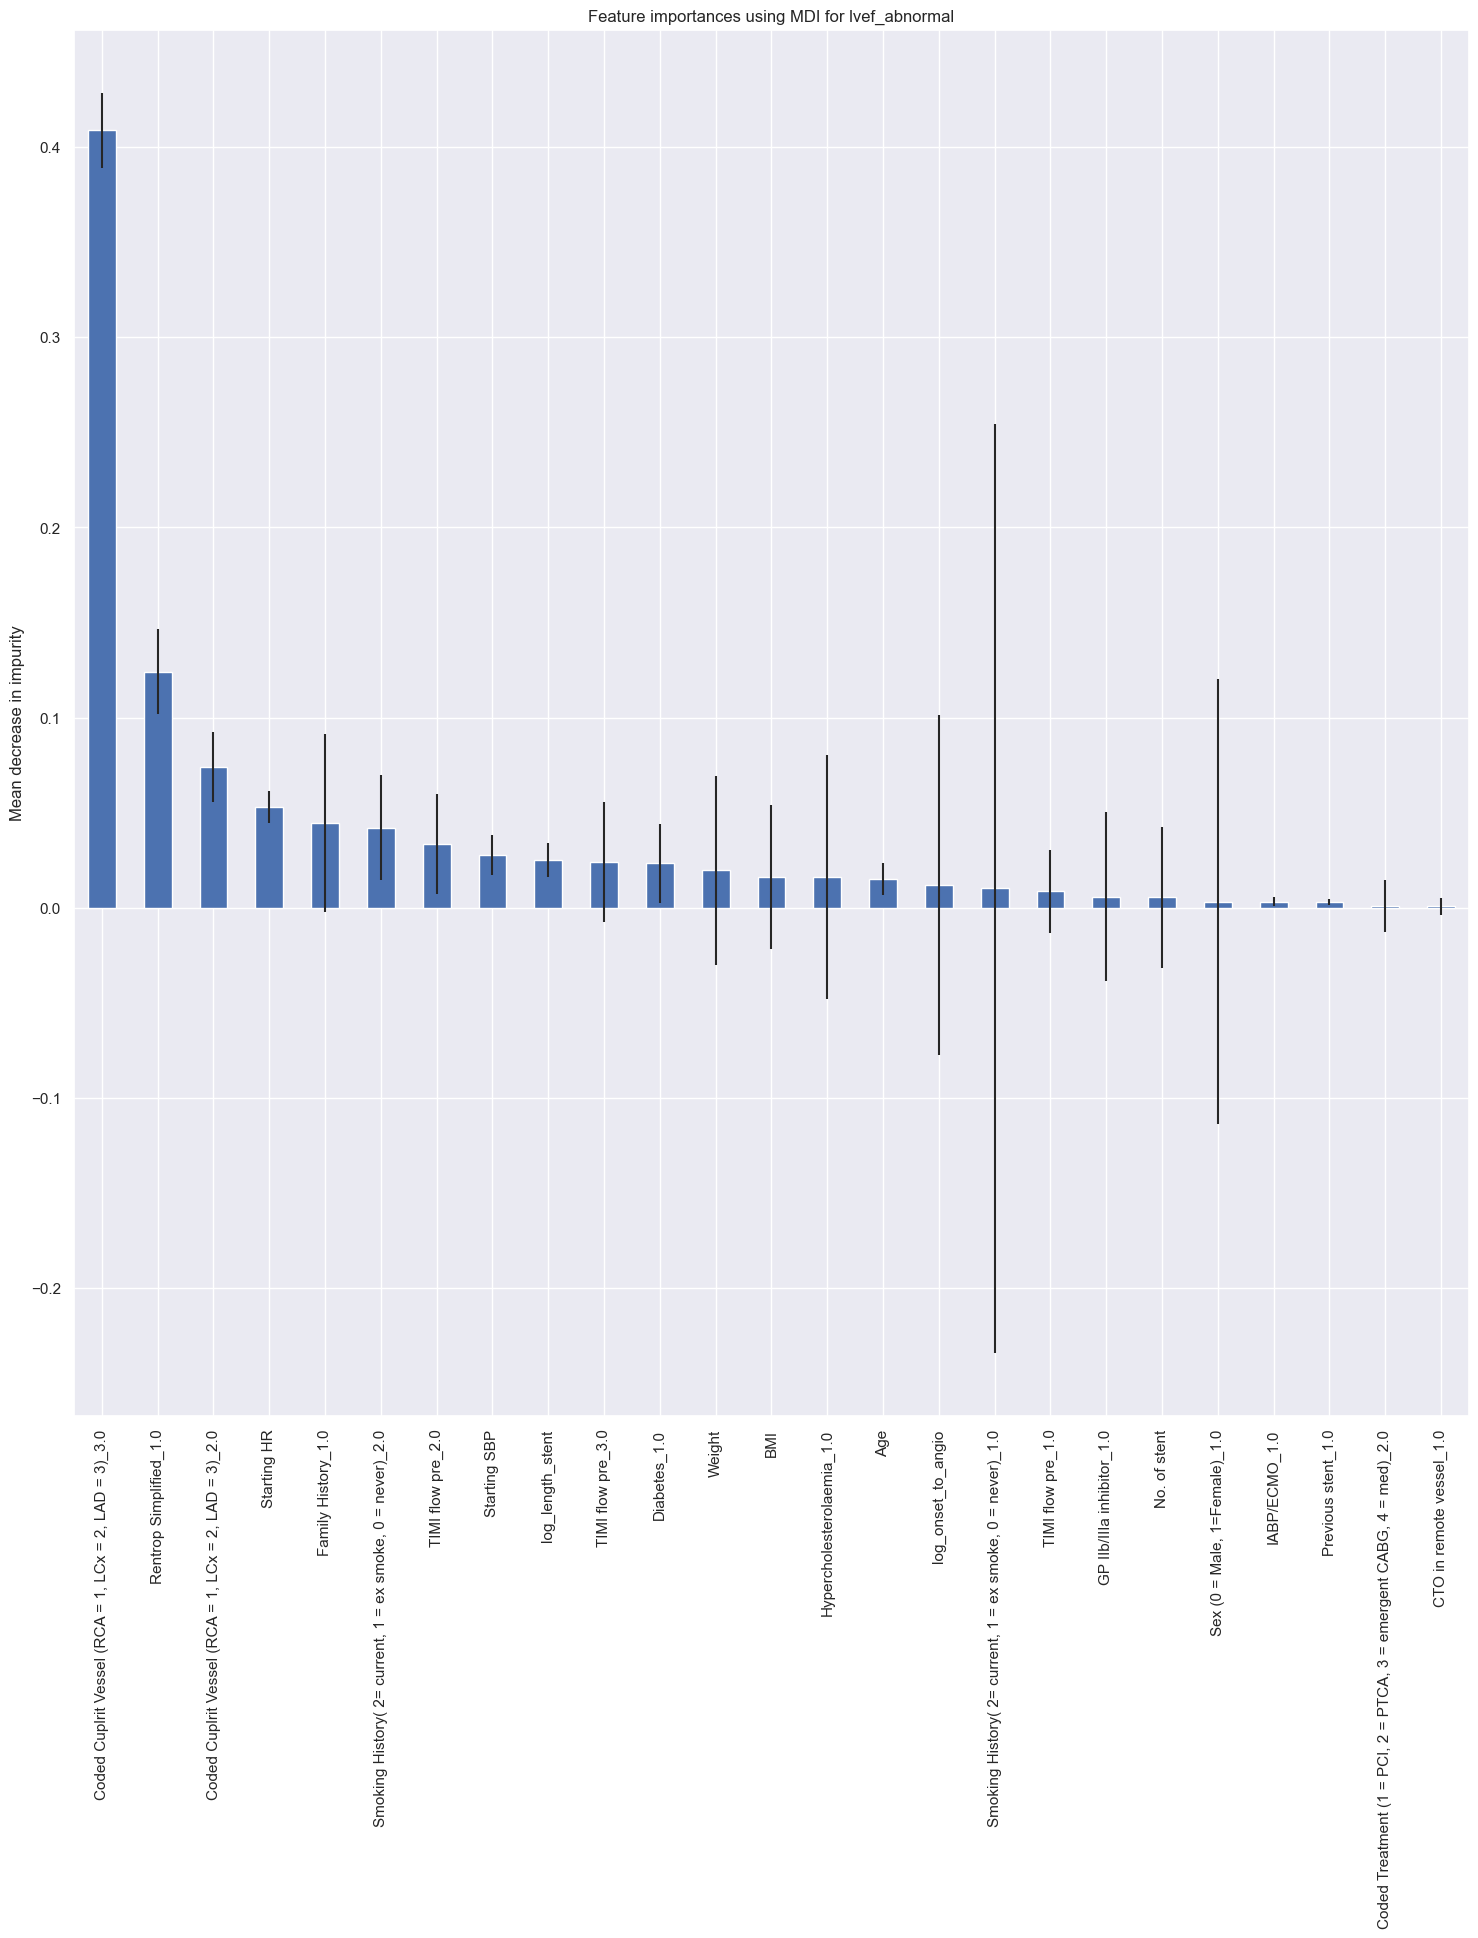

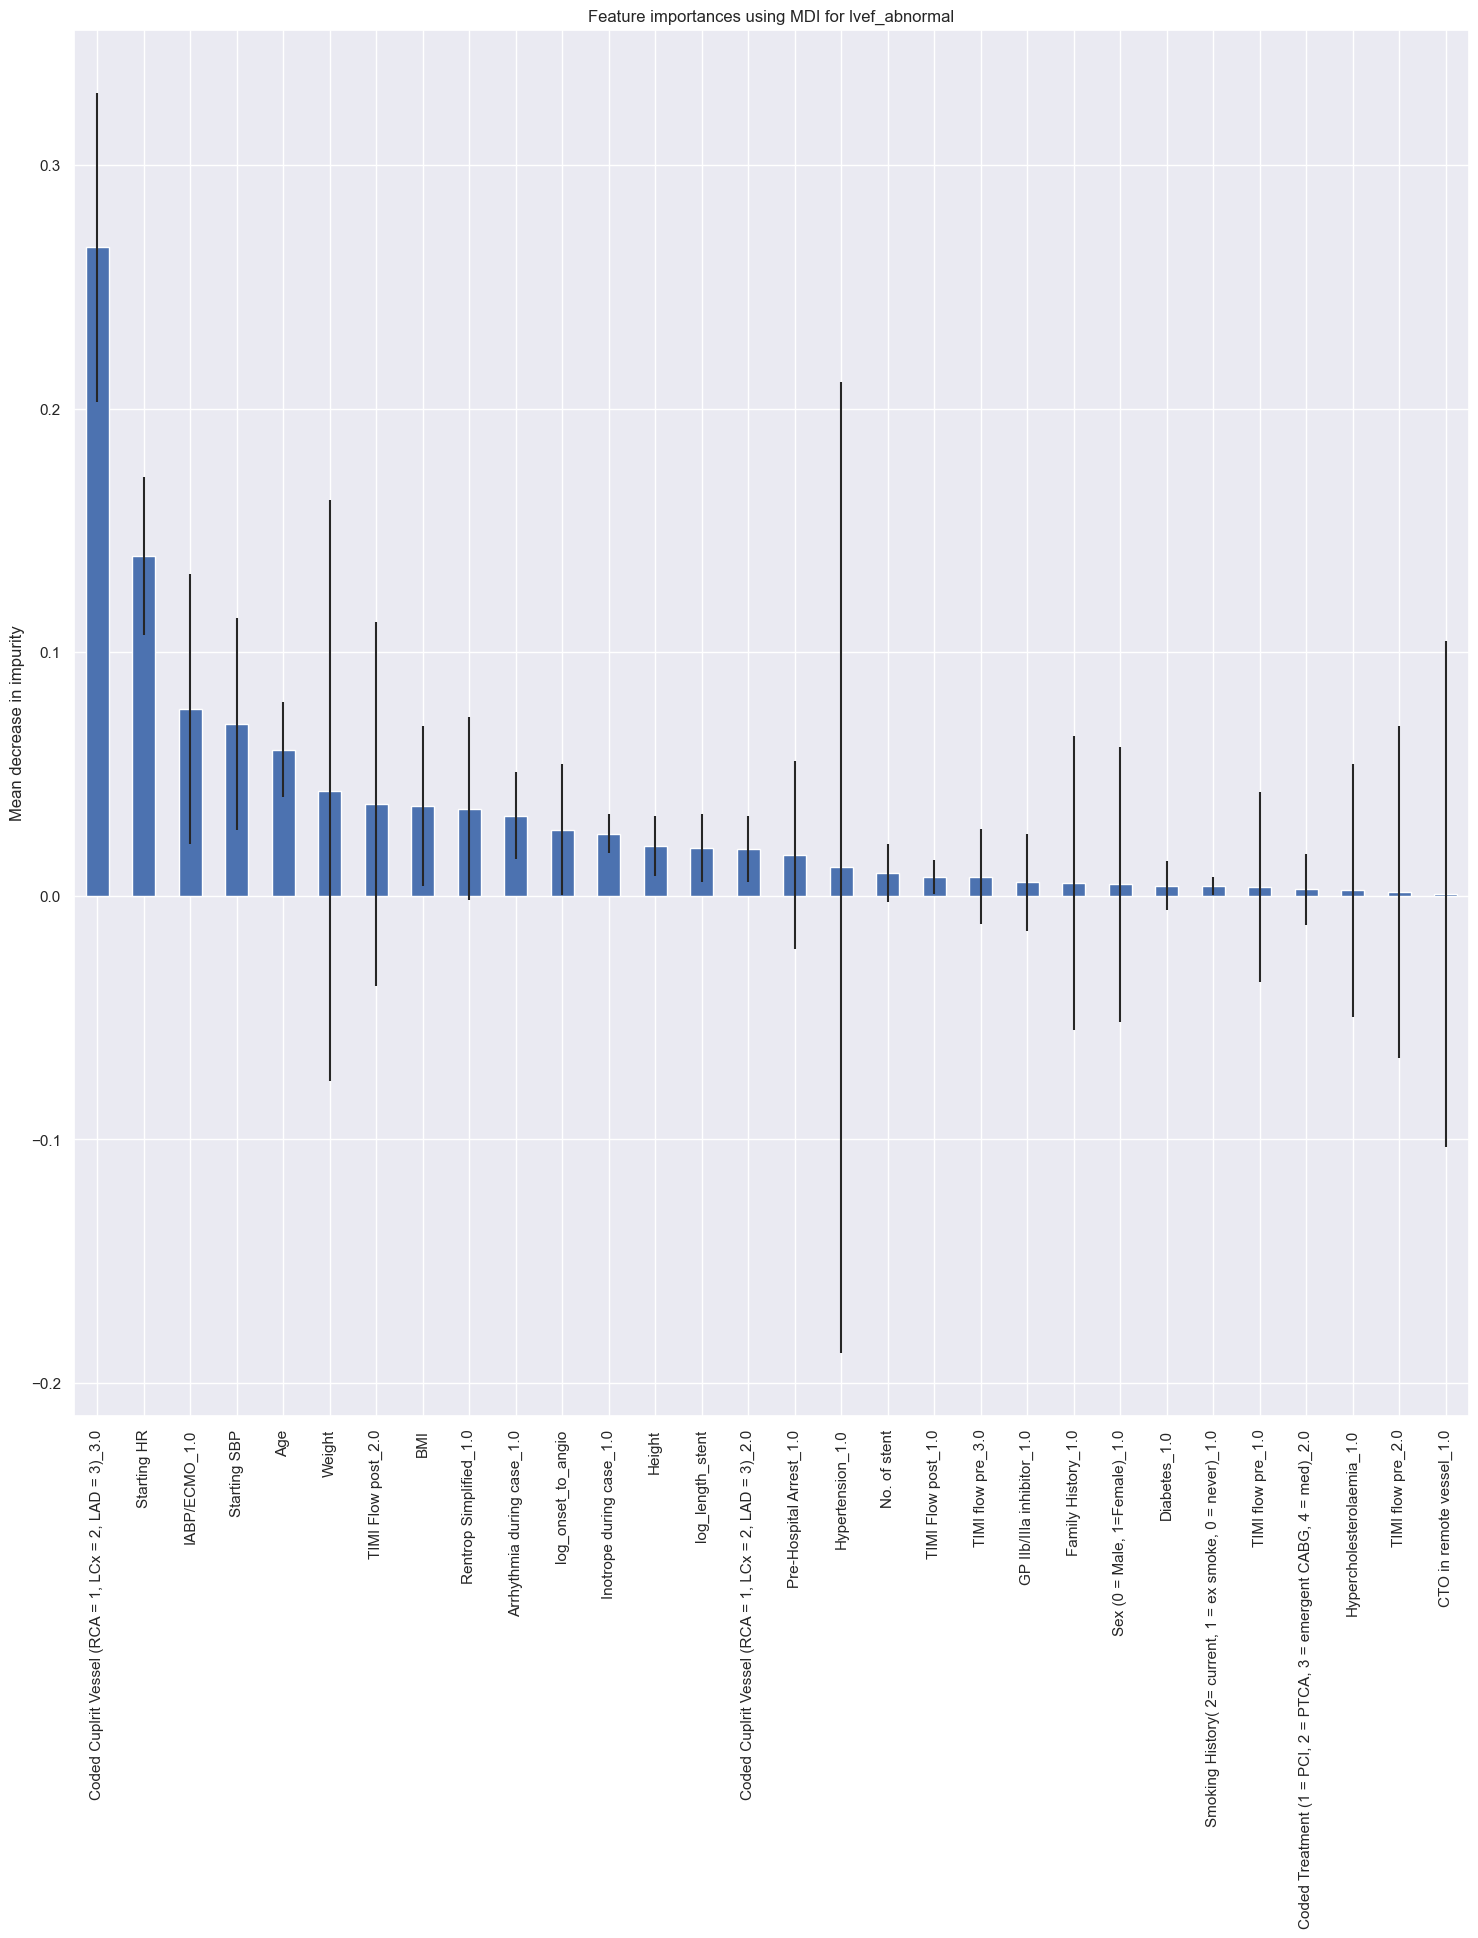

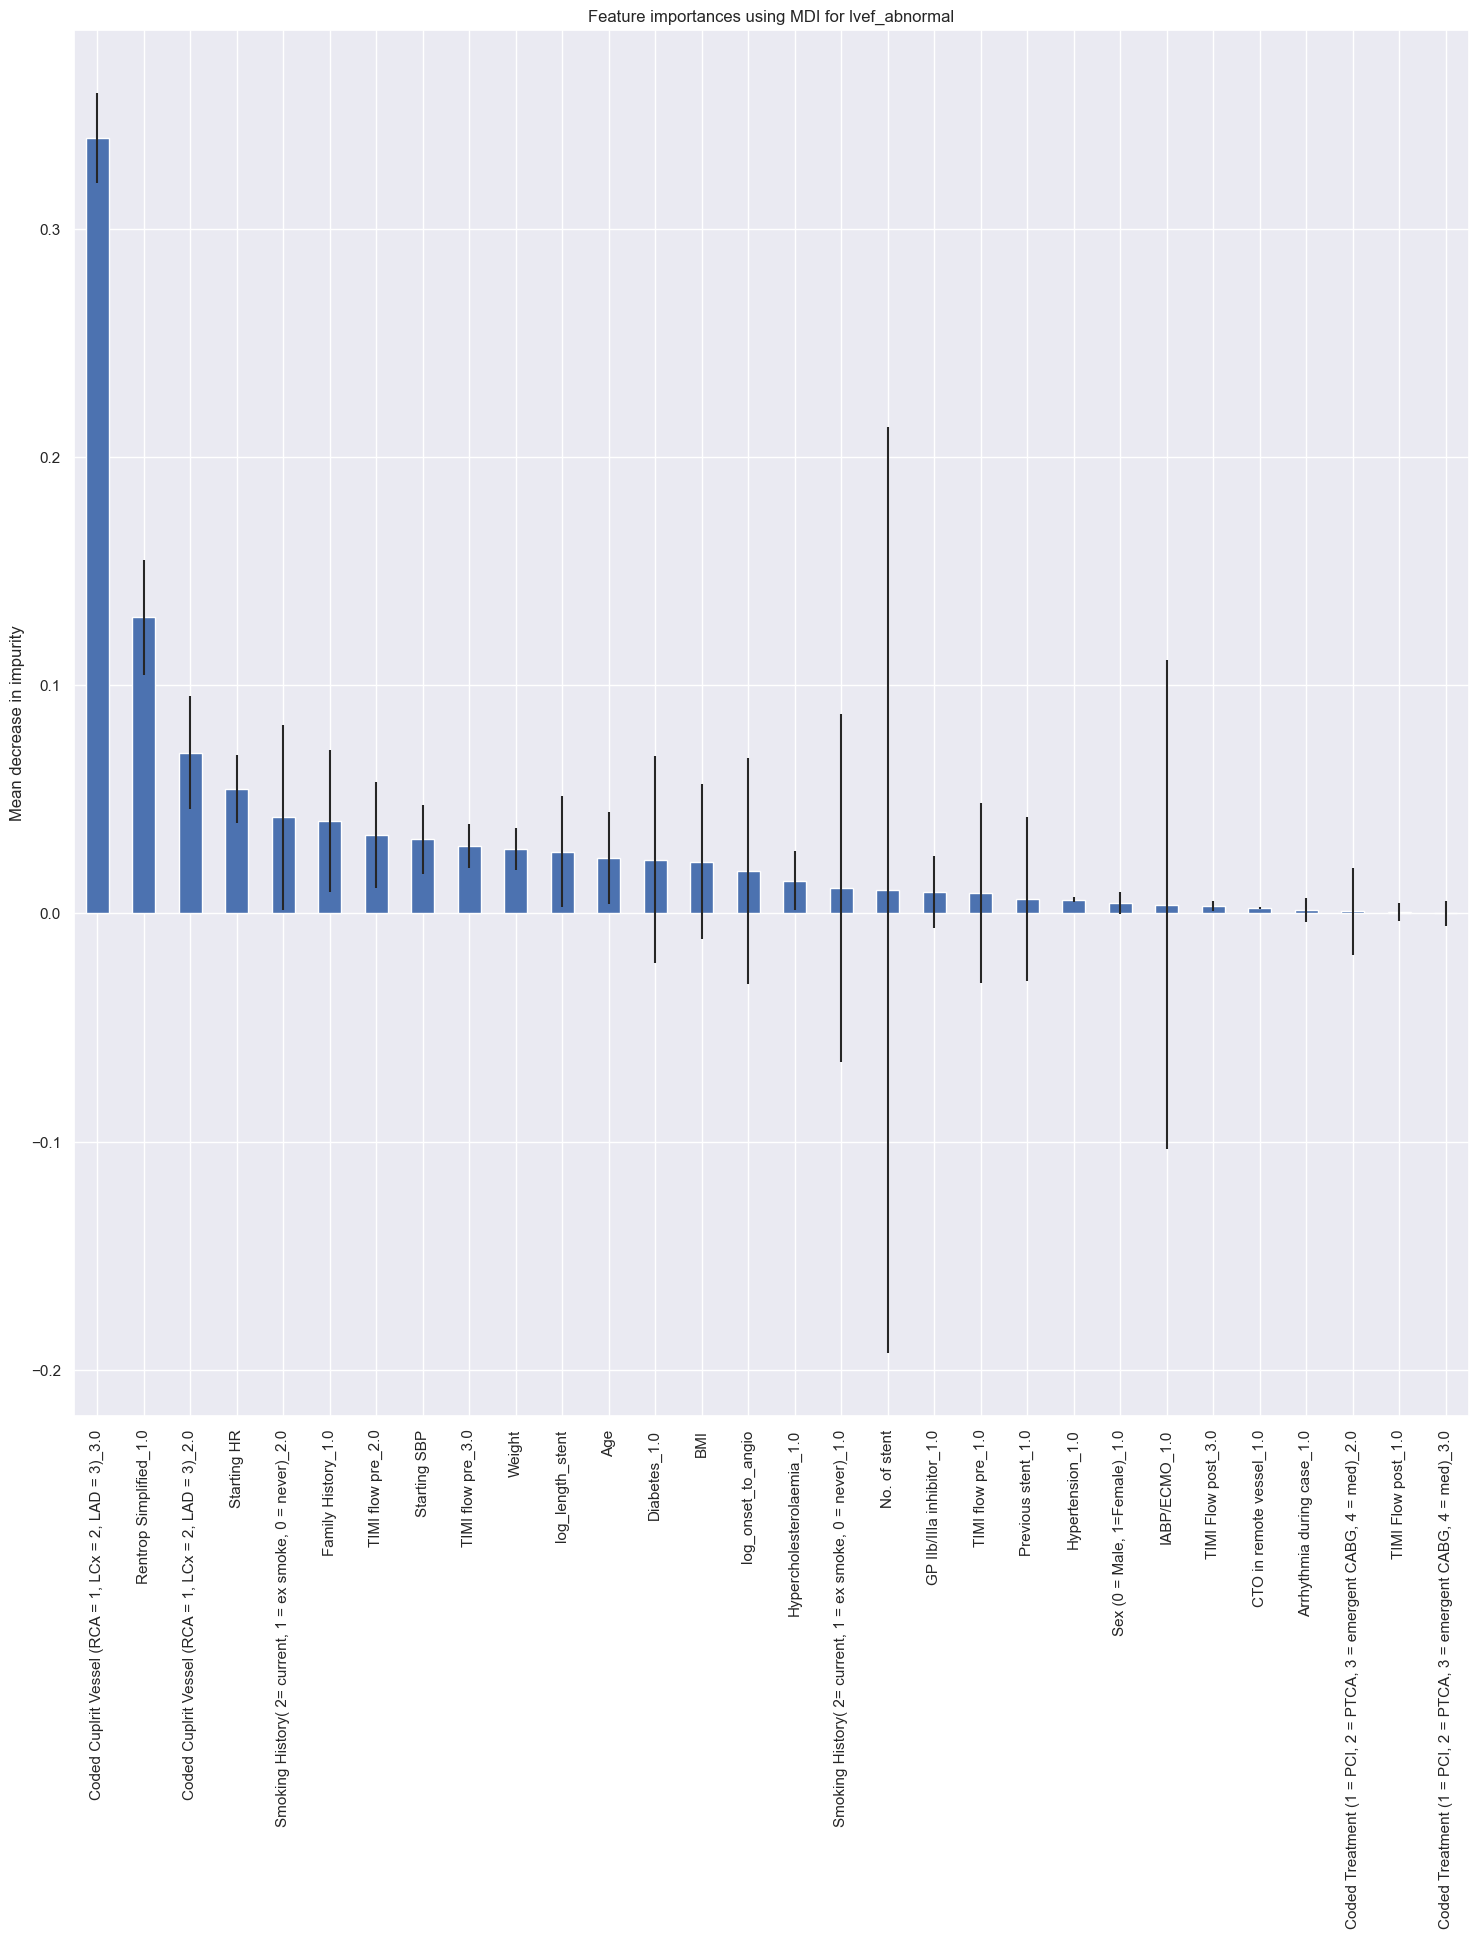

In [71]:
for n in n_features:
    for use_oversample in [False,True]:
        for p in predictors:
            if use_oversample:
                model_name = "decision_feature_selection" + str(n) +  "_oversample"
            else:
                model_name = "decision_feature_selection"  + str(n)
            loaded_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
            feature_select = loaded_pipe.named_steps["feature_select"].get_support()

            importances = loaded_pipe.named_steps["model"].feature_importances_
            std = np.std([tree.feature_importances_ for tree in loaded_pipe.named_steps["model"].estimators_], axis=0)


            forest_importances = pd.Series(importances, index= X_train.columns[feature_select])
            forest_importances = forest_importances.sort_values(ascending=False)
            fig, ax = plt.subplots(figsize=(18, 18))
            forest_importances.plot.bar(yerr=std, ax=ax)
            ax.set_title("Feature importances using MDI for " + p)
            ax.set_ylabel("Mean decrease in impurity")
            fig.tight_layout

            plt.savefig("figure/" + model_name + "_coeff_" + p +".png",bbox_inches="tight")

# Test result

In [79]:
final_result_df = pd.DataFrame.from_dict(
    {'model': [],
    'accuracy':[],
     'precision':[],
     'recall':[],
     'f1_score':[],
     'auc':[],
     'outcome':[],
    'oversample':[],
    'n_feature':[]})



In [80]:
model_dict = {
    'ada':'adaboost',
    'gb': 'gb',
    'svm':'svm',
    'rf':'rf',
    'dt':'decision',
    'l1':'l1',
    'l2':'l2',
    'elasticnet':'elasticnet',
    'logistic':'logistic'
}

In [81]:
for k,v in model_dict.items():
    for p in predictors:
        for n in n_features:
            for use_oversample in [True,False]:
                if use_oversample:
                    model_name = v + '_feature_selection'+str(n)+'_oversample'
                else:
                    model_name = v + '_feature_selection'+str(n)
                y_test = df_dummy.loc[test[p],p]
                X_test = df_dummy.iloc[test[p]].drop(predictors, axis=1)
                pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
                test_result_df = evaluate_model(pipe,X_test,y_test)
                test_result_df["outcome"] = p
                test_result_df["model"] = k
                test_result_df["oversample"] = use_oversample
                test_result_df["n_feature"] = n

                final_result_df = pd.concat([final_result_df,test_result_df],ignore_index=True)

C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 

FileNotFoundError: [Errno 2] No such file or directory: 'model/logistic_feature_selection5_Outcome.pickle'

In [ ]:
final_result_df

In [82]:
final_result_df.to_csv("result/final_out_1year.csv",index=False)